In [1]:
# Проверка среды выполнения СoLab/Local
oncolab = 'google.colab' in str(get_ipython())
if oncolab:
  print('Running on CoLab')
else:
  print('Not running on CoLab')

Running on CoLab


In [2]:
!pip install uproot3 awkward particle scikit-learn 'iminuit<2' probfit cupy-cuda110
!pip install gputil psutil humanize

     |████████████████████████████████| 122kB 12.2MB/s 
     |████████████████████████████████| 7.6MB 13.0MB/s 
     |████████████████████████████████| 215kB 29.7MB/s 
     |████████████████████████████████| 4.1MB 14.6MB/s 
     |████████████████████████████████| 1.8MB 32.7MB/s 
     |████████████████████████████████| 165.3MB 87kB/s 
     |████████████████████████████████| 92kB 8.0MB/s 
  Created wheel for gputil: filename=GPUtil-1.4.0-cp37-none-any.whl size=7411 sha256=76ccd64cc458a4e37041caf5905b1138901ad87a7604e53fb800f2d5a8d40e5d
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil


In [3]:
# memory footprint support libraries/code
import os, psutil, humanize
import GPUtil as GPU
def printrss():
  process = psutil.Process(os.getpid())
  !cat /proc/cpuinfo | fgrep "model name" | sed -r "s/^model name\s+:\s+(.+)/\1/"
  print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
  !df
  try:
    GPUs = GPU.getGPUs()
    gpu = GPUs[0]
    print("GPU", gpu.name, "| driver", gpu.driver)
    print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
  except:
    print("No GPU provided")
    gpu = None
  return gpu

gpu = printrss()

Intel(R) Xeon(R) CPU @ 2.00GHz
Intel(R) Xeon(R) CPU @ 2.00GHz
Gen RAM Free: 12.8 GB  | Proc size: 129.2 MB
Filesystem     1K-blocks     Used Available Use% Mounted on
overlay        113008892 40704396  72288112  37% /
tmpfs              65536        0     65536   0% /dev
tmpfs            6666784        0   6666784   0% /sys/fs/cgroup
shm              6160384        0   6160384   0% /dev/shm
tmpfs            6666784       24   6666760   1% /var/colab
/dev/sda1      119512108 41968152  77527572  36% /etc/hosts
tmpfs            6666784        0   6666784   0% /proc/acpi
tmpfs            6666784        0   6666784   0% /proc/scsi
tmpfs            6666784        0   6666784   0% /sys/firmware
No GPU provided


In [4]:
speedOfLight_mmperns = 299.792458 # мм/нс

In [5]:
#@title Настройка выполнения кода
mode = "beta" #@param ["beta", "class"]

verbose = True #@param {type:"boolean"}

updateHDF = False #@param {type:"boolean"}

updateNNdata = True #@param {type:"boolean"}

useCuPy = True #@param {type:"boolean"}

# отключение использования CuPy, если GPU не выделен
if gpu is None:
  useCuPy = False

# Частота темновых шумов на 1 кв. мм. Если noisefreqpersqmm==0, то шум не моделируется.
noisefreqpersqmm =  50000#@param {type:"number"}

# Варианты числа бинов по phi_c
nbins_vars = (3, 5, 7, 9, 10, 11) #@param {type:"raw"}

In [6]:
#@title Настройка модели нейросети
restoreModel = False #@param {type:"boolean"}

updateModelFit = True #@param {type:"boolean"}

maxepochs = 300 #@param {type:"integer"}

batchSize = 1024 #@param {type:"integer"}

# конфигурация скрытых слоев нейросети
hlayers = (200, 100, 50, 20)


In [7]:
import glob
if oncolab:
  from google.colab import drive 
  drive.mount('/mntDrive')  # смонтировать диск в папке «mntDrive»   
  datadir = '/mntDrive/My Drive/FARICH/Reconstruction/NN/data'
else:
  datadirs = [r'C:\Users\skono\Google Диск (skononov@nsu.ru)\FARICH\Reconstruction\NN\data', \
              r'D:\skono\Google Диск НГУ\FARICH\Reconstruction\NN\data', \
              r'C:\Users\skono\Google Диск НГУ\FARICH\Reconstruction\NN\data']
  datadir = None
  for dir in datadirs:
    if os.access(dir, os.R_OK):
      datadir = dir
      os.chdir(datadir)
      break

betatrain_filenames = [os.path.join(datadir, 'pi-pi-', 'rndm', fn) for fn in ['farichsim_pi-pi-_45-360deg_1200.0k_ideal_2020-12-24_rndm.root','farichsim_pi-pi-_45-360deg_120.0k_ideal_2020-12-07_rndm.root']]
class_filenames = [os.path.join(datadir, 'mu-pi-', 'rndm', 'farichsim_mu-pi-_45-360deg_120.0k_ideal_2020-12-07_rndm.root'),]

rootFilenameMap = {'beta': betatrain_filenames, 'class': class_filenames}

Mounted at /mntDrive


In [8]:
import sys
srcdir = os.path.dirname(datadir)
if srcdir not in sys.path:
  sys.path.append(srcdir)
from farichnnlib import *

In [9]:
strategy = initcompstrategy(oncolab)

Could not set TPU distribution strategy!
Please provide a TPU Name to connect to.
1 physical devices: /physical_device:CPU:0
0 physical GPUs: 
0 physical TPUs: 
1 logical devices: /device:CPU:0
0 logical GPUs: 
0 logical TPUs: 


In [10]:
# Начало работы
# Чтение ROOT-файлов, восстановление (theta_c, phi_c) и преобразование в data frame, сохраняемый в h5
hdfilename = datadir + os.sep + f'{mode}_noise{noisefreqpersqmm}_tcor_edf.h5'
if not os.access(hdfilename, os.R_OK) or updateHDF:
  start = time.perf_counter()
  processroot(rootFilenameMap[mode], hdfilename, 100000, noisefreqpersqmm, verbose, useCuPy, recorigtime=True)
  duration = time.perf_counter()-start
  print(f"ROOT files were processed in {duration:.2f} seconds")
  !df

In [11]:
# Бинирование хитов по phi_c и подготовка данных для нейросети
for nbins in nbins_vars:
  nndatafilename = datadir + os.sep + f'{mode}_noise{noisefreqpersqmm}_phibins{nbins}_tcor_nndata.h5'
  if not os.access(nndatafilename, os.R_OK) or updateNNdata:
    print(f'Preparing NN input data for number of phi_c bins {nbins}...')
    data_binned_transform(hdfilename, nndatafilename, mode, nbins=nbins, rowchunksize=2000000, verbose=verbose)
    !df

Preparing NN input data for number of phi_c bins 3...
Reading edf from /mntDrive/My Drive/FARICH/Reconstruction/NN/data/beta_noise50000_tcor_edf.h5, process and write NN data to /mntDrive/My Drive/FARICH/Reconstruction/NN/data/beta_noise50000_phibins3_tcor_nndata.h5
  Process chunk 0 of edf...
    Process 11421 entries...
    After cut 11420 entries left
    Binned data
                 count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry phi_c_bin                                                           
0     0           11.0      0.211115     0.760721     0.072147    0.997129
      1            6.0      0.175329     1.277437     0.084230    1.308306
      2            5.0      0.209085     0.683237     0.046393    1.179146
1     0           10.0      0.210872     0.720556     0.053957    1.323739
      1            4.0      0.193104     0.083170     0.098784    0.005606
...                ...           ...          ...          ...         ...
11419 1           16.0     

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 1 of edf...
    Process 11420 entries...
    After cut 11419 entries left
    Binned data
                 count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry phi_c_bin                                                           
11420 0            3.0      0.253366     0.687006     0.107411    0.945724
      1            1.0      0.369718     2.639915     0.000000    0.000000
      2            0.0      0.000000     0.000000     0.000000    0.000000
11421 0           15.0      0.208978     0.466643     0.053477    0.979245
      1            5.0      0.170878     0.077831     0.069561    0.408017
...                ...           ...          ...          ...         ...
22838 1           16.0      0.239526     0.458895     0.067365    0.716679
      2           20.0      0.285358     0.734905     0.057126    1.134273
22839 0            5.0      0.206248     1.193490     0.061390    0.965913
      1            4.0      0.109504     0.147212     0.011582    0.1

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 2 of edf...
    Process 11431 entries...
    After cut 11428 entries left
    Binned data
                 count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry phi_c_bin                                                           
22839 0            0.0      0.000000     0.000000     0.000000    0.000000
      1            0.0      0.000000     0.000000     0.000000    0.000000
      2            3.0      0.260408     1.864372     0.086797    1.606209
22840 0            8.0      0.179399     1.003389     0.077001    1.499452
      1            1.0      0.126273     0.084900     0.000000    0.000000
...                ...           ...          ...          ...         ...
34268 1           19.0      0.231013     0.329942     0.037298    0.576357
      2           20.0      0.255489     0.683116     0.047216    1.040883
34269 0           10.0      0.284664     0.088238     0.025877    0.001968
      1            5.0      0.237535     0.145306     0.038053    0.1

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


       (count, 0)  (count, 1)  ...  (theta_p_norm, )     label
entry                          ...                            
22839        0.00        0.00  ...          0.367345  0.248236
22840        0.16        0.02  ...          0.407326  0.228756
22841        0.08        0.16  ...          0.288851  0.359551
22842        0.34        0.16  ...          0.160957  0.576182
22843        0.26        0.22  ...          0.380694  0.615288
...           ...         ...  ...               ...       ...
34265        0.24        0.14  ...          0.363493  0.685930
34266        0.28        0.18  ...          0.431302  0.529592
34267        0.14        0.06  ...          0.246438  0.250564
34268        0.28        0.38  ...          0.451556  0.635065
34269        0.20        0.10  ...          0.461704  0.720912

[11428 rows x 17 columns]
    Splitting data into train and test sets with test size ratio 0.2
    Shapes of train and test data and labels: (9142, 16) (9142,) (2286, 16) (2286,)
 

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 4 of edf...
    Process 11422 entries...
    After cut 11421 entries left
    Binned data
                 count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry phi_c_bin                                                           
45680 0            6.0      0.223082     0.480521     0.076085    0.813594
      1            5.0      0.151763     0.563658     0.023107    0.986947
      2            4.0      0.204812     1.083930     0.092150    1.757492
45681 0           11.0      0.256680     0.309940     0.060252    0.761944
      1           17.0      0.242100     0.227796     0.030616    0.515514
...                ...           ...          ...          ...         ...
57099 1            6.0      0.240146     0.067343     0.007798    0.000550
      2           12.0      0.255641     0.067423     0.010606    0.001172
57100 0           11.0      0.237841     0.810136     0.060089    1.359857
      1           10.0      0.237956     0.069237     0.008704    0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 5 of edf...
    Process 11428 entries...
    After cut 11427 entries left
    Binned data
                 count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry phi_c_bin                                                           
57101 0           15.0      0.247567     0.118477     0.053390    0.118537
      1           10.0      0.231100     0.072519     0.007502    0.001123
      2           10.0      0.237625     0.304150     0.071211    0.693644
57102 0            5.0      0.190189     0.459863     0.077968    0.749022
      1            2.0      0.142837     0.069780     0.000906    0.000117
...                ...           ...          ...          ...         ...
68526 1            2.0      0.279594     0.779416     0.074863    0.465274
      2            4.0      0.241403     1.092868     0.055904    1.636502
68527 0           17.0      0.275549     0.068155     0.008304    0.001185
      1            7.0      0.249090     0.492081     0.068077    0.9

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 6 of edf...
    Process 11429 entries...
    After cut 11428 entries left
    Binned data
                 count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry phi_c_bin                                                           
68527 0            2.0      0.254978     3.862899     0.065400    0.333449
      1            0.0      0.000000     0.000000     0.000000    0.000000
      2            1.0      0.323035     1.797329     0.000000    0.000000
68528 0            3.0      0.276043     2.159526     0.038613    0.924998
      1            0.0      0.000000     0.000000     0.000000    0.000000
...                ...           ...          ...          ...         ...
79954 1           18.0      0.262823     0.331385     0.029270    0.753010
      2           27.0      0.300596     0.341534     0.062664    0.856503
79955 0           18.0      0.322175     0.264749     0.026826    0.795231
      1           13.0      0.279214     0.168193     0.012986    0.2

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 7 of edf...
    Process 11435 entries...
    After cut 11434 entries left
    Binned data
                 count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry phi_c_bin                                                           
79955 0            0.0      0.000000     0.000000     0.000000    0.000000
      1            2.0      0.087414     2.181047     0.032543    1.009171
      2            3.0      0.280288     1.654566     0.044711    0.630362
79956 0           10.0      0.214165     0.510377     0.066469    0.577559
      1            5.0      0.136741     0.069938     0.028228    0.000706
...                ...           ...          ...          ...         ...
91388 1           10.0      0.267521     0.186841     0.009974    0.363492
      2            7.0      0.252768     1.433136     0.075836    1.630422
91389 0            4.0      0.204650     0.082343     0.021177    0.001782
      1            9.0      0.176700     0.082125     0.005062    0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 8 of edf...
    Process 11427 entries...
    After cut 11426 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
91389  0            5.0      0.241347     0.600298     0.027636    0.968863
       1            2.0      0.217724     2.070380     0.044120    1.197423
       2            5.0      0.236916     0.686220     0.070166    1.103230
91390  0            1.0      0.285088     2.674573     0.000000    0.000000
       1            4.0      0.172741     1.010359     0.114030    1.178174
...                 ...           ...          ...          ...         ...
102814 1            4.0      0.156489     1.091908     0.123068    1.730946
       2            4.0      0.245454     1.241690     0.091462    1.214149
102815 0            1.0      0.293446     0.071197     0.000000    0.000000
       1            0.0      0.000000     0.000000     0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 9 of edf...
    Process 11425 entries...
    After cut 11424 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
102815 0            7.0      0.276843     0.434372     0.021407    0.915411
       1           12.0      0.248290     0.418165     0.009355    1.144320
       2           11.0      0.268294     0.072234     0.017197    0.001171
102816 0           21.0      0.288000     0.317321     0.058241    0.681329
       1           17.0      0.269033     0.078486     0.009322    0.001032
...                 ...           ...          ...          ...         ...
114238 1            6.0      0.152512     0.190039     0.074648    0.422110
       2            4.0      0.229320     1.638647     0.055731    1.711264
114239 0           17.0      0.270158     0.082760     0.032270    0.003347
       1           10.0      0.209720     0.080807     0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 10 of edf...
    Process 11408 entries...
    After cut 11407 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
114239 0            7.0      0.270633     0.972028     0.074935    0.915268
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            2.0      0.145640     1.464982     0.072656    2.071006
114240 0            5.0      0.235722     0.070358     0.070757    0.003485
       1           12.0      0.184001     0.078158     0.018307    0.034296
...                 ...           ...          ...          ...         ...
125645 1            9.0      0.220744     0.066527     0.008484    0.000755
       2            5.0      0.238284     0.068073     0.026775    0.002628
125646 0           18.0      0.265206     0.385386     0.040763    0.772267
       1           10.0      0.200018     0.305757     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 11 of edf...
    Process 11443 entries...
    After cut 11442 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
125647 0           24.0      0.286994     0.437992     0.044999    1.028607
       1           13.0      0.265150     0.178426     0.016905    0.364392
       2           17.0      0.290927     0.115871     0.013485    0.169114
125648 0           14.0      0.287097     0.226193     0.021639    0.575247
       1           10.0      0.279019     0.035762     0.029224    0.168030
...                 ...           ...          ...          ...         ...
137087 1           15.0      0.232460     0.429167     0.028332    0.890178
       2           13.0      0.247652     0.299817     0.066263    0.616159
137088 0            5.0      0.162930     0.086547     0.023813    0.001635
       1            2.0      0.135788     0.085358     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 12 of edf...
    Process 11420 entries...
    After cut 11420 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
137088 0            0.0      0.000000     0.000000     0.000000    0.000000
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            7.0      0.231384     1.607823     0.119210    1.151103
137089 0            7.0      0.144784     0.631737     0.040902    1.142083
       1            5.0      0.161225     0.801269     0.089548    1.445273
...                 ...           ...          ...          ...         ...
148506 1            7.0      0.160098     0.643539     0.037520    1.412383
       2           10.0      0.172402     0.114830     0.049132    0.100397
148507 0           18.0      0.229716     0.430887     0.069425    0.759679
       1            7.0      0.197322     0.090848     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


        (count, 0)  (count, 1)  ...  (theta_p_norm, )     label
entry                           ...                            
137088        0.00        0.00  ...          0.423630  0.290722
137089        0.14        0.10  ...          0.366476  0.205239
137090        0.16        0.22  ...          0.162727  0.568048
137091        0.08        0.02  ...          0.427744  0.130699
137092        0.16        0.08  ...          0.421240  0.126058
...            ...         ...  ...               ...       ...
148503        0.22        0.18  ...          0.289228  0.602007
148504        0.28        0.18  ...          0.189953  0.682801
148505        0.08        0.02  ...          0.453029  0.188620
148506        0.14        0.14  ...          0.032945  0.292363
148507        0.36        0.14  ...          0.498365  0.582289

[11420 rows x 17 columns]
    Splitting data into train and test sets with test size ratio 0.2
    Shapes of train and test data and labels: (9136, 16) (9136,) (2284, 

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 14 of edf...
    Process 11404 entries...
    After cut 11404 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
159917 0            8.0      0.195381     0.879194     0.101551    1.373523
       1           13.0      0.189419     0.088438     0.062834    0.010003
       2           20.0      0.206069     0.285939     0.106919    0.664023
159918 0            6.0      0.170607     0.401099     0.032520    0.655963
       1            6.0      0.155575     0.865595     0.061059    1.158538
...                 ...           ...          ...          ...         ...
171319 1           11.0      0.258630     0.066635     0.024363    0.002303
       2            4.0      0.282016     0.089962     0.028719    0.041465
171320 0           13.0      0.173373     0.521179     0.086172    0.933048
       1            5.0      0.182321     0.087032     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 15 of edf...
    Process 11413 entries...
    After cut 11412 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
171321 0           14.0      0.231256     0.393316     0.039910    0.997342
       1            6.0      0.204677     0.288185     0.013963    0.493441
       2            5.0      0.223976     0.067957     0.016970    0.000899
171322 0           18.0      0.257107     0.674947     0.068820    1.306244
       1           22.0      0.204949     0.606354     0.055868    1.288210
...                 ...           ...          ...          ...         ...
182732 1            3.0      0.122722     0.070365     0.020238    0.000490
       2            5.0      0.189394     0.793114     0.091543    1.301701
182733 0            9.0      0.254695     0.659048     0.055246    1.096026
       1            5.0      0.243551     1.007374     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 16 of edf...
    Process 11414 entries...
    After cut 11411 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
182734 0           10.0      0.262887     0.979099     0.085745    1.003241
       1            6.0      0.158465     1.149360     0.066190    1.504746
       2           11.0      0.199118     0.589323     0.069393    1.037435
182735 0            6.0      0.245095     0.585177     0.067983    1.145938
       1            8.0      0.171982     0.549829     0.081258    0.596788
...                 ...           ...          ...          ...         ...
194146 1            5.0      0.152971     0.523582     0.045684    0.883911
       2            8.0      0.220222     0.794173     0.071323    1.275743
194147 0            6.0      0.170586     0.284272     0.025258    0.479153
       1            3.0      0.136759     0.070013     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 17 of edf...
    Process 11409 entries...
    After cut 11409 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
194147 0            2.0      0.297059     1.653701     0.034105    1.531590
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            2.0      0.327822     2.040917     0.009158    0.362947
194148 0            7.0      0.236679     0.072021     0.013953    0.000895
       1           10.0      0.228744     0.074388     0.021633    0.008911
...                 ...           ...          ...          ...         ...
205554 1           22.0      0.277642     0.066625     0.022289    0.010194
       2            9.0      0.289944     0.685083     0.026052    1.220331
205555 0            4.0      0.197455     0.973857     0.098774    1.568568
       1            3.0      0.203140    -0.007631     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 18 of edf...
    Process 11427 entries...
    After cut 11426 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
205555 0            0.0      0.000000     0.000000     0.000000    0.000000
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            1.0      0.239389     1.134884     0.000000    0.000000
205556 0            6.0      0.200917     0.788091     0.051602    1.199309
       1            7.0      0.197573     1.158744     0.101424    1.621866
...                 ...           ...          ...          ...         ...
216980 1            7.0      0.215425     0.106192     0.035474    0.085184
       2           10.0      0.261183     0.316622     0.030801    0.734294
216981 0            5.0      0.189319     0.070080     0.008272    0.001143
       1            6.0      0.157516     0.351750     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 19 of edf...
    Process 11432 entries...
    After cut 11432 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
216981 0            0.0      0.000000     0.000000     0.000000    0.000000
       1            1.0      0.249576     1.540637     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
216982 0            9.0      0.255821     0.072893     0.015382    0.001717
       1           12.0      0.230550     0.108307     0.038945    0.115336
...                 ...           ...          ...          ...         ...
228411 1           10.0      0.211733     0.312041     0.039227    0.728047
       2           11.0      0.216233     0.077399     0.016930    0.020007
228412 0            4.0      0.190853     0.161550     0.061104    0.120236
       1            3.0      0.129051     1.126867     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 20 of edf...
    Process 11430 entries...
    After cut 11429 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
228413 0           22.0      0.316406     0.574593     0.027717    1.067262
       1           16.0      0.258827     0.647740     0.051882    1.331597
       2           13.0      0.275004     0.516879     0.083804    1.105822
228414 0           10.0      0.239619     0.584415     0.064158    0.821081
       1            6.0      0.189459     0.374370     0.055546    0.649003
...                 ...           ...          ...          ...         ...
239840 1           12.0      0.253923     0.089252     0.017410    0.060212
       2           12.0      0.262567     0.205431     0.041844    0.442503
239841 0            5.0      0.137430     0.067621     0.025818    0.001001
       1            5.0      0.186613     1.229526     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 21 of edf...
    Process 11447 entries...
    After cut 11445 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
239842 0           13.0      0.245433     0.146396     0.048103    0.507620
       1           12.0      0.229614     0.075756     0.007269    0.000854
       2           17.0      0.254929     0.387137     0.030015    1.079015
239843 0            8.0      0.282346     0.641344     0.048803    1.346145
       1           11.0      0.175123     0.892541     0.061253    1.091284
...                 ...           ...          ...          ...         ...
251286 1            0.0      0.000000     0.000000     0.000000    0.000000
       2            3.0      0.243424     1.459621     0.118566    1.246763
251287 0            0.0      0.000000     0.000000     0.000000    0.000000
       1            4.0      0.208299     0.066222     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 22 of edf...
    Process 11417 entries...
    After cut 11415 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
251287 0            9.0      0.187370     0.727585     0.061413    1.376313
       1            3.0      0.198325     0.066593     0.003907    0.000157
       2            5.0      0.194480     0.752777     0.024386    1.370969
251288 0           11.0      0.213528     0.430045     0.029030    1.128846
       1            8.0      0.190357     0.520177     0.028988    1.184352
...                 ...           ...          ...          ...         ...
262702 1            3.0      0.157008     1.500216     0.061765    2.015853
       2            5.0      0.197152     0.812168     0.086617    0.921500
262703 0            0.0      0.000000     0.000000     0.000000    0.000000
       1            6.0      0.219116     0.081151     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 23 of edf...
    Process 11431 entries...
    After cut 11430 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
262703 0           10.0      0.265917     0.236754     0.021169    0.310475
       1            7.0      0.231634     1.142578     0.050896    1.700278
       2           15.0      0.293024     0.878472     0.038301    1.254915
262704 0           16.0      0.255844     0.454226     0.041270    0.891415
       1           16.0      0.239855     0.095051     0.038475    0.264987
...                 ...           ...          ...          ...         ...
274132 1            5.0      0.166576     0.776618     0.071827    1.362786
       2           12.0      0.192270     0.415291     0.071594    0.756082
274133 0           13.0      0.272864     0.048257     0.013668    0.068787
       1           21.0      0.256121     0.067980     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 24 of edf...
    Process 11426 entries...
    After cut 11425 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
274133 0            0.0      0.000000     0.000000     0.000000    0.000000
       1            2.0      0.233154     3.420716     0.102469    0.891019
       2            1.0      0.341526     3.534046     0.000000    0.000000
274134 0            2.0      0.125273     0.067755     0.011982    0.000151
       1            3.0      0.119076     0.067331     0.018793    0.000154
...                 ...           ...          ...          ...         ...
285557 1            5.0      0.214350     0.074099     0.041276    0.004614
       2            8.0      0.208913     0.071676     0.015653    0.001387
285558 0            6.0      0.225859     0.082642     0.051785    0.001510
       1            5.0      0.160894     0.082877     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 25 of edf...
    Process 11415 entries...
    After cut 11414 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
285558 0            1.0      0.082708     2.095335     0.000000    0.000000
       1            7.0      0.214654     0.243543     0.063092    0.300882
       2            6.0      0.240924     0.940692     0.066556    1.205569
285559 0           13.0      0.215469     0.281448     0.050464    0.491188
       1            8.0      0.197737     0.569234     0.023077    1.318236
...                 ...           ...          ...          ...         ...
296971 1            2.0      0.076166     0.087841     0.002696    0.001354
       2            3.0      0.143722    -0.111827     0.015865    0.280758
296972 0           12.0      0.273816     0.078485     0.016800    0.002276
       1           19.0      0.224847     0.485414     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 26 of edf...
    Process 11406 entries...
    After cut 11406 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
296972 0            0.0      0.000000     0.000000     0.000000    0.000000
       1            1.0      0.082393     0.968844     0.000000    0.000000
       2            1.0      0.284353     0.572451     0.000000    0.000000
296973 0           15.0      0.232067     0.722305     0.055626    1.222793
       1           12.0      0.174988     0.740410     0.057684    1.155266
...                 ...           ...          ...          ...         ...
308376 1            6.0      0.140625     0.727436     0.008715    1.436621
       2            8.0      0.227055     0.769471     0.075594    0.714860
308377 0            3.0      0.238658     0.250706     0.085823    0.256955
       1            7.0      0.241052     1.509282     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 27 of edf...
    Process 11430 entries...
    After cut 11428 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
308378 0            7.0      0.291029     0.066999     0.008246    0.001492
       1           11.0      0.258813     0.113871     0.009717    0.147407
       2           14.0      0.279610     0.230030     0.013563    0.527551
308379 0            7.0      0.203332     0.889987     0.065223    1.332395
       1            3.0      0.221461     2.603179     0.061602    1.817403
...                 ...           ...          ...          ...         ...
319805 1            2.0      0.141522     1.416450     0.056630    1.335794
       2            5.0      0.211199     1.331807     0.107972    1.612366
319806 0            7.0      0.223216     1.101206     0.054289    1.243401
       1            7.0      0.144465     0.102313     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 28 of edf...
    Process 11405 entries...
    After cut 11404 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
319806 0            1.0      0.132081     1.357158     0.000000    0.000000
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            2.0      0.277249     0.816679     0.002056    1.080957
319807 0           20.0      0.302794     0.223704     0.022190    0.618307
       1           13.0      0.260749     0.290902     0.038389    0.506183
...                 ...           ...          ...          ...         ...
331209 1           10.0      0.230362     0.304433     0.033544    0.611938
       2           11.0      0.287821     0.058791     0.049844    0.080239
331210 0            7.0      0.245477    -0.042356     0.052036    0.333458
       1           12.0      0.164684     0.184550     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 29 of edf...
    Process 11424 entries...
    After cut 11424 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
331210 0            7.0      0.264752     1.117140     0.074650    0.983281
       1            1.0      0.067654     2.978861     0.000000    0.000000
       2            3.0      0.243458     2.115278     0.123408    1.051786
331211 0           13.0      0.259318     0.160506     0.020422    0.304039
       1            8.0      0.221289     0.071259     0.006343    0.000870
...                 ...           ...          ...          ...         ...
342632 1            3.0      0.250667     0.047030     0.069765    0.358777
       2            6.0      0.169171     1.131093     0.025635    1.584240
342633 0            8.0      0.284093     0.065683     0.005784    0.000758
       1            7.0      0.273141     0.066005     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 30 of edf...
    Process 11403 entries...
    After cut 11403 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
342633 0            0.0      0.000000     0.000000     0.000000    0.000000
       1            2.0      0.155509     1.356800     0.112810    0.277040
       2            2.0      0.330601     2.534737     0.032712    0.596283
342634 0           12.0      0.286094     0.507044     0.036987    0.928817
       1           11.0      0.223855     0.144923     0.050628    0.148704
...                 ...           ...          ...          ...         ...
354034 1           20.0      0.272922     0.461411     0.040646    1.064233
       2           20.0      0.316101     0.182544     0.038802    0.458091
354035 0           15.0      0.300066     0.089677     0.029870    0.002684
       1            9.0      0.246542     0.087326     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 31 of edf...
    Process 11404 entries...
    After cut 11401 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
354035 0            5.0      0.235199     0.965557     0.087483    1.222746
       1            7.0      0.252004     0.374931     0.022068    0.701554
       2           12.0      0.276936     0.486131     0.044036    1.196411
354036 0            8.0      0.169099    -0.019920     0.026754    0.235799
       1            6.0      0.187977     0.281878     0.043135    0.493365
...                 ...           ...          ...          ...         ...
365436 1           11.0      0.235053     0.603126     0.045449    1.017260
       2           23.0      0.278897     0.351432     0.032814    0.889277
365437 0           18.0      0.302185     0.092311     0.018898    0.092378
       1           12.0      0.278799     0.069385     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 32 of edf...
    Process 11409 entries...
    After cut 11409 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
365438 0           20.0      0.289345     0.236598     0.050767    0.426259
       1           13.0      0.254459     0.646762     0.047153    1.328295
       2           19.0      0.296395     0.406120     0.064515    0.822934
365439 0           12.0      0.283688     0.015731     0.051941    0.246443
       1           21.0      0.246637     0.415829     0.033625    0.999797
...                 ...           ...          ...          ...         ...
376845 1           15.0      0.242513     0.531080     0.044143    0.983024
       2           17.0      0.304186     0.117547     0.029560    0.114140
376846 0            6.0      0.212197     0.419668     0.067001    0.792703
       1            4.0      0.142523     0.089642     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


        (count, 0)  (count, 1)  ...  (theta_p_norm, )     label
entry                           ...                            
365438        0.40        0.26  ...          0.464021  0.838179
365439        0.24        0.42  ...          0.420579  0.849038
365440        0.20        0.12  ...          0.313922  0.624216
365441        0.16        0.18  ...          0.057643  0.458081
365442        0.24        0.16  ...          0.198792  0.677239
...            ...         ...  ...               ...       ...
376842        0.36        0.24  ...          0.186980  0.497040
376843        0.40        0.32  ...          0.443263  0.888201
376844        0.34        0.16  ...          0.352916  0.587068
376845        0.30        0.30  ...          0.476736  0.858768
376846        0.12        0.08  ...          0.461601  0.373537

[11409 rows x 17 columns]
    Splitting data into train and test sets with test size ratio 0.2
    Shapes of train and test data and labels: (9127, 16) (9127,) (2282, 

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 34 of edf...
    Process 11440 entries...
    After cut 11440 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
388269 0            5.0      0.254866     0.404247     0.059775    1.090114
       1            1.0      0.345204     1.924324     0.000000    0.000000
       2            6.0      0.264649     0.945266     0.064200    1.876906
388270 0           17.0      0.305909     0.277743     0.035577    0.798938
       1           10.0      0.287401     0.286023     0.018501    0.647908
...                 ...           ...          ...          ...         ...
399707 1            3.0      0.170280     1.342271     0.027725    1.792036
       2           13.0      0.197745     0.490062     0.066353    0.904254
399708 0            0.0      0.000000     0.000000     0.000000    0.000000
       1            0.0      0.000000     0.000000     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 35 of edf...
    Process 11409 entries...
    After cut 11408 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
399708 0            8.0      0.186909     0.338646     0.044935    0.697815
       1            5.0      0.124802     0.254986     0.017486    0.359965
       2            7.0      0.237577     1.015010     0.061459    1.536025
399709 0            2.0      0.180689     0.646110     0.070264    0.570957
       1            1.0      0.065180     0.074287     0.000000    0.000000
...                 ...           ...          ...          ...         ...
411115 1            8.0      0.259328     0.429096     0.018808    0.950545
       2           10.0      0.276784     0.071081     0.014648    0.001607
411116 0            1.0      0.096958     0.075650     0.000000    0.000000
       1            1.0      0.089161     0.074980     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 36 of edf...
    Process 11409 entries...
    After cut 11409 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
411116 0            2.0      0.271596     1.192995     0.084948    1.942154
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            2.0      0.240207    -0.373921     0.128766    0.117758
411117 0           10.0      0.245356     0.229092     0.016189    0.468858
       1           11.0      0.226601     0.021277     0.031035    0.159580
...                 ...           ...          ...          ...         ...
422523 1           12.0      0.223426     0.153501     0.027893    0.218283
       2           21.0      0.292083     0.604722     0.031658    1.022186
422524 0            3.0      0.186858    -0.023717     0.098430    0.136973
       1            0.0      0.000000     0.000000     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


        (count, 0)  (count, 1)  ...  (theta_p_norm, )     label
entry                           ...                            
411116        0.04        0.00  ...          0.272996  0.121011
411117        0.20        0.22  ...          0.259038  0.606086
411118        0.16        0.16  ...          0.151951  0.502082
411119        0.20        0.02  ...          0.287957  0.318943
411120        0.16        0.10  ...          0.243437  0.327075
...            ...         ...  ...               ...       ...
422520        0.24        0.22  ...          0.184940  0.659114
422521        0.36        0.22  ...          0.443925  0.620368
422522        0.14        0.08  ...          0.419935  0.221165
422523        0.44        0.24  ...          0.474184  0.759291
422524        0.06        0.00  ...          0.220681  0.119093

[11409 rows x 17 columns]
    Splitting data into train and test sets with test size ratio 0.2
    Shapes of train and test data and labels: (9127, 16) (9127,) (2282, 

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 38 of edf...
    Process 11443 entries...
    After cut 11442 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
433937 0            2.0      0.349315     0.891941     0.018738    0.716518
       1            1.0      0.239826     3.766412     0.000000    0.000000
       2            2.0      0.356132     1.790515     0.010070    1.310390
433938 0           14.0      0.267152     0.208049     0.057807    0.325898
       1           10.0      0.213342     0.359095     0.058433    0.831139
...                 ...           ...          ...          ...         ...
445378 1            5.0      0.120786     0.073486     0.009509    0.000917
       2            4.0      0.169656     0.373801     0.042255    0.521975
445379 0           15.0      0.262764     0.513542     0.032778    0.931760
       1           18.0      0.224848     0.050191     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 39 of edf...
    Process 11440 entries...
    After cut 11440 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
445379 0            2.0      0.224533     2.355950     0.116092    0.451471
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            1.0      0.278162     2.411483     0.000000    0.000000
445380 0           23.0      0.296044     0.244364     0.040925    0.802036
       1           18.0      0.256363     0.227783     0.027530    0.497197
...                 ...           ...          ...          ...         ...
456817 1            6.0      0.194747     0.366301     0.079253    0.688249
       2           12.0      0.227206     1.004853     0.053647    1.228760
456818 0           19.0      0.312073     0.088511     0.016551    0.072463
       1            0.0      0.000000     0.000000     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 40 of edf...
    Process 11430 entries...
    After cut 11430 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
456818 0            5.0      0.301226     0.798689     0.025876    1.135824
       1           17.0      0.281722     0.070289     0.006999    0.000696
       2           13.0      0.308115     0.324485     0.023265    0.879569
456819 0           18.0      0.236489     0.496507     0.064014    1.075250
       1            6.0      0.190408     1.406208     0.056164    1.688891
...                 ...           ...          ...          ...         ...
468246 1           17.0      0.270279     0.352049     0.036733    1.007832
       2           20.0      0.310868     0.299140     0.018104    0.846725
468247 0           10.0      0.210058     0.075247     0.017671    0.001539
       1            8.0      0.177555     0.075737     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 41 of edf...
    Process 11405 entries...
    After cut 11405 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
468247 0            2.0      0.259064     0.459154     0.101431    0.072912
       1            2.0      0.260068     1.938677     0.069979    2.035776
       2            3.0      0.252146     0.527256     0.087592    0.763211
468248 0            9.0      0.262419     0.238236     0.038794    0.386615
       1           17.0      0.215500     0.234210     0.026970    0.534734
...                 ...           ...          ...          ...         ...
479650 1            5.0      0.201591     0.690832     0.109176    0.901850
       2            0.0      0.000000     0.000000     0.000000    0.000000
479651 0           12.0      0.263934     0.108161     0.037530    0.051744
       1            7.0      0.220497     0.090604     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 42 of edf...
    Process 11420 entries...
    After cut 11419 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
479651 0            6.0      0.307525     0.901005     0.065020    1.349890
       1            2.0      0.185710     0.500412     0.103640    1.086348
       2            5.0      0.233820     1.059390     0.108914    1.405343
479652 0            5.0      0.177974     0.141650     0.046026    0.147914
       1            8.0      0.227635     0.082905     0.060189    0.039907
...                 ...           ...          ...          ...         ...
491069 1            9.0      0.208539     0.325064     0.030173    0.730705
       2            9.0      0.207890     0.352752     0.007661    0.810194
491070 0            8.0      0.217160     0.129907     0.018763    0.163785
       1           13.0      0.210268     0.079259     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


        (count, 0)  (count, 1)  ...  (theta_p_norm, )     label
entry                           ...                            
479651        0.12        0.04  ...          0.485874  0.602979
479652        0.10        0.16  ...          0.181527  0.604790
479653        0.50        0.26  ...          0.490264  0.685444
479654        0.14        0.16  ...          0.157269  0.533783
479655        0.24        0.28  ...          0.409927  0.722719
...            ...         ...  ...               ...       ...
491066        0.32        0.06  ...          0.403790  0.609600
491067        0.08        0.02  ...          0.277991  0.127014
491068        0.42        0.48  ...          0.475185  0.942505
491069        0.12        0.18  ...          0.093797  0.476554
491070        0.16        0.26  ...          0.162032  0.537607

[11419 rows x 17 columns]
    Splitting data into train and test sets with test size ratio 0.2
    Shapes of train and test data and labels: (9135, 16) (9135,) (2284, 

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 44 of edf...
    Process 11417 entries...
    After cut 11417 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
502475 0            1.0      0.214880     1.521998     0.000000    0.000000
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            1.0      0.324214     3.008510     0.000000    0.000000
502476 0           10.0      0.283475     0.068474     0.007363    0.001684
       1           17.0      0.266103     0.206246     0.017620    0.604391
...                 ...           ...          ...          ...         ...
513890 1           13.0      0.230564     0.408566     0.031129    0.973193
       2           17.0      0.254620     0.403595     0.037668    0.837351
513891 0            8.0      0.251633     0.073762     0.012013    0.002116
       1           11.0      0.225020     0.348156     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 45 of edf...
    Process 11420 entries...
    After cut 11419 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
513891 0            1.0      0.146616     1.000964     0.000000    0.000000
       1            3.0      0.222805     1.622397     0.051718    1.565086
       2            0.0      0.000000     0.000000     0.000000    0.000000
513892 0           11.0      0.255211     0.037346     0.024580    0.096713
       1            8.0      0.244511     0.067509     0.005790    0.000420
...                 ...           ...          ...          ...         ...
525308 1            4.0      0.270407     0.766098     0.060554    1.100184
       2           12.0      0.242719     0.408045     0.042394    1.041495
525309 0            5.0      0.203000     1.123727     0.063139    1.552047
       1            5.0      0.182503     0.266662     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 46 of edf...
    Process 11413 entries...
    After cut 11413 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
525310 0           12.0      0.233512     0.175501     0.009352    0.349243
       1            9.0      0.235387     0.312229     0.048536    0.834561
       2            7.0      0.228261     0.718412     0.086049    1.029889
525311 0           11.0      0.270703     0.291320     0.027632    0.673981
       1           16.0      0.254049     0.217135     0.027765    0.577793
...                 ...           ...          ...          ...         ...
536721 1            6.0      0.189921     0.590671     0.063685    1.043118
       2            8.0      0.181591     0.030367     0.082078    0.516300
536722 0            9.0      0.182362     1.009704     0.064965    1.375766
       1            8.0      0.136637     0.438004     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 47 of edf...
    Process 11426 entries...
    After cut 11424 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
536723 0           13.0      0.271913     0.214596     0.015921    0.498260
       1           18.0      0.251576     0.152097     0.047020    0.471470
       2           18.0      0.260908     0.514532     0.038905    1.139318
536724 0           10.0      0.255453     0.483915     0.024971    0.947645
       1            8.0      0.198438     0.078918     0.005170    0.001146
...                 ...           ...          ...          ...         ...
548146 1            1.0      0.185806     0.068316     0.000000    0.000000
       2           10.0      0.211970     0.654079     0.027648    1.086139
548147 0           15.0      0.245724     0.852641     0.055310    1.106279
       1            8.0      0.220941     0.238137     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 48 of edf...
    Process 11422 entries...
    After cut 11421 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
548147 0            1.0      0.255611     3.964487     0.000000    0.000000
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            2.0      0.201074     1.911212     0.116751    0.356340
548148 0           13.0      0.274521     0.085218     0.025455    0.050155
       1           11.0      0.273221     0.409998     0.041108    1.189409
...                 ...           ...          ...          ...         ...
559567 1           12.0      0.249933     0.070470     0.009240    0.000835
       2           16.0      0.268864     0.066754     0.022069    0.140625
559568 0           12.0      0.221556     0.378805     0.062135    1.007464
       1            7.0      0.236575     0.066000     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 49 of edf...
    Process 11431 entries...
    After cut 11431 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
559568 0            0.0      0.000000     0.000000     0.000000    0.000000
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            2.0      0.351796     0.511789     0.009552    1.142841
559569 0           15.0      0.303949     0.278662     0.031086    0.740850
       1           20.0      0.256130     0.400107     0.067337    0.902245
...                 ...           ...          ...          ...         ...
570997 1            3.0      0.129821     0.067452     0.018718    0.000221
       2            4.0      0.099022     1.040713     0.036246    1.685993
570998 0            5.0      0.188933     0.068592     0.084054    0.001014
       1            3.0      0.133128     0.068161     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


        (count, 0)  (count, 1)  ...  (theta_p_norm, )     label
entry                           ...                            
559568        0.00        0.00  ...          0.086331  0.650748
559569        0.30        0.40  ...          0.373743  0.919350
559570        0.20        0.24  ...          0.113322  0.666863
559571        0.20        0.08  ...          0.274448  0.503565
559572        0.12        0.08  ...          0.482204  0.261827
...            ...         ...  ...               ...       ...
570994        0.26        0.28  ...          0.410963  0.558994
570995        0.14        0.22  ...          0.172158  0.484338
570996        0.22        0.04  ...          0.486389  0.228305
570997        0.10        0.06  ...          0.076715  0.191362
570998        0.10        0.06  ...          0.129139  0.254531

[11431 rows x 17 columns]
    Splitting data into train and test sets with test size ratio 0.2
    Shapes of train and test data and labels: (9144, 16) (9144,) (2287, 

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 51 of edf...
    Process 11429 entries...
    After cut 11427 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
582415 0            1.0      0.250749     1.242760     0.000000    0.000000
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            1.0      0.285028     2.963464     0.000000    0.000000
582416 0           11.0      0.284376     0.081793     0.018063    0.001323
       1           11.0      0.227726     0.392893     0.043765    0.988696
...                 ...           ...          ...          ...         ...
593842 1           17.0      0.246272     0.419120     0.033429    0.847763
       2           21.0      0.300801     0.498188     0.049667    1.038611
593843 0           10.0      0.251289     0.413030     0.037810    1.129616
       1            7.0      0.205368     0.086961     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 52 of edf...
    Process 11404 entries...
    After cut 11404 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
593843 0            2.0      0.175278     0.931759     0.087755    0.277074
       1            1.0      0.337773     2.159447     0.000000    0.000000
       2            1.0      0.349673     0.843346     0.000000    0.000000
593844 0           24.0      0.276959     0.118738     0.057685    0.574503
       1           24.0      0.235517     0.353146     0.049310    0.934637
...                 ...           ...          ...          ...         ...
605245 1            3.0      0.101992     0.076287     0.008081    0.000615
       2            7.0      0.145424     0.420475     0.044938    0.926945
605246 0            2.0      0.201472     1.037413     0.091696    0.967604
       1            2.0      0.148079     0.692481     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 53 of edf...
    Process 11406 entries...
    After cut 11405 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
605247 0            6.0      0.196525     0.075625     0.017401    0.002196
       1            6.0      0.154408     0.602250     0.020019    1.177491
       2            5.0      0.180415     0.631613     0.019552    1.108217
605248 0            5.0      0.229431     0.065425     0.001341    0.000383
       1           14.0      0.242067     0.282152     0.026297    0.581942
...                 ...           ...          ...          ...         ...
616650 1            9.0      0.178177     0.071241     0.011262    0.000684
       2           11.0      0.200874     0.070795     0.012909    0.001285
616651 0            4.0      0.204647     0.908748     0.082120    1.427702
       1            3.0      0.110125     0.083108     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 54 of edf...
    Process 11422 entries...
    After cut 11422 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
616651 0            2.0      0.195712     1.908423     0.034244    0.890236
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            3.0      0.302896     1.903215     0.065576    1.440978
616652 0           17.0      0.298934     0.393466     0.023597    0.658210
       1           13.0      0.262465     0.314035     0.011315    0.790635
...                 ...           ...          ...          ...         ...
628071 1           19.0      0.258280     0.181782     0.048241    0.346711
       2           18.0      0.313795     0.207838     0.016964    0.546521
628072 0            8.0      0.224342     0.298864     0.054275    0.782865
       1           10.0      0.190234     0.163219     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 55 of edf...
    Process 11440 entries...
    After cut 11439 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
628072 0            2.0      0.286496     1.080464     0.045728    1.575007
       1            1.0      0.336429     3.100860     0.000000    0.000000
       2            2.0      0.282725     2.395518     0.039492    0.136894
628073 0            3.0      0.154890     1.388119     0.055889    1.862583
       1            7.0      0.223075     0.563487     0.066441    0.891526
...                 ...           ...          ...          ...         ...
639510 1            5.0      0.239151     0.596860     0.047918    0.684852
       2           15.0      0.242166     0.094016     0.036111    0.086700
639511 0            7.0      0.207830     0.066610     0.011873    0.000637
       1            6.0      0.196393     0.066320     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 56 of edf...
    Process 11408 entries...
    After cut 11408 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
639511 0            0.0      0.000000     0.000000     0.000000    0.000000
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            2.0      0.273076     3.484253     0.093596    0.806482
639512 0            9.0      0.230822     0.133436     0.043891    0.105843
       1            8.0      0.197933     0.275423     0.009408    0.516912
...                 ...           ...          ...          ...         ...
650917 1            9.0      0.201124     0.375873     0.005528    0.815497
       2           13.0      0.240372     0.545236     0.047329    0.983798
650918 0           12.0      0.261175     0.054567     0.050184    0.254622
       1           16.0      0.247385     0.075417     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 57 of edf...
    Process 11419 entries...
    After cut 11418 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
650918 0            0.0      0.000000     0.000000     0.000000    0.000000
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            2.0      0.303423     1.031568     0.017389    1.737032
650919 0           15.0      0.290894     0.613521     0.050749    1.248433
       1           16.0      0.243938     0.236056     0.034009    0.625833
...                 ...           ...          ...          ...         ...
662335 1           14.0      0.287490     0.088106     0.022804    0.053857
       2           14.0      0.309465     0.337936     0.035635    0.884953
662336 0            0.0      0.000000     0.000000     0.000000    0.000000
       1            1.0      0.284721     0.072786     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 58 of edf...
    Process 11401 entries...
    After cut 11400 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
662336 0           17.0      0.283155     0.166737     0.050802    0.361091
       1           26.0      0.275054     0.205969     0.021195    0.668111
       2           19.0      0.308211     0.435843     0.020803    0.754310
662337 0           17.0      0.317933     0.212476     0.027025    0.875692
       1           11.0      0.247725     0.086599     0.005858    0.001279
...                 ...           ...          ...          ...         ...
673735 1           13.0      0.273240     0.275221     0.055808    0.677609
       2           17.0      0.310260     0.042559     0.009162    0.109877
673736 0            9.0      0.198856     0.065735     0.010682    0.002764
       1           11.0      0.208572     0.227373     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 59 of edf...
    Process 11418 entries...
    After cut 11417 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
673737 0           10.0      0.267125     0.184434     0.023426    0.318208
       1           14.0      0.247235     0.077852     0.006335    0.001235
       2           18.0      0.271934     0.727588     0.052373    1.213298
673738 0            5.0      0.201839     0.072269     0.013104    0.001117
       1            5.0      0.187910     0.071160     0.007368    0.000966
...                 ...           ...          ...          ...         ...
685152 1            4.0      0.177665     0.992734     0.103257    1.593395
       2            6.0      0.176751     0.595761     0.083697    0.778149
685153 0           14.0      0.308037     0.083989     0.025126    0.002669
       1           12.0      0.257307     0.082155     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 60 of edf...
    Process 11428 entries...
    After cut 11428 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
685153 0            3.0      0.340599     2.340487     0.027324    1.541785
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            3.0      0.285393     2.439763     0.055158    1.148874
685154 0           12.0      0.256201     0.487203     0.022813    0.954883
       1           12.0      0.248335     0.065649     0.005587    0.000497
...                 ...           ...          ...          ...         ...
696579 1            5.0      0.168317     0.152755     0.005428    0.134323
       2           14.0      0.250826     0.788091     0.051564    0.977523
696580 0           26.0      0.317366     0.278440     0.031762    0.728754
       1           14.0      0.250758     0.043055     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 61 of edf...
    Process 11423 entries...
    After cut 11420 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
696580 0            0.0      0.000000     0.000000     0.000000    0.000000
       1            2.0      0.353622     0.861256     0.008595    0.595880
       2            0.0      0.000000     0.000000     0.000000    0.000000
696581 0            6.0      0.144145     0.070450     0.013296    0.001048
       1            9.0      0.196599     1.343411     0.092177    1.636041
...                 ...           ...          ...          ...         ...
708001 1           11.0      0.232172     0.070301     0.007785    0.000634
       2           17.0      0.252133     0.191425     0.009733    0.363086
708002 0            4.0      0.159714     0.081582     0.019159    0.001568
       1            8.0      0.137549     0.082267     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 62 of edf...
    Process 11436 entries...
    After cut 11435 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
708002 0            3.0      0.308938     2.009037     0.081291    1.438726
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            1.0      0.296571     3.126030     0.000000    0.000000
708003 0           11.0      0.266869     0.017347     0.021030    0.165073
       1           14.0      0.231435     0.071185     0.005303    0.000780
...                 ...           ...          ...          ...         ...
719436 1            1.0      0.088379     0.081488     0.000000    0.000000
       2            5.0      0.209494     0.870084     0.093237    1.319013
719437 0            3.0      0.249121     0.078959     0.011802    0.000458
       1            0.0      0.000000     0.000000     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 63 of edf...
    Process 11425 entries...
    After cut 11425 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
719437 0           12.0      0.273107     0.310342     0.031038    1.042734
       1           12.0      0.219270     0.156747     0.064827    0.232241
       2            7.0      0.221849     0.104880     0.069920    0.039676
719438 0           17.0      0.295166     0.630065     0.033013    1.020278
       1           12.0      0.269378     0.084011     0.022916    0.009910
...                 ...           ...          ...          ...         ...
730860 1           10.0      0.220528     0.311967     0.024128    0.969647
       2            8.0      0.219773     0.067836     0.004469    0.000877
730861 0           20.0      0.286726     0.125869     0.039510    0.138202
       1           18.0      0.246701     0.089659     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 64 of edf...
    Process 11452 entries...
    After cut 11451 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
730861 0            3.0      0.293014     1.972047     0.026328    0.937372
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            2.0      0.338286     1.473989     0.016348    0.257271
730862 0           15.0      0.311379     0.067100     0.010575    0.001518
       1           12.0      0.286126     0.067289     0.040390    0.000895
...                 ...           ...          ...          ...         ...
742311 1           14.0      0.207081     0.747510     0.027794    1.395349
       2           12.0      0.234499     0.705920     0.023643    1.401281
742312 0            2.0      0.181286     2.891696     0.037319    1.132098
       1            0.0      0.000000     0.000000     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 65 of edf...
    Process 11432 entries...
    After cut 11430 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
742313 0           16.0      0.281712     0.018412     0.041818    0.379582
       1           15.0      0.231647     0.515515     0.027286    1.089729
       2           18.0      0.253272     0.278371     0.036217    0.695368
742314 0           16.0      0.277174     0.748872     0.043771    1.165000
       1           14.0      0.244649     0.369571     0.027220    1.049329
...                 ...           ...          ...          ...         ...
753742 1            8.0      0.201136     0.295227     0.022442    0.592667
       2            9.0      0.219263     0.475159     0.013244    1.142124
753743 0            6.0      0.203849     0.073993     0.012298    0.001145
       1           10.0      0.197682     0.291798     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 66 of edf...
    Process 11417 entries...
    After cut 11417 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
753743 0            1.0      0.354911     2.145172     0.000000    0.000000
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
753744 0            5.0      0.206597     0.218694     0.079879    0.303372
       1            5.0      0.231176     0.615255     0.087993    1.075638
...                 ...           ...          ...          ...         ...
765158 1           20.0      0.248499     0.258220     0.024199    0.760767
       2           20.0      0.283678     0.176260     0.039778    0.244348
765159 0            0.0      0.000000     0.000000     0.000000    0.000000
       1            3.0      0.226670     0.083205     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 67 of edf...
    Process 11433 entries...
    After cut 11433 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
765159 0           19.0      0.272328     0.481697     0.043682    0.971205
       1            7.0      0.228222     0.650188     0.013295    1.294504
       2            5.0      0.246961     0.155732     0.044477    0.236585
765160 0            7.0      0.246163     0.591756     0.039575    0.952136
       1            4.0      0.241516     1.218805     0.061462    1.677403
...                 ...           ...          ...          ...         ...
776590 1           16.0      0.256640     0.048951     0.016874    0.149592
       2           11.0      0.317161     0.409160     0.040097    0.767392
776591 0            1.0      0.173725     0.071218     0.000000    0.000000
       1            6.0      0.197846     0.622081     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 68 of edf...
    Process 11414 entries...
    After cut 11414 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
776591 0            0.0      0.000000     0.000000     0.000000    0.000000
       1            1.0      0.087929     3.215198     0.000000    0.000000
       2            1.0      0.329563     1.977084     0.000000    0.000000
776592 0            6.0      0.283649     0.380769     0.011956    0.679369
       1           19.0      0.235046     0.077596     0.026268    0.007507
...                 ...           ...          ...          ...         ...
788003 1            6.0      0.184905     0.781264     0.038835    1.291655
       2            9.0      0.200441     0.190784     0.018121    0.326408
788004 0           16.0      0.246744     0.324547     0.038954    0.997884
       1            7.0      0.210506     0.074596     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 69 of edf...
    Process 11423 entries...
    After cut 11421 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
788004 0            1.0      0.108402     3.242181     0.000000    0.000000
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            1.0      0.188202     0.784640     0.000000    0.000000
788005 0           16.0      0.240587     0.233066     0.039130    0.647087
       1           10.0      0.199324     0.099416     0.033625    0.058588
...                 ...           ...          ...          ...         ...
799425 1            4.0      0.127109     0.074016     0.016092    0.000368
       2            8.0      0.207381     0.233868     0.084329    0.407188
799426 0            2.0      0.326887     2.397075     0.032724    1.118616
       1            2.0      0.237566     1.451583     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 70 of edf...
    Process 11428 entries...
    After cut 11427 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
799426 0            0.0      0.000000     0.000000     0.000000    0.000000
       1            2.0      0.352528     0.843289     0.009912    0.269825
       2            1.0      0.293262     1.661161     0.000000    0.000000
799427 0            7.0      0.202345     0.069914     0.013044    0.001368
       1            6.0      0.181548     0.069335     0.011431    0.000395
...                 ...           ...          ...          ...         ...
810852 1           15.0      0.229453     0.028239     0.007080    0.155405
       2           17.0      0.251442     0.460257     0.056526    1.029247
810853 0           10.0      0.194993     0.549105     0.039426    0.945006
       1           13.0      0.157831     0.127411     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 71 of edf...
    Process 11408 entries...
    After cut 11407 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
810853 0            5.0      0.206337     2.047942     0.110127    1.397542
       1            1.0      0.154802     1.763410     0.000000    0.000000
       2            2.0      0.324673     1.237353     0.046815    1.579558
810854 0           16.0      0.276847     0.301124     0.038509    0.937927
       1           19.0      0.253106     0.071333     0.008302    0.000604
...                 ...           ...          ...          ...         ...
822259 1            6.0      0.158068     0.153073     0.063744    0.160385
       2           12.0      0.205629     0.238359     0.074976    0.376516
822260 0           21.0      0.286694     0.616392     0.070638    1.019921
       1           12.0      0.251876     0.090168     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 72 of edf...
    Process 11438 entries...
    After cut 11438 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
822260 0            2.0      0.219605    -0.082282     0.058970    0.037927
       1            1.0      0.310509     2.642484     0.000000    0.000000
       2            3.0      0.252176     1.036778     0.063620    2.026331
822261 0            6.0      0.180161     0.311468     0.067295    0.487483
       1            9.0      0.179821     0.070889     0.052719    0.000600
...                 ...           ...          ...          ...         ...
833696 1            5.0      0.240958     1.432806     0.084048    1.598206
       2           13.0      0.221963     0.274982     0.049721    0.695421
833697 0           13.0      0.256543     0.066706     0.014646    0.019859
       1           13.0      0.246981     0.074028     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 73 of edf...
    Process 11424 entries...
    After cut 11423 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
833697 0            2.0      0.114222     1.378986     0.078331    1.046656
       1            2.0      0.164060     1.923429     0.120056    0.141279
       2            0.0      0.000000     0.000000     0.000000    0.000000
833698 0           11.0      0.263532     0.380242     0.048606    1.013058
       1           12.0      0.197921     0.958475     0.024453    1.415690
...                 ...           ...          ...          ...         ...
845119 1           22.0      0.257222     0.169794     0.013318    0.417146
       2           17.0      0.301319     0.261985     0.020032    0.730365
845120 0            9.0      0.289391     0.074074     0.017960    0.001569
       1           11.0      0.265381     0.073963     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


        (count, 0)  (count, 1)  ...  (theta_p_norm, )     label
entry                           ...                            
833697        0.04        0.04  ...          0.297181  0.709546
833698        0.22        0.24  ...          0.416885  0.518601
833699        0.28        0.12  ...          0.446845  0.405226
833700        0.12        0.14  ...          0.491217  0.282471
833701        0.08        0.06  ...          0.296695  0.209185
...            ...         ...  ...               ...       ...
845116        0.44        0.16  ...          0.168868  0.866382
845117        0.14        0.08  ...          0.458985  0.194205
845118        0.24        0.24  ...          0.476097  0.676675
845119        0.32        0.44  ...          0.383383  0.833055
845120        0.18        0.22  ...          0.321562  0.880941

[11423 rows x 17 columns]
    Splitting data into train and test sets with test size ratio 0.2
    Shapes of train and test data and labels: (9138, 16) (9138,) (2285, 

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 75 of edf...
    Process 11412 entries...
    After cut 11410 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
856566 0            5.0      0.226634     1.103601     0.072929    1.393369
       1            4.0      0.176788     0.534830     0.055679    0.735499
       2           10.0      0.195192     0.236440     0.044341    0.641634
856567 0           17.0      0.296749     0.066790     0.006786    0.001103
       1           10.0      0.281464     0.066298     0.007777    0.000406
...                 ...           ...          ...          ...         ...
867975 1            9.0      0.202002     1.896544     0.097192    1.435409
       2            8.0      0.248261     0.331056     0.068439    0.774596
867976 0           25.0      0.296106     0.297215     0.058977    0.857297
       1           31.0      0.259522     0.174818     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 76 of edf...
    Process 11414 entries...
    After cut 11413 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
867977 0            4.0      0.283714     1.293446     0.076399    1.274142
       1            7.0      0.111560     0.074911     0.018222    0.000834
       2            6.0      0.188749     0.560784     0.076440    1.680127
867978 0            9.0      0.265442     0.510383     0.036423    1.036599
       1            5.0      0.235147     0.955683     0.063916    0.836426
...                 ...           ...          ...          ...         ...
879388 1           13.0      0.234111     0.229023     0.015384    0.562839
       2            9.0      0.248618     0.253085     0.040940    0.487642
879389 0            2.0      0.070030     0.073149     0.000996    0.000101
       1            0.0      0.000000     0.000000     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 77 of edf...
    Process 11438 entries...
    After cut 11437 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
879389 0            2.0      0.189728     2.571959     0.145650    1.264963
       1            2.0      0.293764     0.502598     0.030934    0.728274
       2            6.0      0.231703     2.270096     0.080189    1.499867
879390 0           22.0      0.298964     0.351039     0.047282    0.980467
       1           10.0      0.267610     0.457340     0.071726    0.691284
...                 ...           ...          ...          ...         ...
890825 1            5.0      0.252082     0.475794     0.040544    0.806734
       2           21.0      0.264476     0.234570     0.021670    0.596030
890826 0           12.0      0.263556     0.254622     0.022329    0.554987
       1           11.0      0.245145     0.141680     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 78 of edf...
    Process 11423 entries...
    After cut 11422 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
890826 0            1.0      0.249835     0.218234     0.000000    0.000000
       1            1.0      0.253549     3.998334     0.000000    0.000000
       2            1.0      0.235541     1.723934     0.000000    0.000000
890827 0            2.0      0.318776     0.959262     0.001366    0.074009
       1            6.0      0.194965     0.081157     0.040441    0.029715
...                 ...           ...          ...          ...         ...
902247 1            2.0      0.164366     2.039111     0.024227    1.963345
       2            5.0      0.218858     1.351744     0.071804    1.502621
902248 0            7.0      0.290562     0.067765     0.004814    0.001414
       1            0.0      0.000000     0.000000     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 79 of edf...
    Process 11422 entries...
    After cut 11422 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
902248 0           10.0      0.284655     0.065764     0.007368    0.000728
       1           13.0      0.267857     0.094699     0.049812    0.089374
       2           16.0      0.279501     0.551630     0.031190    1.283576
902249 0           18.0      0.234071     0.747119     0.053343    1.177805
       1           12.0      0.208410     0.464635     0.042725    0.752326
...                 ...           ...          ...          ...         ...
913668 1           16.0      0.242597     0.297829     0.038901    0.885121
       2           19.0      0.274079     0.639753     0.087156    1.196822
913669 0           27.0      0.291680     0.448781     0.072929    0.908485
       1           10.0      0.266812     0.088430     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 80 of edf...
    Process 11443 entries...
    After cut 11442 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
913669 0            1.0      0.177570     0.470891     0.000000    0.000000
       1            1.0      0.369733     0.743931     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
913670 0           22.0      0.276297     0.502575     0.045363    0.959138
       1           14.0      0.232202     0.088150     0.007657    0.001861
...                 ...           ...          ...          ...         ...
925110 1           17.0      0.257535     0.312850     0.022509    0.965452
       2           16.0      0.289124     0.358391     0.031662    0.875148
925111 0           17.0      0.273655     0.083403     0.032467    0.002736
       1           14.0      0.251112     0.108619     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 81 of edf...
    Process 11409 entries...
    After cut 11409 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
925111 0            4.0      0.254154     2.805007     0.102370    0.953743
       1            4.0      0.220225     1.583557     0.099470    0.991739
       2            0.0      0.000000     0.000000     0.000000    0.000000
925112 0           13.0      0.233582     0.679972     0.050913    1.297897
       1            5.0      0.183372    -0.065667     0.017963    0.272364
...                 ...           ...          ...          ...         ...
936518 1           15.0      0.296575     0.378075     0.010686    0.680138
       2           19.0      0.304114     0.153258     0.011546    0.365774
936519 0           17.0      0.264732     0.086902     0.031822    0.062678
       1           14.0      0.255565     0.043089     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 82 of edf...
    Process 11421 entries...
    After cut 11420 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
936519 0            0.0      0.000000     0.000000     0.000000    0.000000
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            3.0      0.284889     0.364593     0.011743    0.871502
936520 0            8.0      0.223296     0.302643     0.020890    0.598783
       1           10.0      0.211408     0.108015     0.053266    0.089698
...                 ...           ...          ...          ...         ...
947938 1            9.0      0.155286     0.405580     0.041933    0.983171
       2            3.0      0.249002    -0.044317     0.072915    0.169310
947939 0            2.0      0.169878     2.081596     0.047584    1.992369
       1            1.0      0.076096     0.086118     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


        (count, 0)  (count, 1)  ...  (theta_p_norm, )     label
entry                           ...                            
936519        0.00        0.00  ...          0.253943  0.762605
936520        0.16        0.20  ...          0.332962  0.470601
936521        0.14        0.18  ...          0.302405  0.853516
936522        0.22        0.12  ...          0.478676  0.297283
936523        0.36        0.18  ...          0.446853  0.719351
...            ...         ...  ...               ...       ...
947935        0.28        0.14  ...          0.258558  0.585356
947936        0.32        0.20  ...          0.420719  0.703356
947937        0.42        0.24  ...          0.460315  0.754838
947938        0.30        0.18  ...          0.314327  0.457448
947939        0.04        0.02  ...          0.429896  0.116813

[11420 rows x 17 columns]
    Splitting data into train and test sets with test size ratio 0.2
    Shapes of train and test data and labels: (9136, 16) (9136,) (2284, 

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 84 of edf...
    Process 11417 entries...
    After cut 11417 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
959354 0            1.0      0.257478     0.437199     0.000000    0.000000
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
959355 0           20.0      0.262345     0.385395     0.066511    0.828900
       1           13.0      0.233669     0.085454     0.005735    0.001713
...                 ...           ...          ...          ...         ...
970769 1            3.0      0.208835     0.999592     0.110053    0.956917
       2            4.0      0.240841     0.651587     0.117961    0.659383
970770 0           11.0      0.262834     0.071187     0.013790    0.001141
       1           10.0      0.251254     0.161537     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 85 of edf...
    Process 11396 entries...
    After cut 11395 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
970770 0            0.0      0.000000     0.000000     0.000000    0.000000
       1            1.0      0.107934     1.096407     0.000000    0.000000
       2            2.0      0.218813     3.002989     0.003123    0.733511
970771 0           10.0      0.259490     0.075696     0.061376    0.078039
       1           24.0      0.273524     0.232001     0.068162    0.453953
...                 ...           ...          ...          ...         ...
982164 1           12.0      0.199872     0.129302     0.044773    0.442029
       2           11.0      0.227660     0.866214     0.051488    1.251115
982165 0           13.0      0.296377     0.082657     0.032289    0.002578
       1           11.0      0.241488     0.082818     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 86 of edf...
    Process 11433 entries...
    After cut 11431 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
982165 0            6.0      0.253945     1.506615     0.077879    1.261176
       1            4.0      0.255291     1.723722     0.088520    1.115220
       2            1.0      0.321317     0.903254     0.000000    0.000000
982166 0           15.0      0.220942     0.803845     0.064990    1.216108
       1            6.0      0.157825     0.087389     0.010538    0.001497
...                 ...           ...          ...          ...         ...
993596 1            4.0      0.194006     1.062250     0.110699    1.670248
       2            3.0      0.164100     1.229481     0.047972    1.627547
993597 0            6.0      0.197666     0.825806     0.086043    1.379986
       1            4.0      0.239538     1.245084     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 87 of edf...
    Process 11425 entries...
    After cut 11422 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
993598  0           12.0      0.307654     0.077848     0.017268    0.002014
        1           13.0      0.269161     0.640247     0.034231    1.269128
        2           17.0      0.298118     0.091336     0.059116    0.044097
993599  0            4.0      0.196589     1.062616     0.058370    1.711311
        1            1.0      0.121436     0.077223     0.000000    0.000000
...                  ...           ...          ...          ...         ...
1005020 1           17.0      0.247551     0.637838     0.040157    1.108695
        2           14.0      0.286105     0.251850     0.020965    0.632656
1005021 0            8.0      0.229363     0.174424     0.031171    0.264379
        1           14.0      0.206840     0.2

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 88 of edf...
    Process 11405 entries...
    After cut 11403 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1005021 0            1.0      0.334333     1.231722     0.000000    0.000000
        1            1.0      0.138004     2.745426     0.000000    0.000000
        2            2.0      0.338511     1.614701     0.006239    1.629970
1005022 0           13.0      0.280629     0.822704     0.057386    1.349545
        1            6.0      0.226193     0.003959     0.057138    0.198479
...                  ...           ...          ...          ...         ...
1016424 1            1.0      0.149342     3.751943     0.000000    0.000000
        2            1.0      0.094873     0.071945     0.000000    0.000000
1016425 0            5.0      0.212817     0.085043     0.014180    0.002119
        1            7.0      0.163381     0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 89 of edf...
    Process 11401 entries...
    After cut 11401 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1016425 0            1.0      0.345615     0.741437     0.000000    0.000000
        1            1.0      0.190149     1.071780     0.000000    0.000000
        2            3.0      0.297623     2.467239     0.030171    0.773248
1016426 0            5.0      0.269912     0.667403     0.094209    0.939483
        1            2.0      0.356121     0.079102     0.001137    0.000239
...                  ...           ...          ...          ...         ...
1027824 1           15.0      0.270712     0.085698     0.007695    0.001485
        2           15.0      0.299558     0.236716     0.061363    0.515916
1027825 0            2.0      0.126210     0.070651     0.003406    0.002233
        1            2.0      0.137859     0.7

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 90 of edf...
    Process 11409 entries...
    After cut 11409 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1027825 0            2.0      0.242651     0.897578     0.013008    1.076359
        1            1.0      0.302684     0.279257     0.000000    0.000000
        2            2.0      0.341389     2.047698     0.015221    1.492948
1027826 0            5.0      0.182039     0.067512     0.010844    0.000688
        1            4.0      0.192834     0.100705     0.028213    0.057733
...                  ...           ...          ...          ...         ...
1039232 1            2.0      0.161523     1.319699     0.021341    1.229849
        2           16.0      0.180016     0.464803     0.037211    0.821633
1039233 0           17.0      0.283277     0.103003     0.026032    0.071694
        1           11.0      0.266618     0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 91 of edf...
    Process 11430 entries...
    After cut 11430 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1039233 0            3.0      0.226740     1.748453     0.069364    0.651876
        1            2.0      0.260839     4.085910     0.053616    0.134230
        2            3.0      0.237479     2.248239     0.114092    0.172529
1039234 0            4.0      0.182685     2.113528     0.128451    1.241354
        1            3.0      0.206841     0.600660     0.110946    0.752497
...                  ...           ...          ...          ...         ...
1050661 1            1.0      0.115405     0.073374     0.000000    0.000000
        2            6.0      0.181177     0.761227     0.071922    0.990170
1050662 0           12.0      0.263681     0.095648     0.024650    0.018176
        1            9.0      0.213534     0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 92 of edf...
    Process 11400 entries...
    After cut 11399 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1050662 0            5.0      0.295942    -0.157145     0.033497    0.860277
        1            3.0      0.250657     0.932771     0.044938    1.194550
        2            9.0      0.261292     1.512130     0.081593    1.520647
1050663 0           15.0      0.269056     0.556735     0.019588    0.984948
        1           11.0      0.253629     0.066846     0.006343    0.000522
...                  ...           ...          ...          ...         ...
1062060 1           13.0      0.259331     0.069157     0.023981    0.075182
        2           12.0      0.298563     0.456045     0.025725    1.190024
1062061 0            3.0      0.116969     0.088960     0.029921    0.001179
        1            2.0      0.091764     0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 93 of edf...
    Process 11429 entries...
    After cut 11429 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1062061 0            2.0      0.358207     1.112264     0.004894    1.360278
        1            0.0      0.000000     0.000000     0.000000    0.000000
        2            4.0      0.225980     2.397854     0.088440    1.314732
1062062 0           10.0      0.220392     0.070215     0.011312    0.001197
        1            8.0      0.209336     0.147189     0.012223    0.206735
...                  ...           ...          ...          ...         ...
1073488 1            1.0      0.079004     0.086541     0.000000    0.000000
        2            5.0      0.220939     0.106843     0.087260    0.105386
1073489 0            7.0      0.188415     0.078222     0.011617    0.000668
        1            4.0      0.152499     0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 94 of edf...
    Process 11426 entries...
    After cut 11425 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1073489 0            2.0      0.300387     2.229479     0.043530    1.131389
        1            0.0      0.000000     0.000000     0.000000    0.000000
        2            0.0      0.000000     0.000000     0.000000    0.000000
1073490 0           13.0      0.229549     0.738968     0.058130    1.101960
        1           16.0      0.197976     0.087357     0.013815    0.028325
...                  ...           ...          ...          ...         ...
1084913 1           17.0      0.266556     0.332816     0.016018    0.917890
        2           16.0      0.287450     0.092743     0.060776    0.057063
1084914 0            7.0      0.272296     0.345293     0.033379    0.683806
        1           12.0      0.260358     0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 95 of edf...
    Process 11433 entries...
    After cut 11430 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1084915 0           19.0      0.294893     0.466445     0.027381    0.936461
        1           15.0      0.240263     0.587437     0.052905    1.011022
        2           20.0      0.271491     0.276783     0.050255    0.872630
1084916 0            9.0      0.217849     0.214137     0.022009    0.377588
        1            6.0      0.169354     0.078736     0.008539    0.001227
...                  ...           ...          ...          ...         ...
1096345 1           13.0      0.232947     0.347338     0.028077    0.895810
        2           16.0      0.261021     0.267133     0.070466    0.802844
1096346 0            4.0      0.273565    -0.277644     0.094701    0.470287
        1            2.0      0.202429     0.2

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


         (count, 0)  (count, 1)  ...  (theta_p_norm, )     label
entry                            ...                            
1084915        0.38        0.30  ...          0.277125  0.829979
1084916        0.18        0.12  ...          0.373648  0.434455
1084917        0.24        0.30  ...          0.176878  0.953706
1084918        0.14        0.10  ...          0.030865  0.290350
1084919        0.26        0.20  ...          0.479986  0.693920
...             ...         ...  ...               ...       ...
1096342        0.14        0.20  ...          0.384613  0.365621
1096343        0.26        0.18  ...          0.309988  0.415869
1096344        0.22        0.36  ...          0.298564  0.686569
1096345        0.38        0.26  ...          0.478571  0.727000
1096346        0.08        0.04  ...          0.475817  0.242150

[11430 rows x 17 columns]
    Splitting data into train and test sets with test size ratio 0.2
    Shapes of train and test data and labels: (9144, 16) (9

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 97 of edf...
    Process 11424 entries...
    After cut 11422 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1107772 0           10.0      0.281869     0.348739     0.059188    0.663115
        1            4.0      0.296885     0.859830     0.037321    1.367860
        2           14.0      0.284782     0.225368     0.048972    0.560779
1107773 0            7.0      0.168550    -0.099096     0.080285    0.286150
        1            6.0      0.139083     0.339208     0.025794    0.453940
...                  ...           ...          ...          ...         ...
1119194 1            2.0      0.191987     0.106873     0.145468    0.039010
        2            6.0      0.178615     1.251270     0.088342    1.701188
1119195 0           10.0      0.259471     0.347265     0.012546    0.839931
        1           10.0      0.232871     0.1

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 98 of edf...
    Process 11405 entries...
    After cut 11404 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1119196 0           15.0      0.258420     0.798715     0.068235    1.040094
        1           13.0      0.193271     0.391489     0.028599    1.048401
        2           12.0      0.218264     0.334398     0.043166    0.559047
1119197 0            6.0      0.211423     0.304282     0.062481    0.350793
        1            8.0      0.180840     0.087792     0.071754    0.021699
...                  ...           ...          ...          ...         ...
1130598 1            3.0      0.216812     0.595694     0.080723    0.399071
        2            6.0      0.220843     0.546938     0.057902    0.827069
1130599 0            7.0      0.189340     0.817071     0.038667    1.315151
        1            5.0      0.156453     0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 99 of edf...
    Process 11433 entries...
    After cut 11433 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1130599 0            0.0      0.000000     0.000000     0.000000    0.000000
        1            1.0      0.233635     2.899259     0.000000    0.000000
        2            0.0      0.000000     0.000000     0.000000    0.000000
1130600 0            2.0      0.239409    -0.048795     0.099113    0.124926
        1            3.0      0.263502     1.186170     0.123000    0.787324
...                  ...           ...          ...          ...         ...
1142030 1            2.0      0.203501     0.433821     0.046413    0.356865
        2            8.0      0.225499     0.404635     0.050211    0.921004
1142031 0           13.0      0.299351     0.299752     0.009533    0.791724
        1           15.0      0.271437     0.2

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 100 of edf...
    Process 11430 entries...
    After cut 11430 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1142031 0            1.0      0.327176    -0.568316     0.000000    0.000000
        1            0.0      0.000000     0.000000     0.000000    0.000000
        2            0.0      0.000000     0.000000     0.000000    0.000000
1142032 0           13.0      0.305246     0.101799     0.022282    0.094634
        1           15.0      0.275786     0.071601     0.017451    0.000794
...                  ...           ...          ...          ...         ...
1153459 1           20.0      0.257087     0.068879     0.006232    0.000664
        2           13.0      0.285638     0.081291     0.015801    0.043016
1153460 0            7.0      0.326050     0.087142     0.034095    0.002209
        1            0.0      0.000000     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 101 of edf...
    Process 11423 entries...
    After cut 11423 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1153460 0           12.0      0.274602     0.748014     0.027202    1.322200
        1           18.0      0.251594     0.174878     0.047470    0.333854
        2            7.0      0.274354     0.062867     0.011319    0.059505
1153461 0            7.0      0.187431     1.100361     0.064262    1.625120
        1            9.0      0.201699     0.616359     0.104395    1.047350
...                  ...           ...          ...          ...         ...
1164881 1            2.0      0.226361     0.596936     0.105303    0.525594
        2            2.0      0.230863     0.814184     0.082413    0.743053
1164882 0            5.0      0.185981     0.078943     0.022304    0.002052
        1            2.0      0.160234     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 102 of edf...
    Process 11440 entries...
    After cut 11439 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1164882 0            1.0      0.347573     2.682979     0.000000    0.000000
        1            0.0      0.000000     0.000000     0.000000    0.000000
        2            2.0      0.303051     3.635304     0.023172    0.364916
1164883 0           12.0      0.242880     0.462227     0.042166    0.866468
        1            9.0      0.198267     0.880978     0.074750    1.514292
...                  ...           ...          ...          ...         ...
1176320 1            5.0      0.190263     0.548335     0.005169    0.962426
        2            7.0      0.195197     0.067671     0.006468    0.000501
1176321 0           16.0      0.292183     0.069798     0.040329    0.010656
        1           18.0      0.291634     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 103 of edf...
    Process 11403 entries...
    After cut 11403 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1176321 0            0.0      0.000000     0.000000     0.000000    0.000000
        1            1.0      0.159385    -0.268652     0.000000    0.000000
        2            3.0      0.264169     1.431504     0.096882    1.213111
1176322 0           10.0      0.228155     1.377662     0.104491    1.537993
        1            3.0      0.154382     0.066767     0.111419    0.023293
...                  ...           ...          ...          ...         ...
1187722 1            4.0      0.232030     1.757119     0.100278    1.524216
        2            1.0      0.117390     0.068953     0.000000    0.000000
1187723 0            5.0      0.197028     0.103138     0.009354    0.061450
        1            4.0      0.201592     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 104 of edf...
    Process 11391 entries...
    After cut 11390 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1187723 0            1.0      0.093646     3.868549     0.000000    0.000000
        1            1.0      0.256817     0.569101     0.000000    0.000000
        2            1.0      0.142425    -0.380733     0.000000    0.000000
1187724 0           12.0      0.279363     0.451146     0.047908    0.937974
        1           17.0      0.220919     0.078401     0.047299    0.197860
...                  ...           ...          ...          ...         ...
1199112 1           12.0      0.237927     0.298181     0.035338    0.695168
        2           12.0      0.266933     0.512689     0.018975    0.999395
1199113 0           12.0      0.295746     0.295954     0.052541    0.699953
        1           14.0      0.270344     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 105 of edf...
    Process 12131 entries...
    After cut 12130 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1199113 0            3.0      0.256437     1.967433     0.091231    0.459812
        1            0.0      0.000000     0.000000     0.000000    0.000000
        2            1.0      0.263026     0.938062     0.000000    0.000000
1199114 0           13.0      0.242145     0.435445     0.047148    1.098654
        1           10.0      0.219182     0.203514     0.035355    0.380916
...                  ...           ...          ...          ...         ...
1211242 1            7.0      0.241959     0.069725     0.006942    0.000469
        2           10.0      0.267550     0.046383     0.030551    0.075602
1211243 0           10.0      0.281710     0.075920     0.018439    0.002210
        1           11.0      0.255294     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 106 of edf...
    Process 12170 entries...
    After cut 12165 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1211243 0            1.0      0.355865     0.035243     0.000000    0.000000
        1            1.0      0.250865    -0.213894     0.000000    0.000000
        2            2.0      0.240087     1.697229     0.081481    1.724920
1211244 0            6.0      0.195086     0.917238     0.080502    1.316773
        1            4.0      0.121102     1.284655     0.025614    1.677592
...                  ...           ...          ...          ...         ...
1223411 1           15.0      0.212416     0.146080     0.017587    0.263281
        2           10.0      0.229897     0.711877     0.057487    1.259365
1223412 0            2.0      0.187069     0.066781     0.015052    0.001136
        1            6.0      0.167152     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 107 of edf...
    Process 12201 entries...
    After cut 12195 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1223412 0            3.0      0.340467     2.718288     0.034506    0.558323
        1            1.0      0.286639     2.259324     0.000000    0.000000
        2            1.0      0.119123     2.195446     0.000000    0.000000
1223413 0           22.0      0.298615     0.178290     0.024116    0.370448
        1           18.0      0.278824     0.035899     0.039914    0.121136
...                  ...           ...          ...          ...         ...
1235611 1           11.0      0.226069     0.388364     0.036587    1.189153
        2           16.0      0.239918     0.572964     0.049897    1.087440
1235612 0            9.0      0.223335     0.672423     0.066185    0.887885
        1            7.0      0.145275     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 108 of edf...
    Process 12159 entries...
    After cut 12157 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1235612 0            2.0      0.322934     1.872762     0.022758    0.744053
        1            1.0      0.275045    -0.006318     0.000000    0.000000
        2            1.0      0.259206     0.099572     0.000000    0.000000
1235613 0           13.0      0.175246     1.006109     0.039774    1.710976
        1            7.0      0.205044     0.704664     0.062917    1.049002
...                  ...           ...          ...          ...         ...
1247769 1            8.0      0.197470     0.081288     0.009280    0.002708
        2           14.0      0.235366     0.539367     0.024928    1.135472
1247770 0            1.0      0.121382     0.069959     0.000000    0.000000
        1            2.0      0.105557     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 109 of edf...
    Process 12188 entries...
    After cut 12182 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1247770 0            1.0      0.328230     1.011941     0.000000    0.000000
        1            1.0      0.269194     2.502329     0.000000    0.000000
        2            1.0      0.361057    -0.199894     0.000000    0.000000
1247771 0           18.0      0.287390     0.400729     0.025366    0.999963
        1           16.0      0.287999     0.030932     0.008210    0.133556
...                  ...           ...          ...          ...         ...
1259956 1            1.0      0.164301     0.067105     0.000000    0.000000
        2            1.0      0.236111     0.072915     0.000000    0.000000
1259957 0            1.0      0.248608     0.068680     0.000000    0.000000
        1           15.0      0.250066     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 110 of edf...
    Process 12190 entries...
    After cut 12187 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1259957 0           19.0      0.267471     0.294717     0.017067    0.817647
        1            3.0      0.255081     0.257363     0.009108    0.263955
        2            1.0      0.279848     0.068856     0.000000    0.000000
1259958 0           16.0      0.244290     0.144950     0.045886    0.220998
        1           15.0      0.255179     0.065634     0.007360    0.000628
...                  ...           ...          ...          ...         ...
1272145 1            2.0      0.117047     0.071562     0.007471    0.001220
        2            5.0      0.141384     0.750730     0.013835    1.355521
1272146 0            2.0      0.159997     0.089620     0.019478    0.002091
        1            1.0      0.085129     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 111 of edf...
    Process 12176 entries...
    After cut 12173 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1272146 0            3.0      0.288808     1.978348     0.012642    0.909432
        1            1.0      0.076064     2.844961     0.000000    0.000000
        2            4.0      0.320393     1.815690     0.045343    0.751395
1272147 0            4.0      0.253680     0.729727     0.108353    1.446795
        1            2.0      0.108519     0.067528     0.000000    0.000092
...                  ...           ...          ...          ...         ...
1284320 1            1.0      0.069169     0.078513     0.000000    0.000000
        2            5.0      0.239094     0.518191     0.061472    0.796341
1284321 0            1.0      0.156983     0.097649     0.000000    0.000000
        1            2.0      0.291802     1.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 112 of edf...
    Process 12172 entries...
    After cut 12169 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1284322 0            7.0      0.238071     0.119153     0.087376    0.270779
        1            5.0      0.137667     0.710822     0.085667    1.252665
        2           10.0      0.199103     1.388587     0.083012    1.474351
1284323 0            5.0      0.192471     0.066008     0.009306    0.000696
        1           10.0      0.198194     0.356969     0.058347    0.870706
...                  ...           ...          ...          ...         ...
1296491 1            3.0      0.184418     1.065872     0.116988    1.401295
        2            8.0      0.210496     0.619322     0.099394    0.877719
1296492 0            6.0      0.118161     0.074797     0.025661    0.000989
        1            3.0      0.164199     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 113 of edf...
    Process 12189 entries...
    After cut 12187 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1296492 0            1.0      0.262637     1.969421     0.000000    0.000000
        1            0.0      0.000000     0.000000     0.000000    0.000000
        2            1.0      0.197352     4.067505     0.000000    0.000000
1296493 0           13.0      0.239875     1.203880     0.073013    1.489226
        1            6.0      0.181244     1.113903     0.089958    1.533379
...                  ...           ...          ...          ...         ...
1308679 1            4.0      0.245392     0.377223     0.090191    0.411102
        2            6.0      0.232348     0.237711     0.064512    0.371853
1308680 0            8.0      0.191233     0.411155     0.051045    0.568595
        1           10.0      0.179344     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 114 of edf...
    Process 11320 entries...
    After cut 11316 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1308680 0            0.0      0.000000     0.000000     0.000000    0.000000
        1            1.0      0.037805     3.707958     0.000000    0.000000
        2            2.0      0.325632     1.274768     0.037102    1.052940
1308681 0            6.0      0.187746     0.288726     0.048076    0.480440
        1            8.0      0.166724     0.119615     0.050483    0.124020
...                  ...           ...          ...          ...         ...
1319998 1            8.0      0.212942     0.069727     0.006271    0.000708
        2            6.0      0.228519     0.513522     0.035346    0.991849
1319999 0            6.0      0.175918     0.375818     0.085248    0.678584
        1            2.0      0.137315     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


Done
Filesystem     1K-blocks     Used Available Use% Mounted on
overlay        113008892 61818880  51173628  55% /
tmpfs              65536        0     65536   0% /dev
tmpfs            6666784        0   6666784   0% /sys/fs/cgroup
shm              6160384        0   6160384   0% /dev/shm
tmpfs            6666784       28   6666756   1% /var/colab
/dev/sda1      119512108 63084252  56411472  53% /etc/hosts
tmpfs            6666784        0   6666784   0% /proc/acpi
tmpfs            6666784        0   6666784   0% /proc/scsi
tmpfs            6666784        0   6666784   0% /sys/firmware
drive          113008892 64393948  48614944  57% /mntDrive
Preparing NN input data for number of phi_c bins 5...
Reading edf from /mntDrive/My Drive/FARICH/Reconstruction/NN/data/beta_noise50000_tcor_edf.h5, process and write NN data to /mntDrive/My Drive/FARICH/Reconstruction/NN/data/beta_noise50000_phibins5_tcor_nndata.h5
  Process chunk 0 of edf...
    Process 11421 entries...
    After cut 11420 en

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 1 of edf...
    Process 11420 entries...
    After cut 11419 entries left
    Binned data
                 count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry phi_c_bin                                                           
11420 0            3.0      0.253366     0.687006     0.107411    0.945724
      1            1.0      0.369718     2.639915     0.000000    0.000000
      2            0.0      0.000000     0.000000     0.000000    0.000000
      3            0.0      0.000000     0.000000     0.000000    0.000000
      4            0.0      0.000000     0.000000     0.000000    0.000000
...                ...           ...          ...          ...         ...
22839 0            4.0      0.225853     1.472790     0.052812    0.881019
      1            3.0      0.115182     0.167669     0.010220    0.127240
      2            0.0      0.000000     0.000000     0.000000    0.000000
      3            3.0      0.173971     1.003190     0.091108    1.3

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 2 of edf...
    Process 11431 entries...
    After cut 11428 entries left
    Binned data
                 count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry phi_c_bin                                                           
22839 0            0.0      0.000000     0.000000     0.000000    0.000000
      1            0.0      0.000000     0.000000     0.000000    0.000000
      2            0.0      0.000000     0.000000     0.000000    0.000000
      3            0.0      0.000000     0.000000     0.000000    0.000000
      4            3.0      0.260408     1.864372     0.086797    1.606209
...                ...           ...          ...          ...         ...
34269 0            7.0      0.295651     0.088371     0.023229    0.002265
      1            4.0      0.272633     0.162123     0.024106    0.128515
      2            4.0      0.218555     0.085454     0.002956    0.001007
      3            0.0      0.000000     0.000000     0.000000    0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 3 of edf...
    Process 11411 entries...
    After cut 11410 entries left
    Binned data
                 count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry phi_c_bin                                                           
34269 0            1.0      0.357561    -0.426484     0.000000    0.000000
      1            2.0      0.316280    -0.104487     0.010247    0.136523
      2            2.0      0.220116     0.088080     0.000000    0.001072
      3            5.0      0.259332     0.631612     0.031520    1.089686
      4            2.0      0.349148    -0.103192     0.018503    1.006213
...                ...           ...          ...          ...         ...
45679 0           11.0      0.313050     0.241256     0.012685    0.524460
      1            8.0      0.274099     0.712556     0.012467    1.190893
      2           11.0      0.248091     0.458663     0.053687    1.211401
      3           10.0      0.264226     0.127113     0.063457    0.2

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 4 of edf...
    Process 11422 entries...
    After cut 11421 entries left
    Binned data
                 count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry phi_c_bin                                                           
45680 0            4.0      0.203304     0.130796     0.057394    0.103969
      1            3.0      0.228058     0.809625     0.089515    1.046203
      2            3.0      0.152943     0.892879     0.028872    1.162958
      3            2.0      0.139717     0.070190     0.001373    0.000535
      4            3.0      0.226968     1.422022     0.096740    1.913412
...                ...           ...          ...          ...         ...
57100 0            7.0      0.243073     0.857313     0.070437    1.469313
      1            7.0      0.232570     0.445724     0.026434    0.920231
      2            5.0      0.236093     0.068961     0.008962    0.000328
      3            8.0      0.257783     0.210815     0.030164    0.3

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 5 of edf...
    Process 11428 entries...
    After cut 11427 entries left
    Binned data
                 count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry phi_c_bin                                                           
57101 0           14.0      0.247145     0.121900     0.055239    0.121980
      1            4.0      0.238690     0.071653     0.009313    0.001321
      2            5.0      0.230947     0.072468     0.008293    0.000921
      3            6.0      0.239713     0.072840     0.010394    0.001147
      4            6.0      0.232160     0.458542     0.091450    0.861574
...                ...           ...          ...          ...         ...
68527 0           11.0      0.278929     0.068333     0.006730    0.001126
      1            8.0      0.267123     0.067678     0.007828    0.001103
      2            4.0      0.241641     0.810416     0.089245    1.120281
      3            6.0      0.269417     0.067400     0.019470    0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 6 of edf...
    Process 11429 entries...
    After cut 11428 entries left
    Binned data
                 count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry phi_c_bin                                                           
68527 0            1.0      0.320378     4.196347     0.000000    0.000000
      1            1.0      0.189578     3.529450     0.000000    0.000000
      2            0.0      0.000000     0.000000     0.000000    0.000000
      3            1.0      0.323035     1.797329     0.000000    0.000000
      4            0.0      0.000000     0.000000     0.000000    0.000000
...                ...           ...          ...          ...         ...
79955 0           11.0      0.338845     0.379396     0.020141    1.000511
      1           10.0      0.289274     0.084550     0.012993    0.001595
      2            6.0      0.282193     0.266014     0.017387    0.406682
      3            7.0      0.288011     0.083540     0.012936    0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 7 of edf...
    Process 11435 entries...
    After cut 11434 entries left
    Binned data
                 count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry phi_c_bin                                                           
79955 0            0.0      0.000000     0.000000     0.000000    0.000000
      1            0.0      0.000000     0.000000     0.000000    0.000000
      2            2.0      0.087414     2.181047     0.032543    1.009171
      3            1.0      0.217299     2.532985     0.000000    0.000000
      4            2.0      0.311782     1.215357     0.004787    0.131606
...                ...           ...          ...          ...         ...
91389 0            1.0      0.232588     0.079953     0.000000    0.000000
      1            6.0      0.187232     0.082470     0.013983    0.001448
      2            5.0      0.176154     0.082642     0.005743    0.001371
      3            3.0      0.227015     0.086236     0.058092    0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 8 of edf...
    Process 11427 entries...
    After cut 11426 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
91389  0            4.0      0.237188     0.172695     0.029466    0.509069
       1            1.0      0.257983     2.310707     0.000000    0.000000
       2            2.0      0.217724     2.070380     0.044120    1.197423
       3            2.0      0.230570     0.525562     0.056262    1.050261
       4            3.0      0.241147     0.793326     0.077785    1.124492
...                 ...           ...          ...          ...         ...
102815 0            1.0      0.293446     0.071197     0.000000    0.000000
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 9 of edf...
    Process 11425 entries...
    After cut 11424 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
102815 0            4.0      0.275200     0.054599     0.010583    0.030881
       1            7.0      0.261926     0.444975     0.024928    0.910749
       2            6.0      0.248786     0.762978     0.012306    1.543096
       3            9.0      0.253581     0.072715     0.007484    0.001263
       4            4.0      0.289847     0.071909     0.003525    0.001231
...                 ...           ...          ...          ...         ...
114239 0           14.0      0.278953     0.083059     0.028070    0.003595
       1            6.0      0.221987     0.080853     0.012038    0.001353
       2            4.0      0.201995     0.080511     0.008101    0.000993
       3            6.0      0.216596     0.080877     0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 10 of edf...
    Process 11408 entries...
    After cut 11407 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
114239 0            7.0      0.270633     0.972028     0.074935    0.915268
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            2.0      0.145640     1.464982     0.072656    2.071006
...                 ...           ...          ...          ...         ...
125646 0           10.0      0.292738     0.620129     0.032151    0.974343
       1            9.0      0.227413     0.091432     0.019261    0.014400
       2            6.0      0.200408     0.452640     0.004440    0.817295
       3           11.0      0.230182     0.076979     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 11 of edf...
    Process 11443 entries...
    After cut 11442 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
125647 0           13.0      0.302176     0.341037     0.013472    1.093310
       1           12.0      0.273259     0.626587     0.059187    0.926911
       2           10.0      0.259813     0.073232     0.005715    0.000487
       3            7.0      0.272892     0.074071     0.009655    0.001098
       4           12.0      0.297067     0.133152     0.010148    0.198746
...                 ...           ...          ...          ...         ...
137088 0            2.0      0.187225     0.084691     0.005024    0.000826
       1            3.0      0.146733     0.087783     0.016505    0.000422
       2            1.0      0.134961     0.083446     0.000000    0.000000
       3            1.0      0.136615     0.087269     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 12 of edf...
    Process 11420 entries...
    After cut 11420 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
137088 0            0.0      0.000000     0.000000     0.000000    0.000000
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            2.0      0.332732     1.928241     0.012640    0.575388
       4            5.0      0.190844     1.479656     0.118658    1.290399
...                 ...           ...          ...          ...         ...
148507 0           11.0      0.221882     0.176990     0.080750    0.505240
       1           10.0      0.229610     0.608031     0.041103    0.830959
       2            3.0      0.191646     0.091047     0.001545    0.001858
       3            5.0      0.222527     0.091478     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 13 of edf...
    Process 11411 entries...
    After cut 11410 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
148507 0            3.0      0.213612     0.585216     0.110999    1.399197
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            1.0      0.222514     0.224400     0.000000    0.000000
       3            2.0      0.215862     2.626629     0.054073    0.155646
       4            2.0      0.277453     0.579278     0.027175    0.241780
...                 ...           ...          ...          ...         ...
159917 0            4.0      0.273197     0.083833     0.029297    0.001854
       1           17.0      0.226487     0.083748     0.058904    0.002715
       2            4.0      0.189894     0.083796     0.040758    0.002260
       3            0.0      0.000000     0.000000     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 14 of edf...
    Process 11404 entries...
    After cut 11404 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
159917 0            4.0      0.255811     0.875535     0.086339    1.368990
       1            5.0      0.115890     0.723472     0.078401    1.273100
       2            8.0      0.199577     0.090594     0.050749    0.012113
       3           15.0      0.153012     0.278629     0.076273    0.722256
       4            9.0      0.294710     0.208704     0.062113    0.349789
...                 ...           ...          ...          ...         ...
171320 0            8.0      0.217147     0.861162     0.075433    1.042872
       1            7.0      0.138946     0.039961     0.069599    0.210094
       2            3.0      0.151888     0.013820     0.152115    0.091671
       3            4.0      0.172767     0.142728     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 15 of edf...
    Process 11413 entries...
    After cut 11412 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
171321 0           10.0      0.240366     0.523590     0.043990    1.154629
       1            5.0      0.206631     0.067542     0.004724    0.000406
       2            1.0      0.201440     0.067271     0.000000    0.000000
       3            5.0      0.205782     0.332384     0.015057    0.529584
       4            4.0      0.229590     0.068132     0.014227    0.000926
...                 ...           ...          ...          ...         ...
182733 0            6.0      0.265496     0.589184     0.052920    1.121030
       1            4.0      0.220571     0.616951     0.051107    0.946056
       2            3.0      0.280502     1.631423     0.048910    1.388694
       3            4.0      0.238940     0.705679     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 16 of edf...
    Process 11414 entries...
    After cut 11411 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
182734 0            6.0      0.297927     0.941785     0.066890    1.029459
       1            4.0      0.210327     1.035070     0.084052    0.959859
       2            3.0      0.165080     1.067750     0.087092    1.384150
       3            6.0      0.145182     0.660152     0.027172    1.274951
       4            8.0      0.221844     0.776818     0.067939    1.162314
...                 ...           ...          ...          ...         ...
194147 0            4.0      0.181484     0.391708     0.021823    0.556555
       1            4.0      0.143795     0.069706     0.020310    0.000786
       2            1.0      0.132680     0.070019     0.000000    0.000000
       3            4.0      0.150425     0.070178     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 17 of edf...
    Process 11409 entries...
    After cut 11409 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
194147 0            1.0      0.331165     0.122112     0.000000    0.000000
       1            1.0      0.262954     3.185291     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            1.0      0.318664     2.403864     0.000000    0.000000
       4            1.0      0.336979     1.677971     0.000000    0.000000
...                 ...           ...          ...          ...         ...
205555 0            2.0      0.260709     1.879540     0.106553    1.811156
       1            2.0      0.134201     0.068175     0.012535    0.000303
       2            2.0      0.120254     0.067637     0.013984    0.000311
       3            1.0      0.368911    -0.158167     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 18 of edf...
    Process 11427 entries...
    After cut 11426 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
205555 0            0.0      0.000000     0.000000     0.000000    0.000000
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            1.0      0.239389     1.134884     0.000000    0.000000
...                 ...           ...          ...          ...         ...
216981 0            5.0      0.189319     0.070080     0.008272    0.001143
       1            2.0      0.155273     1.123048     0.018815    1.053344
       2            4.0      0.158638    -0.033899     0.014706    0.179824
       3            0.0      0.000000     0.000000     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 19 of edf...
    Process 11432 entries...
    After cut 11432 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
216981 0            0.0      0.000000     0.000000     0.000000    0.000000
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            1.0      0.249576     1.540637     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
228412 0            3.0      0.214812     0.184971     0.051789    0.130697
       1            1.0      0.118977     0.091289     0.000000    0.000000
       2            3.0      0.129051     1.126867     0.008217    1.465692
       3            3.0      0.258005    -0.356908     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 20 of edf...
    Process 11430 entries...
    After cut 11429 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
228413 0           15.0      0.332389     0.806483     0.017040    1.225398
       1            9.0      0.275785     0.205562     0.014703    0.361932
       2           10.0      0.260332     0.797669     0.064012    1.626870
       3            8.0      0.242706     0.664590     0.081562    1.279162
       4            9.0      0.296037     0.275954     0.056559    0.557567
...                 ...           ...          ...          ...         ...
239841 0            5.0      0.137430     0.067621     0.025818    0.001001
       1            1.0      0.144419     0.067464     0.000000    0.000000
       2            2.0      0.122155     0.067462     0.009960    0.000122
       3            3.0      0.219815     1.943416     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 21 of edf...
    Process 11447 entries...
    After cut 11445 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
239842 0            5.0      0.255231     0.258539     0.075756    0.805930
       1            8.0      0.239309     0.076307     0.008699    0.001265
       2           11.0      0.230476     0.075905     0.006980    0.000728
       3            6.0      0.249222    -0.140912     0.031459    0.308800
       4           12.0      0.254882     0.625076     0.029429    1.189050
...                 ...           ...          ...          ...         ...
251287 0            0.0      0.000000     0.000000     0.000000    0.000000
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            1.0      0.209862     0.065973     0.000000    0.000000
       3           11.0      0.215798     0.066203     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 22 of edf...
    Process 11417 entries...
    After cut 11415 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
251287 0            7.0      0.207020     0.308425     0.026684    0.592065
       1            2.0      0.118596     2.194645     0.091645    2.128373
       2            3.0      0.198325     0.066593     0.003907    0.000157
       3            2.0      0.168903     1.780961     0.019645    1.713753
       4            3.0      0.211532     0.067320     0.002636    0.000929
...                 ...           ...          ...          ...         ...
262703 0            0.0      0.000000     0.000000     0.000000    0.000000
       1            4.0      0.221296     0.081082     0.004819    0.001126
       2            2.0      0.214758     0.081289     0.006155    0.001715
       3            0.0      0.000000     0.000000     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 23 of edf...
    Process 11431 entries...
    After cut 11430 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
262703 0            7.0      0.274754     0.302960     0.017999    0.350849
       1            3.0      0.245299     0.082271     0.011427    0.001318
       2            3.0      0.198395     1.158938     0.009995    1.526767
       3            6.0      0.263083     1.036703     0.050247    1.556326
       4           13.0      0.295624     0.882930     0.037967    1.313674
...                 ...           ...          ...          ...         ...
274133 0            9.0      0.276806     0.039632     0.014728    0.081192
       1            9.0      0.259621     0.067897     0.005970    0.000955
       2           13.0      0.256687     0.068029     0.010067    0.000325
       3            5.0      0.259371     0.068018     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 24 of edf...
    Process 11426 entries...
    After cut 11425 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
274133 0            0.0      0.000000     0.000000     0.000000    0.000000
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            2.0      0.233154     3.420716     0.102469    0.891019
       4            1.0      0.341526     3.534046     0.000000    0.000000
...                 ...           ...          ...          ...         ...
285558 0            5.0      0.236226     0.082663     0.050726    0.001654
       1            2.0      0.179706     0.081734     0.005681    0.000807
       2            4.0      0.154771     0.083365     0.003712    0.001991
       3            0.0      0.000000     0.000000     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 25 of edf...
    Process 11415 entries...
    After cut 11414 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
285558 0            1.0      0.082708     2.095335     0.000000    0.000000
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            2.0      0.305770     0.640812     0.039490    0.309674
       3            8.0      0.213478     0.093647     0.065535    0.020623
       4            3.0      0.209587     1.772718     0.038357    1.233486
...                 ...           ...          ...          ...         ...
296972 0            8.0      0.282278     0.078657     0.013004    0.002501
       1            8.0      0.243328     0.078251     0.015016    0.001565
       2           12.0      0.238261     0.596991     0.038793    1.250312
       3           10.0      0.212450     0.235983     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 26 of edf...
    Process 11406 entries...
    After cut 11406 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
296972 0            0.0      0.000000     0.000000     0.000000    0.000000
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            1.0      0.082393     0.968844     0.000000    0.000000
       4            1.0      0.284353     0.572451     0.000000    0.000000
...                 ...           ...          ...          ...         ...
308377 0            1.0      0.189666     0.069630     0.000000    0.000000
       1            4.0      0.236304     1.150580     0.075786    1.575092
       2            4.0      0.274191     1.644216     0.073366    1.585268
       3            5.0      0.203848     0.204673     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 27 of edf...
    Process 11430 entries...
    After cut 11428 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
308378 0            7.0      0.291029     0.066999     0.008246    0.001492
       1            1.0      0.259540     0.067154     0.000000    0.000000
       2            7.0      0.261858     0.067211     0.008377    0.000190
       3            6.0      0.255846     0.191048     0.009212    0.192761
       4           11.0      0.284897     0.253553     0.009847    0.590342
...                 ...           ...          ...          ...         ...
319806 0            6.0      0.230609     1.271474     0.055280    1.265221
       1            2.0      0.158128     0.081311     0.020728    0.001711
       2            6.0      0.145642     0.105528     0.006452    0.055936
       3            5.0      0.215644     0.493049     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 28 of edf...
    Process 11405 entries...
    After cut 11404 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
319806 0            1.0      0.132081     1.357158     0.000000    0.000000
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            1.0      0.275192    -0.264278     0.000000    0.000000
       4            1.0      0.279305     1.897636     0.000000    0.000000
...                 ...           ...          ...          ...         ...
331210 0            4.0      0.245007     0.093592     0.026331    0.003276
       1            8.0      0.211831     0.076369     0.058841    0.443759
       2            5.0      0.136598     0.150227     0.046669    0.114242
       3            5.0      0.175117     0.091269     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 29 of edf...
    Process 11424 entries...
    After cut 11424 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
331210 0            4.0      0.279396     1.262457     0.073665    1.189489
       1            3.0      0.245227     0.923384     0.071417    0.551141
       2            1.0      0.067654     2.978861     0.000000    0.000000
       3            1.0      0.070321     1.457854     0.000000    0.000000
       4            2.0      0.330026     2.443990     0.019030    1.155520
...                 ...           ...          ...          ...         ...
342633 0            6.0      0.283878     0.066022     0.005460    0.000549
       1            3.0      0.284253     0.065106     0.005448    0.000631
       2            3.0      0.271638     0.065792     0.001599    0.000168
       3            9.0      0.278228     0.065590     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 30 of edf...
    Process 11403 entries...
    After cut 11403 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
342633 0            0.0      0.000000     0.000000     0.000000    0.000000
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            1.0      0.268319     1.633840     0.000000    0.000000
       3            3.0      0.234634     2.049744     0.138322    0.841113
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
354035 0           10.0      0.316142     0.090826     0.023012    0.002175
       1            9.0      0.259808     0.087608     0.011380    0.001738
       2            5.0      0.244034     0.086872     0.007309    0.000687
       3            0.0      0.000000     0.000000     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 31 of edf...
    Process 11404 entries...
    After cut 11401 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
354035 0            4.0      0.271774     0.462229     0.053649    0.776007
       1            2.0      0.191147     2.536124     0.102244    0.442747
       2            4.0      0.239663     0.087519     0.014143    0.000605
       3            6.0      0.241652     0.460142     0.040748    0.827704
       4            8.0      0.298163     0.406724     0.020512    1.290578
...                 ...           ...          ...          ...         ...
365437 0           12.0      0.311439     0.070221     0.009403    0.001847
       1            7.0      0.283389     0.126799     0.018077    0.141392
       2            8.0      0.277731     0.069150     0.006887    0.000252
       3            7.0      0.273377     0.101109     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 32 of edf...
    Process 11409 entries...
    After cut 11409 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
365438 0           13.0      0.296040     0.179590     0.041017    0.326822
       1            8.0      0.273130     0.310541     0.060012    0.522224
       2            9.0      0.255576     0.469895     0.031755    1.082435
       3            9.0      0.269864     0.426098     0.052822    1.278628
       4           13.0      0.304912     0.613323     0.074375    0.902885
...                 ...           ...          ...          ...         ...
376846 0            3.0      0.257825     0.749497     0.069225    1.019400
       1            4.0      0.161883     0.089881     0.009094    0.001643
       2            3.0      0.140756     0.089520     0.009866    0.002003
       3            2.0      0.163633     0.088998     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 33 of edf...
    Process 11424 entries...
    After cut 11424 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
376846 0            2.0      0.288215     1.310388     0.075929    1.436477
       1            2.0      0.311945     2.526491     0.044522    1.156432
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
388269 0            0.0      0.000000     0.000000     0.000000    0.000000
       1            5.0      0.200882     0.087964     0.026127    0.001281
       2            6.0      0.180460     0.086558     0.031301    0.001950
       3            1.0      0.178996     0.085273     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 34 of edf...
    Process 11440 entries...
    After cut 11440 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
388269 0            4.0      0.227606    -0.117410     0.027399    0.353281
       1            1.0      0.363908     2.490872     0.000000    0.000000
       2            1.0      0.345204     1.924324     0.000000    0.000000
       3            2.0      0.300676    -0.268248     0.046627    0.200378
       4            4.0      0.246636     1.552022     0.064203    2.039516
...                 ...           ...          ...          ...         ...
399708 0            0.0      0.000000     0.000000     0.000000    0.000000
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            2.0      0.211807     0.075325     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 35 of edf...
    Process 11409 entries...
    After cut 11408 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
399708 0            6.0      0.205788     0.426249     0.035526    0.786488
       1            2.0      0.130269     0.075834     0.003590    0.000372
       2            4.0      0.126900     0.075004     0.018979    0.001141
       3            3.0      0.153618     0.374302     0.029259    0.424697
       4            5.0      0.263719     1.391415     0.052894    1.675481
...                 ...           ...          ...          ...         ...
411116 0            0.0      0.000000     0.000000     0.000000    0.000000
       1            1.0      0.096958     0.075650     0.000000    0.000000
       2            1.0      0.089161     0.074980     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 36 of edf...
    Process 11409 entries...
    After cut 11409 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
411116 0            2.0      0.271596     1.192995     0.084948    1.942154
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            2.0      0.240207    -0.373921     0.128766    0.117758
...                 ...           ...          ...          ...         ...
422524 0            3.0      0.186858    -0.023717     0.098430    0.136973
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            1.0      0.347369     3.035166     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 37 of edf...
    Process 11414 entries...
    After cut 11412 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
422525 0            4.0      0.217383     0.071464     0.012575    0.001002
       1            6.0      0.224490    -0.016949     0.065847    0.207793
       2            4.0      0.185790     0.149741     0.018769    0.134457
       3            7.0      0.177441     0.073569     0.005894    0.000437
       4            8.0      0.245864     1.111364     0.055294    1.463836
...                 ...           ...          ...          ...         ...
433937 0            5.0      0.285206     0.731189     0.019538    1.318584
       1            8.0      0.269496     0.078217     0.007312    0.022174
       2            7.0      0.258074     0.069793     0.005236    0.000320
       3           10.0      0.278171     0.078071     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 38 of edf...
    Process 11443 entries...
    After cut 11442 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
433937 0            2.0      0.349315     0.891941     0.018738    0.716518
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            2.0      0.303014     2.123269     0.063188    1.643144
       4            1.0      0.346062     3.100905     0.000000    0.000000
...                 ...           ...          ...          ...         ...
445379 0            5.0      0.287489     0.084227     0.007558    0.001037
       1           14.0      0.253905     0.545085     0.040768    0.956706
       2           11.0      0.229453     0.084313     0.005382    0.001622
       3           10.0      0.224005     0.021293     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 39 of edf...
    Process 11440 entries...
    After cut 11440 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
445379 0            2.0      0.224533     2.355950     0.116092    0.451471
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            1.0      0.278162     2.411483     0.000000    0.000000
...                 ...           ...          ...          ...         ...
456818 0           11.0      0.321803     0.101432     0.015007    0.093124
       1            8.0      0.298694     0.070745     0.005635    0.001287
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 40 of edf...
    Process 11430 entries...
    After cut 11430 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
456818 0            2.0      0.318473     1.891064     0.033883    1.111950
       1            5.0      0.289468     0.070875     0.003494    0.001092
       2           13.0      0.280113     0.070055     0.007151    0.000508
       3            7.0      0.286227     0.070678     0.018953    0.001102
       4            8.0      0.321445     0.483086     0.010237    1.091680
...                 ...           ...          ...          ...         ...
468247 0            9.0      0.214195     0.075354     0.013259    0.001587
       1            2.0      0.181835     0.075674     0.009014    0.001388
       2            5.0      0.171318     0.075440     0.010013    0.001212
       3            4.0      0.195632     0.076338     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 41 of edf...
    Process 11405 entries...
    After cut 11405 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
468247 0            2.0      0.259064     0.459154     0.101431    0.072912
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            1.0      0.330047     3.974452     0.000000    0.000000
       3            2.0      0.167410     0.462003     0.022679    0.559101
       4            2.0      0.305853     0.280332     0.053434    0.831158
...                 ...           ...          ...          ...         ...
479651 0            6.0      0.295689     0.093415     0.025254    0.002388
       1            7.0      0.227041     0.118439     0.017258    0.065819
       2            5.0      0.198863     0.090748     0.006662    0.001733
       3            2.0      0.281853     0.088677     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 42 of edf...
    Process 11420 entries...
    After cut 11419 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
479651 0            5.0      0.306970     1.185296     0.071213    1.304498
       1            1.0      0.310301    -0.520450     0.000000    0.000000
       2            1.0      0.289350    -0.585936     0.000000    0.000000
       3            2.0      0.220681     0.710973     0.138610    0.875786
       4            4.0      0.202452     1.365440     0.099540    1.414356
...                 ...           ...          ...          ...         ...
491070 0            5.0      0.228511     0.067900     0.013464    0.001570
       1            6.0      0.200836     0.150661     0.009193    0.184506
       2            7.0      0.205673     0.067800     0.007436    0.000283
       3            6.0      0.221716     0.092167     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 43 of edf...
    Process 11406 entries...
    After cut 11403 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
491071 0           12.0      0.272046     0.627167     0.033160    1.040299
       1            5.0      0.192173     0.164870     0.043874    0.158429
       2            6.0      0.201386     0.086957     0.007975    0.001940
       3           11.0      0.235935     0.079197     0.045290    0.026354
       4           14.0      0.254513     0.719341     0.029631    1.152642
...                 ...           ...          ...          ...         ...
502475 0            3.0      0.218667     0.374467     0.075959    0.423657
       1            5.0      0.144121     0.008862     0.020207    0.132026
       2            2.0      0.221806     0.420446     0.106744    0.345478
       3            2.0      0.090001     0.075245     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 44 of edf...
    Process 11417 entries...
    After cut 11417 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
502475 0            0.0      0.000000     0.000000     0.000000    0.000000
       1            1.0      0.214880     1.521998     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            1.0      0.324214     3.008510     0.000000    0.000000
...                 ...           ...          ...          ...         ...
513891 0            5.0      0.259245     0.073994     0.003863    0.002408
       1            4.0      0.236010     0.073740     0.010137    0.001386
       2            7.0      0.221072     0.073340     0.005390    0.000751
       3            7.0      0.251302     0.475149     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 45 of edf...
    Process 11420 entries...
    After cut 11419 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
513891 0            0.0      0.000000     0.000000     0.000000    0.000000
       1            1.0      0.146616     1.000964     0.000000    0.000000
       2            1.0      0.150357     3.041294     0.000000    0.000000
       3            2.0      0.259029     0.912949     0.008694    1.471152
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
525309 0            3.0      0.230162     1.827573     0.069066    1.666209
       1            4.0      0.158929     0.067730     0.013587    0.000269
       2            2.0      0.219643     0.565034     0.045678    0.496477
       3            2.0      0.192410     1.072911     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 46 of edf...
    Process 11413 entries...
    After cut 11413 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
525310 0            6.0      0.238505     0.281529     0.009023    0.470591
       1            8.0      0.225159     0.391838     0.008191    0.852282
       2            5.0      0.247926    -0.009197     0.062096    0.158389
       3            6.0      0.200630     0.482962     0.067072    0.923217
       4            3.0      0.280913     0.756432     0.063340    0.969019
...                 ...           ...          ...          ...         ...
536722 0            5.0      0.165961     1.125503     0.050742    1.472184
       1            7.0      0.167143     0.527955     0.070389    1.007620
       2            5.0      0.146908     0.653634     0.060285    0.590311
       3            0.0      0.000000     0.000000     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 47 of edf...
    Process 11426 entries...
    After cut 11424 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
536723 0            5.0      0.283000     0.071496     0.005732    0.000879
       1           13.0      0.262927     0.214022     0.013381    0.498425
       2           11.0      0.264017     0.200540     0.022687    0.597970
       3            9.0      0.242628     0.075633     0.060448    0.012773
       4           11.0      0.258063     0.796608     0.049307    1.385450
...                 ...           ...          ...          ...         ...
548147 0            8.0      0.234480     1.072413     0.066183    1.259152
       1            9.0      0.250334     0.485231     0.034670    0.765342
       2            5.0      0.220301     0.334432     0.011012    0.514870
       3           10.0      0.244971     0.220797     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 48 of edf...
    Process 11422 entries...
    After cut 11421 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
548147 0            1.0      0.255611     3.964487     0.000000    0.000000
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            2.0      0.201074     1.911212     0.116751    0.356340
...                 ...           ...          ...          ...         ...
559568 0            5.0      0.187373     0.796942     0.085182    1.460987
       1            7.0      0.245973     0.080136     0.002194    0.035373
       2            4.0      0.233283     0.066192     0.008215    0.000395
       3            6.0      0.246599     0.065636     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 49 of edf...
    Process 11431 entries...
    After cut 11431 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
559568 0            0.0      0.000000     0.000000     0.000000    0.000000
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            1.0      0.361348    -0.631052     0.000000    0.000000
       4            1.0      0.342244     1.654630     0.000000    0.000000
...                 ...           ...          ...          ...         ...
570998 0            2.0      0.262367     0.069792     0.091648    0.000376
       1            3.0      0.139978     0.067793     0.013557    0.000145
       2            3.0      0.133128     0.068161     0.014540    0.000236
       3            0.0      0.000000     0.000000     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 50 of edf...
    Process 11418 entries...
    After cut 11418 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
570998 0            0.0      0.000000     0.000000     0.000000    0.000000
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            1.0      0.205260    -0.583442     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
582415 0            2.0      0.282271     0.073804     0.000386    0.000245
       1            8.0      0.239928     0.258767     0.027885    0.486686
       2            7.0      0.253494     0.259920     0.039679    0.451863
       3           13.0      0.261554     0.075485     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 51 of edf...
    Process 11429 entries...
    After cut 11427 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
582415 0            1.0      0.250749     1.242760     0.000000    0.000000
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            1.0      0.285028     2.963464     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
593843 0            7.0      0.258427     0.433723     0.042476    1.324648
       1            5.0      0.222003     0.252749     0.018667    0.335129
       2            4.0      0.205590     0.088111     0.003133    0.000981
       3            6.0      0.230153     0.440915     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 52 of edf...
    Process 11404 entries...
    After cut 11404 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
593843 0            1.0      0.263032     0.654685     0.000000    0.000000
       1            1.0      0.087523     1.208833     0.000000    0.000000
       2            1.0      0.337773     2.159447     0.000000    0.000000
       3            1.0      0.349673     0.843346     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
605246 0            2.0      0.201472     1.037413     0.091696    0.967604
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            2.0      0.148079     0.692481     0.035988    0.623594
       3            1.0      0.133349     0.069245     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 53 of edf...
    Process 11406 entries...
    After cut 11405 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
605247 0            4.0      0.205114     0.076138     0.012939    0.002531
       1            3.0      0.173011     0.074691     0.012946    0.000264
       2            4.0      0.163978     0.075856     0.003488    0.001017
       3            3.0      0.152695     1.129084     0.030709    1.489250
       4            3.0      0.184729     1.002005     0.023463    1.305348
...                 ...           ...          ...          ...         ...
616651 0            4.0      0.204647     0.908748     0.082120    1.427702
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            2.0      0.102497     0.082877     0.014544    0.001656
       3            4.0      0.193989     0.706044     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 54 of edf...
    Process 11422 entries...
    After cut 11422 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
616651 0            1.0      0.161468     2.798660     0.000000    0.000000
       1            1.0      0.229956     1.018187     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            2.0      0.273276     1.376282     0.061792    1.510513
       4            1.0      0.362136     2.957082     0.000000    0.000000
...                 ...           ...          ...          ...         ...
628072 0            4.0      0.214854     0.647757     0.056626    0.961019
       1            5.0      0.222827    -0.021906     0.049883    0.223963
       2            9.0      0.191502     0.171290     0.063519    0.227914
       3            4.0      0.198373     0.091347     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 55 of edf...
    Process 11440 entries...
    After cut 11439 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
628072 0            2.0      0.286496     1.080464     0.045728    1.575007
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            2.0      0.289831     2.679742     0.046598    0.421118
       4            1.0      0.322216     2.532412     0.000000    0.000000
...                 ...           ...          ...          ...         ...
639511 0            6.0      0.207630     0.066480     0.012813    0.000595
       1            1.0      0.209030     0.067394     0.000000    0.000000
       2            3.0      0.197113     0.066542     0.006710    0.000180
       3            5.0      0.199814     0.065939     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 56 of edf...
    Process 11408 entries...
    After cut 11408 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
639511 0            0.0      0.000000     0.000000     0.000000    0.000000
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            1.0      0.366672     2.677771     0.000000    0.000000
       4            1.0      0.179480     4.290735     0.000000    0.000000
...                 ...           ...          ...          ...         ...
650918 0            6.0      0.261181     0.033923     0.070564    0.358900
       1            8.0      0.256568     0.074926     0.010389    0.001626
       2           11.0      0.248252     0.075614     0.006689    0.001125
       3           13.0      0.254835     0.087562     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 57 of edf...
    Process 11419 entries...
    After cut 11418 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
650918 0            0.0      0.000000     0.000000     0.000000    0.000000
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            2.0      0.303423     1.031568     0.017389    1.737032
...                 ...           ...          ...          ...         ...
662336 0            0.0      0.000000     0.000000     0.000000    0.000000
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            3.0      0.286426     0.073070     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 58 of edf...
    Process 11401 entries...
    After cut 11400 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
662336 0            6.0      0.304322     0.072976     0.007062    0.001600
       1           17.0      0.271965     0.166523     0.051947    0.366958
       2           15.0      0.272370     0.072832     0.007755    0.000762
       3            8.0      0.293894     0.801570     0.033458    1.291337
       4           16.0      0.308439     0.356060     0.015140    0.634264
...                 ...           ...          ...          ...         ...
673736 0            6.0      0.197487     0.066727     0.010967    0.000726
       1            4.0      0.208946     0.064740     0.015167    0.003861
       2            8.0      0.209838     0.287502     0.048475    0.584498
       3            3.0      0.191123     0.066854     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 59 of edf...
    Process 11418 entries...
    After cut 11417 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
673737 0            5.0      0.276847     0.290155     0.019650    0.424436
       1            7.0      0.255603     0.078756     0.019573    0.002997
       2            7.0      0.246449     0.078301     0.007167    0.000929
       3           12.0      0.253646     0.784276     0.060944    1.237466
       4           11.0      0.280456     0.369943     0.017339    0.894107
...                 ...           ...          ...          ...         ...
685153 0            9.0      0.324179     0.084193     0.014470    0.003120
       1            9.0      0.268002     0.083038     0.014939    0.001380
       2            6.0      0.256929     0.082210     0.006169    0.001609
       3           10.0      0.278071     0.083058     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 60 of edf...
    Process 11428 entries...
    After cut 11428 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
685153 0            2.0      0.336289     3.397530     0.032622    0.462204
       1            1.0      0.349219     0.226402     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            1.0      0.207388     3.459635     0.000000    0.000000
       4            2.0      0.324395     1.929827     0.000149    1.095337
...                 ...           ...          ...          ...         ...
696580 0           18.0      0.335516     0.323404     0.016918    0.856412
       1           10.0      0.274818     0.158058     0.013875    0.224207
       2           11.0      0.244829     0.032574     0.047038    0.214641
       3            6.0      0.302065     0.083413     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 61 of edf...
    Process 11423 entries...
    After cut 11420 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
696580 0            0.0      0.000000     0.000000     0.000000    0.000000
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            2.0      0.353622     0.861256     0.008595    0.595880
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
708002 0            3.0      0.168740     0.081895     0.012792    0.001699
       1            2.0      0.133623     0.081233     0.000984    0.000590
       2            4.0      0.132860     0.082458     0.006820    0.000658
       3            7.0      0.152110     0.082481     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 62 of edf...
    Process 11436 entries...
    After cut 11435 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
708002 0            3.0      0.308938     2.009037     0.081291    1.438726
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            1.0      0.296571     3.126030     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
719437 0            0.0      0.000000     0.000000     0.000000    0.000000
       1            3.0      0.249121     0.078959     0.011802    0.000458
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 63 of edf...
    Process 11425 entries...
    After cut 11425 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
719437 0            8.0      0.289638     0.424648     0.014247    1.261642
       1            6.0      0.236350     0.081314     0.024344    0.002755
       2            6.0      0.206127     0.232914     0.089714    0.310269
       3            7.0      0.244629     0.080214     0.012665    0.001442
       4            4.0      0.194273     0.123795     0.082225    0.043804
...                 ...           ...          ...          ...         ...
730861 0           11.0      0.307355     0.112290     0.039279    0.131018
       1           12.0      0.257968     0.129193     0.019222    0.127480
       2            9.0      0.243818     0.089596     0.006326    0.001584
       3           14.0      0.249165     0.092659     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 64 of edf...
    Process 11452 entries...
    After cut 11451 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
730861 0            2.0      0.311179     1.401491     0.007061    0.584293
       1            1.0      0.256683     3.113158     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            2.0      0.338286     1.473989     0.016348    0.257271
...                 ...           ...          ...          ...         ...
742312 0            2.0      0.181286     2.891696     0.037319    1.132098
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 65 of edf...
    Process 11432 entries...
    After cut 11430 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
742313 0           12.0      0.289000     0.023779     0.043224    0.428874
       1            6.0      0.251074     0.031614     0.025615    0.133573
       2           11.0      0.226469     0.309675     0.027718    0.623862
       3           11.0      0.244265     0.449807     0.018426    1.139876
       4            9.0      0.265386     0.467627     0.045594    0.946273
...                 ...           ...          ...          ...         ...
753743 0            4.0      0.210887     0.074272     0.006034    0.001313
       1            4.0      0.188695     0.073443     0.007564    0.000532
       2            4.0      0.179211     0.072348     0.007499    0.000599
       3            6.0      0.218727     0.438301     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 66 of edf...
    Process 11417 entries...
    After cut 11417 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
753743 0            1.0      0.354911     2.145172     0.000000    0.000000
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
765159 0            0.0      0.000000     0.000000     0.000000    0.000000
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            2.0      0.223632     0.084139     0.000000    0.000228
       3            7.0      0.239859     0.081668     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 67 of edf...
    Process 11433 entries...
    After cut 11433 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
765159 0           18.0      0.279685     0.413242     0.031398    0.952158
       1            2.0      0.199204     1.018665     0.059297    0.695231
       2            5.0      0.221261     0.082671     0.003400    0.000282
       3            2.0      0.206194     1.869416     0.026552    1.945112
       4            4.0      0.263791     0.213589     0.032504    0.230713
...                 ...           ...          ...          ...         ...
776591 0            1.0      0.173725     0.071218     0.000000    0.000000
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            5.0      0.210033     0.732523     0.085533    1.066057
       3            3.0      0.152840     0.070357     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 68 of edf...
    Process 11414 entries...
    After cut 11414 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
776591 0            0.0      0.000000     0.000000     0.000000    0.000000
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            1.0      0.087929     3.215198     0.000000    0.000000
       3            1.0      0.329563     1.977084     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
788004 0           12.0      0.241411     0.066679     0.039914    0.001819
       1            7.0      0.225019     0.663800     0.080921    1.439403
       2            3.0      0.236169     0.067132     0.004642    0.000209
       3            3.0      0.270588     0.200000     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 69 of edf...
    Process 11423 entries...
    After cut 11421 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
788004 0            0.0      0.000000     0.000000     0.000000    0.000000
       1            1.0      0.108402     3.242181     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            1.0      0.188202     0.784640     0.000000    0.000000
...                 ...           ...          ...          ...         ...
799426 0            2.0      0.326887     2.397075     0.032724    1.118616
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            2.0      0.237566     1.451583     0.115241    1.380438
       3            0.0      0.000000     0.000000     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 70 of edf...
    Process 11428 entries...
    After cut 11427 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
799426 0            0.0      0.000000     0.000000     0.000000    0.000000
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            2.0      0.352528     0.843289     0.009912    0.269825
       3            1.0      0.293262     1.661161     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
810853 0            7.0      0.202346     0.482652     0.043547    0.967439
       1            4.0      0.198490     0.675555     0.039137    0.755907
       2            9.0      0.144316     0.088903     0.014061    0.002573
       3           10.0      0.182827     0.022811     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 71 of edf...
    Process 11408 entries...
    After cut 11407 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
810853 0            5.0      0.206337     2.047942     0.110127    1.397542
       1            1.0      0.154802     1.763410     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            2.0      0.324673     1.237353     0.046815    1.579558
...                 ...           ...          ...          ...         ...
822260 0           16.0      0.298013     0.757773     0.073943    1.129063
       1            8.0      0.252361     0.135711     0.033133    0.120355
       2            8.0      0.252305     0.090816     0.008341    0.001924
       3            9.0      0.283814     0.320816     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 72 of edf...
    Process 11438 entries...
    After cut 11438 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
822260 0            1.0      0.160635    -0.044355     0.000000    0.000000
       1            1.0      0.278575    -0.120209     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            3.0      0.246658     0.623131     0.057289    1.446793
       4            1.0      0.327061     3.883426     0.000000    0.000000
...                 ...           ...          ...          ...         ...
833697 0            4.0      0.274911     0.072273     0.002823    0.000288
       1           12.0      0.245617     0.066496     0.010235    0.020703
       2            5.0      0.254726     0.075692     0.046741    0.005415
       3           12.0      0.257909     0.073989     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 73 of edf...
    Process 11424 entries...
    After cut 11423 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
833697 0            2.0      0.114222     1.378986     0.078331    1.046656
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            1.0      0.044004     2.064708     0.000000    0.000000
       3            1.0      0.284116     1.782151     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
845120 0            4.0      0.306997     0.074643     0.005477    0.001773
       1           10.0      0.273911     0.073653     0.008820    0.000918
       2            5.0      0.258509     0.074116     0.021214    0.000990
       3            1.0      0.264069     0.074581     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 74 of edf...
    Process 11446 entries...
    After cut 11443 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
845120 0            1.0      0.355817     2.785387     0.000000    0.000000
       1            1.0      0.164027     3.871331     0.000000    0.000000
       2            1.0      0.327348     1.780891     0.000000    0.000000
       3            9.0      0.294561     0.523372     0.036090    0.684998
       4            5.0      0.284601     0.163912     0.041215    0.176726
...                 ...           ...          ...          ...         ...
856565 0            4.0      0.166723     0.062249     0.018380    0.034411
       1            5.0      0.126051     0.850340     0.074490    1.441949
       2            1.0      0.064034     0.083351     0.000000    0.000000
       3            1.0      0.091848     0.082883     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 75 of edf...
    Process 11412 entries...
    After cut 11410 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
856566 0            3.0      0.218705     0.616719     0.065281    0.763172
       1            4.0      0.200036     0.980917     0.072941    1.508128
       2            2.0      0.192031     0.941751     0.068748    0.864977
       3            5.0      0.179497    -0.011405     0.051432    0.178509
       4            5.0      0.210886     0.484284     0.028185    0.817722
...                 ...           ...          ...          ...         ...
867976 0           13.0      0.273826     0.509703     0.068942    1.148615
       1           18.0      0.306759     0.066810     0.032888    0.001310
       2           20.0      0.255396     0.234286     0.045329    0.729389
       3           10.0      0.262190     0.033990     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 76 of edf...
    Process 11414 entries...
    After cut 11413 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
867977 0            4.0      0.283714     1.293446     0.076399    1.274142
       1            1.0      0.111176     0.076081     0.000000    0.000000
       2            4.0      0.121877     0.074908     0.013459    0.000757
       3            4.0      0.106864     1.117663     0.025175    1.807119
       4            4.0      0.221817    -0.239321     0.071991    0.369587
...                 ...           ...          ...          ...         ...
879389 0            0.0      0.000000     0.000000     0.000000    0.000000
       1            2.0      0.070030     0.073149     0.000996    0.000101
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 77 of edf...
    Process 11438 entries...
    After cut 11437 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
879389 0            2.0      0.189728     2.571959     0.145650    1.264963
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            2.0      0.293764     0.502598     0.030934    0.728274
       3            1.0      0.159933     4.260764     0.000000    0.000000
       4            5.0      0.246057     1.871962     0.080499    1.322293
...                 ...           ...          ...          ...         ...
890826 0            9.0      0.273788     0.310886     0.015196    0.630886
       1            6.0      0.228129     0.086068     0.008002    0.001770
       2            6.0      0.238352     0.188129     0.045732    0.226921
       3            8.0      0.260629    -0.025395     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 78 of edf...
    Process 11423 entries...
    After cut 11422 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
890826 0            1.0      0.249835     0.218234     0.000000    0.000000
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            1.0      0.253549     3.998334     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            1.0      0.235541     1.723934     0.000000    0.000000
...                 ...           ...          ...          ...         ...
902248 0            7.0      0.290562     0.067765     0.004814    0.001414
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 79 of edf...
    Process 11422 entries...
    After cut 11422 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
902248 0            0.0      0.000000     0.000000     0.000000    0.000000
       1           13.0      0.284288     0.065740     0.006741    0.000650
       2            8.0      0.257943     0.112834     0.061351    0.110111
       3            9.0      0.286211     0.066071     0.006512    0.001025
       4            9.0      0.273946     0.929207     0.040290    1.613426
...                 ...           ...          ...          ...         ...
913669 0           16.0      0.316841     0.696049     0.063327    1.114759
       1           15.0      0.259251     0.088878     0.060784    0.003228
       2            4.0      0.264183     0.089162     0.011251    0.001104
       3            5.0      0.284208     0.086972     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 80 of edf...
    Process 11443 entries...
    After cut 11442 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
913669 0            0.0      0.000000     0.000000     0.000000    0.000000
       1            1.0      0.177570     0.470891     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            1.0      0.369733     0.743931     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
925111 0            9.0      0.285253     0.083771     0.040015    0.002874
       1           11.0      0.265073     0.084337     0.022926    0.005136
       2            5.0      0.242009     0.081792     0.006985    0.001190
       3            7.0      0.246884     0.132915     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 81 of edf...
    Process 11409 entries...
    After cut 11409 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
925111 0            4.0      0.254154     2.805007     0.102370    0.953743
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            2.0      0.247130     1.216939     0.089350    1.033693
       3            2.0      0.193321     1.950175     0.101772    0.793570
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
936519 0            9.0      0.264235     0.100652     0.042806    0.083770
       1           13.0      0.266871     0.041591     0.032404    0.101854
       2            8.0      0.247163     0.070311     0.006794    0.000377
       3            5.0      0.261845     0.070592     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 82 of edf...
    Process 11421 entries...
    After cut 11420 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
936519 0            0.0      0.000000     0.000000      0.00000    0.000000
       1            0.0      0.000000     0.000000      0.00000    0.000000
       2            0.0      0.000000     0.000000      0.00000    0.000000
       3            1.0      0.282912     1.541588      0.00000    0.000000
       4            2.0      0.285878    -0.223905      0.01428    0.316679
...                 ...           ...          ...          ...         ...
947939 0            1.0      0.122294     0.089227      0.00000    0.000000
       1            1.0      0.217462     4.073964      0.00000    0.000000
       2            1.0      0.076096     0.086118      0.00000    0.000000
       3            0.0      0.000000     0.000000      0

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 83 of edf...
    Process 11416 entries...
    After cut 11416 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
947939 0            0.0      0.000000     0.000000     0.000000    0.000000
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            1.0      0.344402     2.367597     0.000000    0.000000
       3            1.0      0.231865     0.568862     0.000000    0.000000
       4            3.0      0.143157     2.273976     0.071492    1.230652
...                 ...           ...          ...          ...         ...
959354 0            5.0      0.171340     0.290574     0.024237    0.421667
       1            3.0      0.129603     0.086423     0.014032    0.001974
       2            2.0      0.169698     0.131881     0.036909    0.044450
       3            2.0      0.149063     0.088211     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 84 of edf...
    Process 11417 entries...
    After cut 11417 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
959354 0            0.0      0.000000     0.000000     0.000000    0.000000
       1            1.0      0.257478     0.437199     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
970770 0            4.0      0.273313     0.071638     0.007805    0.001087
       1            9.0      0.255131     0.071047     0.011860    0.001162
       2            7.0      0.250023     0.200197     0.056622    0.311829
       3            7.0      0.258330     0.070969     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 85 of edf...
    Process 11396 entries...
    After cut 11395 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
970770 0            0.0      0.000000     0.000000     0.000000    0.000000
       1            1.0      0.107934     1.096407     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            2.0      0.218813     3.002989     0.003123    0.733511
...                 ...           ...          ...          ...         ...
982165 0            8.0      0.318940     0.082449     0.017656    0.003042
       1            7.0      0.255306     0.082664     0.011793    0.001523
       2            7.0      0.240996     0.082831     0.006219    0.000554
       3           11.0      0.262767     0.100537     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 86 of edf...
    Process 11433 entries...
    After cut 11431 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
982165 0            3.0      0.321273     1.560451     0.020274    0.807561
       1            3.0      0.186616     1.452780     0.051508    1.588452
       2            3.0      0.276682     1.219857     0.092830    0.801728
       3            1.0      0.191119     3.235318     0.000000    0.000000
       4            1.0      0.321317     0.903254     0.000000    0.000000
...                 ...           ...          ...          ...         ...
993597 0            3.0      0.205577     0.339319     0.044687    0.549999
       1            4.0      0.210798     1.352297     0.104124    1.509790
       2            3.0      0.228075     1.169342     0.108815    1.515604
       3            1.0      0.278162     3.382599     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 87 of edf...
    Process 11425 entries...
    After cut 11422 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
993598  0            4.0      0.330313     0.077430     0.006791    0.002035
        1           12.0      0.291814     0.456624     0.016252    1.142201
        2            7.0      0.272038     0.077293     0.010092    0.001412
        3            6.0      0.272121     0.539490     0.047619    1.032386
        4           13.0      0.299918     0.095609     0.067402    0.049646
...                  ...           ...          ...          ...         ...
1005021 0            4.0      0.245990     0.074612     0.006762    0.001839
        1            7.0      0.215603     0.188455     0.028423    0.279831
        2            8.0      0.203192     0.126282     0.032224    0.137965
        3            7.0      0.216426     0.3

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 88 of edf...
    Process 11405 entries...
    After cut 11403 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1005021 0            1.0      0.334333     1.231722     0.000000    0.000000
        1            0.0      0.000000     0.000000     0.000000    0.000000
        2            1.0      0.138004     2.745426     0.000000    0.000000
        3            0.0      0.000000     0.000000     0.000000    0.000000
        4            2.0      0.338511     1.614701     0.006239    1.629970
...                  ...           ...          ...          ...         ...
1016425 0            4.0      0.219483     0.085120     0.005397    0.002363
        1            1.0      0.186152     0.084733     0.000000    0.000000
        2            5.0      0.155448     0.083592     0.011689    0.001205
        3            5.0      0.185305     0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 89 of edf...
    Process 11401 entries...
    After cut 11401 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1016425 0            1.0      0.345615     0.741437     0.000000    0.000000
        1            0.0      0.000000     0.000000     0.000000    0.000000
        2            1.0      0.190149     1.071780     0.000000    0.000000
        3            1.0      0.334669     3.170300     0.000000    0.000000
        4            2.0      0.279101     2.115709     0.018335    0.725361
...                  ...           ...          ...          ...         ...
1027825 0            2.0      0.126210     0.070651     0.003406    0.002233
        1            1.0      0.181644     1.419758     0.000000    0.000000
        2            1.0      0.094074     0.070112     0.000000    0.000000
        3            0.0      0.000000     0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 90 of edf...
    Process 11409 entries...
    After cut 11409 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1027825 0            2.0      0.242651     0.897578     0.013008    1.076359
        1            0.0      0.000000     0.000000     0.000000    0.000000
        2            0.0      0.000000     0.000000     0.000000    0.000000
        3            2.0      0.314426     0.417003     0.011741    0.137747
        4            1.0      0.356610     3.540646     0.000000    0.000000
...                  ...           ...          ...          ...         ...
1039233 0           10.0      0.290982     0.096795     0.030750    0.057862
        1            8.0      0.270361     0.107574     0.010170    0.082158
        2            7.0      0.268864     0.089551     0.014031    0.034175
        3           11.0      0.272337     0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 91 of edf...
    Process 11430 entries...
    After cut 11430 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1039233 0            2.0      0.254348     2.031466     0.070216    0.630179
        1            2.0      0.189374     2.567054     0.017850    1.384626
        2            1.0      0.314455     4.220140     0.000000    0.000000
        3            0.0      0.000000     0.000000     0.000000    0.000000
        4            3.0      0.237479     2.248239     0.114092    0.172529
...                  ...           ...          ...          ...         ...
1050662 0            5.0      0.282466     0.090914     0.016112    0.002348
        1            8.0      0.248126     0.098243     0.020077    0.021735
        2            8.0      0.211081     0.087919     0.007655    0.001935
        3            4.0      0.239469     0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 92 of edf...
    Process 11400 entries...
    After cut 11399 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1050662 0            3.0      0.297905     0.031441     0.036143    1.042742
        1            2.0      0.292996    -0.440025     0.028829    0.293012
        2            2.0      0.267033     1.354639     0.047167    1.267480
        3            5.0      0.232824     0.884308     0.069442    1.346431
        4            5.0      0.281083     1.855333     0.079596    1.497490
...                  ...           ...          ...          ...         ...
1062061 0            2.0      0.127157     0.088828     0.032118    0.001426
        1            2.0      0.092103     0.089643     0.004490    0.000420
        2            0.0      0.000000     0.000000     0.000000    0.000000
        3            3.0      0.173724     1.7

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 93 of edf...
    Process 11429 entries...
    After cut 11429 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1062061 0            1.0      0.363101     2.472541     0.000000    0.000000
        1            1.0      0.353313    -0.248014     0.000000    0.000000
        2            0.0      0.000000     0.000000     0.000000    0.000000
        3            3.0      0.225050     3.064345     0.102105    0.726538
        4            1.0      0.228772     0.398384     0.000000    0.000000
...                  ...           ...          ...          ...         ...
1073489 0            4.0      0.187512     0.078276     0.014527    0.000686
        1            4.0      0.174115     0.077750     0.027282    0.000887
        2            3.0      0.160798     0.077309     0.008257    0.000402
        3            1.0      0.189852     0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 94 of edf...
    Process 11426 entries...
    After cut 11425 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1073489 0            2.0      0.300387     2.229479     0.043530    1.131389
        1            0.0      0.000000     0.000000     0.000000    0.000000
        2            0.0      0.000000     0.000000     0.000000    0.000000
        3            0.0      0.000000     0.000000     0.000000    0.000000
        4            0.0      0.000000     0.000000     0.000000    0.000000
...                  ...           ...          ...          ...         ...
1084914 0            5.0      0.262261     0.065924     0.032284    0.001096
        1            6.0      0.256313     0.392135     0.049940    0.728123
        2            7.0      0.268292     0.066030     0.005007    0.000499
        3            4.0      0.274590     0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 95 of edf...
    Process 11433 entries...
    After cut 11430 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1084915 0           12.0      0.306422     0.318671     0.020094    0.845777
        1           13.0      0.274871     0.604997     0.021138    0.974530
        2            8.0      0.219907     0.317728     0.060230    0.465637
        3           13.0      0.247107     0.645789     0.053721    1.334543
        4            8.0      0.301839     0.072947     0.020626    0.002604
...                  ...           ...          ...          ...         ...
1096346 0            3.0      0.318855    -0.401682     0.061262    0.483063
        1            1.0      0.137695     0.094473     0.000000    0.000000
        2            0.0      0.000000     0.000000     0.000000    0.000000
        3            4.0      0.212752     0.6

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 96 of edf...
    Process 11427 entries...
    After cut 11426 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1096347 0            8.0      0.264532     0.246614     0.034750    0.452738
        1            7.0      0.240814     0.072507     0.009632    0.000802
        2            9.0      0.214950     0.431360     0.072451    0.692182
        3            4.0      0.203129     0.074481     0.055411    0.004686
        4            7.0      0.275788     0.046280     0.022927    0.060095
...                  ...           ...          ...          ...         ...
1107772 0            0.0      0.000000     0.000000     0.000000    0.000000
        1            9.0      0.283945     0.076009     0.009311    0.001188
        2            7.0      0.265671     0.075841     0.007862    0.000745
        3            0.0      0.000000     0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 97 of edf...
    Process 11424 entries...
    After cut 11422 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1107772 0            6.0      0.277076     0.448910     0.067794    0.824133
        1            4.0      0.289060     0.198482     0.042164    0.207081
        2            1.0      0.361492     3.229000     0.000000    0.000000
        3            8.0      0.284654     0.074251     0.009499    0.006164
        4            9.0      0.281751     0.307941     0.060593    0.685629
...                  ...           ...          ...          ...         ...
1119195 0            6.0      0.262252     0.533756     0.015039    1.043484
        1            4.0      0.255299     0.067528     0.005024    0.000350
        2            8.0      0.230358     0.111981     0.025472    0.118112
        3            8.0      0.240928     0.5

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 98 of edf...
    Process 11405 entries...
    After cut 11404 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1119196 0           10.0      0.261666     0.786940     0.070500    1.099525
        1            7.0      0.249275     1.174799     0.059037    1.416598
        2           10.0      0.183931     0.088875     0.006352    0.001561
        3            5.0      0.212410     0.089851     0.018736    0.002011
        4            8.0      0.218131     0.456482     0.051665    0.651218
...                  ...           ...          ...          ...         ...
1130599 0            5.0      0.201898     1.115027     0.034613    1.452841
        1            3.0      0.160598     0.071303     0.024209    0.001241
        2            3.0      0.152906     0.070319     0.009612    0.000464
        3            3.0      0.197648     0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 99 of edf...
    Process 11433 entries...
    After cut 11433 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1130599 0            0.0      0.000000     0.000000     0.000000    0.000000
        1            0.0      0.000000     0.000000     0.000000    0.000000
        2            1.0      0.233635     2.899259     0.000000    0.000000
        3            0.0      0.000000     0.000000     0.000000    0.000000
        4            0.0      0.000000     0.000000     0.000000    0.000000
...                  ...           ...          ...          ...         ...
1142031 0            6.0      0.306550     0.071044     0.007543    0.001375
        1           11.0      0.288610     0.341221     0.011053    0.854176
        2           10.0      0.265772     0.267980     0.026772    0.592188
        3            9.0      0.286641     0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 100 of edf...
    Process 11430 entries...
    After cut 11430 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1142031 0            1.0      0.327176    -0.568316     0.000000    0.000000
        1            0.0      0.000000     0.000000     0.000000    0.000000
        2            0.0      0.000000     0.000000     0.000000    0.000000
        3            0.0      0.000000     0.000000     0.000000    0.000000
        4            0.0      0.000000     0.000000     0.000000    0.000000
...                  ...           ...          ...          ...         ...
1153460 0            7.0      0.326050     0.087142     0.034095    0.002209
        1            0.0      0.000000     0.000000     0.000000    0.000000
        2            0.0      0.000000     0.000000     0.000000    0.000000
        3            2.0      0.288936     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 101 of edf...
    Process 11423 entries...
    After cut 11423 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1153460 0            6.0      0.279362     0.489376     0.033082    1.068528
        1           12.0      0.253042     0.679615     0.059823    1.166575
        2            9.0      0.256827     0.085770     0.007563    0.001237
        3            9.0      0.274012     0.087037     0.009791    0.001161
        4            1.0      0.254168    -0.082865     0.000000    0.000000
...                  ...           ...          ...          ...         ...
1164882 0            2.0      0.208461     0.079573     0.009489    0.001153
        1            4.0      0.167797     0.077890     0.013653    0.002338
        2            1.0      0.162266     0.078829     0.000000    0.000000
        3            2.0      0.188239     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 102 of edf...
    Process 11440 entries...
    After cut 11439 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1164882 0            0.0      0.000000     0.000000     0.000000    0.000000
        1            1.0      0.347573     2.682979     0.000000    0.000000
        2            0.0      0.000000     0.000000     0.000000    0.000000
        3            1.0      0.326223     4.000219     0.000000    0.000000
        4            1.0      0.279879     3.270388     0.000000    0.000000
...                  ...           ...          ...          ...         ...
1176321 0           13.0      0.291119     0.070690     0.044623    0.011617
        1            9.0      0.290628     0.066445     0.006049    0.001150
        2           10.0      0.293534     0.106863     0.025462    0.084816
        3            8.0      0.271882     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 103 of edf...
    Process 11403 entries...
    After cut 11403 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1176321 0            0.0      0.000000     0.000000     0.000000    0.000000
        1            1.0      0.159385    -0.268652     0.000000    0.000000
        2            0.0      0.000000     0.000000     0.000000    0.000000
        3            2.0      0.331384     0.710784     0.022926    0.805695
        4            1.0      0.129739     2.872944     0.000000    0.000000
...                  ...           ...          ...          ...         ...
1187723 0            3.0      0.199193     0.123418     0.005998    0.072557
        1            2.0      0.193780     0.072718     0.012132    0.001019
        2            2.0      0.142104     0.071304     0.002100    0.000446
        3            7.0      0.212592     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 104 of edf...
    Process 11391 entries...
    After cut 11390 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1187723 0            1.0      0.093646     3.868549     0.000000    0.000000
        1            0.0      0.000000     0.000000     0.000000    0.000000
        2            1.0      0.256817     0.569101     0.000000    0.000000
        3            1.0      0.142425    -0.380733     0.000000    0.000000
        4            0.0      0.000000     0.000000     0.000000    0.000000
...                  ...           ...          ...          ...         ...
1199113 0            8.0      0.322398     0.401272     0.023282    0.837630
        1            7.0      0.254376     0.084573     0.043327    0.001802
        2            7.0      0.274185     0.083371     0.037875    0.001998
        3            9.0      0.274274     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 105 of edf...
    Process 12131 entries...
    After cut 12130 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1199113 0            3.0      0.256437     1.967433     0.091231    0.459812
        1            0.0      0.000000     0.000000     0.000000    0.000000
        2            0.0      0.000000     0.000000     0.000000    0.000000
        3            0.0      0.000000     0.000000     0.000000    0.000000
        4            1.0      0.263026     0.938062     0.000000    0.000000
...                  ...           ...          ...          ...         ...
1211243 0            4.0      0.301068     0.075042     0.009625    0.003179
        1            8.0      0.266896     0.076138     0.009014    0.000946
        2            6.0      0.251220     0.074891     0.009251    0.001065
        3            4.0      0.258678     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 106 of edf...
    Process 12170 entries...
    After cut 12165 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1211243 0            1.0      0.355865     0.035243     0.000000    0.000000
        1            0.0      0.000000     0.000000     0.000000    0.000000
        2            1.0      0.250865    -0.213894     0.000000    0.000000
        3            2.0      0.240087     1.697229     0.081481    1.724920
        4            0.0      0.000000     0.000000     0.000000    0.000000
...                  ...           ...          ...          ...         ...
1223412 0            1.0      0.202121     0.065646     0.000000    0.000000
        1            4.0      0.175992     0.067795     0.002625    0.000288
        2            1.0      0.106686     2.584739     0.000000    0.000000
        3            2.0      0.182138     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 107 of edf...
    Process 12201 entries...
    After cut 12195 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1223412 0            3.0      0.340467     2.718288     0.034506    0.558323
        1            0.0      0.000000     0.000000     0.000000    0.000000
        2            0.0      0.000000     0.000000     0.000000    0.000000
        3            1.0      0.286639     2.259324     0.000000    0.000000
        4            1.0      0.119123     2.195446     0.000000    0.000000
...                  ...           ...          ...          ...         ...
1235612 0            6.0      0.225718     0.682046     0.060289    0.929049
        1            5.0      0.191710     0.429003     0.067711    0.676980
        2            5.0      0.142816     0.090101     0.004658    0.001553
        3            3.0      0.167089     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 108 of edf...
    Process 12159 entries...
    After cut 12157 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1235612 0            2.0      0.322934     1.872762     0.022758    0.744053
        1            0.0      0.000000     0.000000     0.000000    0.000000
        2            1.0      0.275045    -0.006318     0.000000    0.000000
        3            0.0      0.000000     0.000000     0.000000    0.000000
        4            1.0      0.259206     0.099572     0.000000    0.000000
...                  ...           ...          ...          ...         ...
1247770 0            0.0      0.000000     0.000000     0.000000    0.000000
        1            2.0      0.108735     0.069851     0.012647    0.000108
        2            1.0      0.115026     0.068738     0.000000    0.000000
        3            0.0      0.000000     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 109 of edf...
    Process 12188 entries...
    After cut 12182 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1247770 0            0.0      0.000000     0.000000     0.000000    0.000000
        1            1.0      0.328230     1.011941     0.000000    0.000000
        2            1.0      0.269194     2.502329     0.000000    0.000000
        3            0.0      0.000000     0.000000     0.000000    0.000000
        4            1.0      0.361057    -0.199894     0.000000    0.000000
...                  ...           ...          ...          ...         ...
1259957 0            0.0      0.000000     0.000000     0.000000    0.000000
        1            1.0      0.248608     0.068680     0.000000    0.000000
        2            9.0      0.249929     0.078283     0.022832    0.016516
        3           13.0      0.256373     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 110 of edf...
    Process 12190 entries...
    After cut 12187 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1259957 0           13.0      0.273270     0.398288     0.017220    0.971153
        1            9.0      0.254965     0.132665     0.007775    0.176068
        2            0.0      0.000000     0.000000     0.000000    0.000000
        3            0.0      0.000000     0.000000     0.000000    0.000000
        4            1.0      0.279848     0.068856     0.000000    0.000000
...                  ...           ...          ...          ...         ...
1272146 0            2.0      0.159997     0.089620     0.019478    0.002091
        1            1.0      0.085129     0.094034     0.000000    0.000000
        2            0.0      0.000000     0.000000     0.000000    0.000000
        3            1.0      0.081190     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 111 of edf...
    Process 12176 entries...
    After cut 12173 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1272146 0            3.0      0.288808     1.978348     0.012642    0.909432
        1            0.0      0.000000     0.000000     0.000000    0.000000
        2            1.0      0.076064     2.844961     0.000000    0.000000
        3            1.0      0.327304     1.630376     0.000000    0.000000
        4            3.0      0.318090     1.877461     0.052154    0.858796
...                  ...           ...          ...          ...         ...
1284321 0            0.0      0.000000     0.000000     0.000000    0.000000
        1            1.0      0.156983     0.097649     0.000000    0.000000
        2            1.0      0.240269     2.009487     0.000000    0.000000
        3            6.0      0.194518     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 112 of edf...
    Process 12172 entries...
    After cut 12169 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1284322 0            4.0      0.267651    -0.008593     0.081805    0.166943
        1            5.0      0.201004     0.834425     0.085614    1.214150
        2            2.0      0.078449     0.082815     0.034606    0.001013
        3            6.0      0.151069     0.864410     0.054011    1.104193
        4            5.0      0.241385     1.756842     0.083093    1.661018
...                  ...           ...          ...          ...         ...
1296492 0            3.0      0.138299     0.075151     0.011294    0.000531
        1            4.0      0.105079     0.074225     0.020810    0.001100
        2            2.0      0.183175     0.257640     0.061942    0.183049
        3            2.0      0.163636     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 113 of edf...
    Process 12189 entries...
    After cut 12187 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1296492 0            1.0      0.262637     1.969421     0.000000    0.000000
        1            0.0      0.000000     0.000000     0.000000    0.000000
        2            0.0      0.000000     0.000000     0.000000    0.000000
        3            0.0      0.000000     0.000000     0.000000    0.000000
        4            1.0      0.197352     4.067505     0.000000    0.000000
...                  ...           ...          ...          ...         ...
1308680 0            2.0      0.246409     0.087212     0.000095    0.002372
        1            8.0      0.167584     0.874888     0.041865    1.236768
        2            5.0      0.164271     0.460210     0.009708    0.750027
        3           11.0      0.196434     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 114 of edf...
    Process 11320 entries...
    After cut 11316 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1308680 0            0.0      0.000000     0.000000     0.000000    0.000000
        1            0.0      0.000000     0.000000     0.000000    0.000000
        2            1.0      0.037805     3.707958     0.000000    0.000000
        3            1.0      0.288530     0.221828     0.000000    0.000000
        4            1.0      0.362734     2.327708     0.000000    0.000000
...                  ...           ...          ...          ...         ...
1319999 0            3.0      0.213531     0.679556     0.105350    0.858159
        1            3.0      0.138306     0.072080     0.024628    0.001623
        2            2.0      0.137315     0.071862     0.000000    0.001054
        3            1.0      0.300323     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


Done
Filesystem     1K-blocks     Used Available Use% Mounted on
overlay        113008892 61990568  51001940  55% /
tmpfs              65536        0     65536   0% /dev
tmpfs            6666784        0   6666784   0% /sys/fs/cgroup
shm              6160384        0   6160384   0% /dev/shm
tmpfs            6666784       28   6666756   1% /var/colab
/dev/sda1      119512108 63254160  56241564  53% /etc/hosts
tmpfs            6666784        0   6666784   0% /proc/acpi
tmpfs            6666784        0   6666784   0% /proc/scsi
tmpfs            6666784        0   6666784   0% /sys/firmware
drive          113008892 64557052  48451840  58% /mntDrive
Preparing NN input data for number of phi_c bins 7...
Reading edf from /mntDrive/My Drive/FARICH/Reconstruction/NN/data/beta_noise50000_tcor_edf.h5, process and write NN data to /mntDrive/My Drive/FARICH/Reconstruction/NN/data/beta_noise50000_phibins7_tcor_nndata.h5
  Process chunk 0 of edf...
    Process 11421 entries...
    After cut 11420 en

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 1 of edf...
    Process 11420 entries...
    After cut 11419 entries left
    Binned data
                 count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry phi_c_bin                                                           
11420 0            3.0      0.253366     0.687006     0.107411    0.945724
      1            0.0      0.000000     0.000000     0.000000    0.000000
      2            1.0      0.369718     2.639915     0.000000    0.000000
      3            0.0      0.000000     0.000000     0.000000    0.000000
      4            0.0      0.000000     0.000000     0.000000    0.000000
...                ...           ...          ...          ...         ...
22839 2            3.0      0.115182     0.167669     0.010220    0.127240
      3            0.0      0.000000     0.000000     0.000000    0.000000
      4            2.0      0.110148     0.081067     0.015188    0.000341
      5            1.0      0.301619     2.847437     0.000000    0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 2 of edf...
    Process 11431 entries...
    After cut 11428 entries left
    Binned data
                 count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry phi_c_bin                                                           
22839 0            0.0      0.000000     0.000000     0.000000    0.000000
      1            0.0      0.000000     0.000000     0.000000    0.000000
      2            0.0      0.000000     0.000000     0.000000    0.000000
      3            0.0      0.000000     0.000000     0.000000    0.000000
      4            0.0      0.000000     0.000000     0.000000    0.000000
...                ...           ...          ...          ...         ...
34269 2            3.0      0.251662     0.185380     0.043750    0.140952
      3            2.0      0.216345     0.085196     0.000802    0.001270
      4            0.0      0.000000     0.000000     0.000000    0.000000
      5            5.0      0.276120     0.087980     0.008141    0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 3 of edf...
    Process 11411 entries...
    After cut 11410 entries left
    Binned data
                 count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry phi_c_bin                                                           
34269 0            1.0      0.357561    -0.426484     0.000000    0.000000
      1            1.0      0.326527    -0.241009     0.000000    0.000000
      2            1.0      0.306033     0.032036     0.000000    0.000000
      3            2.0      0.220116     0.088080     0.000000    0.001072
      4            4.0      0.261276     0.767493     0.034971    1.179809
...                ...           ...          ...          ...         ...
45679 2            6.0      0.269056     0.352170     0.007537    0.618306
      3            6.0      0.234426     0.777887     0.069788    1.570418
      4            8.0      0.273990     0.139214     0.024939    0.320471
      5            8.0      0.266070     0.076132     0.069592    0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 4 of edf...
    Process 11422 entries...
    After cut 11421 entries left
    Binned data
                 count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry phi_c_bin                                                           
45680 0            2.0      0.235761     0.191125     0.066793    0.119750
      1            3.0      0.232052     0.810037     0.086635    1.045911
      2            3.0      0.165022     0.892416     0.004873    1.163287
      3            2.0      0.146737     0.070544     0.033687    0.000368
      4            1.0      0.141089     0.070725     0.000000    0.000000
...                ...           ...          ...          ...         ...
57100 2            7.0      0.228484     0.445469     0.024813    0.920335
      3            3.0      0.238858     0.069019     0.009705    0.000390
      4            5.0      0.242080     0.069139     0.002308    0.000606
      5            6.0      0.271736     0.257750     0.031439    0.4

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 5 of edf...
    Process 11428 entries...
    After cut 11427 entries left
    Binned data
                 count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry phi_c_bin                                                           
57101 0            7.0      0.235424     0.170852     0.075862    0.157993
      1            7.0      0.258867     0.072947     0.008542    0.001853
      2            7.0      0.237336     0.072193     0.008483    0.001287
      3            2.0      0.224071     0.071800     0.004821    0.000657
      4            5.0      0.238280     0.072633     0.010831    0.001149
...                ...           ...          ...          ...         ...
68527 2            4.0      0.221067     0.142390     0.071502    0.129444
      3            2.0      0.301964     1.403641     0.040208    1.335630
      4            4.0      0.272077     0.067631     0.023271    0.000852
      5            4.0      0.266895     0.067341     0.004880    0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 6 of edf...
    Process 11429 entries...
    After cut 11428 entries left
    Binned data
                 count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry phi_c_bin                                                           
68527 0            1.0      0.320378     4.196347     0.000000    0.000000
      1            1.0      0.189578     3.529450     0.000000    0.000000
      2            0.0      0.000000     0.000000     0.000000    0.000000
      3            0.0      0.000000     0.000000     0.000000    0.000000
      4            0.0      0.000000     0.000000     0.000000    0.000000
...                ...           ...          ...          ...         ...
79955 2            7.0      0.281738     0.084996     0.007379    0.001188
      3            5.0      0.281930     0.302156     0.019035    0.436613
      4            6.0      0.284284     0.084011     0.009900    0.001941
      5            1.0      0.310370     0.080711     0.000000    0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 7 of edf...
    Process 11435 entries...
    After cut 11434 entries left
    Binned data
                 count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry phi_c_bin                                                           
79955 0            0.0      0.000000     0.000000     0.000000    0.000000
      1            0.0      0.000000     0.000000     0.000000    0.000000
      2            0.0      0.000000     0.000000     0.000000    0.000000
      3            2.0      0.087414     2.181047     0.032543    1.009171
      4            0.0      0.000000     0.000000     0.000000    0.000000
...                ...           ...          ...          ...         ...
91389 2            5.0      0.176665     0.081850     0.004330    0.001003
      3            3.0      0.175518     0.082748     0.004069    0.001751
      4            3.0      0.221383     0.085847     0.061037    0.006045
      5            2.0      0.220317     0.366844     0.018824    0.2

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 8 of edf...
    Process 11427 entries...
    After cut 11426 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
91389  0            3.0      0.230067     0.379089     0.030899    0.418498
       1            2.0      0.258268     0.932110     0.000284    1.378597
       2            1.0      0.261844     0.872957     0.000000    0.000000
       3            1.0      0.173604     3.267804     0.000000    0.000000
       4            1.0      0.174308     1.575824     0.000000    0.000000
...                 ...           ...          ...          ...         ...
102815 2            0.0      0.000000     0.000000     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
       5            0.0      0.000000     0.000000     0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 9 of edf...
    Process 11425 entries...
    After cut 11424 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
102815 0            3.0      0.276068     0.048519     0.012096    0.033521
       1            3.0      0.283897     0.940838     0.027465    1.226834
       2            6.0      0.251965     0.073163     0.005442    0.001064
       3            3.0      0.251433     1.453283     0.014564    1.951729
       4            6.0      0.246469     0.072654     0.006736    0.001148
...                 ...           ...          ...          ...         ...
114239 2            3.0      0.214861     0.080341     0.003160    0.001533
       3            3.0      0.200805     0.080797     0.009046    0.000993
       4            5.0      0.214363     0.080955     0.006660    0.001261
       5            9.0      0.226465     0.081627     0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 10 of edf...
    Process 11408 entries...
    After cut 11407 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
114239 0            7.0      0.270633     0.972028     0.074935    0.915268
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
125646 2            5.0      0.213132     0.087129     0.008683    0.001440
       3            5.0      0.199288     0.525532     0.004016    0.877317
       4            8.0      0.231834     0.072456     0.042162    0.035509
       5            7.0      0.228197     0.360579     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 11 of edf...
    Process 11443 entries...
    After cut 11442 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
125647 0           10.0      0.304046     0.420982     0.014655    1.235406
       1            8.0      0.290898     0.420307     0.011762    0.917035
       2            7.0      0.262821     0.625750     0.074913    0.770543
       3            9.0      0.260152     0.073200     0.005928    0.000503
       4            4.0      0.262636     0.073694     0.006895    0.000731
...                 ...           ...          ...          ...         ...
137088 2            2.0      0.131190     0.085318     0.003771    0.001872
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            1.0      0.136615     0.087269     0.000000    0.000000
       5            0.0      0.000000     0.000000     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 12 of edf...
    Process 11420 entries...
    After cut 11420 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
137088 0            0.0      0.000000     0.000000     0.000000    0.000000
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            1.0      0.320092     1.352852     0.000000    0.000000
...                 ...           ...          ...          ...         ...
148507 2            6.0      0.206260     0.092503     0.008196    0.002235
       3            3.0      0.191646     0.091047     0.001545    0.001858
       4            3.0      0.213711     0.091375     0.006579    0.001793
       5            5.0      0.241258     0.093404     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 13 of edf...
    Process 11411 entries...
    After cut 11410 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
148507 0            1.0      0.355910    -0.888022     0.000000    0.000000
       1            2.0      0.142463     1.321835     0.057398    1.144031
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            1.0      0.222514     0.224400     0.000000    0.000000
       4            2.0      0.215862     2.626629     0.054073    0.155646
...                 ...           ...          ...          ...         ...
159917 2            8.0      0.215651     0.083426     0.037755    0.001674
       3            1.0      0.203842     0.081330     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
       5            0.0      0.000000     0.000000     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 14 of edf...
    Process 11404 entries...
    After cut 11404 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
159917 0            3.0      0.304539     1.138437     0.021017    1.490763
       1            3.0      0.118267     0.086804     0.008445    0.000163
       2            3.0      0.111425     1.147926     0.100800    1.500302
       3            8.0      0.199577     0.090594     0.050749    0.012113
       4            8.0      0.170360     0.085186     0.065748    0.002196
...                 ...           ...          ...          ...         ...
171320 2            2.0      0.227971     0.196849     0.016743    0.117110
       3            3.0      0.151888     0.013820     0.152115    0.091671
       4            2.0      0.151411     0.206391     0.017625    0.128374
       5            5.0      0.279164     0.079101     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 15 of edf...
    Process 11413 entries...
    After cut 11412 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
171321 0            8.0      0.245803     0.637703     0.047574    1.265445
       1            6.0      0.211859     0.067468     0.006365    0.000558
       2            2.0      0.200338     0.067225     0.001102    0.000046
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            5.0      0.205782     0.332384     0.015057    0.529584
...                 ...           ...          ...          ...         ...
182733 2            1.0      0.183004     0.071475     0.000000    0.000000
       3            3.0      0.280502     1.631423     0.048910    1.388694
       4            2.0      0.193989     0.070275     0.000746    0.000852
       5            4.0      0.251889     1.231844     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 16 of edf...
    Process 11414 entries...
    After cut 11411 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
182734 0            6.0      0.297927     0.941785     0.066890    1.029459
       1            2.0      0.293339     1.979293     0.017074    0.244012
       2            3.0      0.121783     0.090368     0.009921    0.001499
       3            2.0      0.192259     1.556920     0.095716    1.468313
       4            3.0      0.151850     1.230969     0.033011    1.612244
...                 ...           ...          ...          ...         ...
194147 2            2.0      0.138798     0.070010     0.022939    0.000963
       3            1.0      0.132680     0.070019     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
       5            4.0      0.150425     0.070178     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 17 of edf...
    Process 11409 entries...
    After cut 11409 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
194147 0            1.0      0.331165     0.122112     0.000000    0.000000
       1            1.0      0.262954     3.185291     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            1.0      0.318664     2.403864     0.000000    0.000000
...                 ...           ...          ...          ...         ...
205555 2            2.0      0.140487     0.067902     0.006249    0.000576
       3            1.0      0.106270     0.067948     0.000000    0.000000
       4            1.0      0.368911    -0.158167     0.000000    0.000000
       5            0.0      0.000000     0.000000     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 18 of edf...
    Process 11427 entries...
    After cut 11426 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
205555 0            0.0      0.000000     0.000000     0.000000    0.000000
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
216981 2            3.0      0.157403     0.772114     0.015655    0.992975
       3            3.0      0.157630    -0.068614     0.016860    0.195692
       4            0.0      0.000000     0.000000     0.000000    0.000000
       5            1.0      0.177761     0.069655     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 19 of edf...
    Process 11432 entries...
    After cut 11432 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
216981 0            0.0      0.000000     0.000000     0.000000    0.000000
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            1.0      0.249576     1.540637     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
228412 2            0.0      0.000000     0.000000     0.000000    0.000000
       3            3.0      0.129051     1.126867     0.008217    1.465692
       4            1.0      0.132552     0.091092     0.000000    0.000000
       5            5.0      0.268661     0.256797     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 20 of edf...
    Process 11430 entries...
    After cut 11429 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
228413 0           13.0      0.331365     0.753854     0.012982    1.238674
       1            5.0      0.308841     0.506259     0.032002    0.858266
       2           10.0      0.270539     0.123957     0.014892    0.421276
       3            6.0      0.252313     1.392171     0.080615    1.862505
       4            6.0      0.262987     0.206088     0.019045    0.286929
...                 ...           ...          ...          ...         ...
239841 2            2.0      0.138267     0.067402     0.006152    0.000062
       3            1.0      0.112195     0.067585     0.000000    0.000000
       4            2.0      0.272168     2.972620     0.051334    0.455782
       5            1.0      0.115110    -0.114993     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 21 of edf...
    Process 11447 entries...
    After cut 11445 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
239842 0            2.0      0.272677     0.078194     0.005337    0.001865
       1            8.0      0.244307     0.190016     0.058897    0.643255
       2            6.0      0.229116     0.075699     0.004045    0.001008
       3            8.0      0.231419     0.075925     0.007970    0.000681
       4            5.0      0.249440    -0.184443     0.034458    0.321028
...                 ...           ...          ...          ...         ...
251287 2            0.0      0.000000     0.000000     0.000000    0.000000
       3            1.0      0.209862     0.065973     0.000000    0.000000
       4            6.0      0.215943     0.066161     0.009572    0.000173
       5            5.0      0.215624     0.066253     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 22 of edf...
    Process 11417 entries...
    After cut 11415 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
251287 0            7.0      0.207020     0.308425     0.026684    0.592065
       1            1.0      0.210241     0.066272     0.000000    0.000000
       2            2.0      0.111983     2.194915     0.085032    2.128104
       3            2.0      0.198979     0.066484     0.004649    0.000034
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
262703 2            4.0      0.221296     0.081082     0.004819    0.001126
       3            2.0      0.214758     0.081289     0.006155    0.001715
       4            0.0      0.000000     0.000000     0.000000    0.000000
       5            0.0      0.000000     0.000000     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 23 of edf...
    Process 11431 entries...
    After cut 11430 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
262703 0            5.0      0.281464     0.391264     0.017189    0.380843
       1            4.0      0.255353     0.081808     0.004761    0.000764
       2            2.0      0.207378     1.701050     0.023064    1.617063
       3            1.0      0.206503     0.079972     0.000000    0.000000
       4            5.0      0.246124     0.919992     0.053315    1.680881
...                 ...           ...          ...          ...         ...
274133 2            7.0      0.257350     0.068351     0.005176    0.000677
       3           11.0      0.256857     0.067995     0.010732    0.000324
       4            5.0      0.255012     0.067594     0.008088    0.000339
       5            2.0      0.284530     0.068614     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 24 of edf...
    Process 11426 entries...
    After cut 11425 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
274133 0            0.0      0.000000     0.000000     0.000000    0.000000
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            2.0      0.233154     3.420716     0.102469    0.891019
...                 ...           ...          ...          ...         ...
285558 2            3.0      0.172237     0.082204     0.011536    0.000936
       3            3.0      0.153928     0.083439     0.003940    0.002294
       4            0.0      0.000000     0.000000     0.000000    0.000000
       5            0.0      0.000000     0.000000     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 25 of edf...
    Process 11415 entries...
    After cut 11414 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
285558 0            1.0      0.082708     2.095335     0.000000    0.000000
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            1.0      0.266280     0.331139     0.000000    0.000000
       4            6.0      0.206050     0.228944     0.064232    0.322686
...                 ...           ...          ...          ...         ...
296972 2            5.0      0.250999     0.472933     0.042505    0.789145
       3           10.0      0.229231     0.503234     0.027659    1.276312
       4            6.0      0.202812     0.329614     0.057070    0.576379
       5            6.0      0.236129     0.089710     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 26 of edf...
    Process 11406 entries...
    After cut 11406 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
296972 0            0.0      0.000000     0.000000     0.000000    0.000000
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            1.0      0.082393     0.968844     0.000000    0.000000
...                 ...           ...          ...          ...         ...
308377 2            6.0      0.229971     1.356918     0.073067    1.644572
       3            2.0      0.331077     1.518839     0.002153    1.448497
       4            1.0      0.171690     0.068277     0.000000    0.000000
       5            4.0      0.211887     0.238771     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 27 of edf...
    Process 11430 entries...
    After cut 11428 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
308378 0            7.0      0.291029     0.066999     0.008246    0.001492
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            1.0      0.259540     0.067154     0.000000    0.000000
       3            7.0      0.261858     0.067211     0.008377    0.000190
       4            4.0      0.253369     0.252541     0.009534    0.210691
...                 ...           ...          ...          ...         ...
319806 2            2.0      0.144585     0.082215     0.007185    0.000807
       3            5.0      0.144417     0.110352     0.006399    0.060124
       4            1.0      0.167535     0.080854     0.000000    0.000000
       5            6.0      0.222615     0.424975     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 28 of edf...
    Process 11405 entries...
    After cut 11404 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
319806 0            1.0      0.132081     1.357158     0.000000    0.000000
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
331210 2            6.0      0.188396     0.228862     0.031957    0.305581
       3            5.0      0.136598     0.150227     0.046669    0.114242
       4            4.0      0.172481     0.090766     0.007168    0.001010
       5            2.0      0.201375     0.093064     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 29 of edf...
    Process 11424 entries...
    After cut 11424 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
331210 0            3.0      0.320870     1.808088     0.018837    0.834061
       1            3.0      0.181658     0.552640     0.020279    0.846327
       2            1.0      0.345678     0.737794     0.000000    0.000000
       3            1.0      0.067654     2.978861     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
342633 2            1.0      0.283283     0.065985     0.000000    0.000000
       3            3.0      0.271638     0.065792     0.001599    0.000168
       4            4.0      0.273706     0.066011     0.005192    0.000381
       5            6.0      0.281307     0.065411     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 30 of edf...
    Process 11403 entries...
    After cut 11403 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
342633 0            0.0      0.000000     0.000000     0.000000    0.000000
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            1.0      0.268319     1.633840     0.000000    0.000000
       4            3.0      0.234634     2.049744     0.138322    0.841113
...                 ...           ...          ...          ...         ...
354035 2            7.0      0.253011     0.087658     0.006684    0.001793
       3            4.0      0.242251     0.087002     0.007134    0.000710
       4            0.0      0.000000     0.000000     0.000000    0.000000
       5            1.0      0.056262     0.178318     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 31 of edf...
    Process 11404 entries...
    After cut 11401 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
354035 0            4.0      0.271774     0.462229     0.053649    0.776007
       1            1.0      0.088903     2.978871     0.000000    0.000000
       2            1.0      0.293392     2.093377     0.000000    0.000000
       3            3.0      0.241896     0.087629     0.015708    0.000663
       4            4.0      0.247548     0.089401     0.012406    0.001464
...                 ...           ...          ...          ...         ...
365437 2            3.0      0.285229     0.068888     0.007961    0.000165
       3            6.0      0.275346     0.069259     0.004856    0.000135
       4            6.0      0.284977     0.069777     0.005908    0.000656
       5            4.0      0.277044     0.123689     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 32 of edf...
    Process 11409 entries...
    After cut 11409 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
365438 0            8.0      0.297673     0.236511     0.052060    0.406378
       1           10.0      0.282206     0.259957     0.051879    0.477228
       2            3.0      0.276703     0.109112     0.032805    0.034034
       3            7.0      0.258605     0.578805     0.035429    1.205425
       4            6.0      0.251991     0.725775     0.057650    1.454730
...                 ...           ...          ...          ...         ...
376846 2            1.0      0.147825     0.090009     0.000000    0.000000
       3            2.0      0.134200     0.088994     0.004130    0.002278
       4            2.0      0.156736     0.088830     0.002868    0.001741
       5            3.0      0.192720     1.278536     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 33 of edf...
    Process 11424 entries...
    After cut 11424 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
376846 0            2.0      0.288215     1.310388     0.075929    1.436477
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            2.0      0.311945     2.526491     0.044522    1.156432
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
388269 2            4.0      0.179889     0.088445     0.012195    0.000260
       3            4.0      0.186607     0.085609     0.036674    0.001732
       4            0.0      0.000000     0.000000     0.000000    0.000000
       5            1.0      0.178996     0.085273     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 34 of edf...
    Process 11440 entries...
    After cut 11440 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
388269 0            4.0      0.227606    -0.117410     0.027399    0.353281
       1            1.0      0.363908     2.490872     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            1.0      0.345204     1.924324     0.000000    0.000000
       4            1.0      0.254049    -0.067870     0.000000    0.000000
...                 ...           ...          ...          ...         ...
399708 2            0.0      0.000000     0.000000     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
       5            2.0      0.211807     0.075325     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 35 of edf...
    Process 11409 entries...
    After cut 11408 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
399708 0            5.0      0.208016     0.496845     0.038533    0.844022
       1            1.0      0.194649     0.073273     0.000000    0.000000
       2            2.0      0.130269     0.075834     0.003590    0.000372
       3            2.0      0.115101     0.075839     0.019191    0.000921
       4            3.0      0.131269     0.374418     0.012629    0.424615
...                 ...           ...          ...          ...         ...
411116 2            1.0      0.089161     0.074980     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
       5            1.0      0.005201     0.072716     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 36 of edf...
    Process 11409 entries...
    After cut 11409 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
411116 0            2.0      0.271596     1.192995     0.084948    1.942154
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
422524 2            0.0      0.000000     0.000000     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
       5            2.0      0.336344     3.499042     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 37 of edf...
    Process 11414 entries...
    After cut 11412 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
422525 0            3.0      0.214775     0.071383     0.013551    0.001146
       1            4.0      0.197213     0.071884     0.020297    0.001184
       2            3.0      0.261098    -0.105841     0.076095    0.265612
       3            4.0      0.185790     0.149741     0.018769    0.134457
       4            6.0      0.177050     0.073472     0.006282    0.000397
...                 ...           ...          ...          ...         ...
433937 2            4.0      0.267676     0.086180     0.009063    0.029243
       3            7.0      0.258074     0.069793     0.005236    0.000320
       4            1.0      0.260910     0.069998     0.000000    0.000000
       5            9.0      0.280089     0.078968     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 38 of edf...
    Process 11443 entries...
    After cut 11442 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
433937 0            2.0      0.349315     0.891941     0.018738    0.716518
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            2.0      0.303014     2.123269     0.063188    1.643144
...                 ...           ...          ...          ...         ...
445379 2            6.0      0.253271     0.086115     0.045921    0.004994
       3            7.0      0.228935     0.084745     0.006399    0.001488
       4            9.0      0.209880     0.014249     0.072401    0.196599
       5            7.0      0.257229     0.083632     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 39 of edf...
    Process 11440 entries...
    After cut 11440 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
445379 0            1.0      0.108441     1.904479          0.0         0.0
       1            1.0      0.340624     2.807421          0.0         0.0
       2            0.0      0.000000     0.000000          0.0         0.0
       3            0.0      0.000000     0.000000          0.0         0.0
       4            0.0      0.000000     0.000000          0.0         0.0
...                 ...           ...          ...          ...         ...
456818 2            1.0      0.295810     0.068380          0.0         0.0
       3            0.0      0.000000     0.000000          0.0         0.0
       4            0.0      0.000000     0.000000          0.0         0.0
       5            0.0      0.000000     0.000000       

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 40 of edf...
    Process 11430 entries...
    After cut 11430 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
456818 0            1.0      0.284590     0.779114     0.000000    0.000000
       1            1.0      0.352356     3.003015     0.000000    0.000000
       2            7.0      0.288598     0.070685     0.004946    0.001056
       3            8.0      0.278169     0.069967     0.007314    0.000461
       4            6.0      0.283117     0.070291     0.003137    0.000488
...                 ...           ...          ...          ...         ...
468247 2            2.0      0.181835     0.075674     0.009014    0.001388
       3            5.0      0.171318     0.075440     0.010013    0.001212
       4            3.0      0.190580     0.075989     0.006471    0.001188
       5            1.0      0.210789     0.077383     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 41 of edf...
    Process 11405 entries...
    After cut 11405 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
468247 0            1.0      0.360495     0.386242     0.000000    0.000000
       1            1.0      0.157633     0.532066     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            1.0      0.330047     3.974452     0.000000    0.000000
       4            1.0      0.190089    -0.097099     0.000000    0.000000
...                 ...           ...          ...          ...         ...
479651 2            2.0      0.199814     0.092053     0.003608    0.000418
       3            2.0      0.202629     0.090254     0.005441    0.001386
       4            4.0      0.237335     0.089529     0.067230    0.001613
       5            4.0      0.286952     0.092995     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 42 of edf...
    Process 11420 entries...
    After cut 11419 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
479651 0            3.0      0.330233     0.412099     0.030744    0.933356
       1            3.0      0.284818     1.389911     0.080490    1.514990
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            1.0      0.289350    -0.585936     0.000000    0.000000
       4            2.0      0.220681     0.710973     0.138610    0.875786
...                 ...           ...          ...          ...         ...
491070 2            8.0      0.204168     0.067976     0.008510    0.000535
       3            3.0      0.203188     0.067789     0.006556    0.000245
       4            7.0      0.220322     0.088737     0.024104    0.051807
       5            1.0      0.210791     0.069668     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 43 of edf...
    Process 11406 entries...
    After cut 11403 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
491071 0           10.0      0.278267     0.734600     0.032967    1.108789
       1            4.0      0.201726     0.186223     0.056293    0.170624
       2            3.0      0.211950     0.086487     0.007582    0.001498
       3            6.0      0.201386     0.086957     0.007975    0.001940
       4            6.0      0.212616     0.087030     0.010700    0.001662
...                 ...           ...          ...          ...         ...
502475 2            3.0      0.151996    -0.034883     0.022010    0.155777
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            4.0      0.155904     0.247845     0.101864    0.299113
       5            0.0      0.000000     0.000000     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 44 of edf...
    Process 11417 entries...
    After cut 11417 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
502475 0            0.0      0.000000     0.000000     0.000000    0.000000
       1            1.0      0.214880     1.521998     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
513891 2            4.0      0.230130     0.074322     0.005544    0.001062
       3            5.0      0.218921     0.073221     0.004909    0.000658
       4            4.0      0.231495     0.828566     0.021242    1.308150
       5            5.0      0.260846     0.032088     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 45 of edf...
    Process 11420 entries...
    After cut 11419 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
513891 0            0.0      0.000000     0.000000     0.000000    0.000000
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            1.0      0.146616     1.000964     0.000000    0.000000
       3            1.0      0.150357     3.041294     0.000000    0.000000
       4            2.0      0.259029     0.912949     0.008694    1.471152
...                 ...           ...          ...          ...         ...
525309 2            5.0      0.180207     0.266486     0.044258    0.397512
       3            1.0      0.173965     0.068557     0.000000    0.000000
       4            2.0      0.192410     1.072911     0.030384    1.004674
       5            1.0      0.146703     4.249608     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 46 of edf...
    Process 11413 entries...
    After cut 11413 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
525310 0            4.0      0.241109     0.386721     0.010065    0.546798
       1            6.0      0.232483     0.069928     0.003724    0.001333
       2            4.0      0.218243     0.714356     0.004323    1.115675
       3            5.0      0.247926    -0.009197     0.062096    0.158389
       4            3.0      0.226339     0.069930     0.005402    0.001205
...                 ...           ...          ...          ...         ...
536722 2            5.0      0.130406     0.078462     0.017808    0.001372
       3            4.0      0.124447     0.410593     0.044949    0.374484
       4            1.0      0.236751     1.625798     0.000000    0.000000
       5            1.0      0.358495     2.237310     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 47 of edf...
    Process 11426 entries...
    After cut 11424 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
536723 0            5.0      0.283000     0.071496     0.005732    0.000879
       1            4.0      0.271966     0.070524     0.008384    0.000715
       2           11.0      0.258168     0.239941     0.012073    0.537801
       3            7.0      0.266449    -0.004934     0.027900    0.183923
       4            6.0      0.229264     0.404299     0.070150    0.727530
...                 ...           ...          ...          ...         ...
548147 2            6.0      0.238711     0.622264     0.034974    0.796159
       3            3.0      0.216515     0.077159     0.007450    0.001195
       4            4.0      0.259813     0.435192     0.048840    0.619067
       5            9.0      0.243768     0.077290     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 48 of edf...
    Process 11422 entries...
    After cut 11421 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
548147 0            1.0      0.255611     3.964487     0.000000    0.000000
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
559568 2            2.0      0.243544     0.066004     0.000000    0.000474
       3            3.0      0.234601     0.065990     0.009112    0.000215
       4            5.0      0.239224     0.065907     0.007825    0.000485
       5            5.0      0.247897     0.066116     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 49 of edf...
    Process 11431 entries...
    After cut 11431 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
559568 0            0.0      0.000000     0.000000     0.000000    0.000000
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            1.0      0.361348    -0.631052     0.000000    0.000000
...                 ...           ...          ...          ...         ...
570998 2            3.0      0.139978     0.067793     0.013557    0.000145
       3            3.0      0.133128     0.068161     0.014540    0.000236
       4            0.0      0.000000     0.000000     0.000000    0.000000
       5            0.0      0.000000     0.000000     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 50 of edf...
    Process 11418 entries...
    After cut 11418 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
570998 0            0.0      0.000000     0.000000     0.000000    0.000000
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            1.0      0.205260    -0.583442     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
582415 2            7.0      0.232548     0.284877     0.025451    0.515020
       3            6.0      0.255849     0.290690     0.042403    0.481230
       4            5.0      0.257603     0.075374     0.007256    0.000684
       5           12.0      0.261519     0.172273     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 51 of edf...
    Process 11429 entries...
    After cut 11427 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
582415 0            1.0      0.250749     1.242760     0.000000    0.000000
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
593843 2            4.0      0.215757     0.295530     0.019836    0.362279
       3            1.0      0.200702     0.087393     0.000000    0.000000
       4            6.0      0.211244     0.087941     0.005174    0.001119
       5            4.0      0.254217     0.616889     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 52 of edf...
    Process 11404 entries...
    After cut 11404 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
593843 0            1.0      0.263032     0.654685     0.000000    0.000000
       1            1.0      0.087523     1.208833     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            1.0      0.337773     2.159447     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
605246 2            0.0      0.000000     0.000000     0.000000    0.000000
       3            2.0      0.148079     0.692481     0.035988    0.623594
       4            0.0      0.000000     0.000000     0.000000    0.000000
       5            2.0      0.135915     0.069945     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 53 of edf...
    Process 11406 entries...
    After cut 11405 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
605247 0            4.0      0.205114     0.076138     0.012939    0.002531
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            5.0      0.169962     0.075002     0.010790    0.000717
       3            2.0      0.162566     0.076244     0.003940    0.000973
       4            2.0      0.138195     1.656249     0.027996    1.578951
...                 ...           ...          ...          ...         ...
616651 2            0.0      0.000000     0.000000     0.000000    0.000000
       3            2.0      0.102497     0.082877     0.014544    0.001656
       4            1.0      0.125380     0.083568     0.000000    0.000000
       5            3.0      0.216859     0.913536     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 54 of edf...
    Process 11422 entries...
    After cut 11422 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
616651 0            1.0      0.161468     2.798660     0.000000    0.000000
       1            1.0      0.229956     1.018187     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            1.0      0.211484    -0.134231     0.000000    0.000000
...                 ...           ...          ...          ...         ...
628072 2            3.0      0.182754     0.089659     0.011924    0.000725
       3            6.0      0.169113     0.091215     0.006102    0.000953
       4            3.0      0.244746     0.332453     0.089731    0.341867
       5            5.0      0.206559     0.090883     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 55 of edf...
    Process 11440 entries...
    After cut 11439 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
628072 0            1.0      0.240768     2.655471     0.000000    0.000000
       1            1.0      0.332224    -0.494543     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            1.0      0.336429     3.100860     0.000000    0.000000
...                 ...           ...          ...          ...         ...
639511 2            2.0      0.199881     0.067014     0.009149    0.000380
       3            1.0      0.194220     0.066702     0.000000    0.000000
       4            4.0      0.198351     0.066147     0.006506    0.000288
       5            3.0      0.206709     0.065623     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 56 of edf...
    Process 11408 entries...
    After cut 11408 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
639511 0            0.0      0.000000     0.000000     0.000000    0.000000
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
650918 2            6.0      0.248824     0.074751     0.006335    0.001341
       3            6.0      0.246238     0.075575     0.007175    0.001064
       4            8.0      0.240292     0.094676     0.033114    0.050164
       5            9.0      0.274256     0.075931     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 57 of edf...
    Process 11419 entries...
    After cut 11418 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
650918 0            0.0      0.000000      0.00000     0.000000    0.000000
       1            0.0      0.000000      0.00000     0.000000    0.000000
       2            0.0      0.000000      0.00000     0.000000    0.000000
       3            0.0      0.000000      0.00000     0.000000    0.000000
       4            0.0      0.000000      0.00000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
662336 2            0.0      0.000000      0.00000     0.000000    0.000000
       3            0.0      0.000000      0.00000     0.000000    0.000000
       4            3.0      0.286426      0.07307     0.001465    0.000232
       5            0.0      0.000000      0.00000     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 58 of edf...
    Process 11401 entries...
    After cut 11400 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
662336 0            3.0      0.308034     0.073834     0.004186    0.000512
       1           12.0      0.277128     0.205607     0.058754    0.423766
       2           11.0      0.273545     0.072779     0.025120    0.080873
       3            8.0      0.269090     0.072411     0.005497    0.000559
       4            9.0      0.283744     0.457898     0.020293    1.088327
...                 ...           ...          ...          ...         ...
673736 2            4.0      0.199383     0.066799     0.019248    0.000619
       3            6.0      0.218497     0.361135     0.053228    0.658658
       4            2.0      0.192295     0.066692     0.005231    0.000050
       5            3.0      0.197612     0.067175     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 59 of edf...
    Process 11418 entries...
    After cut 11417 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
673737 0            4.0      0.274662     0.343079     0.021419    0.459541
       1            6.0      0.262101     0.078670     0.023360    0.003214
       2            2.0      0.251099     0.078865     0.002514    0.000666
       3            5.0      0.248614     0.078594     0.005973    0.000953
       4            8.0      0.252613     0.481139     0.020685    1.069163
...                 ...           ...          ...          ...         ...
685153 2            7.0      0.257918     0.082522     0.010393    0.000735
       3            4.0      0.260874     0.082780     0.002964    0.001591
       4            5.0      0.259517     0.081768     0.005019    0.000983
       5            8.0      0.290201     0.083710     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 60 of edf...
    Process 11428 entries...
    After cut 11428 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
685153 0            1.0      0.368911     3.859734     0.000000    0.000000
       1            2.0      0.326443     1.580864     0.022776    1.354462
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
696580 2            7.0      0.270668     0.082308     0.007334    0.001098
       3            8.0      0.258698     0.102915     0.009893    0.053935
       4            3.0      0.215074    -0.154616     0.082629    0.336113
       5            8.0      0.309817     0.083702     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 61 of edf...
    Process 11423 entries...
    After cut 11420 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
696580 0            0.0      0.000000     0.000000     0.000000    0.000000
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            2.0      0.353622     0.861256     0.008595    0.595880
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
708002 2            3.0      0.133624     0.081686     0.000803    0.000802
       3            2.0      0.127319     0.081943     0.002968    0.000439
       4            5.0      0.143107     0.082953     0.004664    0.001309
       5            4.0      0.158446     0.082991     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 62 of edf...
    Process 11436 entries...
    After cut 11435 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
708002 0            2.0      0.280142     1.296439     0.086168    1.257582
       1            1.0      0.366528     3.434233     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            1.0      0.296571     3.126030     0.000000    0.000000
...                 ...           ...          ...          ...         ...
719437 2            2.0      0.240905     0.078652     0.002532    0.000180
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
       5            0.0      0.000000     0.000000     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 63 of edf...
    Process 11425 entries...
    After cut 11425 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
719437 0            5.0      0.293549    -0.088449     0.015608    0.340090
       1            7.0      0.258505     0.595192     0.031076    1.259597
       2            4.0      0.176623     0.218631     0.095394    0.238106
       3            4.0      0.247049     0.170981     0.026312    0.308684
       4            4.0      0.234136     0.080630     0.001977    0.001385
...                 ...           ...          ...          ...         ...
730861 2            9.0      0.246648     0.141615     0.016656    0.145089
       3            7.0      0.245305     0.089399     0.004881    0.001479
       4           10.0      0.252860     0.090211     0.006405    0.001554
       5            8.0      0.262148     0.094870     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 64 of edf...
    Process 11452 entries...
    After cut 11451 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
730861 0            2.0      0.311179     1.401491     0.007061    0.584293
       1            1.0      0.256683     3.113158     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
742312 2            0.0      0.000000     0.000000     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
       5            0.0      0.000000     0.000000     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 65 of edf...
    Process 11432 entries...
    After cut 11430 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
742313 0            8.0      0.295982    -0.010190     0.051430    0.521954
       1            7.0      0.272902     0.040696     0.016442    0.125644
       2            4.0      0.225632     0.090030     0.011344    0.001551
       3            9.0      0.230306     0.359072     0.029260    0.679906
       4            8.0      0.235043     0.585188     0.019604    1.311244
...                 ...           ...          ...          ...         ...
753743 2            4.0      0.181919     0.072906     0.007512    0.001001
       3            3.0      0.181677     0.072654     0.007117    0.000322
       4            4.0      0.221186     0.620423     0.054931    1.181926
       5            3.0      0.211592     0.072737     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 66 of edf...
    Process 11417 entries...
    After cut 11417 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
753743 0            1.0      0.354911     2.145172     0.000000    0.000000
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
765159 2            0.0      0.000000     0.000000     0.000000    0.000000
       3            2.0      0.223632     0.084139     0.000000    0.000228
       4            2.0      0.235655     0.082034     0.002908    0.000698
       5            9.0      0.248409     0.082756     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 67 of edf...
    Process 11433 entries...
    After cut 11433 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
765159 0           15.0      0.283541     0.479560     0.033061    1.030309
       1            3.0      0.260404     0.081651     0.001902    0.000548
       2            3.0      0.207355     0.706739     0.049770    0.718906
       3            4.0      0.220661     0.082617     0.003557    0.000291
       4            1.0      0.232747     3.814528     0.000000    0.000000
...                 ...           ...          ...          ...         ...
776591 2            0.0      0.000000     0.000000     0.000000    0.000000
       3            5.0      0.210033     0.732523     0.085533    1.066057
       4            1.0      0.136914     0.069871     0.000000    0.000000
       5            7.0      0.164332    -0.017098     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 68 of edf...
    Process 11414 entries...
    After cut 11414 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
776591 0            0.0      0.000000     0.000000     0.000000    0.000000
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            1.0      0.087929     3.215198     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
788004 2            4.0      0.190303     0.080188     0.088984    0.022682
       3            3.0      0.236169     0.067132     0.004642    0.000209
       4            1.0      0.240870     0.066773     0.000000    0.000000
       5            5.0      0.257466     0.147145     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 69 of edf...
    Process 11423 entries...
    After cut 11421 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
788004 0            0.0      0.000000     0.000000     0.000000    0.000000
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            1.0      0.108402     3.242181     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
799426 2            2.0      0.237566     1.451583     0.115241    1.380438
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
       5            0.0      0.000000     0.000000     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 70 of edf...
    Process 11428 entries...
    After cut 11427 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
799426 0            0.0      0.000000     0.000000     0.000000    0.000000
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            1.0      0.362439     0.573464     0.000000    0.000000
       4            1.0      0.342616     1.113113     0.000000    0.000000
...                 ...           ...          ...          ...         ...
810853 2            4.0      0.179321     0.677254     0.054592    0.754591
       3            5.0      0.150644     0.088090     0.009633    0.001516
       4            8.0      0.157942     0.074536     0.015308    0.036946
       5           10.0      0.199734     0.067299     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 71 of edf...
    Process 11408 entries...
    After cut 11407 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
810853 0            3.0      0.201631     1.804189     0.134869    1.211751
       1            2.0      0.213396     2.413570     0.054333    1.567638
       2            1.0      0.154802     1.763410     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
822260 2            6.0      0.260129     0.089877     0.005778    0.001542
       3            5.0      0.252419     0.090578     0.002505    0.001280
       4            6.0      0.256259     0.091633     0.015341    0.002291
       5            9.0      0.300535     0.433233     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 72 of edf...
    Process 11438 entries...
    After cut 11438 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
822260 0            1.0      0.160635    -0.044355     0.000000    0.000000
       1            1.0      0.278575    -0.120209     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            3.0      0.246658     0.623131     0.057289    1.446793
...                 ...           ...          ...          ...         ...
833697 2            9.0      0.239934     0.073059     0.006456    0.001526
       3            4.0      0.259942     0.076187     0.050941    0.005952
       4            8.0      0.258180     0.073690     0.040590    0.002413
       5            6.0      0.260215     0.073672     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 73 of edf...
    Process 11424 entries...
    After cut 11423 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
833697 0            1.0      0.035891     2.425643     0.000000    0.000000
       1            1.0      0.192553     0.332330     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            1.0      0.044004     2.064708     0.000000    0.000000
       4            1.0      0.284116     1.782151     0.000000    0.000000
...                 ...           ...          ...          ...         ...
845120 2            9.0      0.271885     0.073400     0.006738    0.000546
       3            5.0      0.258509     0.074116     0.021214    0.000990
       4            1.0      0.264069     0.074581     0.000000    0.000000
       5            0.0      0.000000     0.000000     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 74 of edf...
    Process 11446 entries...
    After cut 11443 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
845120 0            1.0      0.355817     2.785387     0.000000    0.000000
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            2.0      0.245688     2.826111     0.081660    1.045220
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            4.0      0.263533     0.073605     0.003807    0.001460
...                 ...           ...          ...          ...         ...
856565 2            3.0      0.095813     1.041408     0.080701    1.794378
       3            1.0      0.064034     0.083351     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
       5            3.0      0.119098     0.082985     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 75 of edf...
    Process 11412 entries...
    After cut 11410 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
856566 0            2.0      0.246365     0.885758     0.064010    0.810248
       1            3.0      0.213479     1.248829     0.075500    1.656924
       2            2.0      0.161545     0.127909     0.031770    0.050634
       3            2.0      0.192031     0.941751     0.068748    0.864977
       4            3.0      0.181730    -0.071448     0.066295    0.209988
...                 ...           ...          ...          ...         ...
867976 2           12.0      0.284681     0.066894     0.032340    0.000886
       3           12.0      0.259145     0.345784     0.048499    0.924987
       4           12.0      0.247898     0.066996     0.045551    0.000540
       5            8.0      0.301229     0.032775     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 76 of edf...
    Process 11414 entries...
    After cut 11413 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
867977 0            3.0      0.259452     1.612032     0.073673    1.326121
       1            1.0      0.356501     0.337690     0.000000    0.000000
       2            1.0      0.111176     0.076081     0.000000    0.000000
       3            4.0      0.121877     0.074908     0.013459    0.000757
       4            2.0      0.091116     0.074332     0.012999    0.000514
...                 ...           ...          ...          ...         ...
879389 2            1.0      0.071026     0.073250     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
       5            0.0      0.000000     0.000000     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 77 of edf...
    Process 11438 entries...
    After cut 11437 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
879389 0            1.0      0.335378     3.836922     0.000000    0.000000
       1            1.0      0.044078     1.306996     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            2.0      0.293764     0.502598     0.030934    0.728274
       4            1.0      0.159933     4.260764     0.000000    0.000000
...                 ...           ...          ...          ...         ...
890826 2            7.0      0.241355     0.173238     0.041094    0.213228
       3            2.0      0.220046     0.086212     0.008200    0.001842
       4            6.0      0.247650     0.087012     0.051752    0.001993
       5            6.0      0.263977    -0.061907     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 78 of edf...
    Process 11423 entries...
    After cut 11422 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
890826 0            1.0      0.249835     0.218234          0.0         0.0
       1            0.0      0.000000     0.000000          0.0         0.0
       2            0.0      0.000000     0.000000          0.0         0.0
       3            0.0      0.000000     0.000000          0.0         0.0
       4            1.0      0.253549     3.998334          0.0         0.0
...                 ...           ...          ...          ...         ...
902248 2            0.0      0.000000     0.000000          0.0         0.0
       3            0.0      0.000000     0.000000          0.0         0.0
       4            0.0      0.000000     0.000000          0.0         0.0
       5            0.0      0.000000     0.000000       

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 79 of edf...
    Process 11422 entries...
    After cut 11422 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
902248 0            0.0      0.000000     0.000000     0.000000    0.000000
       1            6.0      0.285806     0.065819     0.007501    0.000875
       2            7.0      0.282987     0.065672     0.005700    0.000343
       3            8.0      0.257943     0.112834     0.061351    0.110111
       4            2.0      0.284695     0.065714     0.005220    0.000871
...                 ...           ...          ...          ...         ...
913669 2            6.0      0.271009     0.088428     0.010917    0.001354
       3            2.0      0.264431     0.089516     0.012795    0.000259
       4            4.0      0.271176     0.087566     0.009116    0.001799
       5            7.0      0.303289    -0.038316     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 80 of edf...
    Process 11443 entries...
    After cut 11442 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
913669 0            0.0      0.000000     0.000000     0.000000    0.000000
       1            1.0      0.177570     0.470891     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            1.0      0.369733     0.743931     0.000000    0.000000
...                 ...           ...          ...          ...         ...
925111 2            5.0      0.263831     0.085155     0.033546    0.007006
       3            2.0      0.234880     0.082486     0.000000    0.001448
       4           10.0      0.246847     0.117439     0.005660    0.106611
       5            5.0      0.287046     0.082448     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 81 of edf...
    Process 11409 entries...
    After cut 11409 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
925111 0            4.0      0.254154     2.805007     0.102370    0.953743
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            1.0      0.157780     0.183246     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            3.0      0.241041     2.050327     0.107048    0.663247
...                 ...           ...          ...          ...         ...
936519 2            7.0      0.264677     0.015861     0.043542    0.133532
       3            6.0      0.244578     0.070247     0.004858    0.000273
       4            5.0      0.256765     0.070499     0.004637    0.000806
       5            4.0      0.272534     0.069815     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 82 of edf...
    Process 11421 entries...
    After cut 11420 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
936519 0            0.0      0.000000     0.000000          0.0         0.0
       1            0.0      0.000000     0.000000          0.0         0.0
       2            0.0      0.000000     0.000000          0.0         0.0
       3            0.0      0.000000     0.000000          0.0         0.0
       4            0.0      0.000000     0.000000          0.0         0.0
...                 ...           ...          ...          ...         ...
947939 2            0.0      0.000000     0.000000          0.0         0.0
       3            1.0      0.076096     0.086118          0.0         0.0
       4            0.0      0.000000     0.000000          0.0         0.0
       5            0.0      0.000000     0.000000       

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 83 of edf...
    Process 11416 entries...
    After cut 11416 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
947939 0            0.0      0.000000     0.000000     0.000000    0.000000
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            1.0      0.344402     2.367597     0.000000    0.000000
...                 ...           ...          ...          ...         ...
959354 2            3.0      0.129603     0.086423     0.014032    0.001974
       3            2.0      0.169698     0.131881     0.036909    0.044450
       4            1.0      0.136440     0.087260     0.000000    0.000000
       5            3.0      0.158524     0.086658     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 84 of edf...
    Process 11417 entries...
    After cut 11417 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
959354 0            0.0      0.000000     0.000000     0.000000    0.000000
       1            1.0      0.257478     0.437199     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
970770 2            5.0      0.245282     0.070929     0.009208    0.000944
       3            4.0      0.273683     0.074084     0.056038    0.005402
       4            3.0      0.226359     0.369120     0.043973    0.420604
       5            7.0      0.261099     0.070733     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 85 of edf...
    Process 11396 entries...
    After cut 11395 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
970770 0            0.0      0.000000     0.000000     0.000000    0.000000
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            1.0      0.107934     1.096407     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
982165 2            5.0      0.240729     0.082409     0.004912    0.000932
       3            5.0      0.242514     0.082786     0.006668    0.000615
       4            9.0      0.258358     0.082789     0.010954    0.001725
       5            3.0      0.288814     0.148561     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 86 of edf...
    Process 11433 entries...
    After cut 11431 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
982165 0            3.0      0.321273     1.560451     0.020274    0.807561
       1            1.0      0.259456     3.547362     0.000000    0.000000
       2            3.0      0.206204     0.958481     0.079208    0.970126
       3            2.0      0.255913     0.797552     0.107852    0.655078
       4            1.0      0.191119     3.235318     0.000000    0.000000
...                 ...           ...          ...          ...         ...
993597 2            2.0      0.294422     2.392467     0.020497    0.920158
       3            2.0      0.184653     0.097700     0.110020    0.018246
       4            0.0      0.000000     0.000000     0.000000    0.000000
       5            2.0      0.186792     1.733996     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 87 of edf...
    Process 11425 entries...
    After cut 11422 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
993598  0            3.0      0.333025     0.077489     0.005666    0.002347
        1            7.0      0.301072     0.077607     0.010348    0.001679
        2            8.0      0.285241     0.645970     0.017927    1.359918
        3            5.0      0.267758     0.077355     0.008746    0.001556
        4            5.0      0.268735     0.631627     0.051501    1.108174
...                  ...           ...          ...          ...         ...
1005021 2            9.0      0.215411     0.162936     0.025095    0.251363
        3            5.0      0.193682     0.157604     0.037359    0.166849
        4            6.0      0.212221     0.360765     0.057922    0.539322
        5            3.0      0.234625     0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 88 of edf...
    Process 11405 entries...
    After cut 11403 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1005021 0            0.0      0.000000     0.000000     0.000000    0.000000
        1            1.0      0.334333     1.231722     0.000000    0.000000
        2            0.0      0.000000     0.000000     0.000000    0.000000
        3            1.0      0.138004     2.745426     0.000000    0.000000
        4            0.0      0.000000     0.000000     0.000000    0.000000
...                  ...           ...          ...          ...         ...
1016425 2            3.0      0.168243     0.084385     0.017735    0.000821
        3            3.0      0.152888     0.083179     0.007560    0.001175
        4            2.0      0.183212     0.082608     0.005234    0.000899
        5            5.0      0.192093     0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 89 of edf...
    Process 11401 entries...
    After cut 11401 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1016425 0            1.0      0.345615     0.741437          0.0         0.0
        1            0.0      0.000000     0.000000          0.0         0.0
        2            0.0      0.000000     0.000000          0.0         0.0
        3            1.0      0.190149     1.071780          0.0         0.0
        4            1.0      0.334669     3.170300          0.0         0.0
...                  ...           ...          ...          ...         ...
1027825 2            1.0      0.181644     1.419758          0.0         0.0
        3            1.0      0.094074     0.070112          0.0         0.0
        4            0.0      0.000000     0.000000          0.0         0.0
        5            0.0      0.000000     0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 90 of edf...
    Process 11409 entries...
    After cut 11409 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1027825 0            2.0      0.242651     0.897578     0.013008    1.076359
        1            0.0      0.000000     0.000000     0.000000    0.000000
        2            0.0      0.000000     0.000000     0.000000    0.000000
        3            0.0      0.000000     0.000000     0.000000    0.000000
        4            1.0      0.302684     0.279257     0.000000    0.000000
...                  ...           ...          ...          ...         ...
1039233 2            3.0      0.265801     0.076055     0.006265    0.001023
        3            5.0      0.270767     0.095531     0.016203    0.038858
        4            9.0      0.269152     0.075272     0.007340    0.001852
        5            5.0      0.278277     0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 91 of edf...
    Process 11430 entries...
    After cut 11430 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1039233 0            2.0      0.254348     2.031466     0.070216    0.630179
        1            1.0      0.171524     1.182428     0.000000    0.000000
        2            1.0      0.207224     3.951681     0.000000    0.000000
        3            0.0      0.000000     0.000000     0.000000    0.000000
        4            1.0      0.314455     4.220140     0.000000    0.000000
...                  ...           ...          ...          ...         ...
1050662 2            3.0      0.229025     0.090708     0.003308    0.002601
        3            8.0      0.211081     0.087919     0.007655    0.001935
        4            2.0      0.230452     0.085533     0.000000    0.000495
        5            3.0      0.249882     0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 92 of edf...
    Process 11400 entries...
    After cut 11399 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1050662 0            2.0      0.295487     0.371212     0.044068    1.133417
        1            1.0      0.302741    -0.648101     0.000000    0.000000
        2            2.0      0.292996    -0.440025     0.028829    0.293012
        3            0.0      0.000000     0.000000     0.000000    0.000000
        4            3.0      0.250657     0.932771     0.044938    1.194550
...                  ...           ...          ...          ...         ...
1062061 2            1.0      0.087613     0.090063     0.000000    0.000000
        3            0.0      0.000000     0.000000     0.000000    0.000000
        4            1.0      0.095915     0.089084     0.000000    0.000000
        5            4.0      0.223145     1.1

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 93 of edf...
    Process 11429 entries...
    After cut 11429 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1062061 0            0.0      0.000000     0.000000     0.000000    0.000000
        1            2.0      0.358207     1.112264     0.004894    1.360278
        2            0.0      0.000000     0.000000     0.000000    0.000000
        3            0.0      0.000000     0.000000     0.000000    0.000000
        4            1.0      0.281507     3.863211     0.000000    0.000000
...                  ...           ...          ...          ...         ...
1073489 2            2.0      0.157444     0.077763     0.029840    0.001216
        3            1.0      0.158811     0.076745     0.000000    0.000000
        4            2.0      0.161792     0.077592     0.009965    0.000059
        5            1.0      0.189852     0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 94 of edf...
    Process 11426 entries...
    After cut 11425 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1073489 0            2.0      0.300387     2.229479     0.043530    1.131389
        1            0.0      0.000000     0.000000     0.000000    0.000000
        2            0.0      0.000000     0.000000     0.000000    0.000000
        3            0.0      0.000000     0.000000     0.000000    0.000000
        4            0.0      0.000000     0.000000     0.000000    0.000000
...                  ...           ...          ...          ...         ...
1084914 2            7.0      0.258108     0.345308     0.046392    0.683799
        3            5.0      0.266418     0.066140     0.004777    0.000550
        4            3.0      0.278494     0.066292     0.017676    0.000566
        5            2.0      0.267587     0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 95 of edf...
    Process 11433 entries...
    After cut 11430 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1084915 0           12.0      0.306422     0.318671     0.020094    0.845777
        1            4.0      0.274448     0.071212     0.010126    0.001520
        2           11.0      0.272266     0.701982     0.022952    1.030166
        3            4.0      0.218555     0.225869     0.048868    0.268645
        4            6.0      0.182531     1.531155     0.066645    1.657742
...                  ...           ...          ...          ...         ...
1096346 2            0.0      0.000000     0.000000     0.000000    0.000000
        3            0.0      0.000000     0.000000     0.000000    0.000000
        4            2.0      0.202429     0.210375     0.091059    0.118728
        5            4.0      0.265523     1.3

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 96 of edf...
    Process 11427 entries...
    After cut 11426 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1096347 0            6.0      0.266058     0.304807     0.039842    0.509657
        1            7.0      0.246971     0.072390     0.013014    0.000789
        2            5.0      0.194283     0.327372     0.083288    0.509918
        3            4.0      0.245988     0.561806     0.042806    0.849781
        4            4.0      0.228422     0.071845     0.006225    0.000651
...                  ...           ...          ...          ...         ...
1107772 2           11.0      0.280368     0.076052     0.008656    0.001064
        3            4.0      0.259212     0.075264     0.002789    0.000276
        4            0.0      0.000000     0.000000     0.000000    0.000000
        5            0.0      0.000000     0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 97 of edf...
    Process 11424 entries...
    After cut 11422 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1107772 0            5.0      0.270388     0.522695     0.072436    0.884517
        1            3.0      0.302695     0.240646     0.047626    0.223773
        2            2.0      0.279333     0.075987     0.003148    0.001567
        3            1.0      0.361492     3.229000     0.000000    0.000000
        4            3.0      0.275349     0.070107     0.001399    0.008323
...                  ...           ...          ...          ...         ...
1119195 2            2.0      0.255027     0.067242     0.002412    0.000259
        3            7.0      0.228961     0.118405     0.026942    0.124953
        4            5.0      0.241396     0.067982     0.006210    0.000547
        5            5.0      0.244301     0.9

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 98 of edf...
    Process 11405 entries...
    After cut 11404 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1119196 0            9.0      0.284295     0.658270     0.020039    1.085231
        1            4.0      0.229497     1.468624     0.111765    0.814367
        2            6.0      0.208962     0.745274     0.036776    1.465957
        3            7.0      0.183264     0.088826     0.007428    0.001852
        4            3.0      0.192755     0.089935     0.007044    0.001574
...                  ...           ...          ...          ...         ...
1130599 2            2.0      0.163470     0.070067     0.002430    0.000519
        3            2.0      0.148839     0.070185     0.009432    0.000520
        4            1.0      0.157648     0.070957     0.000000    0.000000
        5            2.0      0.217647     0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 99 of edf...
    Process 11433 entries...
    After cut 11433 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1130599 0            0.0      0.000000     0.000000     0.000000    0.000000
        1            0.0      0.000000     0.000000     0.000000    0.000000
        2            0.0      0.000000     0.000000     0.000000    0.000000
        3            1.0      0.233635     2.899259     0.000000    0.000000
        4            0.0      0.000000     0.000000     0.000000    0.000000
...                  ...           ...          ...          ...         ...
1142031 2            4.0      0.280612     0.070729     0.013031    0.000812
        3            9.0      0.265158     0.289930     0.028153    0.620350
        4            5.0      0.283674     0.070714     0.007316    0.001204
        5            8.0      0.291381     0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 100 of edf...
    Process 11430 entries...
    After cut 11430 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1142031 0            1.0      0.327176    -0.568316     0.000000    0.000000
        1            0.0      0.000000     0.000000     0.000000    0.000000
        2            0.0      0.000000     0.000000     0.000000    0.000000
        3            0.0      0.000000     0.000000     0.000000    0.000000
        4            0.0      0.000000     0.000000     0.000000    0.000000
...                  ...           ...          ...          ...         ...
1153460 2            0.0      0.000000     0.000000     0.000000    0.000000
        3            0.0      0.000000     0.000000     0.000000    0.000000
        4            0.0      0.000000     0.000000     0.000000    0.000000
        5            8.0      0.306178     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 101 of edf...
    Process 11423 entries...
    After cut 11423 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1153460 0            2.0      0.273542    -0.441624     0.040542    0.533401
        1            7.0      0.282624     0.797879     0.021462    0.879992
        2            9.0      0.243026     0.709971     0.066070    1.281845
        3            8.0      0.254496     0.085613     0.003927    0.001224
        4            6.0      0.270261     0.086855     0.009463    0.000986
...                  ...           ...          ...          ...         ...
1164882 2            3.0      0.165032     0.077372     0.014764    0.002493
        3            1.0      0.162266     0.078829     0.000000    0.000000
        4            1.0      0.187233     0.078573     0.000000    0.000000
        5            1.0      0.189245     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 102 of edf...
    Process 11440 entries...
    After cut 11439 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1164882 0            0.0      0.000000     0.000000     0.000000    0.000000
        1            0.0      0.000000     0.000000     0.000000    0.000000
        2            1.0      0.347573     2.682979     0.000000    0.000000
        3            0.0      0.000000     0.000000     0.000000    0.000000
        4            0.0      0.000000     0.000000     0.000000    0.000000
...                  ...           ...          ...          ...         ...
1176321 2            7.0      0.289296     0.086563     0.005708    0.048652
        3            8.0      0.294694     0.099446     0.027820    0.086719
        4            7.0      0.260796     0.067508     0.074950    0.002756
        5            4.0      0.310827     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 103 of edf...
    Process 11403 entries...
    After cut 11403 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1176321 0            0.0      0.000000     0.000000     0.000000    0.000000
        1            0.0      0.000000     0.000000     0.000000    0.000000
        2            1.0      0.159385    -0.268652     0.000000    0.000000
        3            0.0      0.000000     0.000000     0.000000    0.000000
        4            1.0      0.308458    -0.094911     0.000000    0.000000
...                  ...           ...          ...          ...         ...
1187723 2            0.0      0.000000     0.000000     0.000000    0.000000
        3            1.0      0.140004     0.071750     0.000000    0.000000
        4            6.0      0.219013     0.073964     0.076360    0.361431
        5            5.0      0.181393     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 104 of edf...
    Process 11391 entries...
    After cut 11390 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1187723 0            1.0      0.093646     3.868549     0.000000    0.000000
        1            0.0      0.000000     0.000000     0.000000    0.000000
        2            0.0      0.000000     0.000000     0.000000    0.000000
        3            1.0      0.256817     0.569101     0.000000    0.000000
        4            0.0      0.000000     0.000000     0.000000    0.000000
...                  ...           ...          ...          ...         ...
1199113 2            7.0      0.266690     0.083181     0.007028    0.001192
        3            4.0      0.259637     0.082877     0.006967    0.000860
        4            8.0      0.283620     0.093388     0.033409    0.021708
        5            4.0      0.294286     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 105 of edf...
    Process 12131 entries...
    After cut 12130 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1199113 0            1.0      0.342527     2.553135     0.000000    0.000000
        1            2.0      0.213391     1.674582     0.083223    0.244653
        2            0.0      0.000000     0.000000     0.000000    0.000000
        3            0.0      0.000000     0.000000     0.000000    0.000000
        4            0.0      0.000000     0.000000     0.000000    0.000000
...                  ...           ...          ...          ...         ...
1211243 2            6.0      0.260615     0.075641     0.008564    0.000936
        3            4.0      0.254296     0.075247     0.009355    0.001070
        4            5.0      0.254957     0.074032     0.008602    0.000756
        5            4.0      0.266268     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 106 of edf...
    Process 12170 entries...
    After cut 12165 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1211243 0            1.0      0.355865     0.035243     0.000000    0.000000
        1            0.0      0.000000     0.000000     0.000000    0.000000
        2            0.0      0.000000     0.000000     0.000000    0.000000
        3            1.0      0.250865    -0.213894     0.000000    0.000000
        4            1.0      0.321568     3.422149     0.000000    0.000000
...                  ...           ...          ...          ...         ...
1223412 2            3.0      0.177317     0.067754     0.001471    0.000323
        3            1.0      0.106686     2.584739     0.000000    0.000000
        4            2.0      0.182138     0.067409     0.009076    0.000060
        5            0.0      0.000000     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 107 of edf...
    Process 12201 entries...
    After cut 12195 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1223412 0            3.0      0.340467     2.718288     0.034506    0.558323
        1            0.0      0.000000     0.000000     0.000000    0.000000
        2            0.0      0.000000     0.000000     0.000000    0.000000
        3            0.0      0.000000     0.000000     0.000000    0.000000
        4            1.0      0.286639     2.259324     0.000000    0.000000
...                  ...           ...          ...          ...         ...
1235612 2            5.0      0.150404     0.091301     0.011547    0.001759
        3            2.0      0.142592     0.089343     0.003450    0.001597
        4            1.0      0.150471     0.088775     0.000000    0.000000
        5            4.0      0.170730     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 108 of edf...
    Process 12159 entries...
    After cut 12157 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1235612 0            2.0      0.322934     1.872762     0.022758    0.744053
        1            0.0      0.000000     0.000000     0.000000    0.000000
        2            0.0      0.000000     0.000000     0.000000    0.000000
        3            1.0      0.275045    -0.006318     0.000000    0.000000
        4            0.0      0.000000     0.000000     0.000000    0.000000
...                  ...           ...          ...          ...         ...
1247770 2            1.0      0.096088     0.069743     0.000000    0.000000
        3            1.0      0.115026     0.068738     0.000000    0.000000
        4            0.0      0.000000     0.000000     0.000000    0.000000
        5            0.0      0.000000     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 109 of edf...
    Process 12188 entries...
    After cut 12182 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1247770 0            0.0      0.000000     0.000000     0.000000    0.000000
        1            1.0      0.328230     1.011941     0.000000    0.000000
        2            0.0      0.000000     0.000000     0.000000    0.000000
        3            1.0      0.269194     2.502329     0.000000    0.000000
        4            0.0      0.000000     0.000000     0.000000    0.000000
...                  ...           ...          ...          ...         ...
1259957 2            3.0      0.242511     0.070065     0.004311    0.001011
        3            7.0      0.252919     0.080433     0.025100    0.018163
        4            9.0      0.251958     0.070720     0.007015    0.000877
        5            5.0      0.277021     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 110 of edf...
    Process 12190 entries...
    After cut 12187 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1259957 0           12.0      0.272428     0.425805     0.017665    1.005927
        1            3.0      0.268583     0.070356     0.010850    0.001658
        2            7.0      0.253186     0.150141     0.007740    0.196169
        3            0.0      0.000000     0.000000     0.000000    0.000000
        4            0.0      0.000000     0.000000     0.000000    0.000000
...                  ...           ...          ...          ...         ...
1272146 2            1.0      0.085129     0.094034     0.000000    0.000000
        3            0.0      0.000000     0.000000     0.000000    0.000000
        4            0.0      0.000000     0.000000     0.000000    0.000000
        5            3.0      0.146819     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 111 of edf...
    Process 12176 entries...
    After cut 12173 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1272146 0            3.0      0.288808     1.978348     0.012642    0.909432
        1            0.0      0.000000     0.000000     0.000000    0.000000
        2            0.0      0.000000     0.000000     0.000000    0.000000
        3            1.0      0.076064     2.844961     0.000000    0.000000
        4            1.0      0.327304     1.630376     0.000000    0.000000
...                  ...           ...          ...          ...         ...
1284321 2            0.0      0.000000     0.000000     0.000000    0.000000
        3            1.0      0.240269     2.009487     0.000000    0.000000
        4            3.0      0.192278     0.249314     0.109102    0.257876
        5            5.0      0.201139     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 112 of edf...
    Process 12172 entries...
    After cut 12169 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1284322 0            1.0      0.215003     0.085644     0.000000    0.000000
        1            5.0      0.262425     0.132943     0.089669    0.319349
        2            4.0      0.165388     0.867806     0.078397    1.355818
        3            1.0      0.043842     0.081802     0.000000    0.000000
        4            3.0      0.139220     0.904331     0.020512    1.157419
...                  ...           ...          ...          ...         ...
1296492 2            1.0      0.126246     0.073572     0.000000    0.000000
        3            2.0      0.183175     0.257640     0.061942    0.183049
        4            0.0      0.000000     0.000000     0.000000    0.000000
        5            2.0      0.163636     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 113 of edf...
    Process 12189 entries...
    After cut 12187 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1296492 0            1.0      0.262637     1.969421     0.000000    0.000000
        1            0.0      0.000000     0.000000     0.000000    0.000000
        2            0.0      0.000000     0.000000     0.000000    0.000000
        3            0.0      0.000000     0.000000     0.000000    0.000000
        4            0.0      0.000000     0.000000     0.000000    0.000000
...                  ...           ...          ...          ...         ...
1308680 2            3.0      0.164974     1.322634     0.023601    1.750765
        3            4.0      0.166090     0.554572     0.010062    0.811575
        4            7.0      0.194424     0.087144     0.043866    0.003882
        5            7.0      0.196966    -0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 114 of edf...
    Process 11320 entries...
    After cut 11316 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1308680 0            0.0      0.000000     0.000000     0.000000    0.000000
        1            0.0      0.000000     0.000000     0.000000    0.000000
        2            0.0      0.000000     0.000000     0.000000    0.000000
        3            1.0      0.037805     3.707958     0.000000    0.000000
        4            0.0      0.000000     0.000000     0.000000    0.000000
...                  ...           ...          ...          ...         ...
1319999 2            2.0      0.125862     0.072947     0.021102    0.001301
        3            2.0      0.137315     0.071862     0.000000    0.001054
        4            1.0      0.300323     0.183595     0.000000    0.000000
        5            0.0      0.000000     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


Done
Filesystem     1K-blocks     Used Available Use% Mounted on
overlay        113008892 62213108  50779400  56% /
tmpfs              65536        0     65536   0% /dev
tmpfs            6666784        0   6666784   0% /sys/fs/cgroup
shm              6160384        0   6160384   0% /dev/shm
tmpfs            6666784       28   6666756   1% /var/colab
/dev/sda1      119512108 63477404  56018320  54% /etc/hosts
tmpfs            6666784        0   6666784   0% /proc/acpi
tmpfs            6666784        0   6666784   0% /proc/scsi
tmpfs            6666784        0   6666784   0% /sys/firmware
drive          113008892 64768464  48240428  58% /mntDrive
Preparing NN input data for number of phi_c bins 9...
Reading edf from /mntDrive/My Drive/FARICH/Reconstruction/NN/data/beta_noise50000_tcor_edf.h5, process and write NN data to /mntDrive/My Drive/FARICH/Reconstruction/NN/data/beta_noise50000_phibins9_tcor_nndata.h5
  Process chunk 0 of edf...
    Process 11421 entries...
    After cut 11420 en

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 1 of edf...
    Process 11420 entries...
    After cut 11419 entries left
    Binned data
                 count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry phi_c_bin                                                           
11420 0            2.0      0.233477     1.283780     0.126961    0.522659
      1            1.0      0.293144    -0.506542     0.000000    0.000000
      2            0.0      0.000000     0.000000     0.000000    0.000000
      3            1.0      0.369718     2.639915     0.000000    0.000000
      4            0.0      0.000000     0.000000     0.000000    0.000000
...                ...           ...          ...          ...         ...
22839 4            0.0      0.000000     0.000000     0.000000    0.000000
      5            2.0      0.110148     0.081067     0.015188    0.000341
      6            0.0      0.000000     0.000000     0.000000    0.000000
      7            1.0      0.301619     2.847437     0.000000    0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 2 of edf...
    Process 11431 entries...
    After cut 11428 entries left
    Binned data
                 count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry phi_c_bin                                                           
22839 0            0.0      0.000000     0.000000     0.000000    0.000000
      1            0.0      0.000000     0.000000     0.000000    0.000000
      2            0.0      0.000000     0.000000     0.000000    0.000000
      3            0.0      0.000000     0.000000     0.000000    0.000000
      4            0.0      0.000000     0.000000     0.000000    0.000000
...                ...           ...          ...          ...         ...
34269 4            1.0      0.217147     0.086467     0.000000    0.000000
      5            0.0      0.000000     0.000000     0.000000    0.000000
      6            0.0      0.000000     0.000000     0.000000    0.000000
      7            7.0      0.278865     0.087537     0.008788    0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 3 of edf...
    Process 11411 entries...
    After cut 11410 entries left
    Binned data
                 count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry phi_c_bin                                                           
34269 0            1.0      0.357561    -0.426484     0.000000    0.000000
      1            0.0      0.000000     0.000000     0.000000    0.000000
      2            2.0      0.316280    -0.104487     0.010247    0.136523
      3            0.0      0.000000     0.000000     0.000000    0.000000
      4            2.0      0.220116     0.088080     0.000000    0.001072
...                ...           ...          ...          ...         ...
45679 4            3.0      0.263712     0.075273     0.012342    0.000621
      5            9.0      0.254189     0.505170     0.065100    1.342343
      6            7.0      0.249829     0.198655     0.069342    0.299231
      7            5.0      0.311013     0.075799     0.002800    0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 4 of edf...
    Process 11422 entries...
    After cut 11421 entries left
    Binned data
                 count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry phi_c_bin                                                           
45680 0            2.0      0.235761     0.191125     0.066793    0.119750
      1            2.0      0.170847     0.070467     0.004470    0.000187
      2            2.0      0.262640     1.179973     0.091824    1.109206
      3            2.0      0.162125     1.303240     0.003231    1.234311
      4            2.0      0.146737     0.070544     0.033687    0.000368
...                ...           ...          ...          ...         ...
57100 4            3.0      0.238858     0.069019     0.009705    0.000390
      5            3.0      0.241115     0.068948     0.002559    0.000191
      6            5.0      0.264764     0.295757     0.036240    0.451729
      7            3.0      0.264551     0.068855     0.013629    0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 5 of edf...
    Process 11428 entries...
    After cut 11427 entries left
    Binned data
                 count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry phi_c_bin                                                           
57101 0            7.0      0.235424     0.170852     0.075862    0.157993
      1            7.0      0.258867     0.072947     0.008542    0.001853
      2            1.0      0.253478     0.070562     0.000000    0.000000
      3            6.0      0.234646     0.072465     0.005770    0.001189
      4            2.0      0.224071     0.071800     0.004821    0.000657
...                ...           ...          ...          ...         ...
68527 4            2.0      0.301964     1.403641     0.040208    1.335630
      5            2.0      0.260692     0.068120     0.004499    0.000329
      6            4.0      0.274730     0.066977     0.021921    0.000684
      7            5.0      0.271651     0.067195     0.005191    0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 6 of edf...
    Process 11429 entries...
    After cut 11428 entries left
    Binned data
                 count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry phi_c_bin                                                           
68527 0            1.0      0.320378     4.196347     0.000000    0.000000
      1            0.0      0.000000     0.000000     0.000000    0.000000
      2            1.0      0.189578     3.529450     0.000000    0.000000
      3            0.0      0.000000     0.000000     0.000000    0.000000
      4            0.0      0.000000     0.000000     0.000000    0.000000
...                ...           ...          ...          ...         ...
79955 4            4.0      0.283071     0.356733     0.021128    0.472647
      5            5.0      0.278621     0.084180     0.006713    0.001820
      6            2.0      0.294984     0.083507     0.003264    0.001646
      7            2.0      0.321265     0.085715     0.010895    0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 7 of edf...
    Process 11435 entries...
    After cut 11434 entries left
    Binned data
                 count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry phi_c_bin                                                           
79955 0            0.0      0.000000     0.000000     0.000000    0.000000
      1            0.0      0.000000     0.000000     0.000000    0.000000
      2            0.0      0.000000     0.000000     0.000000    0.000000
      3            0.0      0.000000     0.000000     0.000000    0.000000
      4            2.0      0.087414     2.181047     0.032543    1.009171
...                ...           ...          ...          ...         ...
91389 4            0.0      0.000000     0.000000     0.000000    0.000000
      5            2.0      0.178373     0.081620     0.006225    0.001103
      6            2.0      0.254448     0.089096     0.052955    0.005204
      7            1.0      0.239142     0.649796     0.000000    0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 8 of edf...
    Process 11427 entries...
    After cut 11426 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
91389  0            3.0      0.230067     0.379089     0.030899    0.418498
       1            1.0      0.258552    -0.446486     0.000000    0.000000
       2            1.0      0.257983     2.310707     0.000000    0.000000
       3            1.0      0.261844     0.872957     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
102815 4            0.0      0.000000     0.000000     0.000000    0.000000
       5            0.0      0.000000     0.000000     0.000000    0.000000
       6            0.0      0.000000     0.000000     0.000000    0.000000
       7            0.0      0.000000     0.000000     0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 9 of edf...
    Process 11425 entries...
    After cut 11424 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
102815 0            2.0      0.274036     0.036187     0.014391    0.035061
       1            2.0      0.276363     0.073012     0.003769    0.000170
       2            3.0      0.279034     0.940734     0.030192    1.226907
       3            5.0      0.250757     0.073290     0.005175    0.001123
       4            2.0      0.241611     0.073203     0.005360    0.000094
...                 ...           ...          ...          ...         ...
114239 4            2.0      0.205133     0.081468     0.008159    0.000359
       5            4.0      0.212551     0.081164     0.006247    0.001330
       6            3.0      0.218312     0.080086     0.002936    0.001776
       7            7.0      0.229266     0.082072     0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 10 of edf...
    Process 11408 entries...
    After cut 11407 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
114239 0            7.0      0.270633     0.972028     0.074935    0.915268
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
125646 4            4.0      0.199768     0.634997     0.004360    0.949839
       5            3.0      0.199117     0.084835     0.002937    0.001331
       6            8.0      0.241831     0.074033     0.036618    0.036103
       7            5.0      0.235448     0.469582     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 11 of edf...
    Process 11443 entries...
    After cut 11442 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
125647 0            6.0      0.310263     0.652002     0.015821    1.552509
       1            7.0      0.295244     0.074496     0.004293    0.001854
       2           11.0      0.269051     0.552575     0.060076    0.933561
       3            1.0      0.319545     1.440716     0.000000    0.000000
       4            8.0      0.261288     0.073238     0.005282    0.000521
...                 ...           ...          ...          ...         ...
137088 4            0.0      0.000000     0.000000     0.000000    0.000000
       5            1.0      0.136615     0.087269     0.000000    0.000000
       6            0.0      0.000000     0.000000     0.000000    0.000000
       7            1.0      0.328088     0.030589     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 12 of edf...
    Process 11420 entries...
    After cut 11420 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
137088 0            0.0      0.000000     0.000000     0.000000    0.000000
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
148507 4            2.0      0.192474     0.092244     0.001236    0.000939
       5            1.0      0.204407     0.091552     0.000000    0.000000
       6            2.0      0.218363     0.091287     0.000000    0.002191
       7            6.0      0.242780     0.094064     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 13 of edf...
    Process 11411 entries...
    After cut 11410 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
148507 0            1.0      0.355910    -0.888022     0.000000    0.000000
       1            2.0      0.142463     1.321835     0.057398    1.144031
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            1.0      0.222514     0.224400     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
159917 4            1.0      0.203842     0.081330     0.000000    0.000000
       5            0.0      0.000000     0.000000     0.000000    0.000000
       6            0.0      0.000000     0.000000     0.000000    0.000000
       7            0.0      0.000000     0.000000     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 14 of edf...
    Process 11404 entries...
    After cut 11404 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
159917 0            2.0      0.289836     0.084308     0.003742    0.000457
       1            2.0      0.221787     1.666761     0.112159    1.579933
       2            4.0      0.134950     0.882853     0.076596    1.378031
       3            1.0      0.039648     0.085948     0.000000    0.000000
       4            6.0      0.190496     0.092843     0.055566    0.013231
...                 ...           ...          ...          ...         ...
171320 4            3.0      0.151888     0.013820     0.152115    0.091671
       5            0.0      0.000000     0.000000     0.000000    0.000000
       6            4.0      0.172767     0.142728     0.025112    0.110882
       7            3.0      0.335857     0.079125     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 15 of edf...
    Process 11413 entries...
    After cut 11412 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
171321 0            5.0      0.266517     0.979070     0.049447    1.500470
       1            6.0      0.212310     0.067914     0.008128    0.000956
       2            3.0      0.210377     0.067865     0.000000    0.000050
       3            2.0      0.200338     0.067225     0.001102    0.000046
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
182733 4            3.0      0.280502     1.631423     0.048910    1.388694
       5            1.0      0.193243     0.071127     0.000000    0.000000
       6            3.0      0.254172     0.917196     0.042528    0.684733
       7            3.0      0.222788     0.771342     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 16 of edf...
    Process 11414 entries...
    After cut 11411 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
182734 0            6.0      0.297927     0.941785     0.066890    1.029459
       1            1.0      0.276265     1.735281     0.000000    0.000000
       2            3.0      0.188347     0.801667     0.086529    1.005251
       3            1.0      0.110722     0.089408     0.000000    0.000000
       4            1.0      0.287974     3.025233     0.000000    0.000000
...                 ...           ...          ...          ...         ...
194147 4            0.0      0.000000     0.000000     0.000000    0.000000
       5            1.0      0.132680     0.070019     0.000000    0.000000
       6            2.0      0.136332     0.069000     0.027124    0.000020
       7            3.0      0.144212     0.071775     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 17 of edf...
    Process 11409 entries...
    After cut 11409 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
194147 0            1.0      0.331165     0.122112          0.0         0.0
       1            0.0      0.000000     0.000000          0.0         0.0
       2            1.0      0.262954     3.185291          0.0         0.0
       3            0.0      0.000000     0.000000          0.0         0.0
       4            0.0      0.000000     0.000000          0.0         0.0
...                 ...           ...          ...          ...         ...
205555 4            0.0      0.000000     0.000000          0.0         0.0
       5            1.0      0.368911    -0.158167          0.0         0.0
       6            0.0      0.000000     0.000000          0.0         0.0
       7            0.0      0.000000     0.000000       

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 18 of edf...
    Process 11427 entries...
    After cut 11426 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
205555 0            0.0      0.000000     0.000000      0.00000    0.000000
       1            0.0      0.000000     0.000000      0.00000    0.000000
       2            0.0      0.000000     0.000000      0.00000    0.000000
       3            0.0      0.000000     0.000000      0.00000    0.000000
       4            0.0      0.000000     0.000000      0.00000    0.000000
...                 ...           ...          ...          ...         ...
216981 4            3.0      0.157630    -0.068614      0.01686    0.195692
       5            0.0      0.000000     0.000000      0.00000    0.000000
       6            0.0      0.000000     0.000000      0.00000    0.000000
       7            1.0      0.177761     0.069655      0

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 19 of edf...
    Process 11432 entries...
    After cut 11432 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
216981 0            0.0      0.000000     0.000000     0.000000    0.000000
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            1.0      0.249576     1.540637     0.000000    0.000000
...                 ...           ...          ...          ...         ...
228412 4            1.0      0.128902     0.091735     0.000000    0.000000
       5            2.0      0.129126     1.644433     0.010063    1.555235
       6            2.0      0.230971    -0.079593     0.098419    0.170685
       7            6.0      0.276308     0.749392     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 20 of edf...
    Process 11430 entries...
    After cut 11429 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
228413 0           11.0      0.334177     0.875640     0.011875    1.310291
       1            4.0      0.327474     0.616303     0.025848    0.927525
       2            7.0      0.282155     0.077684     0.008462    0.001829
       3            7.0      0.276316     0.677881     0.029445    1.375486
       4            5.0      0.235217     0.907559     0.077748    1.659402
...                 ...           ...          ...          ...         ...
239841 4            1.0      0.112195     0.067585     0.000000    0.000000
       5            2.0      0.272168     2.972620     0.051334    0.455782
       6            0.0      0.000000     0.000000     0.000000    0.000000
       7            1.0      0.115110    -0.114993     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 21 of edf...
    Process 11447 entries...
    After cut 11445 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
239842 0            1.0      0.278014     0.076329     0.000000    0.000000
       1            5.0      0.246632     0.258965     0.075119    0.805834
       2            7.0      0.239922     0.076000     0.009137    0.001036
       3            3.0      0.227960     0.075851     0.000741    0.000839
       4            6.0      0.229436     0.075756     0.008304    0.000706
...                 ...           ...          ...          ...         ...
251287 4            1.0      0.209862     0.065973     0.000000    0.000000
       5            3.0      0.207778     0.066305     0.005942    0.000098
       6            8.0      0.218805     0.066165     0.009305    0.000364
       7            0.0      0.000000     0.000000     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 22 of edf...
    Process 11417 entries...
    After cut 11415 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
251287 0            6.0      0.202557     0.348986     0.026292    0.630435
       1            1.0      0.233800     0.065057     0.000000    0.000000
       2            2.0      0.118596     2.194645     0.091645    2.128373
       3            2.0      0.200322     0.066631     0.003307    0.000180
       4            1.0      0.194330     0.066518     0.000000    0.000000
...                 ...           ...          ...          ...         ...
262703 4            1.0      0.208603     0.079574     0.000000    0.000000
       5            0.0      0.000000     0.000000     0.000000    0.000000
       6            0.0      0.000000     0.000000     0.000000    0.000000
       7            0.0      0.000000     0.000000     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 23 of edf...
    Process 11431 entries...
    After cut 11430 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
262703 0            4.0      0.286759     0.469328     0.015137    0.388371
       1            5.0      0.256339     0.081248     0.004693    0.001312
       2            1.0      0.230442     0.083986     0.000000    0.000000
       3            1.0      0.184314     3.318113     0.000000    0.000000
       4            1.0      0.206503     0.079972     0.000000    0.000000
...                 ...           ...          ...          ...         ...
274133 4            9.0      0.257897     0.067950     0.011080    0.000317
       5            5.0      0.254276     0.067842     0.007449    0.000422
       6            1.0      0.263223     0.067224     0.000000    0.000000
       7            3.0      0.282024     0.068413     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 24 of edf...
    Process 11426 entries...
    After cut 11425 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
274133 0            0.0      0.000000     0.000000     0.000000    0.000000
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
285558 4            2.0      0.152172     0.085043     0.003747    0.000418
       5            0.0      0.000000     0.000000     0.000000    0.000000
       6            0.0      0.000000     0.000000     0.000000    0.000000
       7            0.0      0.000000     0.000000     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 25 of edf...
    Process 11415 entries...
    After cut 11414 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
285558 0            1.0      0.082708     2.095335     0.000000    0.000000
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
296972 4            7.0      0.231264     0.685456     0.032438    1.488765
       5            6.0      0.196000     0.330265     0.052773    0.576093
       6            7.0      0.232943     0.087758     0.045280    0.026621
       7            3.0      0.238330    -0.008791     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 26 of edf...
    Process 11406 entries...
    After cut 11406 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
296972 0            0.0      0.000000     0.000000     0.000000    0.000000
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
308377 4            1.0      0.328924     0.070341     0.000000    0.000000
       5            2.0      0.252460     1.517807     0.080771    1.449529
       6            3.0      0.222812     0.295362     0.086340    0.321836
       7            1.0      0.179111     0.069001     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 27 of edf...
    Process 11430 entries...
    After cut 11428 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
308378 0            4.0      0.291285     0.066703     0.010895    0.001298
       1            3.0      0.290687     0.067394     0.000442    0.001637
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            2.0      0.266564     0.067167     0.007024    0.000014
       4            5.0      0.259444     0.067180     0.008054    0.000206
...                 ...           ...          ...          ...         ...
319806 4            5.0      0.144417     0.110352     0.006399    0.060124
       5            0.0      0.000000     0.000000     0.000000    0.000000
       6            3.0      0.227821     0.765913     0.087252    0.967935
       7            4.0      0.204941     0.083241     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 28 of edf...
    Process 11405 entries...
    After cut 11404 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
319806 0            1.0      0.132081     1.357158     0.000000    0.000000
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
331210 4            4.0      0.128808     0.164317     0.049185    0.123779
       5            2.0      0.168445     0.090825     0.002308    0.000853
       6            3.0      0.179565     0.091565     0.007862    0.001531
       7            2.0      0.275987     1.938768     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 29 of edf...
    Process 11424 entries...
    After cut 11424 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
331210 0            2.0      0.308233     1.302660     0.007295    0.526413
       1            3.0      0.235072     1.372093     0.081060    1.320802
       2            2.0      0.265790     0.549190     0.079887    0.188605
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
342633 4            3.0      0.271638     0.065792     0.001599    0.000168
       5            3.0      0.271264     0.066225     0.003478    0.000103
       6            4.0      0.279710     0.065291     0.002739    0.000173
       7            4.0      0.285780     0.065541     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 30 of edf...
    Process 11403 entries...
    After cut 11403 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
342633 0            0.0      0.000000     0.000000     0.000000    0.000000
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            1.0      0.268319     1.633840     0.000000    0.000000
...                 ...           ...          ...          ...         ...
354035 4            3.0      0.243777     0.087180     0.007651    0.000739
       5            0.0      0.000000     0.000000     0.000000    0.000000
       6            0.0      0.000000     0.000000     0.000000    0.000000
       7            1.0      0.056262     0.178318     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 31 of edf...
    Process 11404 entries...
    After cut 11401 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
354035 0            3.0      0.260556     0.817949     0.057743    0.544766
       1            1.0      0.305427    -0.604930     0.000000    0.000000
       2            1.0      0.088903     2.978871     0.000000    0.000000
       3            1.0      0.293392     2.093377     0.000000    0.000000
       4            1.0      0.264111     0.088449     0.000000    0.000000
...                 ...           ...          ...          ...         ...
365437 4            5.0      0.276293     0.069301     0.004787    0.000108
       5            4.0      0.283523     0.069837     0.006773    0.000743
       6            4.0      0.267889     0.124251     0.035005    0.095047
       7            4.0      0.306396     0.012517     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 32 of edf...
    Process 11409 entries...
    After cut 11409 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
365438 0            7.0      0.293934     0.258209     0.054641    0.430080
       1            9.0      0.294656     0.086837     0.012231    0.002471
       2            4.0      0.269365     0.535741     0.082616    0.666338
       3            2.0      0.240303     0.086364     0.006350    0.000670
       4            5.0      0.268129     0.776129     0.037942    1.377676
...                 ...           ...          ...          ...         ...
376846 4            2.0      0.134200     0.088994     0.004130    0.002278
       5            1.0      0.153868     0.090572     0.000000    0.000000
       6            2.0      0.163633     0.088998     0.004029    0.001909
       7            3.0      0.208192     1.277795     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 33 of edf...
    Process 11424 entries...
    After cut 11424 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
376846 0            2.0      0.288215     1.310388     0.075929    1.436477
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            1.0      0.356467     1.370059     0.000000    0.000000
       3            1.0      0.267423     3.682923     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
388269 4            1.0      0.160059     0.087980     0.000000    0.000000
       5            2.0      0.211673     0.085561     0.037831    0.000775
       6            1.0      0.178996     0.085273     0.000000    0.000000
       7            0.0      0.000000     0.000000     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 34 of edf...
    Process 11440 entries...
    After cut 11440 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
388269 0            4.0      0.227606    -0.117410     0.027399    0.353281
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            1.0      0.363908     2.490872     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            1.0      0.345204     1.924324     0.000000    0.000000
...                 ...           ...          ...          ...         ...
399708 4            0.0      0.000000     0.000000     0.000000    0.000000
       5            0.0      0.000000     0.000000     0.000000    0.000000
       6            1.0      0.211538     0.076484     0.000000    0.000000
       7            1.0      0.212077     0.074165     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 35 of edf...
    Process 11409 entries...
    After cut 11408 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
399708 0            3.0      0.204436     0.778824     0.048423    0.994238
       1            3.0      0.207141     0.073675     0.013261    0.000286
       2            2.0      0.130269     0.075834     0.003590    0.000372
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            2.0      0.115101     0.075839     0.019191    0.000921
...                 ...           ...          ...          ...         ...
411116 4            0.0      0.000000     0.000000     0.000000    0.000000
       5            0.0      0.000000     0.000000     0.000000    0.000000
       6            0.0      0.000000     0.000000     0.000000    0.000000
       7            1.0      0.005201     0.072716     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 36 of edf...
    Process 11409 entries...
    After cut 11409 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
411116 0            2.0      0.271596     1.192995     0.084948    1.942154
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
422524 4            0.0      0.000000     0.000000     0.000000    0.000000
       5            0.0      0.000000     0.000000     0.000000    0.000000
       6            0.0      0.000000     0.000000     0.000000    0.000000
       7            2.0      0.336344     3.499042     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 37 of edf...
    Process 11414 entries...
    After cut 11412 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
422525 0            3.0      0.214775     0.071383     0.013551    0.001146
       1            2.0      0.203714     0.072461     0.021495    0.000757
       2            5.0      0.232944    -0.034982     0.069096    0.223298
       3            1.0      0.214854     0.382627     0.000000    0.000000
       4            3.0      0.176102     0.072112     0.009708    0.000309
...                 ...           ...          ...          ...         ...
433937 4            5.0      0.256220     0.069797     0.005134    0.000333
       5            1.0      0.260910     0.069998     0.000000    0.000000
       6            7.0      0.268011     0.070192     0.008269    0.001246
       7            2.0      0.322361     0.109686     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 38 of edf...
    Process 11443 entries...
    After cut 11442 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
433937 0            1.0      0.368053     1.608460     0.000000    0.000000
       1            1.0      0.330577     0.175423     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
445379 4            5.0      0.226840     0.084715     0.004459    0.001518
       5            7.0      0.199151    -0.005570     0.078877    0.218922
       6            6.0      0.249781     0.084162     0.004882    0.001360
       7            3.0      0.265594     0.082563     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 39 of edf...
    Process 11440 entries...
    After cut 11440 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
445379 0            1.0      0.108441     1.904479          0.0         0.0
       1            1.0      0.340624     2.807421          0.0         0.0
       2            0.0      0.000000     0.000000          0.0         0.0
       3            0.0      0.000000     0.000000          0.0         0.0
       4            0.0      0.000000     0.000000          0.0         0.0
...                 ...           ...          ...          ...         ...
456818 4            0.0      0.000000     0.000000          0.0         0.0
       5            0.0      0.000000     0.000000          0.0         0.0
       6            0.0      0.000000     0.000000          0.0         0.0
       7            0.0      0.000000     0.000000       

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 40 of edf...
    Process 11430 entries...
    After cut 11430 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
456818 0            1.0      0.284590     0.779114     0.000000    0.000000
       1            1.0      0.352356     3.003015     0.000000    0.000000
       2            3.0      0.289728     0.070439     0.004485    0.001226
       3            5.0      0.283614     0.070634     0.009448    0.000905
       4            6.0      0.281578     0.070011     0.004959    0.000518
...                 ...           ...          ...          ...         ...
468247 4            2.0      0.163478     0.074270     0.003279    0.001157
       5            5.0      0.180527     0.076058     0.009161    0.000933
       6            1.0      0.198738     0.076335     0.000000    0.000000
       7            1.0      0.210789     0.077383     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 41 of edf...
    Process 11405 entries...
    After cut 11405 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
468247 0            0.0      0.000000     0.000000     0.000000    0.000000
       1            2.0      0.259064     0.459154     0.101431    0.072912
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            1.0      0.330047     3.974452     0.000000    0.000000
...                 ...           ...          ...          ...         ...
479651 4            2.0      0.202629     0.090254     0.005441    0.001386
       5            3.0      0.246197     0.089871     0.075580    0.001732
       6            1.0      0.210749     0.088502     0.000000    0.000000
       7            6.0      0.274405     0.586587     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 42 of edf...
    Process 11420 entries...
    After cut 11419 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
479651 0            2.0      0.319553     0.859056     0.032795    0.841081
       1            3.0      0.298582     1.402789     0.086943    1.498774
       2            1.0      0.310301    -0.520450     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            1.0      0.289350    -0.585936     0.000000    0.000000
...                 ...           ...          ...          ...         ...
491070 4            3.0      0.203188     0.067789     0.006556    0.000245
       5            4.0      0.223861     0.104932     0.030422    0.063912
       6            3.0      0.215603     0.067145     0.009092    0.000469
       7            1.0      0.210791     0.069668     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 43 of edf...
    Process 11406 entries...
    After cut 11403 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
491071 0            9.0      0.279784     0.806143     0.034417    1.146661
       1            3.0      0.248833     0.090239     0.011232    0.001145
       2            3.0      0.180172     0.216777     0.052886    0.187337
       3            4.0      0.209401     0.087691     0.008669    0.002183
       4            2.0      0.197076     0.086100     0.005559    0.001409
...                 ...           ...          ...          ...         ...
502475 4            0.0      0.000000     0.000000     0.000000    0.000000
       5            2.0      0.221806     0.420446     0.106744    0.345478
       6            2.0      0.090001     0.075245     0.025921    0.000754
       7            0.0      0.000000     0.000000     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 44 of edf...
    Process 11417 entries...
    After cut 11417 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
502475 0            0.0      0.000000     0.000000     0.000000    0.000000
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            1.0      0.214880     1.521998     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
513891 4            4.0      0.219777     0.073070     0.005144    0.000653
       5            5.0      0.228296     0.677618     0.020047    1.208365
       6            3.0      0.274233     0.004779     0.049973    0.094287
       7            2.0      0.240766     0.073050     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 45 of edf...
    Process 11420 entries...
    After cut 11419 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
513891 0            0.0      0.000000     0.000000          0.0         0.0
       1            0.0      0.000000     0.000000          0.0         0.0
       2            1.0      0.146616     1.000964          0.0         0.0
       3            0.0      0.000000     0.000000          0.0         0.0
       4            1.0      0.150357     3.041294          0.0         0.0
...                 ...           ...          ...          ...         ...
525309 4            1.0      0.173965     0.068557          0.0         0.0
       5            1.0      0.162026     0.068236          0.0         0.0
       6            1.0      0.222794     2.077585          0.0         0.0
       7            1.0      0.146703     4.249608       

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 46 of edf...
    Process 11413 entries...
    After cut 11413 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
525310 0            3.0      0.239825     0.491332     0.011335    0.595715
       1            6.0      0.235916     0.070614     0.004129    0.001597
       2            3.0      0.222393     0.069445     0.003501    0.000472
       3            3.0      0.267269     0.797297     0.073818    1.317778
       4            4.0      0.216995     0.069997     0.006013    0.000519
...                 ...           ...          ...          ...         ...
536722 4            4.0      0.124447     0.410593     0.044949    0.374484
       5            1.0      0.236751     1.625798     0.000000    0.000000
       6            0.0      0.000000     0.000000     0.000000    0.000000
       7            1.0      0.358495     2.237310     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 47 of edf...
    Process 11426 entries...
    After cut 11424 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
536723 0            4.0      0.284945     0.071404     0.004706    0.000962
       1            4.0      0.275803     0.070840     0.004654    0.000926
       2            5.0      0.258377     0.444155     0.017110    0.748230
       3           10.0      0.266282     0.017450     0.022730    0.157635
       4            4.0      0.252538     0.070034     0.005461    0.000179
...                 ...           ...          ...          ...         ...
548147 4            2.0      0.216739     0.077847     0.009116    0.000851
       5            2.0      0.219550     0.075979     0.003483    0.000194
       6            8.0      0.247707     0.256886     0.036588    0.472669
       7            5.0      0.250894     0.127624     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 48 of edf...
    Process 11422 entries...
    After cut 11421 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
548147 0            1.0      0.255611     3.964487     0.000000    0.000000
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
559568 4            3.0      0.234601     0.065990     0.009112    0.000215
       5            4.0      0.238056     0.066007     0.008350    0.000494
       6            1.0      0.243895     0.065504     0.000000    0.000000
       7            5.0      0.247897     0.066116     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 49 of edf...
    Process 11431 entries...
    After cut 11431 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
559568 0            0.0      0.000000     0.000000     0.000000    0.000000
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
570998 4            2.0      0.125723     0.068032     0.012355    0.000183
       5            1.0      0.147937     0.068419     0.000000    0.000000
       6            0.0      0.000000     0.000000     0.000000    0.000000
       7            0.0      0.000000     0.000000     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 50 of edf...
    Process 11418 entries...
    After cut 11418 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
570998 0            0.0      0.000000     0.000000     0.000000    0.000000
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            1.0      0.205260    -0.583442     0.000000    0.000000
...                 ...           ...          ...          ...         ...
582415 4            6.0      0.255849     0.290690     0.042403    0.481230
       5            1.0      0.256152     0.075796     0.000000    0.000000
       6           10.0      0.260706     0.075798     0.009005    0.001019
       7            9.0      0.272336     0.731011     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 51 of edf...
    Process 11429 entries...
    After cut 11427 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
582415 0            1.0      0.250749     1.242760     0.000000    0.000000
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
593843 4            0.0      0.000000     0.000000     0.000000    0.000000
       5            4.0      0.205936     0.087404     0.003413    0.000586
       6            5.0      0.234364     0.511741     0.031087    0.846355
       7            2.0      0.244735     0.087137     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 52 of edf...
    Process 11404 entries...
    After cut 11404 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
593843 0            1.0      0.263032     0.654685     0.000000    0.000000
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            1.0      0.087523     1.208833     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            1.0      0.337773     2.159447     0.000000    0.000000
...                 ...           ...          ...          ...         ...
605246 4            2.0      0.148079     0.692481     0.035988    0.623594
       5            0.0      0.000000     0.000000     0.000000    0.000000
       6            1.0      0.133349     0.069245     0.000000    0.000000
       7            2.0      0.134579     0.069684     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 53 of edf...
    Process 11406 entries...
    After cut 11405 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
605247 0            3.0      0.204896     0.074712     0.014934    0.000636
       1            1.0      0.205769     0.080416     0.000000    0.000000
       2            2.0      0.179348     0.074598     0.011441    0.000280
       3            3.0      0.163705     0.075272     0.002983    0.000790
       4            2.0      0.162566     0.076244     0.003940    0.000973
...                 ...           ...          ...          ...         ...
616651 4            2.0      0.102497     0.082877     0.014544    0.001656
       5            1.0      0.125380     0.083568     0.000000    0.000000
       6            2.0      0.255258     1.326979     0.104446    1.246140
       7            2.0      0.151073     0.086258     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 54 of edf...
    Process 11422 entries...
    After cut 11422 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
616651 0            1.0      0.161468     2.798660     0.000000    0.000000
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            1.0      0.229956     1.018187     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
628072 4            5.0      0.167993     0.090917     0.006095    0.000748
       5            2.0      0.269159     0.452368     0.101438    0.363552
       6            4.0      0.198373     0.091347     0.005691    0.001508
       7            5.0      0.210880     0.036918     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 55 of edf...
    Process 11440 entries...
    After cut 11439 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
628072 0            1.0      0.240768     2.655471     0.000000    0.000000
       1            1.0      0.332224    -0.494543     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
639511 4            1.0      0.194220     0.066702     0.000000    0.000000
       5            4.0      0.198351     0.066147     0.006506    0.000288
       6            2.0      0.206027     0.065699     0.000000    0.000462
       7            2.0      0.205418     0.066382     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 56 of edf...
    Process 11408 entries...
    After cut 11408 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
639511 0            0.0      0.000000     0.000000     0.000000    0.000000
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
650918 4            5.0      0.245509     0.075308     0.007655    0.000964
       5            6.0      0.249315     0.075808     0.004010    0.000906
       6            9.0      0.254188     0.092722     0.036305    0.047631
       7            4.0      0.285777     0.076548     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 57 of edf...
    Process 11419 entries...
    After cut 11418 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
650918 0            0.0      0.000000     0.000000      0.00000    0.000000
       1            0.0      0.000000     0.000000      0.00000    0.000000
       2            0.0      0.000000     0.000000      0.00000    0.000000
       3            0.0      0.000000     0.000000      0.00000    0.000000
       4            0.0      0.000000     0.000000      0.00000    0.000000
...                 ...           ...          ...          ...         ...
662336 4            0.0      0.000000     0.000000      0.00000    0.000000
       5            1.0      0.284721     0.072786      0.00000    0.000000
       6            2.0      0.287278     0.073212      0.00102    0.000143
       7            0.0      0.000000     0.000000      0

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 58 of edf...
    Process 11401 entries...
    After cut 11400 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
662336 0            3.0      0.308034     0.073834     0.004186    0.000512
       1            4.0      0.298251     0.072415     0.007596    0.001675
       2           10.0      0.269652     0.232336     0.062449    0.459571
       3            9.0      0.271667     0.072759     0.027213    0.089408
       4            7.0      0.269407     0.072377     0.005807    0.000590
...                 ...           ...          ...          ...         ...
673736 4            6.0      0.218497     0.361135     0.053228    0.658658
       5            2.0      0.192295     0.066692     0.005231    0.000050
       6            1.0      0.188781     0.067180     0.000000    0.000000
       7            2.0      0.202027     0.067173     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 59 of edf...
    Process 11418 entries...
    After cut 11417 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
673737 0            3.0      0.271403     0.431301     0.023858    0.500437
       1            3.0      0.260706     0.080314     0.034378    0.002655
       2            4.0      0.268732     0.077372     0.003382    0.002552
       3            2.0      0.251099     0.078865     0.002514    0.000666
       4            3.0      0.248475     0.078548     0.007708    0.000984
...                 ...           ...          ...          ...         ...
685153 4            2.0      0.258700     0.081760     0.002363    0.001721
       5            4.0      0.261117     0.081806     0.005939    0.001258
       6            5.0      0.268567     0.082454     0.010257    0.001642
       7            9.0      0.309797     0.010985     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 60 of edf...
    Process 11428 entries...
    After cut 11428 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
685153 0            0.0      0.000000     0.000000     0.000000    0.000000
       1            2.0      0.336289     3.397530     0.032622    0.462204
       2            1.0      0.349219     0.226402     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
696580 4            5.0      0.259999     0.082063     0.010317    0.000805
       5            5.0      0.231702    -0.027068     0.067504    0.307948
       6            1.0      0.303201     0.083574     0.000000    0.000000
       7            9.0      0.294647     0.102465     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 61 of edf...
    Process 11423 entries...
    After cut 11420 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
696580 0            0.0      0.000000     0.000000     0.000000    0.000000
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            1.0      0.345027     0.265376     0.000000    0.000000
...                 ...           ...          ...          ...         ...
708002 4            2.0      0.127319     0.081943     0.002968    0.000439
       5            4.0      0.144380     0.082458     0.004367    0.000960
       6            4.0      0.157607     0.082721     0.012546    0.002440
       7            1.0      0.141368     0.086010     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 62 of edf...
    Process 11436 entries...
    After cut 11435 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
708002 0            1.0      0.193974     0.038857     0.000000    0.000000
       1            2.0      0.366419     2.994127     0.000109    0.440105
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
719437 4            0.0      0.000000     0.000000     0.000000    0.000000
       5            0.0      0.000000     0.000000     0.000000    0.000000
       6            0.0      0.000000     0.000000     0.000000    0.000000
       7            0.0      0.000000     0.000000     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 63 of edf...
    Process 11425 entries...
    After cut 11425 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
719437 0            4.0      0.299601    -0.130073     0.011016    0.368665
       1            6.0      0.272851     0.680729     0.012268    1.341565
       2            2.0      0.220885     0.080009     0.030895    0.003095
       3            4.0      0.176623     0.218631     0.095394    0.238106
       4            4.0      0.247049     0.170981     0.026312    0.308684
...                 ...           ...          ...          ...         ...
730861 4            6.0      0.244991     0.089755     0.005207    0.001290
       5            8.0      0.249740     0.089833     0.003553    0.001846
       6            8.0      0.248008     0.094731     0.055674    0.010823
       7            4.0      0.302507     0.090520     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 64 of edf...
    Process 11452 entries...
    After cut 11451 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
730861 0            2.0      0.311179     1.401491     0.007061    0.584293
       1            1.0      0.256683     3.113158     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
742312 4            0.0      0.000000     0.000000     0.000000    0.000000
       5            0.0      0.000000     0.000000     0.000000    0.000000
       6            0.0      0.000000     0.000000     0.000000    0.000000
       7            0.0      0.000000     0.000000     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 65 of edf...
    Process 11432 entries...
    After cut 11430 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
742313 0            8.0      0.295982    -0.010190     0.051430    0.521954
       1            4.0      0.275035     0.091718     0.004732    0.001827
       2            4.0      0.259850     0.002310     0.027435    0.155515
       3            4.0      0.223826     0.090049     0.011202    0.001566
       4            6.0      0.232942     0.130171     0.035511    0.094159
...                 ...           ...          ...          ...         ...
753743 4            2.0      0.178678     0.072427     0.007000    0.000029
       5            5.0      0.214484     0.510960     0.050928    1.079577
       6            2.0      0.213809     0.074056     0.001867    0.000503
       7            2.0      0.213808     0.073103     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 66 of edf...
    Process 11417 entries...
    After cut 11417 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
753743 0            1.0      0.354911     2.145172     0.000000    0.000000
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
765159 4            0.0      0.000000     0.000000     0.000000    0.000000
       5            3.0      0.226670     0.083205     0.004297    0.001334
       6            5.0      0.239586     0.081880     0.006082    0.001309
       7            5.0      0.255263     0.083627     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 67 of edf...
    Process 11433 entries...
    After cut 11433 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
765159 0           14.0      0.283623     0.507742     0.034220    1.060871
       1            4.0      0.265901     0.082490     0.009662    0.001528
       2            1.0      0.139906     1.713896     0.000000    0.000000
       3            2.0      0.241080     0.203161     0.017421    0.120273
       4            4.0      0.220661     0.082617     0.003557    0.000291
...                 ...           ...          ...          ...         ...
776591 4            5.0      0.210033     0.732523     0.085533    1.066057
       5            1.0      0.136914     0.069871     0.000000    0.000000
       6            1.0      0.178196     0.070543     0.000000    0.000000
       7            7.0      0.159706    -0.017468     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 68 of edf...
    Process 11414 entries...
    After cut 11414 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
776591 0            0.0      0.000000     0.000000     0.000000    0.000000
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            1.0      0.087929     3.215198     0.000000    0.000000
...                 ...           ...          ...          ...         ...
788004 4            2.0      0.232888     0.067235     0.000214    0.000183
       5            2.0      0.241800     0.066849     0.000929    0.000076
       6            1.0      0.334227     0.466250     0.000000    0.000000
       7            5.0      0.240281     0.067304     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 69 of edf...
    Process 11423 entries...
    After cut 11421 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
788004 0            0.0      0.000000     0.000000          0.0         0.0
       1            0.0      0.000000     0.000000          0.0         0.0
       2            1.0      0.108402     3.242181          0.0         0.0
       3            0.0      0.000000     0.000000          0.0         0.0
       4            0.0      0.000000     0.000000          0.0         0.0
...                 ...           ...          ...          ...         ...
799426 4            0.0      0.000000     0.000000          0.0         0.0
       5            0.0      0.000000     0.000000          0.0         0.0
       6            0.0      0.000000     0.000000          0.0         0.0
       7            0.0      0.000000     0.000000       

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 70 of edf...
    Process 11428 entries...
    After cut 11427 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
799426 0            0.0      0.000000     0.000000     0.000000    0.000000
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            1.0      0.362439     0.573464     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
810853 4            3.0      0.152512     0.087007     0.000000    0.000938
       5            6.0      0.154225     0.088525     0.015942    0.001482
       6            7.0      0.190822    -0.005483     0.026938    0.187462
       7            5.0      0.199954     0.155300     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 71 of edf...
    Process 11408 entries...
    After cut 11407 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
810853 0            1.0      0.360624     0.623874     0.000000    0.000000
       1            4.0      0.167766     2.403959     0.087869    1.344494
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            1.0      0.154802     1.763410     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
822260 4            4.0      0.252529     0.090058     0.002790    0.000834
       5            5.0      0.249177     0.091193     0.011778    0.002242
       6            4.0      0.289864     0.610295     0.038336    0.896950
       7            9.0      0.303522     0.202746     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 72 of edf...
    Process 11438 entries...
    After cut 11438 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
822260 0            1.0      0.160635    -0.044355     0.000000    0.000000
       1            1.0      0.278575    -0.120209     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
833697 4            3.0      0.269134     0.077371     0.055874    0.006452
       5            5.0      0.245029     0.072807     0.002852    0.000574
       6            6.0      0.269542     0.074964     0.043887    0.002461
       7            5.0      0.272406     0.804467     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 73 of edf...
    Process 11424 entries...
    After cut 11423 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
833697 0            1.0      0.035891     2.425643     0.000000    0.000000
       1            1.0      0.192553     0.332330     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            1.0      0.044004     2.064708     0.000000    0.000000
...                 ...           ...          ...          ...         ...
845120 4            4.0      0.257259     0.074470     0.023552    0.000773
       5            1.0      0.264069     0.074581     0.000000    0.000000
       6            0.0      0.000000     0.000000     0.000000    0.000000
       7            0.0      0.000000     0.000000     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 74 of edf...
    Process 11446 entries...
    After cut 11443 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
845120 0            1.0      0.355817     2.785387     0.000000    0.000000
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            1.0      0.164027     3.871331     0.000000    0.000000
       3            1.0      0.327348     1.780891     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
856565 4            1.0      0.064034     0.083351     0.000000    0.000000
       5            0.0      0.000000     0.000000     0.000000    0.000000
       6            1.0      0.091848     0.082883     0.000000    0.000000
       7            2.0      0.132722     0.083036     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 75 of edf...
    Process 11412 entries...
    After cut 11410 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
856566 0            2.0      0.246365     0.885758     0.064010    0.810248
       1            2.0      0.241786     1.835357     0.078401    1.756717
       2            1.0      0.156867     0.075774     0.000000    0.000000
       3            2.0      0.161545     0.127909     0.031770    0.050634
       4            2.0      0.192031     0.941751     0.068748    0.864977
...                 ...           ...          ...          ...         ...
867976 4           10.0      0.264150     0.401576     0.048520    1.004014
       5           13.0      0.250124     0.066993     0.044030    0.000544
       6            4.0      0.266429    -0.015464     0.043364    0.142990
       7            8.0      0.302216     0.074308     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 76 of edf...
    Process 11414 entries...
    After cut 11413 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
867977 0            2.0      0.239722     0.762891     0.083509    0.689040
       1            2.0      0.327706     1.824002     0.028795    1.486311
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            1.0      0.111176     0.076081     0.000000    0.000000
       4            3.0      0.118996     0.075214     0.014433    0.000625
...                 ...           ...          ...          ...         ...
879389 4            0.0      0.000000     0.000000     0.000000    0.000000
       5            0.0      0.000000     0.000000     0.000000    0.000000
       6            0.0      0.000000     0.000000     0.000000    0.000000
       7            0.0      0.000000     0.000000     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 77 of edf...
    Process 11438 entries...
    After cut 11437 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
879389 0            0.0      0.000000     0.000000     0.000000    0.000000
       1            2.0      0.189728     2.571959     0.145650    1.264963
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            1.0      0.262829     1.230872     0.000000    0.000000
...                 ...           ...          ...          ...         ...
890826 4            1.0      0.228246     0.088054     0.000000    0.000000
       5            3.0      0.269660     0.086576     0.066150    0.001722
       6            4.0      0.229096     0.087305     0.006680    0.001874
       7            6.0      0.267277    -0.062399     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 78 of edf...
    Process 11423 entries...
    After cut 11422 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
890826 0            0.0      0.000000     0.000000          0.0         0.0
       1            1.0      0.249835     0.218234          0.0         0.0
       2            0.0      0.000000     0.000000          0.0         0.0
       3            0.0      0.000000     0.000000          0.0         0.0
       4            0.0      0.000000     0.000000          0.0         0.0
...                 ...           ...          ...          ...         ...
902248 4            0.0      0.000000     0.000000          0.0         0.0
       5            0.0      0.000000     0.000000          0.0         0.0
       6            0.0      0.000000     0.000000          0.0         0.0
       7            0.0      0.000000     0.000000       

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 79 of edf...
    Process 11422 entries...
    After cut 11422 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
902248 0            0.0      0.000000     0.000000     0.000000    0.000000
       1            1.0      0.288854     0.066647     0.000000    0.000000
       2            9.0      0.284188     0.065666     0.007626    0.000702
       3            3.0      0.283067     0.065660     0.003740    0.000235
       4            7.0      0.249085     0.114038     0.060613    0.117665
...                 ...           ...          ...          ...         ...
913669 4            2.0      0.264431     0.089516     0.012795    0.000259
       5            3.0      0.267298     0.088354     0.007117    0.001352
       6            3.0      0.297510     0.086687     0.011172    0.001682
       7            5.0      0.302660    -0.088615     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 80 of edf...
    Process 11443 entries...
    After cut 11442 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
913669 0            0.0      0.000000     0.000000     0.000000    0.000000
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            1.0      0.177570     0.470891     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
925111 4            2.0      0.234880     0.082486     0.000000    0.001448
       5            9.0      0.246096     0.121322     0.005474    0.111705
       6            1.0      0.253606     0.082492     0.000000    0.000000
       7            8.0      0.291102     0.083861     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 81 of edf...
    Process 11409 entries...
    After cut 11409 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
925111 0            3.0      0.235747     2.719783     0.112328    1.088017
       1            1.0      0.309375     3.060681     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            1.0      0.157780     0.183246     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
936519 4            5.0      0.244557     0.070318     0.005322    0.000244
       5            3.0      0.254490     0.070850     0.004773    0.000661
       6            3.0      0.262534     0.070695     0.003346    0.001176
       7            4.0      0.273009     0.069866     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 82 of edf...
    Process 11421 entries...
    After cut 11420 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
936519 0            0.0      0.000000     0.000000          0.0         0.0
       1            0.0      0.000000     0.000000          0.0         0.0
       2            0.0      0.000000     0.000000          0.0         0.0
       3            0.0      0.000000     0.000000          0.0         0.0
       4            0.0      0.000000     0.000000          0.0         0.0
...                 ...           ...          ...          ...         ...
947939 4            1.0      0.076096     0.086118          0.0         0.0
       5            0.0      0.000000     0.000000          0.0         0.0
       6            0.0      0.000000     0.000000          0.0         0.0
       7            0.0      0.000000     0.000000       

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 83 of edf...
    Process 11416 entries...
    After cut 11416 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
947939 0            0.0      0.000000     0.000000     0.000000    0.000000
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
959354 4            1.0      0.132789     0.087432     0.000000    0.000000
       5            1.0      0.206607     0.176331     0.000000    0.000000
       6            1.0      0.136440     0.087260     0.000000    0.000000
       7            3.0      0.158524     0.086658     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 84 of edf...
    Process 11417 entries...
    After cut 11417 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
959354 0            0.0      0.000000     0.000000     0.000000    0.000000
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            1.0      0.257478     0.437199     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
970770 4            4.0      0.273683     0.074084     0.056038    0.005402
       5            2.0      0.214408     0.517507     0.049719    0.446436
       6            4.0      0.251840     0.071160     0.001285    0.001151
       7            4.0      0.267649     0.070709     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 85 of edf...
    Process 11396 entries...
    After cut 11395 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
970770 0            0.0      0.000000     0.000000     0.000000    0.000000
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            1.0      0.107934     1.096407     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
982165 4            5.0      0.242514     0.082786     0.006668    0.000615
       5            2.0      0.241817     0.083736     0.002404    0.000622
       6            8.0      0.266676     0.107363     0.011658    0.065757
       7            2.0      0.287311     0.082201     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 86 of edf...
    Process 11433 entries...
    After cut 11431 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
982165 0            2.0      0.327595     2.003571     0.022286    0.623831
       1            2.0      0.284042     2.110786     0.024586    1.436576
       2            2.0      0.150197     0.405488     0.000590    0.703074
       3            1.0      0.318220     2.064467     0.000000    0.000000
       4            2.0      0.255913     0.797552     0.107852    0.655078
...                 ...           ...          ...          ...         ...
993597 4            2.0      0.184653     0.097700     0.110020    0.018246
       5            0.0      0.000000     0.000000     0.000000    0.000000
       6            1.0      0.278162     3.382599     0.000000    0.000000
       7            1.0      0.095421     0.085393     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 87 of edf...
    Process 11425 entries...
    After cut 11422 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
993598  0            2.0      0.337030     0.078436     0.000140    0.002361
        1            5.0      0.311386     0.076590     0.010168    0.001103
        2            5.0      0.292172     0.078871     0.003670    0.001877
        3            6.0      0.282775     0.834884     0.019908    1.524166
        4            4.0      0.265859     0.076991     0.008807    0.001537
...                  ...           ...          ...          ...         ...
1005021 4            4.0      0.212239     0.074180     0.004777    0.000631
        5            5.0      0.191811     0.501232     0.072864    0.547743
        6            3.0      0.221119     0.074653     0.007596    0.001287
        7            2.0      0.237119     0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 88 of edf...
    Process 11405 entries...
    After cut 11403 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1005021 0            0.0      0.000000     0.000000     0.000000    0.000000
        1            1.0      0.334333     1.231722     0.000000    0.000000
        2            0.0      0.000000     0.000000     0.000000    0.000000
        3            0.0      0.000000     0.000000     0.000000    0.000000
        4            1.0      0.138004     2.745426     0.000000    0.000000
...                  ...           ...          ...          ...         ...
1016425 4            2.0      0.151943     0.083595     0.009113    0.001245
        5            2.0      0.183212     0.082608     0.005234    0.000899
        6            3.0      0.186701     0.082870     0.009409    0.001675
        7            3.0      0.207328     0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 89 of edf...
    Process 11401 entries...
    After cut 11401 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1016425 0            1.0      0.345615     0.741437          0.0         0.0
        1            0.0      0.000000     0.000000          0.0         0.0
        2            0.0      0.000000     0.000000          0.0         0.0
        3            0.0      0.000000     0.000000          0.0         0.0
        4            1.0      0.190149     1.071780          0.0         0.0
...                  ...           ...          ...          ...         ...
1027825 4            0.0      0.000000     0.000000          0.0         0.0
        5            0.0      0.000000     0.000000          0.0         0.0
        6            0.0      0.000000     0.000000          0.0         0.0
        7            0.0      0.000000     0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 90 of edf...
    Process 11409 entries...
    After cut 11409 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1027825 0            1.0      0.229643     1.973937     0.000000    0.000000
        1            1.0      0.255658    -0.178781     0.000000    0.000000
        2            0.0      0.000000     0.000000     0.000000    0.000000
        3            0.0      0.000000     0.000000     0.000000    0.000000
        4            0.0      0.000000     0.000000     0.000000    0.000000
...                  ...           ...          ...          ...         ...
1039233 4            4.0      0.272929     0.100141     0.017458    0.042203
        5            6.0      0.264014     0.075232     0.004841    0.001470
        6            8.0      0.275244     0.075894     0.004297    0.002036
        7            2.0      0.295743     0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 91 of edf...
    Process 11430 entries...
    After cut 11430 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1039233 0            2.0      0.254348     2.031466     0.070216    0.630179
        1            0.0      0.000000     0.000000     0.000000    0.000000
        2            1.0      0.171524     1.182428     0.000000    0.000000
        3            1.0      0.207224     3.951681     0.000000    0.000000
        4            0.0      0.000000     0.000000     0.000000    0.000000
...                  ...           ...          ...          ...         ...
1050662 4            7.0      0.212343     0.088171     0.007362    0.001942
        5            0.0      0.000000     0.000000     0.000000    0.000000
        6            3.0      0.232675     0.086105     0.003144    0.000904
        7            3.0      0.266014     0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 92 of edf...
    Process 11400 entries...
    After cut 11399 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1050662 0            2.0      0.295487     0.371212     0.044068    1.133417
        1            1.0      0.302741    -0.648101     0.000000    0.000000
        2            2.0      0.292996    -0.440025     0.028829    0.293012
        3            0.0      0.000000     0.000000     0.000000    0.000000
        4            0.0      0.000000     0.000000     0.000000    0.000000
...                  ...           ...          ...          ...         ...
1062061 4            0.0      0.000000     0.000000     0.000000    0.000000
        5            1.0      0.095915     0.089084     0.000000    0.000000
        6            1.0      0.186999     2.813230     0.000000    0.000000
        7            4.0      0.207332     0.5

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 93 of edf...
    Process 11429 entries...
    After cut 11429 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1062061 0            0.0      0.000000     0.000000     0.000000    0.000000
        1            1.0      0.363101     2.472541     0.000000    0.000000
        2            1.0      0.353313    -0.248014     0.000000    0.000000
        3            0.0      0.000000     0.000000     0.000000    0.000000
        4            0.0      0.000000     0.000000     0.000000    0.000000
...                  ...           ...          ...          ...         ...
1073489 4            1.0      0.158811     0.076745     0.000000    0.000000
        5            2.0      0.161792     0.077592     0.009965    0.000059
        6            1.0      0.189852     0.078155     0.000000    0.000000
        7            1.0      0.168679     0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 94 of edf...
    Process 11426 entries...
    After cut 11425 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1073489 0            2.0      0.300387     2.229479     0.043530    1.131389
        1            0.0      0.000000     0.000000     0.000000    0.000000
        2            0.0      0.000000     0.000000     0.000000    0.000000
        3            0.0      0.000000     0.000000     0.000000    0.000000
        4            0.0      0.000000     0.000000     0.000000    0.000000
...                  ...           ...          ...          ...         ...
1084914 4            5.0      0.266418     0.066140     0.004777    0.000550
        5            1.0      0.303149     0.065660     0.000000    0.000000
        6            2.0      0.266167     0.066608     0.003577    0.000425
        7            4.0      0.264340     0.7

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 95 of edf...
    Process 11433 entries...
    After cut 11430 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1084915 0           11.0      0.301166     0.349600     0.010440    0.876864
        1            2.0      0.326461     0.024041     0.037776    0.045600
        2            6.0      0.272870     0.828126     0.028446    1.070339
        3            8.0      0.270852     0.371032     0.011623    0.792137
        4            3.0      0.210415     0.277542     0.054028    0.292483
...                  ...           ...          ...          ...         ...
1096346 4            0.0      0.000000     0.000000     0.000000    0.000000
        5            2.0      0.202429     0.210375     0.091059    0.118728
        6            2.0      0.223075     1.072792     0.091933    0.983502
        7            2.0      0.307970     1.6

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 96 of edf...
    Process 11427 entries...
    After cut 11426 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1096347 0            5.0      0.266113     0.351711     0.043645    0.546352
        1            4.0      0.258885     0.071448     0.007276    0.000898
        2            4.0      0.239759     0.072806     0.011745    0.000571
        3            5.0      0.194283     0.327372     0.083288    0.509918
        4            3.0      0.253591     0.725424     0.047031    0.925069
...                  ...           ...          ...          ...         ...
1107772 4            4.0      0.259212     0.075264     0.002789    0.000276
        5            0.0      0.000000     0.000000     0.000000    0.000000
        6            0.0      0.000000     0.000000     0.000000    0.000000
        7            0.0      0.000000     0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 97 of edf...
    Process 11424 entries...
    After cut 11422 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1107772 0            4.0      0.300654     0.080440     0.044482    0.003701
        1            2.0      0.229919     1.185850     0.080593    1.105866
        2            4.0      0.289060     0.198482     0.042164    0.207081
        3            0.0      0.000000     0.000000     0.000000    0.000000
        4            1.0      0.361492     3.229000     0.000000    0.000000
...                  ...           ...          ...          ...         ...
1119195 4            7.0      0.228961     0.118405     0.026942    0.124953
        5            3.0      0.241997     0.067891     0.001704    0.000664
        6            5.0      0.237030     0.916115     0.016442    1.697586
        7            4.0      0.265560     0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 98 of edf...
    Process 11405 entries...
    After cut 11404 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1119196 0            8.0      0.282629     0.723816     0.020659    1.134141
        1            3.0      0.204464     1.252673     0.104837    0.798494
        2            4.0      0.250468     0.608045     0.070318    0.896582
        3            4.0      0.213531     1.072462     0.044281    1.703639
        4            6.0      0.181306     0.088496     0.006126    0.001800
...                  ...           ...          ...          ...         ...
1130599 4            1.0      0.158271     0.070705     0.000000    0.000000
        5            2.0      0.148528     0.070311     0.009121    0.000646
        6            0.0      0.000000     0.000000     0.000000    0.000000
        7            2.0      0.217647     0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 99 of edf...
    Process 11433 entries...
    After cut 11433 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1130599 0            0.0      0.000000     0.000000     0.000000    0.000000
        1            0.0      0.000000     0.000000     0.000000    0.000000
        2            0.0      0.000000     0.000000     0.000000    0.000000
        3            1.0      0.233635     2.899259     0.000000    0.000000
        4            0.0      0.000000     0.000000     0.000000    0.000000
...                  ...           ...          ...          ...         ...
1142031 4            9.0      0.265158     0.289930     0.028153    0.620350
        5            2.0      0.281343     0.070233     0.010046    0.000202
        6            7.0      0.283804     0.036298     0.016520    0.085436
        7            7.0      0.280639     0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 100 of edf...
    Process 11430 entries...
    After cut 11430 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1142031 0            1.0      0.327176    -0.568316     0.000000    0.000000
        1            0.0      0.000000     0.000000     0.000000    0.000000
        2            0.0      0.000000     0.000000     0.000000    0.000000
        3            0.0      0.000000     0.000000     0.000000    0.000000
        4            0.0      0.000000     0.000000     0.000000    0.000000
...                  ...           ...          ...          ...         ...
1153460 4            0.0      0.000000     0.000000     0.000000    0.000000
        5            0.0      0.000000     0.000000     0.000000    0.000000
        6            1.0      0.283175     0.086722     0.000000    0.000000
        7           11.0      0.313267     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 101 of edf...
    Process 11423 entries...
    After cut 11423 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1153460 0            1.0      0.232999    -0.975025     0.000000    0.000000
        1            5.0      0.288635     0.782256     0.028238    0.924894
        2            6.0      0.269842     1.006651     0.018444    1.490263
        3            8.0      0.241088     0.285677     0.068993    0.478207
        4            6.0      0.254119     0.085826     0.004472    0.001347
...                  ...           ...          ...          ...         ...
1164882 4            1.0      0.162266     0.078829     0.000000    0.000000
        5            0.0      0.000000     0.000000     0.000000    0.000000
        6            2.0      0.188239     0.079559     0.001006    0.000985
        7            0.0      0.000000     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 102 of edf...
    Process 11440 entries...
    After cut 11439 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1164882 0            0.0      0.000000     0.000000     0.000000    0.000000
        1            0.0      0.000000     0.000000     0.000000    0.000000
        2            1.0      0.347573     2.682979     0.000000    0.000000
        3            0.0      0.000000     0.000000     0.000000    0.000000
        4            0.0      0.000000     0.000000     0.000000    0.000000
...                  ...           ...          ...          ...         ...
1176321 4            6.0      0.284764     0.066647     0.006158    0.000248
        5            4.0      0.287214     0.066812     0.007383    0.000321
        6            5.0      0.254493     0.067743     0.088728    0.003221
        7            5.0      0.310937     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 103 of edf...
    Process 11403 entries...
    After cut 11403 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1176321 0            0.0      0.000000     0.000000     0.000000    0.000000
        1            0.0      0.000000     0.000000     0.000000    0.000000
        2            0.0      0.000000     0.000000     0.000000    0.000000
        3            1.0      0.159385    -0.268652     0.000000    0.000000
        4            0.0      0.000000     0.000000     0.000000    0.000000
...                  ...           ...          ...          ...         ...
1187723 4            1.0      0.140004     0.071750     0.000000    0.000000
        5            3.0      0.222121     0.282619     0.091246    0.297714
        6            5.0      0.193198    -0.051545     0.055407    0.248406
        7            5.0      0.194775     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 104 of edf...
    Process 11391 entries...
    After cut 11390 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1187723 0            1.0      0.093646     3.868549     0.000000    0.000000
        1            0.0      0.000000     0.000000     0.000000    0.000000
        2            0.0      0.000000     0.000000     0.000000    0.000000
        3            0.0      0.000000     0.000000     0.000000    0.000000
        4            1.0      0.256817     0.569101     0.000000    0.000000
...                  ...           ...          ...          ...         ...
1199113 4            3.0      0.256672     0.082622     0.005437    0.000852
        5            5.0      0.284107     0.098604     0.042126    0.026071
        6            5.0      0.282759     0.084806     0.003273    0.001815
        7            3.0      0.313385     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 105 of edf...
    Process 12131 entries...
    After cut 12130 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1199113 0            1.0      0.342527     2.553135     0.000000    0.000000
        1            2.0      0.213391     1.674582     0.083223    0.244653
        2            0.0      0.000000     0.000000     0.000000    0.000000
        3            0.0      0.000000     0.000000     0.000000    0.000000
        4            0.0      0.000000     0.000000     0.000000    0.000000
...                  ...           ...          ...          ...         ...
1211243 4            4.0      0.254296     0.075247     0.009355    0.001070
        5            4.0      0.254664     0.074329     0.009596    0.000522
        6            1.0      0.256127     0.072843     0.000000    0.000000
        7            4.0      0.266268     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 106 of edf...
    Process 12170 entries...
    After cut 12165 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1211243 0            1.0      0.355865     0.035243     0.000000    0.000000
        1            0.0      0.000000     0.000000     0.000000    0.000000
        2            0.0      0.000000     0.000000     0.000000    0.000000
        3            0.0      0.000000     0.000000     0.000000    0.000000
        4            1.0      0.250865    -0.213894     0.000000    0.000000
...                  ...           ...          ...          ...         ...
1223412 4            1.0      0.106686     2.584739     0.000000    0.000000
        5            2.0      0.182138     0.067409     0.009076    0.000060
        6            0.0      0.000000     0.000000     0.000000    0.000000
        7            0.0      0.000000     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 107 of edf...
    Process 12201 entries...
    After cut 12195 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1223412 0            3.0      0.340467     2.718288     0.034506    0.558323
        1            0.0      0.000000     0.000000     0.000000    0.000000
        2            0.0      0.000000     0.000000     0.000000    0.000000
        3            0.0      0.000000     0.000000     0.000000    0.000000
        4            0.0      0.000000     0.000000     0.000000    0.000000
...                  ...           ...          ...          ...         ...
1235612 4            1.0      0.139142     0.087746     0.000000    0.000000
        5            2.0      0.148257     0.089858     0.002214    0.001083
        6            3.0      0.167089     0.088855     0.013157    0.000339
        7            1.0      0.181655     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 108 of edf...
    Process 12159 entries...
    After cut 12157 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1235612 0            1.0      0.345692     1.128709          0.0         0.0
        1            1.0      0.300176     2.616815          0.0         0.0
        2            0.0      0.000000     0.000000          0.0         0.0
        3            0.0      0.000000     0.000000          0.0         0.0
        4            1.0      0.275045    -0.006318          0.0         0.0
...                  ...           ...          ...          ...         ...
1247770 4            1.0      0.115026     0.068738          0.0         0.0
        5            0.0      0.000000     0.000000          0.0         0.0
        6            0.0      0.000000     0.000000          0.0         0.0
        7            0.0      0.000000     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 109 of edf...
    Process 12188 entries...
    After cut 12182 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1247770 0            0.0      0.000000     0.000000     0.000000    0.000000
        1            0.0      0.000000     0.000000     0.000000    0.000000
        2            1.0      0.328230     1.011941     0.000000    0.000000
        3            1.0      0.269194     2.502329     0.000000    0.000000
        4            0.0      0.000000     0.000000     0.000000    0.000000
...                  ...           ...          ...          ...         ...
1259957 4            5.0      0.242619     0.080795     0.010715    0.020644
        5            6.0      0.250273     0.070757     0.006421    0.000819
        6            7.0      0.261602     0.070376     0.009791    0.001320
        7            2.0      0.296875     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 110 of edf...
    Process 12190 entries...
    After cut 12187 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1259957 0            6.0      0.269927     0.781743     0.024309    1.330560
        1            8.0      0.274710     0.069906     0.006110    0.001961
        2            5.0      0.252941     0.069985     0.005987    0.000925
        3            3.0      0.255081     0.257363     0.009108    0.263955
        4            0.0      0.000000     0.000000     0.000000    0.000000
...                  ...           ...          ...          ...         ...
1272146 4            0.0      0.000000     0.000000     0.000000    0.000000
        5            0.0      0.000000     0.000000     0.000000    0.000000
        6            1.0      0.081190     0.087509     0.000000    0.000000
        7            3.0      0.161873     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 111 of edf...
    Process 12176 entries...
    After cut 12173 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1272146 0            2.0      0.287931     1.387594     0.015408    0.440034
        1            1.0      0.290563     3.159855     0.000000    0.000000
        2            0.0      0.000000     0.000000     0.000000    0.000000
        3            0.0      0.000000     0.000000     0.000000    0.000000
        4            0.0      0.000000     0.000000     0.000000    0.000000
...                  ...           ...          ...          ...         ...
1284321 4            0.0      0.000000     0.000000     0.000000    0.000000
        5            2.0      0.291802     1.311746     0.051533    0.697741
        6            2.0      0.116750     0.066968     0.027224    0.000177
        7            5.0      0.201139     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 112 of edf...
    Process 12172 entries...
    After cut 12169 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1284322 0            1.0      0.215003     0.085644     0.000000    0.000000
        1            3.0      0.285200    -0.040005     0.087698    0.182245
        2            3.0      0.198630     0.289481     0.078544    0.288362
        3            3.0      0.174060     1.129171     0.088848    1.475717
        4            1.0      0.043842     0.081802     0.000000    0.000000
...                  ...           ...          ...          ...         ...
1296492 4            1.0      0.121233     0.074591     0.000000    0.000000
        5            1.0      0.245117     0.440689     0.000000    0.000000
        6            0.0      0.000000     0.000000     0.000000    0.000000
        7            2.0      0.163636     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 113 of edf...
    Process 12189 entries...
    After cut 12187 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1296492 0            1.0      0.262637     1.969421     0.000000    0.000000
        1            0.0      0.000000     0.000000     0.000000    0.000000
        2            0.0      0.000000     0.000000     0.000000    0.000000
        3            0.0      0.000000     0.000000     0.000000    0.000000
        4            0.0      0.000000     0.000000     0.000000    0.000000
...                  ...           ...          ...          ...         ...
1308680 4            4.0      0.166090     0.554572     0.010062    0.811575
        5            4.0      0.206364     0.088085     0.054722    0.004748
        6            6.0      0.176551    -0.025349     0.020698    0.249242
        7            5.0      0.214366     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 114 of edf...
    Process 11320 entries...
    After cut 11316 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1308680 0            0.0      0.000000     0.000000     0.000000    0.000000
        1            0.0      0.000000     0.000000     0.000000    0.000000
        2            0.0      0.000000     0.000000     0.000000    0.000000
        3            0.0      0.000000     0.000000     0.000000    0.000000
        4            1.0      0.037805     3.707958     0.000000    0.000000
...                  ...           ...          ...          ...         ...
1319999 4            2.0      0.137315     0.071862     0.000000    0.001054
        5            0.0      0.000000     0.000000     0.000000    0.000000
        6            1.0      0.300323     0.183595     0.000000    0.000000
        7            0.0      0.000000     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


Done
Filesystem     1K-blocks     Used Available Use% Mounted on
overlay        113008892 62486176  50506332  56% /
tmpfs              65536        0     65536   0% /dev
tmpfs            6666784        0   6666784   0% /sys/fs/cgroup
shm              6160384        0   6160384   0% /dev/shm
tmpfs            6666784       28   6666756   1% /var/colab
/dev/sda1      119512108 63752168  55743556  54% /etc/hosts
tmpfs            6666784        0   6666784   0% /proc/acpi
tmpfs            6666784        0   6666784   0% /proc/scsi
tmpfs            6666784        0   6666784   0% /sys/firmware
drive          113008892 65027880  47981012  58% /mntDrive
Preparing NN input data for number of phi_c bins 10...
Reading edf from /mntDrive/My Drive/FARICH/Reconstruction/NN/data/beta_noise50000_tcor_edf.h5, process and write NN data to /mntDrive/My Drive/FARICH/Reconstruction/NN/data/beta_noise50000_phibins10_tcor_nndata.h5
  Process chunk 0 of edf...
    Process 11421 entries...
    After cut 11420 

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 1 of edf...
    Process 11420 entries...
    After cut 11419 entries left
    Binned data
                 count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry phi_c_bin                                                           
11420 0            2.0      0.233477     1.283780     0.126961    0.522659
      1            1.0      0.293144    -0.506542     0.000000    0.000000
      2            0.0      0.000000     0.000000     0.000000    0.000000
      3            1.0      0.369718     2.639915     0.000000    0.000000
      4            0.0      0.000000     0.000000     0.000000    0.000000
...                ...           ...          ...          ...         ...
22839 5            0.0      0.000000     0.000000     0.000000    0.000000
      6            2.0      0.110148     0.081067     0.015188    0.000341
      7            1.0      0.301619     2.847437     0.000000    0.000000
      8            0.0      0.000000     0.000000     0.000000    0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 2 of edf...
    Process 11431 entries...
    After cut 11428 entries left
    Binned data
                 count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry phi_c_bin                                                           
22839 0            0.0      0.000000     0.000000     0.000000    0.000000
      1            0.0      0.000000     0.000000     0.000000    0.000000
      2            0.0      0.000000     0.000000     0.000000    0.000000
      3            0.0      0.000000     0.000000     0.000000    0.000000
      4            0.0      0.000000     0.000000     0.000000    0.000000
...                ...           ...          ...          ...         ...
34269 5            1.0      0.217147     0.086467     0.000000    0.000000
      6            0.0      0.000000     0.000000     0.000000    0.000000
      7            0.0      0.000000     0.000000     0.000000    0.000000
      8            7.0      0.278865     0.087537     0.008788    0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 3 of edf...
    Process 11411 entries...
    After cut 11410 entries left
    Binned data
                 count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry phi_c_bin                                                           
34269 0            0.0      0.000000     0.000000     0.000000    0.000000
      1            1.0      0.357561    -0.426484     0.000000    0.000000
      2            1.0      0.326527    -0.241009     0.000000    0.000000
      3            1.0      0.306033     0.032036     0.000000    0.000000
      4            0.0      0.000000     0.000000     0.000000    0.000000
...                ...           ...          ...          ...         ...
45679 5            9.0      0.242820     0.543535     0.057950    1.324381
      6            4.0      0.283497     0.203039     0.032537    0.444134
      7            6.0      0.251379     0.076495     0.074785    0.001153
      8            6.0      0.313298    -0.017787     0.005714    0.2

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 4 of edf...
    Process 11422 entries...
    After cut 11421 entries left
    Binned data
                 count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry phi_c_bin                                                           
45680 0            1.0      0.168968     0.071375     0.000000    0.000000
      1            3.0      0.214749     0.150603     0.062194    0.113330
      2            1.0      0.354463     2.289179     0.000000    0.000000
      3            2.0      0.164855     0.069848     0.005961    0.000919
      4            2.0      0.172890     1.304231     0.007534    1.233320
...                ...           ...          ...          ...         ...
57100 5            2.0      0.244998     0.069289     0.007502    0.000246
      6            4.0      0.243227     0.069162     0.000302    0.000676
      7            4.0      0.272339     0.352468     0.037361    0.488869
      8            2.0      0.270530     0.068314     0.013092    0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 5 of edf...
    Process 11428 entries...
    After cut 11427 entries left
    Binned data
                 count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry phi_c_bin                                                           
57101 0            7.0      0.235424     0.170852     0.075862    0.157993
      1            7.0      0.258867     0.072947     0.008542    0.001853
      2            0.0      0.000000     0.000000     0.000000    0.000000
      3            4.0      0.238690     0.071653     0.009313    0.001321
      4            3.0      0.235531     0.072913     0.006825    0.000795
...                ...           ...          ...          ...         ...
68527 5            3.0      0.289706     0.958358     0.037126    1.259296
      6            2.0      0.284001     0.068260     0.027808    0.000189
      7            4.0      0.262125     0.066970     0.004735    0.000673
      8            4.0      0.274217     0.066983     0.000880    0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 6 of edf...
    Process 11429 entries...
    After cut 11428 entries left
    Binned data
                 count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry phi_c_bin                                                           
68527 0            1.0      0.320378     4.196347     0.000000    0.000000
      1            0.0      0.000000     0.000000     0.000000    0.000000
      2            1.0      0.189578     3.529450     0.000000    0.000000
      3            0.0      0.000000     0.000000     0.000000    0.000000
      4            0.0      0.000000     0.000000     0.000000    0.000000
...                ...           ...          ...          ...         ...
79955 5            1.0      0.277367     0.083845     0.000000    0.000000
      6            5.0      0.281492     0.084441     0.008416    0.001847
      7            2.0      0.304309     0.081287     0.006061    0.000575
      8            1.0      0.332159     0.090720     0.000000    0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 7 of edf...
    Process 11435 entries...
    After cut 11434 entries left
    Binned data
                 count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry phi_c_bin                                                           
79955 0            0.0      0.000000     0.000000     0.000000    0.000000
      1            0.0      0.000000     0.000000     0.000000    0.000000
      2            0.0      0.000000     0.000000     0.000000    0.000000
      3            0.0      0.000000     0.000000     0.000000    0.000000
      4            2.0      0.087414     2.181047     0.032543    1.009171
...                ...           ...          ...          ...         ...
91389 5            1.0      0.184598     0.082723     0.000000    0.000000
      6            2.0      0.239775     0.087409     0.067627    0.006892
      7            1.0      0.201493     0.083892     0.000000    0.000000
      8            3.0      0.231059     0.272823     0.010307    0.2

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 8 of edf...
    Process 11427 entries...
    After cut 11426 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
91389  0            3.0      0.230067     0.379089     0.030899    0.418498
       1            1.0      0.258552    -0.446486     0.000000    0.000000
       2            1.0      0.257983     2.310707     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            1.0      0.261844     0.872957     0.000000    0.000000
...                 ...           ...          ...          ...         ...
102815 5            0.0      0.000000     0.000000     0.000000    0.000000
       6            0.0      0.000000     0.000000     0.000000    0.000000
       7            0.0      0.000000     0.000000     0.000000    0.000000
       8            0.0      0.000000     0.000000     0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 9 of edf...
    Process 11425 entries...
    After cut 11424 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
102815 0            2.0      0.274036     0.036187     0.014391    0.035061
       1            2.0      0.276363     0.073012     0.003769    0.000170
       2            3.0      0.279034     0.940734     0.030192    1.226907
       3            4.0      0.249094     0.073156     0.004433    0.001219
       4            1.0      0.257406     0.073829     0.000000    0.000000
...                 ...           ...          ...          ...         ...
114239 5            2.0      0.209428     0.080739     0.003864    0.001088
       6            3.0      0.214880     0.081668     0.005507    0.001159
       7            3.0      0.218312     0.080086     0.002936    0.001776
       8            7.0      0.229266     0.082072     0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 10 of edf...
    Process 11408 entries...
    After cut 11407 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
114239 0            7.0      0.270633     0.972028     0.074935    0.915268
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
125646 5            3.0      0.201430     0.818406     0.003781    1.033620
       6            6.0      0.221984     0.085482     0.033598    0.001803
       7            5.0      0.240019     0.066775     0.037612    0.044076
       8            5.0      0.235448     0.469582     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 11 of edf...
    Process 11443 entries...
    After cut 11442 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
125647 0            6.0      0.310263     0.652002     0.015821    1.552509
       1            7.0      0.295244     0.074496     0.004293    0.001854
       2            7.0      0.283248     0.469095     0.014118    0.970592
       3            5.0      0.259274     0.847075     0.088279    0.812270
       4            5.0      0.257637     0.073081     0.000744    0.000572
...                 ...           ...          ...          ...         ...
137088 5            0.0      0.000000     0.000000     0.000000    0.000000
       6            1.0      0.136615     0.087269     0.000000    0.000000
       7            0.0      0.000000     0.000000     0.000000    0.000000
       8            2.0      0.236516     0.056758     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 12 of edf...
    Process 11420 entries...
    After cut 11420 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
137088 0            0.0      0.000000     0.000000     0.000000    0.000000
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
148507 5            0.0      0.000000     0.000000     0.000000    0.000000
       6            3.0      0.213711     0.091375     0.006579    0.001793
       7            2.0      0.235752     0.091633     0.005713    0.000609
       8            4.0      0.246293     0.095280     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 13 of edf...
    Process 11411 entries...
    After cut 11410 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
148507 0            1.0      0.355910    -0.888022     0.000000    0.000000
       1            2.0      0.142463     1.321835     0.057398    1.144031
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            1.0      0.222514     0.224400     0.000000    0.000000
...                 ...           ...          ...          ...         ...
159917 5            0.0      0.000000     0.000000     0.000000    0.000000
       6            0.0      0.000000     0.000000     0.000000    0.000000
       7            0.0      0.000000     0.000000     0.000000    0.000000
       8            0.0      0.000000     0.000000     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 14 of edf...
    Process 11404 entries...
    After cut 11404 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
159917 0            2.0      0.289836     0.084308     0.003742    0.000457
       1            2.0      0.221787     1.666761     0.112159    1.579933
       2            3.0      0.095275     0.087247     0.039063    0.000664
       3            2.0      0.146813     1.677810     0.107164    1.591862
       4            3.0      0.149209     0.087971     0.052216    0.002771
...                 ...           ...          ...          ...         ...
171320 5            2.0      0.205439    -0.019227     0.161572    0.096587
       6            1.0      0.133786     0.334765     0.000000    0.000000
       7            3.0      0.185761     0.078716     0.012864    0.001639
       8            3.0      0.335857     0.079125     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 15 of edf...
    Process 11413 entries...
    After cut 11412 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
171321 0            5.0      0.266517     0.979070     0.049447    1.500470
       1            5.0      0.214215     0.068110     0.007584    0.000931
       2            4.0      0.208480     0.067632     0.003287    0.000406
       3            1.0      0.199236     0.067179     0.000000    0.000000
       4            1.0      0.201440     0.067271     0.000000    0.000000
...                 ...           ...          ...          ...         ...
182733 5            2.0      0.293644     2.066541     0.055408    1.524705
       6            2.0      0.193989     0.070275     0.000746    0.000852
       7            2.0      0.283891     1.341083     0.007959    0.405276
       8            3.0      0.222788     0.771342     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 16 of edf...
    Process 11414 entries...
    After cut 11411 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
182734 0            6.0      0.297927     0.941785     0.066890    1.029459
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            3.0      0.235506     1.349266     0.082968    0.912997
       3            1.0      0.134788     0.092485     0.000000    0.000000
       4            1.0      0.110722     0.089408     0.000000    0.000000
...                 ...           ...          ...          ...         ...
194147 5            1.0      0.132680     0.070019     0.000000    0.000000
       6            0.0      0.000000     0.000000     0.000000    0.000000
       7            4.0      0.150425     0.070178     0.023801    0.001185
       8            1.0      0.103599     0.072613     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 17 of edf...
    Process 11409 entries...
    After cut 11409 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
194147 0            1.0      0.331165     0.122112          0.0         0.0
       1            0.0      0.000000     0.000000          0.0         0.0
       2            1.0      0.262954     3.185291          0.0         0.0
       3            0.0      0.000000     0.000000          0.0         0.0
       4            0.0      0.000000     0.000000          0.0         0.0
...                 ...           ...          ...          ...         ...
205555 5            0.0      0.000000     0.000000          0.0         0.0
       6            1.0      0.368911    -0.158167          0.0         0.0
       7            0.0      0.000000     0.000000          0.0         0.0
       8            0.0      0.000000     0.000000       

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 18 of edf...
    Process 11427 entries...
    After cut 11426 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
205555 0            0.0      0.000000     0.000000          0.0         0.0
       1            0.0      0.000000     0.000000          0.0         0.0
       2            0.0      0.000000     0.000000          0.0         0.0
       3            0.0      0.000000     0.000000          0.0         0.0
       4            0.0      0.000000     0.000000          0.0         0.0
...                 ...           ...          ...          ...         ...
216981 5            1.0      0.162749     0.069756          0.0         0.0
       6            0.0      0.000000     0.000000          0.0         0.0
       7            0.0      0.000000     0.000000          0.0         0.0
       8            1.0      0.177761     0.069655       

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 19 of edf...
    Process 11432 entries...
    After cut 11432 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
216981 0            0.0      0.000000     0.000000     0.000000    0.000000
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
228412 5            3.0      0.129051     1.126867     0.008217    1.465692
       6            1.0      0.132552     0.091092     0.000000    0.000000
       7            2.0      0.320731    -0.580908     0.008659    0.330630
       8            6.0      0.254449     0.789524     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 20 of edf...
    Process 11430 entries...
    After cut 11429 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
228413 0           11.0      0.334177     0.875640     0.011875    1.310291
       1            4.0      0.327474     0.616303     0.025848    0.927525
       2            5.0      0.283321     0.077588     0.008401    0.001562
       3            4.0      0.266366     0.365529     0.015442    0.498673
       4            8.0      0.280722     0.458898     0.024629    1.288250
...                 ...           ...          ...          ...         ...
239841 5            1.0      0.112195     0.067585     0.000000    0.000000
       6            2.0      0.272168     2.972620     0.051334    0.455782
       7            1.0      0.115110    -0.114993     0.000000    0.000000
       8            0.0      0.000000     0.000000     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 21 of edf...
    Process 11447 entries...
    After cut 11445 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
239842 0            1.0      0.278014     0.076329     0.000000    0.000000
       1            4.0      0.249535     0.304092     0.083735    0.895281
       2            6.0      0.243601     0.076392     0.005216    0.001312
       3            2.0      0.226431     0.076053     0.000000    0.001074
       4            8.0      0.228312     0.075753     0.006991    0.000793
...                 ...           ...          ...          ...         ...
251287 5            1.0      0.209862     0.065973     0.000000    0.000000
       6            4.0      0.210509     0.066244     0.006989    0.000136
       7            7.0      0.218820     0.066180     0.009948    0.000387
       8            0.0      0.000000     0.000000     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 22 of edf...
    Process 11417 entries...
    After cut 11415 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
251287 0            6.0      0.202557     0.348986     0.026292    0.630435
       1            1.0      0.233800     0.065057     0.000000    0.000000
       2            1.0      0.210241     0.066272     0.000000    0.000000
       3            1.0      0.026951     4.323018     0.000000    0.000000
       4            2.0      0.200322     0.066631     0.003307    0.000180
...                 ...           ...          ...          ...         ...
262703 5            0.0      0.000000     0.000000     0.000000    0.000000
       6            0.0      0.000000     0.000000     0.000000    0.000000
       7            0.0      0.000000     0.000000     0.000000    0.000000
       8            0.0      0.000000     0.000000     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 23 of edf...
    Process 11431 entries...
    After cut 11430 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
262703 0            4.0      0.286759     0.469328     0.015137    0.388371
       1            3.0      0.258746     0.081137     0.001412    0.001604
       2            3.0      0.245299     0.082271     0.011427    0.001318
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            1.0      0.184314     3.318113     0.000000    0.000000
...                 ...           ...          ...          ...         ...
274133 5            6.0      0.261360     0.068020     0.012342    0.000389
       6            4.0      0.256057     0.067503     0.008735    0.000320
       7            1.0      0.272624     0.070079     0.000000    0.000000
       8            2.0      0.286724     0.067580     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 24 of edf...
    Process 11426 entries...
    After cut 11425 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
274133 0            0.0      0.000000     0.000000     0.000000    0.000000
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
285558 5            1.0      0.155919     0.084624     0.000000    0.000000
       6            0.0      0.000000     0.000000     0.000000    0.000000
       7            0.0      0.000000     0.000000     0.000000    0.000000
       8            0.0      0.000000     0.000000     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 25 of edf...
    Process 11415 entries...
    After cut 11414 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
285558 0            1.0      0.082708     2.095335     0.000000    0.000000
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
296972 5            6.0      0.223237     0.078385     0.009102    0.001443
       6            4.0      0.186046     0.455452     0.063461    0.671425
       7            6.0      0.230054     0.089671     0.048307    0.028305
       8            3.0      0.238330    -0.008791     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 26 of edf...
    Process 11406 entries...
    After cut 11406 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
296972 0            0.0      0.000000     0.000000     0.000000    0.000000
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
308377 5            1.0      0.333231     2.967336     0.000000    0.000000
       6            1.0      0.171690     0.068277     0.000000    0.000000
       7            4.0      0.211887     0.238771     0.077130    0.295451
       8            0.0      0.000000     0.000000     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 27 of edf...
    Process 11430 entries...
    After cut 11428 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
308378 0            4.0      0.291285     0.066703     0.010895    0.001298
       1            3.0      0.290687     0.067394     0.000442    0.001637
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            1.0      0.259540     0.067154     0.000000    0.000000
       4            3.0      0.260016     0.067150     0.009725    0.000022
...                 ...           ...          ...          ...         ...
319806 5            5.0      0.144417     0.110352     0.006399    0.060124
       6            1.0      0.167535     0.080854     0.000000    0.000000
       7            4.0      0.227672     0.596098     0.072715    0.888359
       8            3.0      0.212825     0.083069     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 28 of edf...
    Process 11405 entries...
    After cut 11404 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
319806 0            1.0      0.132081     1.357158     0.000000    0.000000
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
331210 5            3.0      0.120698     0.187485     0.054428    0.135209
       6            4.0      0.172481     0.090766     0.007168    0.001010
       7            1.0      0.185659     0.093282     0.000000    0.000000
       8            3.0      0.261716     1.325346     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 29 of edf...
    Process 11424 entries...
    After cut 11424 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
331210 0            2.0      0.308233     1.302660     0.007295    0.526413
       1            2.0      0.250558     1.222254     0.095585    1.596691
       2            2.0      0.195001     1.016178     0.009098    0.655593
       3            1.0      0.345678     0.737794     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
342633 5            1.0      0.270202     0.065899     0.000000    0.000000
       6            4.0      0.273706     0.066011     0.005192    0.000381
       7            5.0      0.281845     0.065254     0.004378    0.000587
       8            2.0      0.285852     0.065845     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 30 of edf...
    Process 11403 entries...
    After cut 11403 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
342633 0            0.0      0.000000     0.000000     0.000000    0.000000
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            1.0      0.268319     1.633840     0.000000    0.000000
...                 ...           ...          ...          ...         ...
354035 5            0.0      0.000000     0.000000     0.000000    0.000000
       6            0.0      0.000000     0.000000     0.000000    0.000000
       7            0.0      0.000000     0.000000     0.000000    0.000000
       8            1.0      0.056262     0.178318     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 31 of edf...
    Process 11404 entries...
    After cut 11401 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
354035 0            3.0      0.260556     0.817949     0.057743    0.544766
       1            1.0      0.305427    -0.604930     0.000000    0.000000
       2            1.0      0.088903     2.978871     0.000000    0.000000
       3            1.0      0.293392     2.093377     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
365437 5            3.0      0.284261     0.069039     0.007041    0.000331
       6            5.0      0.283571     0.070015     0.005478    0.000421
       7            2.0      0.247892     0.178845     0.040628    0.110030
       8            4.0      0.306396     0.012517     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 32 of edf...
    Process 11409 entries...
    After cut 11409 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
365438 0            5.0      0.283469     0.325264     0.061263    0.493172
       1            8.0      0.303897     0.088544     0.015086    0.002580
       2            7.0      0.276912     0.342471     0.063257    0.550928
       3            1.0      0.246653     0.087035     0.000000    0.000000
       4            4.0      0.265925     0.947749     0.044386    1.491718
...                 ...           ...          ...          ...         ...
376846 5            3.0      0.140756     0.089520     0.009866    0.002003
       6            1.0      0.159605     0.087089     0.000000    0.000000
       7            1.0      0.167662     0.090907     0.000000    0.000000
       8            5.0      0.239797     1.342882     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 33 of edf...
    Process 11424 entries...
    After cut 11424 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
376846 0            2.0      0.288215     1.310388     0.075929    1.436477
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            2.0      0.311945     2.526491     0.044522    1.156432
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
388269 5            3.0      0.194468     0.086368     0.039321    0.001304
       6            0.0      0.000000     0.000000     0.000000    0.000000
       7            1.0      0.178996     0.085273     0.000000    0.000000
       8            0.0      0.000000     0.000000     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 34 of edf...
    Process 11440 entries...
    After cut 11440 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
388269 0            4.0      0.227606    -0.117410     0.027399    0.353281
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            1.0      0.363908     2.490872     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
399708 5            0.0      0.000000     0.000000     0.000000    0.000000
       6            0.0      0.000000     0.000000     0.000000    0.000000
       7            2.0      0.211807     0.075325     0.000270    0.001159
       8            0.0      0.000000     0.000000     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 35 of edf...
    Process 11409 entries...
    After cut 11408 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
399708 0            3.0      0.204436     0.778824     0.048423    0.994238
       1            3.0      0.207141     0.073675     0.013261    0.000286
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            2.0      0.130269     0.075834     0.003590    0.000372
       4            2.0      0.115101     0.075839     0.019191    0.000921
...                 ...           ...          ...          ...         ...
411116 5            0.0      0.000000     0.000000     0.000000    0.000000
       6            0.0      0.000000     0.000000     0.000000    0.000000
       7            0.0      0.000000     0.000000     0.000000    0.000000
       8            2.0      0.054769     0.073051     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 36 of edf...
    Process 11409 entries...
    After cut 11409 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
411116 0            1.0      0.186649     3.135149          0.0         0.0
       1            1.0      0.356544    -0.749158          0.0         0.0
       2            0.0      0.000000     0.000000          0.0         0.0
       3            0.0      0.000000     0.000000          0.0         0.0
       4            0.0      0.000000     0.000000          0.0         0.0
...                 ...           ...          ...          ...         ...
422524 5            0.0      0.000000     0.000000          0.0         0.0
       6            0.0      0.000000     0.000000          0.0         0.0
       7            1.0      0.347369     3.035166          0.0         0.0
       8            1.0      0.325319     3.962919       

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 37 of edf...
    Process 11414 entries...
    After cut 11412 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
422525 0            3.0      0.214775     0.071383     0.013551    0.001146
       1            1.0      0.225209     0.071704     0.000000    0.000000
       2            4.0      0.188403     0.072105     0.012310    0.001212
       3            2.0      0.296663    -0.195055     0.069936    0.286265
       4            1.0      0.214854     0.382627     0.000000    0.000000
...                 ...           ...          ...          ...         ...
433937 5            3.0      0.257858     0.069890     0.005131    0.000300
       6            1.0      0.260910     0.069998     0.000000    0.000000
       7            9.0      0.280089     0.078968     0.029964    0.025426
       8            1.0      0.284090     0.070857     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 38 of edf...
    Process 11443 entries...
    After cut 11442 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
433937 0            1.0      0.368053     1.608460     0.000000    0.000000
       1            1.0      0.330577     0.175423     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
445379 5            7.0      0.230015     0.084054     0.003208    0.001736
       6            5.0      0.193496    -0.041197     0.093947    0.250306
       7            5.0      0.254514     0.083784     0.008717    0.001931
       8            4.0      0.290407     0.002672     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 39 of edf...
    Process 11440 entries...
    After cut 11440 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
445379 0            1.0      0.108441     1.904479          0.0         0.0
       1            1.0      0.340624     2.807421          0.0         0.0
       2            0.0      0.000000     0.000000          0.0         0.0
       3            0.0      0.000000     0.000000          0.0         0.0
       4            0.0      0.000000     0.000000          0.0         0.0
...                 ...           ...          ...          ...         ...
456818 5            0.0      0.000000     0.000000          0.0         0.0
       6            0.0      0.000000     0.000000          0.0         0.0
       7            0.0      0.000000     0.000000          0.0         0.0
       8            0.0      0.000000     0.000000       

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 40 of edf...
    Process 11430 entries...
    After cut 11430 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
456818 0            1.0      0.284590     0.779114     0.000000    0.000000
       1            1.0      0.352356     3.003015     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            5.0      0.289468     0.070875     0.003494    0.001092
       4            6.0      0.282791     0.070045     0.008535    0.000701
...                 ...           ...          ...          ...         ...
468247 5            4.0      0.174098     0.075443     0.009310    0.001355
       6            2.0      0.186500     0.075816     0.003589    0.001423
       7            2.0      0.204763     0.076859     0.006025    0.000524
       8            0.0      0.000000     0.000000     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 41 of edf...
    Process 11405 entries...
    After cut 11405 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
468247 0            0.0      0.000000     0.000000     0.000000    0.000000
       1            2.0      0.259064     0.459154     0.101431    0.072912
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
479651 5            2.0      0.192818     0.090380     0.004499    0.001929
       6            2.0      0.281853     0.088677     0.071104    0.000175
       7            0.0      0.000000     0.000000     0.000000    0.000000
       8            6.0      0.274405     0.586587     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 42 of edf...
    Process 11420 entries...
    After cut 11419 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
479651 0            2.0      0.319553     0.859056     0.032795    0.841081
       1            3.0      0.298582     1.402789     0.086943    1.498774
       2            1.0      0.310301    -0.520450     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            1.0      0.289350    -0.585936     0.000000    0.000000
...                 ...           ...          ...          ...         ...
491070 5            3.0      0.203067     0.067798     0.006388    0.000258
       6            5.0      0.224178     0.097203     0.027580    0.059216
       7            1.0      0.209403     0.066982     0.000000    0.000000
       8            1.0      0.210791     0.069668     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 43 of edf...
    Process 11406 entries...
    After cut 11403 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
491071 0            9.0      0.279784     0.806143     0.034417    1.146661
       1            3.0      0.248833     0.090239     0.011232    0.001145
       2            2.0      0.162508     0.282445     0.057090    0.199263
       3            3.0      0.211950     0.086487     0.007582    0.001498
       4            4.0      0.202852     0.087236     0.009218    0.002304
...                 ...           ...          ...          ...         ...
502475 5            2.0      0.221806     0.420446     0.106744    0.345478
       6            2.0      0.090001     0.075245     0.025921    0.000754
       7            0.0      0.000000     0.000000     0.000000    0.000000
       8            0.0      0.000000     0.000000     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 44 of edf...
    Process 11417 entries...
    After cut 11417 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
502475 0            0.0      0.000000     0.000000     0.000000    0.000000
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            1.0      0.214880     1.521998     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
513891 5            3.0      0.217403     0.073018     0.005958    0.000585
       6            3.0      0.233505     1.080500     0.024196    1.424006
       7            4.0      0.264649     0.021137     0.046353    0.086431
       8            1.0      0.245636     0.075891     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 45 of edf...
    Process 11420 entries...
    After cut 11419 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
513891 0            0.0      0.000000     0.000000     0.000000    0.000000
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            1.0      0.146616     1.000964     0.000000    0.000000
       4            1.0      0.150357     3.041294     0.000000    0.000000
...                 ...           ...          ...          ...         ...
525309 5            0.0      0.000000     0.000000     0.000000    0.000000
       6            2.0      0.192410     1.072911     0.030384    1.004674
       7            0.0      0.000000     0.000000     0.000000    0.000000
       8            1.0      0.146703     4.249608     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 46 of edf...
    Process 11413 entries...
    After cut 11413 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
525310 0            3.0      0.239825     0.491332     0.011335    0.595715
       1            3.0      0.237185     0.071726     0.005557    0.000824
       2            4.0      0.232076     0.069321     0.004453    0.001248
       3            4.0      0.218243     0.714356     0.004323    1.115675
       4            1.0      0.371652    -0.325974     0.000000    0.000000
...                 ...           ...          ...          ...         ...
536722 5            2.0      0.171372     1.062628     0.065378    0.563169
       6            0.0      0.000000     0.000000     0.000000    0.000000
       7            0.0      0.000000     0.000000     0.000000    0.000000
       8            1.0      0.358495     2.237310     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 47 of edf...
    Process 11426 entries...
    After cut 11424 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
536723 0            3.0      0.287099     0.071469     0.003311    0.001103
       1            2.0      0.276850     0.071536     0.001631    0.000326
       2            6.0      0.264952     0.381876     0.018851    0.697090
       3            7.0      0.261191     0.070146     0.004628    0.000897
       4            8.0      0.266036     0.004361     0.025792    0.173793
...                 ...           ...          ...          ...         ...
548147 5            3.0      0.216515     0.077159     0.007450    0.001195
       6            4.0      0.259813     0.435192     0.048840    0.619067
       7            6.0      0.235077     0.077868     0.006339    0.001649
       8            4.0      0.252363     0.140351     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 48 of edf...
    Process 11422 entries...
    After cut 11421 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
548147 0            1.0      0.255611     3.964487     0.000000    0.000000
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
559568 5            4.0      0.233283     0.066192     0.008215    0.000395
       6            4.0      0.241698     0.065684     0.006778    0.000217
       7            2.0      0.256401     0.065541     0.000000    0.001163
       8            3.0      0.242227     0.066499     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 49 of edf...
    Process 11431 entries...
    After cut 11431 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
559568 0            0.0      0.000000     0.000000      0.00000    0.000000
       1            0.0      0.000000     0.000000      0.00000    0.000000
       2            0.0      0.000000     0.000000      0.00000    0.000000
       3            0.0      0.000000     0.000000      0.00000    0.000000
       4            0.0      0.000000     0.000000      0.00000    0.000000
...                 ...           ...          ...          ...         ...
570998 5            3.0      0.133128     0.068161      0.01454    0.000236
       6            0.0      0.000000     0.000000      0.00000    0.000000
       7            0.0      0.000000     0.000000      0.00000    0.000000
       8            0.0      0.000000     0.000000      0

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 50 of edf...
    Process 11418 entries...
    After cut 11418 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
570998 0            0.0      0.000000     0.000000     0.000000    0.000000
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
582415 5            3.0      0.277392     0.506430     0.051327    0.608339
       6            4.0      0.255603     0.075235     0.006768    0.000698
       7            9.0      0.264199     0.075596     0.008614    0.001320
       8            7.0      0.273433     0.918796     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 51 of edf...
    Process 11429 entries...
    After cut 11427 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
582415 0            1.0      0.250749     1.242760     0.000000    0.000000
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
593843 5            3.0      0.204881     0.087612     0.003328    0.000534
       6            3.0      0.210558     0.087337     0.001030    0.000393
       7            3.0      0.249749     0.794493     0.031920    0.996990
       8            2.0      0.244735     0.087137     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 52 of edf...
    Process 11404 entries...
    After cut 11404 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
593843 0            0.0      0.000000     0.000000     0.000000    0.000000
       1            1.0      0.263032     0.654685     0.000000    0.000000
       2            1.0      0.087523     1.208833     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
605246 5            1.0      0.112091     0.068887     0.000000    0.000000
       6            0.0      0.000000     0.000000     0.000000    0.000000
       7            1.0      0.133349     0.069245     0.000000    0.000000
       8            2.0      0.134579     0.069684     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 53 of edf...
    Process 11406 entries...
    After cut 11405 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std    time_c_std
entry  phi_c_bin                                                             
605247 0            2.0      0.199156     0.074377     0.015353  5.191547e-04
       1            2.0      0.211072     0.077900     0.005303  2.516821e-03
       2            1.0      0.167906     0.074318     0.000000  0.000000e+00
       3            2.0      0.175563     0.074878     0.015226  9.507510e-07
       4            4.0      0.163978     0.075856     0.003488  1.016689e-03
...                 ...           ...          ...          ...           ...
616651 5            1.0      0.117041     0.084533     0.000000  0.000000e+00
       6            1.0      0.125380     0.083568     0.000000  0.000000e+00
       7            3.0      0.216859     0.913536     0.101102  1.173505e+00
       8            1.0      0.1620

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 54 of edf...
    Process 11422 entries...
    After cut 11422 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
616651 0            1.0      0.161468     2.798660     0.000000    0.000000
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            1.0      0.229956     1.018187     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
628072 5            4.0      0.218807     0.271467     0.087784    0.314341
       6            0.0      0.000000     0.000000     0.000000    0.000000
       7            4.0      0.198373     0.091347     0.005691    0.001508
       8            7.0      0.205637     0.104124     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 55 of edf...
    Process 11440 entries...
    After cut 11439 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
628072 0            1.0      0.240768     2.655471     0.000000    0.000000
       1            1.0      0.332224    -0.494543     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
639511 5            1.0      0.206386     0.066290     0.000000    0.000000
       6            3.0      0.195672     0.066099     0.005267    0.000318
       7            2.0      0.206027     0.065699     0.000000    0.000462
       8            2.0      0.205418     0.066382     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 56 of edf...
    Process 11408 entries...
    After cut 11408 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
639511 0            0.0      0.000000     0.000000     0.000000    0.000000
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
650918 5            7.0      0.246996     0.075541     0.007452    0.001148
       6            6.0      0.236362     0.101040     0.037294    0.056505
       7            7.0      0.270669     0.076008     0.010094    0.001629
       8            3.0      0.286595     0.076387     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 57 of edf...
    Process 11419 entries...
    After cut 11418 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
650918 0            0.0      0.000000      0.00000     0.000000    0.000000
       1            0.0      0.000000      0.00000     0.000000    0.000000
       2            0.0      0.000000      0.00000     0.000000    0.000000
       3            0.0      0.000000      0.00000     0.000000    0.000000
       4            0.0      0.000000      0.00000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
662336 5            0.0      0.000000      0.00000     0.000000    0.000000
       6            3.0      0.286426      0.07307     0.001465    0.000232
       7            0.0      0.000000      0.00000     0.000000    0.000000
       8            0.0      0.000000      0.00000     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 58 of edf...
    Process 11401 entries...
    After cut 11400 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
662336 0            3.0      0.308034     0.073834     0.004186    0.000512
       1            3.0      0.300610     0.072118     0.007393    0.001840
       2           10.0      0.271282     0.232388     0.062776    0.459553
       3            7.0      0.272940     0.072431     0.030366    0.101377
       4            7.0      0.269104     0.072851     0.007057    0.000744
...                 ...           ...          ...          ...         ...
673736 5            3.0      0.196183     0.066482     0.002284    0.000395
       6            2.0      0.192295     0.066692     0.005231    0.000050
       7            1.0      0.188781     0.067180     0.000000    0.000000
       8            3.0      0.206056     0.066888     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 59 of edf...
    Process 11418 entries...
    After cut 11417 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
673737 0            3.0      0.271403     0.431301     0.023858    0.500437
       1            2.0      0.285012     0.078437     0.000574    0.000025
       2            5.0      0.257404     0.078712     0.022857    0.003520
       3            2.0      0.251099     0.078865     0.002514    0.000666
       4            1.0      0.254088     0.079264     0.000000    0.000000
...                 ...           ...          ...          ...         ...
685153 5            3.0      0.258844     0.082445     0.005851    0.001587
       6            4.0      0.261689     0.082160     0.002811    0.000665
       7            6.0      0.288992     0.083656     0.023703    0.004276
       8            6.0      0.313216    -0.026012     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 60 of edf...
    Process 11428 entries...
    After cut 11428 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
685153 0            0.0      0.000000     0.000000     0.000000    0.000000
       1            2.0      0.336289     3.397530     0.032622    0.462204
       2            1.0      0.349219     0.226402     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
696580 5            7.0      0.238172     0.004287     0.057895    0.264944
       6            1.0      0.281546     0.082032     0.000000    0.000000
       7            5.0      0.306169     0.083689     0.003821    0.002031
       8            6.0      0.294026     0.111875     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 61 of edf...
    Process 11423 entries...
    After cut 11420 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
696580 0            0.0      0.000000     0.000000     0.000000    0.000000
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
708002 5            3.0      0.132605     0.082412     0.007859    0.000754
       6            3.0      0.144782     0.082161     0.004979    0.000935
       7            4.0      0.157607     0.082721     0.012546    0.002440
       8            1.0      0.141368     0.086010     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 62 of edf...
    Process 11436 entries...
    After cut 11435 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
708002 0            1.0      0.193974     0.038857     0.000000    0.000000
       1            2.0      0.366419     2.994127     0.000109    0.440105
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
719437 5            0.0      0.000000     0.000000     0.000000    0.000000
       6            0.0      0.000000     0.000000     0.000000    0.000000
       7            0.0      0.000000     0.000000     0.000000    0.000000
       8            0.0      0.000000     0.000000     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 63 of edf...
    Process 11425 entries...
    After cut 11425 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
719437 0            4.0      0.299601    -0.130073     0.011016    0.368665
       1            4.0      0.279675     0.979368     0.009277    1.559531
       2            4.0      0.240044     0.081730     0.029058    0.002941
       3            2.0      0.228964     0.080482     0.002703    0.002106
       4            3.0      0.179949     0.464067     0.121133    0.270488
...                 ...           ...          ...          ...         ...
730861 5            6.0      0.246446     0.089897     0.004891    0.001588
       6            9.0      0.253569     0.090009     0.006369    0.001509
       7            5.0      0.241238     0.097428     0.069349    0.012928
       8            4.0      0.302507     0.090520     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 64 of edf...
    Process 11452 entries...
    After cut 11451 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
730861 0            2.0      0.311179     1.401491     0.007061    0.584293
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            1.0      0.256683     3.113158     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
742312 5            0.0      0.000000     0.000000     0.000000    0.000000
       6            0.0      0.000000     0.000000     0.000000    0.000000
       7            0.0      0.000000     0.000000     0.000000    0.000000
       8            0.0      0.000000     0.000000     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 65 of edf...
    Process 11432 entries...
    After cut 11430 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
742313 0            6.0      0.293886    -0.043309     0.059146    0.599049
       1            6.0      0.284113     0.090868     0.013810    0.001925
       2            3.0      0.270058    -0.027334     0.024223    0.169503
       3            3.0      0.232090     0.090563     0.002180    0.001438
       4            4.0      0.239905     0.152631     0.041382    0.108578
...                 ...           ...          ...          ...         ...
753743 5            2.0      0.179677     0.072782     0.007999    0.000327
       6            4.0      0.221186     0.620423     0.054931    1.181926
       7            2.0      0.213809     0.074056     0.001867    0.000503
       8            2.0      0.213808     0.073103     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 66 of edf...
    Process 11417 entries...
    After cut 11417 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
753743 0            0.0      0.000000     0.000000     0.000000    0.000000
       1            1.0      0.354911     2.145172     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
765159 5            2.0      0.223632     0.084139     0.000000    0.000228
       6            1.0      0.232747     0.081337     0.000000    0.000000
       7            6.0      0.241044     0.081723     0.006439    0.001245
       8            4.0      0.256995     0.084299     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 67 of edf...
    Process 11433 entries...
    After cut 11433 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
765159 0           12.0      0.284143     0.578265     0.036933    1.130578
       1            6.0      0.270769     0.083196     0.010493    0.001726
       2            1.0      0.139906     1.713896     0.000000    0.000000
       3            1.0      0.258501     0.323434     0.000000    0.000000
       4            4.0      0.222698     0.082807     0.002028    0.000089
...                 ...           ...          ...          ...         ...
776591 5            0.0      0.000000     0.000000     0.000000    0.000000
       6            1.0      0.136914     0.069871     0.000000    0.000000
       7            2.0      0.160803     0.070600     0.017394    0.000057
       8            7.0      0.168150     0.535360     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 68 of edf...
    Process 11414 entries...
    After cut 11414 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
776591 0            0.0      0.000000     0.000000     0.000000    0.000000
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
788004 5            2.0      0.237916     0.067171     0.004813    0.000247
       6            1.0      0.240870     0.066773     0.000000    0.000000
       7            2.0      0.285447     0.266614     0.048781    0.199636
       8            5.0      0.241399     0.067536     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 69 of edf...
    Process 11423 entries...
    After cut 11421 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
788004 0            0.0      0.000000     0.000000          0.0         0.0
       1            0.0      0.000000     0.000000          0.0         0.0
       2            0.0      0.000000     0.000000          0.0         0.0
       3            1.0      0.108402     3.242181          0.0         0.0
       4            0.0      0.000000     0.000000          0.0         0.0
...                 ...           ...          ...          ...         ...
799426 5            0.0      0.000000     0.000000          0.0         0.0
       6            0.0      0.000000     0.000000          0.0         0.0
       7            0.0      0.000000     0.000000          0.0         0.0
       8            0.0      0.000000     0.000000       

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 70 of edf...
    Process 11428 entries...
    After cut 11427 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
799426 0            0.0      0.000000     0.000000     0.000000    0.000000
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            1.0      0.362439     0.573464     0.000000    0.000000
...                 ...           ...          ...          ...         ...
810853 5            3.0      0.144281     0.088222     0.006346    0.001418
       6            4.0      0.166155     0.088694     0.014645    0.001305
       7            6.0      0.193941    -0.021111     0.027901    0.198215
       8            6.0      0.221991    -0.041685     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 71 of edf...
    Process 11408 entries...
    After cut 11407 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
810853 0            1.0      0.360624     0.623874     0.000000    0.000000
       1            4.0      0.167766     2.403959     0.087869    1.344494
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            1.0      0.154802     1.763410     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
822260 5            4.0      0.252081     0.091575     0.011456    0.002357
       6            3.0      0.260403     0.092052     0.016166    0.001805
       7            6.0      0.295520     0.435197     0.029344    0.773085
       8            5.0      0.314877     0.293644     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 72 of edf...
    Process 11438 entries...
    After cut 11438 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
822260 0            1.0      0.160635    -0.044355     0.000000    0.000000
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            1.0      0.278575    -0.120209     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
833697 5            2.0      0.291892     0.079837     0.055939    0.006649
       6            7.0      0.261303     0.073899     0.042484    0.002511
       7            5.0      0.253156     0.074115     0.009380    0.001134
       8            4.0      0.277381     0.987070     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 73 of edf...
    Process 11424 entries...
    After cut 11423 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
833697 0            1.0      0.035891     2.425643     0.000000    0.000000
       1            1.0      0.192553     0.332330     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            1.0      0.044004     2.064708     0.000000    0.000000
...                 ...           ...          ...          ...         ...
845120 5            2.0      0.237078     0.074223     0.016974    0.001005
       6            1.0      0.264069     0.074581     0.000000    0.000000
       7            0.0      0.000000     0.000000     0.000000    0.000000
       8            0.0      0.000000     0.000000     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 74 of edf...
    Process 11446 entries...
    After cut 11443 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
845120 0            1.0      0.355817     2.785387     0.000000    0.000000
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            1.0      0.164027     3.871331     0.000000    0.000000
       4            1.0      0.327348     1.780891     0.000000    0.000000
...                 ...           ...          ...          ...         ...
856565 5            0.0      0.000000     0.000000     0.000000    0.000000
       6            0.0      0.000000     0.000000     0.000000    0.000000
       7            1.0      0.091848     0.082883     0.000000    0.000000
       8            2.0      0.132722     0.083036     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 75 of edf...
    Process 11412 entries...
    After cut 11410 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
856566 0            2.0      0.246365     0.885758     0.064010    0.810248
       1            1.0      0.163385     0.078640     0.000000    0.000000
       2            2.0      0.238527     1.833924     0.081660    1.758150
       3            2.0      0.161545     0.127909     0.031770    0.050634
       4            1.0      0.260779     1.806728     0.000000    0.000000
...                 ...           ...          ...          ...         ...
867976 5           12.0      0.243813     0.066953     0.047203    0.000282
       6            6.0      0.241652     0.066997     0.045603    0.000709
       7            4.0      0.292998    -0.015520     0.003352    0.142958
       8            7.0      0.302865     0.075429     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 76 of edf...
    Process 11414 entries...
    After cut 11413 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
867977 0            1.0      0.156213     0.073851     0.000000    0.000000
       1            3.0      0.326215     1.699978     0.023605    1.226178
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            1.0      0.111176     0.076081     0.000000    0.000000
       4            1.0      0.099553     0.074485     0.000000    0.000000
...                 ...           ...          ...          ...         ...
879389 5            0.0      0.000000     0.000000     0.000000    0.000000
       6            0.0      0.000000     0.000000     0.000000    0.000000
       7            0.0      0.000000     0.000000     0.000000    0.000000
       8            0.0      0.000000     0.000000     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 77 of edf...
    Process 11438 entries...
    After cut 11437 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
879389 0            0.0      0.000000     0.000000     0.000000    0.000000
       1            2.0      0.189728     2.571959     0.145650    1.264963
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            1.0      0.262829     1.230872     0.000000    0.000000
...                 ...           ...          ...          ...         ...
890826 5            2.0      0.220470     0.088495     0.007776    0.000440
       6            4.0      0.261954     0.085780     0.058167    0.001123
       7            4.0      0.259304    -0.136571     0.037909    0.389128
       8            5.0      0.261766     0.087805     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 78 of edf...
    Process 11423 entries...
    After cut 11422 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
890826 0            0.0      0.000000     0.000000          0.0         0.0
       1            1.0      0.249835     0.218234          0.0         0.0
       2            0.0      0.000000     0.000000          0.0         0.0
       3            0.0      0.000000     0.000000          0.0         0.0
       4            0.0      0.000000     0.000000          0.0         0.0
...                 ...           ...          ...          ...         ...
902248 5            0.0      0.000000     0.000000          0.0         0.0
       6            0.0      0.000000     0.000000          0.0         0.0
       7            0.0      0.000000     0.000000          0.0         0.0
       8            0.0      0.000000     0.000000       

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 79 of edf...
    Process 11422 entries...
    After cut 11422 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
902248 0            0.0      0.000000     0.000000     0.000000    0.000000
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            8.0      0.285845     0.065782     0.007774    0.000784
       3            5.0      0.281798     0.065672     0.003371    0.000328
       4            4.0      0.228242     0.150091     0.073148    0.145588
...                 ...           ...          ...          ...         ...
913669 5            1.0      0.273386     0.090264     0.000000    0.000000
       6            2.0      0.264254     0.087400     0.006942    0.000098
       7            3.0      0.297510     0.086687     0.011172    0.001682
       8            5.0      0.302660    -0.088615     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 80 of edf...
    Process 11443 entries...
    After cut 11442 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
913669 0            0.0      0.000000     0.000000     0.000000    0.000000
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            1.0      0.177570     0.470891     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
925111 5            3.0      0.246762     0.081329     0.004984    0.000653
       6            7.0      0.246884     0.132915     0.005926    0.124251
       7            0.0      0.000000     0.000000     0.000000    0.000000
       8            9.0      0.293828     0.084137     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 81 of edf...
    Process 11409 entries...
    After cut 11409 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
925111 0            3.0      0.235747     2.719783     0.112328    1.088017
       1            1.0      0.309375     3.060681     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            1.0      0.157780     0.183246     0.000000    0.000000
...                 ...           ...          ...          ...         ...
936519 5            5.0      0.251061     0.070481     0.005037    0.000356
       6            2.0      0.257104     0.070402     0.003472    0.001141
       7            3.0      0.265006     0.070720     0.003706    0.001146
       8            4.0      0.276343     0.070773     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 82 of edf...
    Process 11421 entries...
    After cut 11420 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
936519 0            0.0      0.000000     0.000000          0.0         0.0
       1            0.0      0.000000     0.000000          0.0         0.0
       2            0.0      0.000000     0.000000          0.0         0.0
       3            0.0      0.000000     0.000000          0.0         0.0
       4            0.0      0.000000     0.000000          0.0         0.0
...                 ...           ...          ...          ...         ...
947939 5            0.0      0.000000     0.000000          0.0         0.0
       6            0.0      0.000000     0.000000          0.0         0.0
       7            0.0      0.000000     0.000000          0.0         0.0
       8            0.0      0.000000     0.000000       

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 83 of edf...
    Process 11416 entries...
    After cut 11416 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
947939 0            0.0      0.000000     0.000000     0.000000    0.000000
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
959354 5            2.0      0.169698     0.131881     0.036909    0.044450
       6            1.0      0.136440     0.087260     0.000000    0.000000
       7            1.0      0.161685     0.089161     0.000000    0.000000
       8            2.0      0.156944     0.085407     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 84 of edf...
    Process 11417 entries...
    After cut 11417 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
959354 0            0.0      0.000000     0.000000     0.000000    0.000000
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            1.0      0.257478     0.437199     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
970770 5            2.0      0.198465     0.517132     0.033777    0.446811
       6            2.0      0.257194     0.071709     0.006933    0.000638
       7            5.0      0.258784     0.070674     0.007902    0.000935
       8            3.0      0.271805     0.070220     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 85 of edf...
    Process 11396 entries...
    After cut 11395 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
970770 0            0.0      0.000000     0.000000     0.000000    0.000000
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            1.0      0.107934     1.096407     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
982165 5            2.0      0.238837     0.082545     0.006967    0.000744
       6            7.0      0.254929     0.082815     0.010068    0.001955
       7            4.0      0.276482     0.131550     0.008941    0.086457
       8            2.0      0.302859     0.085170     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 86 of edf...
    Process 11433 entries...
    After cut 11431 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
982165 0            2.0      0.327595     2.003571     0.022286    0.623831
       1            1.0      0.308629     0.674210     0.000000    0.000000
       2            2.0      0.205121     1.624888     0.054335    1.922474
       3            1.0      0.149607     1.108562     0.000000    0.000000
       4            2.0      0.340992     1.103470     0.022773    0.960996
...                 ...           ...          ...          ...         ...
993597 5            0.0      0.000000     0.000000     0.000000    0.000000
       6            0.0      0.000000     0.000000     0.000000    0.000000
       7            1.0      0.278162     3.382599     0.000000    0.000000
       8            2.0      0.112223     0.084601     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 87 of edf...
    Process 11425 entries...
    After cut 11422 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
993598  0            2.0      0.337030     0.078436     0.000140    0.002361
        1            2.0      0.323597     0.076424     0.001417    0.000828
        2            6.0      0.297554     0.077667     0.006188    0.001807
        3            6.0      0.286075     0.835581     0.020593    1.523820
        4            4.0      0.270778     0.076328     0.012973    0.001095
...                  ...           ...          ...          ...         ...
1005021 5            3.0      0.184533     0.213235     0.046821    0.196624
        6            5.0      0.209135     0.417918     0.062999    0.573971
        7            2.0      0.234653     0.074072     0.005016    0.000157
        8            1.0      0.234568     0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 88 of edf...
    Process 11405 entries...
    After cut 11403 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1005021 0            0.0      0.000000     0.000000     0.000000    0.000000
        1            1.0      0.334333     1.231722     0.000000    0.000000
        2            0.0      0.000000     0.000000     0.000000    0.000000
        3            0.0      0.000000     0.000000     0.000000    0.000000
        4            0.0      0.000000     0.000000     0.000000    0.000000
...                  ...           ...          ...          ...         ...
1016425 5            2.0      0.151943     0.083595     0.009113    0.001245
        6            2.0      0.183212     0.082608     0.005234    0.000899
        7            3.0      0.186701     0.082870     0.009409    0.001675
        8            4.0      0.209659     0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 89 of edf...
    Process 11401 entries...
    After cut 11401 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1016425 0            1.0      0.345615     0.741437          0.0         0.0
        1            0.0      0.000000     0.000000          0.0         0.0
        2            0.0      0.000000     0.000000          0.0         0.0
        3            0.0      0.000000     0.000000          0.0         0.0
        4            0.0      0.000000     0.000000          0.0         0.0
...                  ...           ...          ...          ...         ...
1027825 5            0.0      0.000000     0.000000          0.0         0.0
        6            0.0      0.000000     0.000000          0.0         0.0
        7            0.0      0.000000     0.000000          0.0         0.0
        8            0.0      0.000000     0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 90 of edf...
    Process 11409 entries...
    After cut 11409 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1027825 0            1.0      0.229643     1.973937     0.000000    0.000000
        1            1.0      0.255658    -0.178781     0.000000    0.000000
        2            0.0      0.000000     0.000000     0.000000    0.000000
        3            0.0      0.000000     0.000000     0.000000    0.000000
        4            0.0      0.000000     0.000000     0.000000    0.000000
...                  ...           ...          ...          ...         ...
1039233 5            6.0      0.267630     0.091591     0.014799    0.036517
        6            4.0      0.268024     0.075920     0.008307    0.002109
        7            7.0      0.274802     0.075510     0.004420    0.001887
        8            3.0      0.300369     0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 91 of edf...
    Process 11430 entries...
    After cut 11430 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1039233 0            2.0      0.254348     2.031466     0.070216    0.630179
        1            0.0      0.000000     0.000000     0.000000    0.000000
        2            1.0      0.171524     1.182428     0.000000    0.000000
        3            1.0      0.207224     3.951681     0.000000    0.000000
        4            0.0      0.000000     0.000000     0.000000    0.000000
...                  ...           ...          ...          ...         ...
1050662 5            1.0      0.212504     0.088432     0.000000    0.000000
        6            0.0      0.000000     0.000000     0.000000    0.000000
        7            4.0      0.239469     0.087366     0.012078    0.002319
        8            2.0      0.269096     0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 92 of edf...
    Process 11400 entries...
    After cut 11399 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1050662 0            2.0      0.295487     0.371212     0.044068    1.133417
        1            1.0      0.302741    -0.648101     0.000000    0.000000
        2            0.0      0.000000     0.000000     0.000000    0.000000
        3            2.0      0.292996    -0.440025     0.028829    0.293012
        4            0.0      0.000000     0.000000     0.000000    0.000000
...                  ...           ...          ...          ...         ...
1062061 5            0.0      0.000000     0.000000     0.000000    0.000000
        6            1.0      0.095915     0.089084     0.000000    0.000000
        7            2.0      0.212628     2.583126     0.025630    0.230104
        8            4.0      0.181250    -0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 93 of edf...
    Process 11429 entries...
    After cut 11429 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1062061 0            0.0      0.000000     0.000000     0.000000    0.000000
        1            1.0      0.363101     2.472541     0.000000    0.000000
        2            1.0      0.353313    -0.248014     0.000000    0.000000
        3            0.0      0.000000     0.000000     0.000000    0.000000
        4            0.0      0.000000     0.000000     0.000000    0.000000
...                  ...           ...          ...          ...         ...
1073489 5            2.0      0.161792     0.077592     0.009965    0.000059
        6            0.0      0.000000     0.000000     0.000000    0.000000
        7            1.0      0.189852     0.078155     0.000000    0.000000
        8            1.0      0.168679     0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 94 of edf...
    Process 11426 entries...
    After cut 11425 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1073489 0            2.0      0.300387     2.229479     0.043530    1.131389
        1            0.0      0.000000     0.000000     0.000000    0.000000
        2            0.0      0.000000     0.000000     0.000000    0.000000
        3            0.0      0.000000     0.000000     0.000000    0.000000
        4            0.0      0.000000     0.000000     0.000000    0.000000
...                  ...           ...          ...          ...         ...
1084914 5            1.0      0.268677     0.067096     0.000000    0.000000
        6            2.0      0.282869     0.066347     0.020279    0.000687
        7            2.0      0.266310     0.066883     0.003433    0.000700
        8            3.0      0.264828     1.0

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 95 of edf...
    Process 11433 entries...
    After cut 11430 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1084915 0            9.0      0.301695     0.411298     0.010759    0.958550
        1            3.0      0.320603     0.040788     0.031619    0.044093
        2            4.0      0.274448     0.071212     0.010126    0.001520
        3            9.0      0.275058     0.842235     0.024489    1.090360
        4            3.0      0.256469     0.070814     0.004951    0.000060
...                  ...           ...          ...          ...         ...
1096346 5            0.0      0.000000     0.000000     0.000000    0.000000
        6            2.0      0.202429     0.210375     0.091059    0.118728
        7            2.0      0.223075     1.072792     0.091933    0.983502
        8            2.0      0.307970     1.6

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 96 of edf...
    Process 11427 entries...
    After cut 11426 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1096347 0            4.0      0.266301     0.421360     0.048795    0.590653
        1            4.0      0.262764     0.071869     0.005287    0.001150
        2            5.0      0.241776     0.072531     0.011253    0.000751
        3            2.0      0.238406     0.072448     0.000000    0.000914
        4            5.0      0.207301     0.719496     0.096464    0.821955
...                  ...           ...          ...          ...         ...
1107772 5            2.0      0.257415     0.075049     0.000000    0.000241
        6            0.0      0.000000     0.000000     0.000000    0.000000
        7            0.0      0.000000     0.000000     0.000000    0.000000
        8            0.0      0.000000     0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 97 of edf...
    Process 11424 entries...
    After cut 11422 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1107772 0            4.0      0.300654     0.080440     0.044482    0.003701
        1            2.0      0.229919     1.185850     0.080593    1.105866
        2            3.0      0.293352     0.238791     0.047924    0.225117
        3            1.0      0.276186     0.077554     0.000000    0.000000
        4            1.0      0.361492     3.229000     0.000000    0.000000
...                  ...           ...          ...          ...         ...
1119195 5            6.0      0.225831     0.126822     0.027956    0.133115
        6            4.0      0.241711     0.068224     0.006907    0.000283
        7            4.0      0.240144     1.128070     0.019257    1.837831
        8            3.0      0.268607     0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 98 of edf...
    Process 11405 entries...
    After cut 11404 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1119196 0            7.0      0.285891     0.814607     0.020065    1.184941
        1            3.0      0.205141     0.722383     0.105185    0.864696
        2            4.0      0.265765     1.005030     0.063228    0.930748
        3            3.0      0.227287     1.401157     0.044227    1.854101
        4            6.0      0.181748     0.088508     0.003118    0.000924
...                  ...           ...          ...          ...         ...
1130599 5            1.0      0.139407     0.069666     0.000000    0.000000
        6            1.0      0.157648     0.070957     0.000000    0.000000
        7            2.0      0.217647     0.071484     0.046631    0.001784
        8            0.0      0.000000     0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 99 of edf...
    Process 11433 entries...
    After cut 11433 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1130599 0            0.0      0.000000     0.000000     0.000000    0.000000
        1            0.0      0.000000     0.000000     0.000000    0.000000
        2            0.0      0.000000     0.000000     0.000000    0.000000
        3            0.0      0.000000     0.000000     0.000000    0.000000
        4            1.0      0.233635     2.899259     0.000000    0.000000
...                  ...           ...          ...          ...         ...
1142031 5            6.0      0.261824     0.399641     0.033708    0.735623
        6            3.0      0.286575     0.071355     0.005024    0.001040
        7            6.0      0.286675     0.030256     0.018895    0.090885
        8            6.0      0.277119     0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 100 of edf...
    Process 11430 entries...
    After cut 11430 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1142031 0            1.0      0.327176    -0.568316     0.000000    0.000000
        1            0.0      0.000000     0.000000     0.000000    0.000000
        2            0.0      0.000000     0.000000     0.000000    0.000000
        3            0.0      0.000000     0.000000     0.000000    0.000000
        4            0.0      0.000000     0.000000     0.000000    0.000000
...                  ...           ...          ...          ...         ...
1153460 5            0.0      0.000000     0.000000     0.000000    0.000000
        6            0.0      0.000000     0.000000     0.000000    0.000000
        7            2.0      0.288936     0.086912     0.005761    0.000190
        8           10.0      0.315124     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 101 of edf...
    Process 11423 entries...
    After cut 11423 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1153460 0            1.0      0.232999    -0.975025     0.000000    0.000000
        1            5.0      0.288635     0.782256     0.028238    0.924894
        2            4.0      0.280812     0.462626     0.005200    0.651870
        3            8.0      0.239157     0.788110     0.069110    1.339241
        4            4.0      0.254418     0.086142     0.001207    0.001227
...                  ...           ...          ...          ...         ...
1164882 5            1.0      0.162266     0.078829     0.000000    0.000000
        6            1.0      0.187233     0.078573     0.000000    0.000000
        7            1.0      0.189245     0.080544     0.000000    0.000000
        8            1.0      0.189208     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 102 of edf...
    Process 11440 entries...
    After cut 11439 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1164882 0            0.0      0.000000     0.000000     0.000000    0.000000
        1            0.0      0.000000     0.000000     0.000000    0.000000
        2            0.0      0.000000     0.000000     0.000000    0.000000
        3            1.0      0.347573     2.682979     0.000000    0.000000
        4            0.0      0.000000     0.000000     0.000000    0.000000
...                  ...           ...          ...          ...         ...
1176321 5            5.0      0.284485     0.066868     0.007173    0.000240
        6            3.0      0.222214     0.069017     0.102083    0.003485
        7            5.0      0.301683     0.066475     0.010446    0.001036
        8            4.0      0.310221     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 103 of edf...
    Process 11403 entries...
    After cut 11403 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1176321 0            0.0      0.000000     0.000000     0.000000    0.000000
        1            0.0      0.000000     0.000000     0.000000    0.000000
        2            0.0      0.000000     0.000000     0.000000    0.000000
        3            1.0      0.159385    -0.268652     0.000000    0.000000
        4            0.0      0.000000     0.000000     0.000000    0.000000
...                  ...           ...          ...          ...         ...
1187723 5            2.0      0.142104     0.071304     0.002100    0.000446
        6            5.0      0.233975     0.074585     0.075192    0.395925
        7            2.0      0.159136     0.073174     0.027682    0.001737
        8            5.0      0.194775     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 104 of edf...
    Process 11391 entries...
    After cut 11390 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1187723 0            1.0      0.093646     3.868549     0.000000    0.000000
        1            0.0      0.000000     0.000000     0.000000    0.000000
        2            0.0      0.000000     0.000000     0.000000    0.000000
        3            0.0      0.000000     0.000000     0.000000    0.000000
        4            1.0      0.256817     0.569101     0.000000    0.000000
...                  ...           ...          ...          ...         ...
1199113 5            1.0      0.365863     0.087915     0.000000    0.000000
        6            5.0      0.266308     0.097962     0.011465    0.026365
        7            4.0      0.284231     0.084832     0.001596    0.002029
        8            3.0      0.313385     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 105 of edf...
    Process 12131 entries...
    After cut 12130 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1199113 0            1.0      0.342527     2.553135     0.000000    0.000000
        1            2.0      0.213391     1.674582     0.083223    0.244653
        2            0.0      0.000000     0.000000     0.000000    0.000000
        3            0.0      0.000000     0.000000     0.000000    0.000000
        4            0.0      0.000000     0.000000     0.000000    0.000000
...                  ...           ...          ...          ...         ...
1211243 5            4.0      0.252100     0.074854     0.011219    0.001296
        6            4.0      0.258678     0.074144     0.004825    0.000807
        7            0.0      0.000000     0.000000     0.000000    0.000000
        8            4.0      0.266268     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 106 of edf...
    Process 12170 entries...
    After cut 12165 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1211243 0            1.0      0.355865     0.035243     0.000000    0.000000
        1            0.0      0.000000     0.000000     0.000000    0.000000
        2            0.0      0.000000     0.000000     0.000000    0.000000
        3            0.0      0.000000     0.000000     0.000000    0.000000
        4            0.0      0.000000     0.000000     0.000000    0.000000
...                  ...           ...          ...          ...         ...
1223412 5            0.0      0.000000     0.000000     0.000000    0.000000
        6            2.0      0.182138     0.067409     0.009076    0.000060
        7            0.0      0.000000     0.000000     0.000000    0.000000
        8            0.0      0.000000     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 107 of edf...
    Process 12201 entries...
    After cut 12195 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1223412 0            3.0      0.340467     2.718288     0.034506    0.558323
        1            0.0      0.000000     0.000000     0.000000    0.000000
        2            0.0      0.000000     0.000000     0.000000    0.000000
        3            0.0      0.000000     0.000000     0.000000    0.000000
        4            0.0      0.000000     0.000000     0.000000    0.000000
...                  ...           ...          ...          ...         ...
1235612 5            3.0      0.145219     0.089154     0.004662    0.001332
        6            0.0      0.000000     0.000000     0.000000    0.000000
        7            3.0      0.167089     0.088855     0.013157    0.000339
        8            1.0      0.181655     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 108 of edf...
    Process 12159 entries...
    After cut 12157 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1235612 0            1.0      0.345692     1.128709          0.0         0.0
        1            1.0      0.300176     2.616815          0.0         0.0
        2            0.0      0.000000     0.000000          0.0         0.0
        3            0.0      0.000000     0.000000          0.0         0.0
        4            1.0      0.275045    -0.006318          0.0         0.0
...                  ...           ...          ...          ...         ...
1247770 5            0.0      0.000000     0.000000          0.0         0.0
        6            0.0      0.000000     0.000000          0.0         0.0
        7            0.0      0.000000     0.000000          0.0         0.0
        8            0.0      0.000000     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 109 of edf...
    Process 12188 entries...
    After cut 12182 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1247770 0            0.0      0.000000     0.000000     0.000000    0.000000
        1            0.0      0.000000     0.000000     0.000000    0.000000
        2            1.0      0.328230     1.011941     0.000000    0.000000
        3            0.0      0.000000     0.000000     0.000000    0.000000
        4            1.0      0.269194     2.502329     0.000000    0.000000
...                  ...           ...          ...          ...         ...
1259957 5            2.0      0.245254     0.070716     0.000000    0.000117
        6            9.0      0.251958     0.070720     0.007015    0.000877
        7            4.0      0.266308     0.070174     0.008945    0.001495
        8            3.0      0.290320     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 110 of edf...
    Process 12190 entries...
    After cut 12187 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1259957 0            6.0      0.269927     0.781743     0.024309    1.330560
        1            7.0      0.276135     0.069612     0.005141    0.001923
        2            4.0      0.255155     0.070716     0.008325    0.001050
        3            5.0      0.254813     0.182223     0.007303    0.224216
        4            0.0      0.000000     0.000000     0.000000    0.000000
...                  ...           ...          ...          ...         ...
1272146 5            0.0      0.000000     0.000000     0.000000    0.000000
        6            0.0      0.000000     0.000000     0.000000    0.000000
        7            1.0      0.081190     0.087509     0.000000    0.000000
        8            3.0      0.161873     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 111 of edf...
    Process 12176 entries...
    After cut 12173 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1272146 0            2.0      0.287931     1.387594     0.015408    0.440034
        1            1.0      0.290563     3.159855     0.000000    0.000000
        2            0.0      0.000000     0.000000     0.000000    0.000000
        3            0.0      0.000000     0.000000     0.000000    0.000000
        4            0.0      0.000000     0.000000     0.000000    0.000000
...                  ...           ...          ...          ...         ...
1284321 5            1.0      0.240269     2.009487     0.000000    0.000000
        6            1.0      0.343335     0.614005     0.000000    0.000000
        7            5.0      0.164754     0.157622     0.104876    0.181131
        8            2.0      0.207711     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 112 of edf...
    Process 12172 entries...
    After cut 12169 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1284322 0            1.0      0.215003     0.085644     0.000000    0.000000
        1            3.0      0.285200    -0.040005     0.087698    0.182245
        2            3.0      0.198630     0.289481     0.078544    0.288362
        3            2.0      0.204563     1.651842     0.095130    1.564307
        4            2.0      0.078449     0.082815     0.034606    0.001013
...                  ...           ...          ...          ...         ...
1296492 5            1.0      0.245117     0.440689     0.000000    0.000000
        6            0.0      0.000000     0.000000     0.000000    0.000000
        7            2.0      0.163636     0.076272     0.000000    0.001147
        8            0.0      0.000000     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 113 of edf...
    Process 12189 entries...
    After cut 12187 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1296492 0            1.0      0.262637     1.969421     0.000000    0.000000
        1            0.0      0.000000     0.000000     0.000000    0.000000
        2            0.0      0.000000     0.000000     0.000000    0.000000
        3            0.0      0.000000     0.000000     0.000000    0.000000
        4            0.0      0.000000     0.000000     0.000000    0.000000
...                  ...           ...          ...          ...         ...
1308680 5            2.0      0.158484     0.083061     0.001492    0.000300
        6            4.0      0.210205     0.088326     0.051571    0.004489
        7            7.0      0.188565    -0.009679     0.026069    0.233926
        8            3.0      0.212942     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 114 of edf...
    Process 11320 entries...
    After cut 11316 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1308680 0            0.0      0.000000     0.000000          0.0         0.0
        1            0.0      0.000000     0.000000          0.0         0.0
        2            0.0      0.000000     0.000000          0.0         0.0
        3            0.0      0.000000     0.000000          0.0         0.0
        4            0.0      0.000000     0.000000          0.0         0.0
...                  ...           ...          ...          ...         ...
1319999 5            0.0      0.000000     0.000000          0.0         0.0
        6            0.0      0.000000     0.000000          0.0         0.0
        7            1.0      0.300323     0.183595          0.0         0.0
        8            1.0      0.148157     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


Done
Filesystem     1K-blocks     Used Available Use% Mounted on
overlay        113008892 62785684  50206824  56% /
tmpfs              65536        0     65536   0% /dev
tmpfs            6666784        0   6666784   0% /sys/fs/cgroup
shm              6160384        0   6160384   0% /dev/shm
tmpfs            6666784       28   6666756   1% /var/colab
/dev/sda1      119512108 64051912  55443812  54% /etc/hosts
tmpfs            6666784        0   6666784   0% /proc/acpi
tmpfs            6666784        0   6666784   0% /proc/scsi
tmpfs            6666784        0   6666784   0% /sys/firmware
drive          113008892 65312412  47696480  58% /mntDrive
Preparing NN input data for number of phi_c bins 11...
Reading edf from /mntDrive/My Drive/FARICH/Reconstruction/NN/data/beta_noise50000_tcor_edf.h5, process and write NN data to /mntDrive/My Drive/FARICH/Reconstruction/NN/data/beta_noise50000_phibins11_tcor_nndata.h5
  Process chunk 0 of edf...
    Process 11421 entries...
    After cut 11420 

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 1 of edf...
    Process 11420 entries...
    After cut 11419 entries left
    Binned data
                 count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry phi_c_bin                                                           
11420 0            2.0      0.233477     1.283780     0.126961    0.522659
      1            1.0      0.293144    -0.506542     0.000000    0.000000
      2            0.0      0.000000     0.000000     0.000000    0.000000
      3            1.0      0.369718     2.639915     0.000000    0.000000
      4            0.0      0.000000     0.000000     0.000000    0.000000
...                ...           ...          ...          ...         ...
22839 6            1.0      0.094960     0.080726     0.000000    0.000000
      7            1.0      0.125336     0.081407     0.000000    0.000000
      8            1.0      0.301619     2.847437     0.000000    0.000000
      9            0.0      0.000000     0.000000     0.000000    0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 2 of edf...
    Process 11431 entries...
    After cut 11428 entries left
    Binned data
                 count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry phi_c_bin                                                           
22839 0            0.0      0.000000     0.000000     0.000000     0.00000
      1            0.0      0.000000     0.000000     0.000000     0.00000
      2            0.0      0.000000     0.000000     0.000000     0.00000
      3            0.0      0.000000     0.000000     0.000000     0.00000
      4            0.0      0.000000     0.000000     0.000000     0.00000
...                ...           ...          ...          ...         ...
34269 6            0.0      0.000000     0.000000     0.000000     0.00000
      7            0.0      0.000000     0.000000     0.000000     0.00000
      8            1.0      0.271944     0.088590     0.000000     0.00000
      9            7.0      0.281315     0.087516     0.008907     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 3 of edf...
    Process 11411 entries...
    After cut 11410 entries left
    Binned data
                 count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry phi_c_bin                                                           
34269 0            0.0      0.000000     0.000000     0.000000    0.000000
      1            1.0      0.357561    -0.426484     0.000000    0.000000
      2            1.0      0.326527    -0.241009     0.000000    0.000000
      3            1.0      0.306033     0.032036     0.000000    0.000000
      4            0.0      0.000000     0.000000     0.000000    0.000000
...                ...           ...          ...          ...         ...
45679 6            9.0      0.253612     0.505020     0.064853    1.342391
      7            2.0      0.262393     0.504134     0.021861    0.427481
      8            6.0      0.251379     0.076495     0.074785    0.001153
      9            6.0      0.313298    -0.017787     0.005714    0.2

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 4 of edf...
    Process 11422 entries...
    After cut 11421 entries left
    Binned data
                 count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry phi_c_bin                                                           
45680 0            1.0      0.168968     0.071375     0.000000    0.000000
      1            3.0      0.214749     0.150603     0.062194    0.113330
      2            1.0      0.354463     2.289179     0.000000    0.000000
      3            2.0      0.164855     0.069848     0.005961    0.000919
      4            1.0      0.165356     2.537551     0.000000    0.000000
...                ...           ...          ...          ...         ...
57100 6            3.0      0.241115     0.068948     0.002559    0.000191
      7            2.0      0.243529     0.069425     0.000000    0.000853
      8            4.0      0.272339     0.352468     0.037361    0.488869
      9            3.0      0.275491     0.067723     0.012786    0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 5 of edf...
    Process 11428 entries...
    After cut 11427 entries left
    Binned data
                 count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry phi_c_bin                                                           
57101 0            6.0      0.227556     0.187603     0.079252    0.164797
      1            4.0      0.262615     0.072029     0.012255    0.002053
      2            4.0      0.261059     0.073216     0.009990    0.001602
      3            3.0      0.238543     0.070901     0.010750    0.000247
      4            4.0      0.236431     0.073162     0.006113    0.000813
...                ...           ...          ...          ...         ...
68527 6            2.0      0.260692     0.068120     0.004499    0.000329
      7            2.0      0.283463     0.067142     0.028347    0.000930
      8            4.0      0.266895     0.067341     0.004880    0.000551
      9            3.0      0.274224     0.066744     0.001016    0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 6 of edf...
    Process 11429 entries...
    After cut 11428 entries left
    Binned data
                 count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry phi_c_bin                                                           
68527 0            1.0      0.320378     4.196347     0.000000    0.000000
      1            0.0      0.000000     0.000000     0.000000    0.000000
      2            1.0      0.189578     3.529450     0.000000    0.000000
      3            0.0      0.000000     0.000000     0.000000    0.000000
      4            0.0      0.000000     0.000000     0.000000    0.000000
...                ...           ...          ...          ...         ...
79955 6            4.0      0.276899     0.084688     0.006442    0.001689
      7            3.0      0.291826     0.083054     0.005201    0.001489
      8            1.0      0.310370     0.080711     0.000000    0.000000
      9            1.0      0.332159     0.090720     0.000000    0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 7 of edf...
    Process 11435 entries...
    After cut 11434 entries left
    Binned data
                 count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry phi_c_bin                                                           
79955 0            0.0      0.000000     0.000000     0.000000    0.000000
      1            0.0      0.000000     0.000000     0.000000    0.000000
      2            0.0      0.000000     0.000000     0.000000    0.000000
      3            0.0      0.000000     0.000000     0.000000    0.000000
      4            2.0      0.087414     2.181047     0.032543    1.009171
...                ...           ...          ...          ...         ...
91389 6            2.0      0.178373     0.081620     0.006225    0.001103
      7            1.0      0.307402     0.094301     0.000000    0.000000
      8            1.0      0.201493     0.083892     0.000000    0.000000
      9            3.0      0.231059     0.272823     0.010307    0.2

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 8 of edf...
    Process 11427 entries...
    After cut 11426 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
91389  0            2.0      0.220822     0.528630     0.034289    0.442294
       1            2.0      0.253555    -0.183239     0.004997    0.263247
       2            1.0      0.257983     2.310707     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            1.0      0.261844     0.872957     0.000000    0.000000
...                 ...           ...          ...          ...         ...
102815 6            0.0      0.000000     0.000000     0.000000    0.000000
       7            0.0      0.000000     0.000000     0.000000    0.000000
       8            0.0      0.000000     0.000000     0.000000    0.000000
       9            0.0      0.000000     0.000000     0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 9 of edf...
    Process 11425 entries...
    After cut 11424 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
102815 0            1.0      0.259645     0.001126     0.000000    0.000000
       1            3.0      0.280384     0.072424     0.006466    0.000843
       2            1.0      0.257367     0.073830     0.000000    0.000000
       3            4.0      0.271024     0.723990     0.029544    1.126903
       4            3.0      0.249808     0.072955     0.005373    0.000983
...                 ...           ...          ...          ...         ...
114239 6            2.0      0.206358     0.079915     0.000794    0.000263
       7            3.0      0.219700     0.081648     0.001513    0.001185
       8            6.0      0.225066     0.081827     0.016149    0.003638
       9            5.0      0.202559     0.081340     0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 10 of edf...
    Process 11408 entries...
    After cut 11407 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
114239 0            7.0      0.270633     0.972028     0.074935    0.915268
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
125646 6            2.0      0.199952     0.086502     0.000308    0.000108
       7            8.0      0.232981     0.072747     0.041388    0.035633
       8            2.0      0.234256     0.089091     0.000624    0.000206
       9            5.0      0.235448     0.469582     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 11 of edf...
    Process 11443 entries...
    After cut 11442 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
125647 0            2.0      0.297395     2.085362     0.000617    2.008022
       1           10.0      0.303922     0.018922     0.014901    0.167470
       2            5.0      0.289725     0.627683     0.013710    1.109434
       3            8.0      0.265595     0.556771     0.070458    0.743523
       4            4.0      0.258009     0.073082     0.000000    0.000640
...                 ...           ...          ...          ...         ...
137088 6            0.0      0.000000     0.000000     0.000000    0.000000
       7            1.0      0.136615     0.087269     0.000000    0.000000
       8            0.0      0.000000     0.000000     0.000000    0.000000
       9            2.0      0.236516     0.056758     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 12 of edf...
    Process 11420 entries...
    After cut 11420 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
137088 0            0.0      0.000000     0.000000     0.000000    0.000000
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
148507 6            0.0      0.000000     0.000000     0.000000    0.000000
       7            3.0      0.213711     0.091375     0.006579    0.001793
       8            3.0      0.238649     0.090958     0.006208    0.001076
       9            3.0      0.246911     0.097171     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 13 of edf...
    Process 11411 entries...
    After cut 11410 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
148507 0            1.0      0.355910    -0.888022     0.000000    0.000000
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            2.0      0.142463     1.321835     0.057398    1.144031
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            1.0      0.222514     0.224400     0.000000    0.000000
...                 ...           ...          ...          ...         ...
159917 6            0.0      0.000000     0.000000     0.000000    0.000000
       7            0.0      0.000000     0.000000     0.000000    0.000000
       8            0.0      0.000000     0.000000     0.000000    0.000000
       9            0.0      0.000000     0.000000     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 14 of edf...
    Process 11404 entries...
    After cut 11404 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
159917 0            2.0      0.289836     0.084308     0.003742    0.000457
       1            1.0      0.333946     3.246694     0.000000    0.000000
       2            3.0      0.118267     0.086804     0.008445    0.000163
       3            2.0      0.147314     1.678915     0.106663    1.590758
       4            2.0      0.077073     0.087953     0.037425    0.002005
...                 ...           ...          ...          ...         ...
171320 6            0.0      0.000000     0.000000     0.000000    0.000000
       7            4.0      0.172767     0.142728     0.025112    0.110882
       8            1.0      0.324695     0.080698     0.000000    0.000000
       9            2.0      0.341438     0.078339     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 15 of edf...
    Process 11413 entries...
    After cut 11412 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
171321 0            5.0      0.266517     0.979070     0.049447    1.500470
       1            5.0      0.214215     0.068110     0.007584    0.000931
       2            4.0      0.208480     0.067632     0.003287    0.000406
       3            1.0      0.199236     0.067179     0.000000    0.000000
       4            1.0      0.201440     0.067271     0.000000    0.000000
...                 ...           ...          ...          ...         ...
182733 6            1.0      0.193243     0.071127     0.000000    0.000000
       7            1.0      0.194735     0.069422     0.000000    0.000000
       8            2.0      0.283891     1.341083     0.007959    0.405276
       9            3.0      0.222788     0.771342     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 16 of edf...
    Process 11414 entries...
    After cut 11411 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
182734 0            5.0      0.316259     1.209184     0.057902    0.918003
       1            1.0      0.206267    -0.395211     0.000000    0.000000
       2            2.0      0.293339     1.979293     0.017074    0.244012
       3            2.0      0.127314     0.090848     0.007474    0.001637
       4            1.0      0.110722     0.089408     0.000000    0.000000
...                 ...           ...          ...          ...         ...
194147 6            1.0      0.132680     0.070019     0.000000    0.000000
       7            0.0      0.000000     0.000000     0.000000    0.000000
       8            4.0      0.150425     0.070178     0.023801    0.001185
       9            1.0      0.103599     0.072613     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 17 of edf...
    Process 11409 entries...
    After cut 11409 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
194147 0            1.0      0.331165     0.122112          0.0         0.0
       1            0.0      0.000000     0.000000          0.0         0.0
       2            0.0      0.000000     0.000000          0.0         0.0
       3            1.0      0.262954     3.185291          0.0         0.0
       4            0.0      0.000000     0.000000          0.0         0.0
...                 ...           ...          ...          ...         ...
205555 6            1.0      0.368911    -0.158167          0.0         0.0
       7            0.0      0.000000     0.000000          0.0         0.0
       8            0.0      0.000000     0.000000          0.0         0.0
       9            0.0      0.000000     0.000000       

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 18 of edf...
    Process 11427 entries...
    After cut 11426 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
205555 0            0.0      0.000000     0.000000          0.0         0.0
       1            0.0      0.000000     0.000000          0.0         0.0
       2            0.0      0.000000     0.000000          0.0         0.0
       3            0.0      0.000000     0.000000          0.0         0.0
       4            0.0      0.000000     0.000000          0.0         0.0
...                 ...           ...          ...          ...         ...
216981 6            0.0      0.000000     0.000000          0.0         0.0
       7            0.0      0.000000     0.000000          0.0         0.0
       8            0.0      0.000000     0.000000          0.0         0.0
       9            1.0      0.177761     0.069655       

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 19 of edf...
    Process 11432 entries...
    After cut 11432 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
216981 0            0.0      0.000000     0.000000     0.000000    0.000000
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
228412 6            3.0      0.129051     1.126867     0.008217    1.465692
       7            1.0      0.132552     0.091092     0.000000    0.000000
       8            5.0      0.268661     0.256797     0.096134    1.518968
       9            3.0      0.274951     0.763779     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 20 of edf...
    Process 11430 entries...
    After cut 11429 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
228413 0           10.0      0.334949     0.955285     0.012188    1.348619
       1            4.0      0.332353     0.617510     0.023219    0.926821
       2            4.0      0.293262     0.077127     0.008163    0.002272
       3            5.0      0.274316     0.077332     0.009274    0.001574
       4            6.0      0.278601     0.778024     0.031225    1.461879
...                 ...           ...          ...          ...         ...
239841 6            1.0      0.323502     2.516839     0.000000    0.000000
       7            1.0      0.220834     3.428402     0.000000    0.000000
       8            1.0      0.115110    -0.114993     0.000000    0.000000
       9            0.0      0.000000     0.000000     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 21 of edf...
    Process 11447 entries...
    After cut 11445 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
239842 0            0.0      0.000000     0.000000     0.000000    0.000000
       1            4.0      0.290068    -0.115791     0.033248    0.333602
       2            5.0      0.218408     0.412489     0.051488    0.671685
       3            4.0      0.234578     0.075968     0.008818    0.001222
       4            4.0      0.230636     0.075840     0.004679    0.000727
...                 ...           ...          ...          ...         ...
251287 6            2.0      0.203679     0.066327     0.001593    0.000114
       7            4.0      0.222075     0.066078     0.004833    0.000134
       8            5.0      0.215624     0.066253     0.010138    0.000431
       9            0.0      0.000000     0.000000     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 22 of edf...
    Process 11417 entries...
    After cut 11415 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
251287 0            5.0      0.201582     0.405360     0.028703    0.676661
       1            2.0      0.220616     0.066088     0.013184    0.001031
       2            1.0      0.210241     0.066272     0.000000    0.000000
       3            1.0      0.026951     4.323018     0.000000    0.000000
       4            2.0      0.200322     0.066631     0.003307    0.000180
...                 ...           ...          ...          ...         ...
262703 6            0.0      0.000000     0.000000     0.000000    0.000000
       7            0.0      0.000000     0.000000     0.000000    0.000000
       8            0.0      0.000000     0.000000     0.000000    0.000000
       9            0.0      0.000000     0.000000     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 23 of edf...
    Process 11431 entries...
    After cut 11430 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
262703 0            4.0      0.286759     0.469328     0.015137    0.388371
       1            2.0      0.258577     0.080942     0.001705    0.001935
       2            3.0      0.254846     0.081451     0.005403    0.000519
       3            1.0      0.230442     0.083986     0.000000    0.000000
       4            1.0      0.184314     3.318113     0.000000    0.000000
...                 ...           ...          ...          ...         ...
274133 6            4.0      0.254657     0.067919     0.003124    0.000399
       7            4.0      0.256057     0.067503     0.008735    0.000320
       8            2.0      0.284530     0.068614     0.011906    0.001465
       9            1.0      0.277012     0.068011     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 24 of edf...
    Process 11426 entries...
    After cut 11425 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
274133 0            0.0      0.000000     0.000000     0.000000    0.000000
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
285558 6            0.0      0.000000     0.000000     0.000000    0.000000
       7            0.0      0.000000     0.000000     0.000000    0.000000
       8            0.0      0.000000     0.000000     0.000000    0.000000
       9            0.0      0.000000     0.000000     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 25 of edf...
    Process 11415 entries...
    After cut 11414 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
285558 0            1.0      0.082708     2.095335     0.000000    0.000000
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
296972 6            5.0      0.218675     0.072671     0.016030    0.011433
       7            5.0      0.213902     0.385250     0.065718    0.616495
       8            3.0      0.214571     0.102097     0.064623    0.035926
       9            4.0      0.250611     0.013020     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 26 of edf...
    Process 11406 entries...
    After cut 11406 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
296972 0            0.0      0.000000     0.000000     0.000000    0.000000
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
308377 6            1.0      0.333231     2.967336     0.000000    0.000000
       7            2.0      0.166833     0.068153     0.004856    0.000124
       8            3.0      0.228524     0.295686     0.082613    0.321608
       9            1.0      0.188784     0.069865     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 27 of edf...
    Process 11430 entries...
    After cut 11428 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
308378 0            3.0      0.294419     0.066945     0.010908    0.001419
       1            4.0      0.288486     0.067040     0.003832    0.001544
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            2.0      0.266564     0.067167     0.007024    0.000014
...                 ...           ...          ...          ...         ...
319806 6            0.0      0.000000     0.000000     0.000000    0.000000
       7            2.0      0.259369     1.107816     0.091835    1.026963
       8            3.0      0.186495     0.083205     0.016363    0.001619
       9            5.0      0.225408     0.618418     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 28 of edf...
    Process 11405 entries...
    After cut 11404 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
319806 0            1.0      0.132081     1.357158     0.000000    0.000000
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
331210 6            2.0      0.160976     0.090500     0.009777    0.001178
       7            4.0      0.176208     0.091167     0.008954    0.001494
       8            0.0      0.000000     0.000000     0.000000    0.000000
       9            3.0      0.261716     1.325346     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 29 of edf...
    Process 11424 entries...
    After cut 11424 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
331210 0            2.0      0.308233     1.302660     0.007295    0.526413
       1            1.0      0.346143     2.818946     0.000000    0.000000
       2            2.0      0.179536     0.648667     0.024563    1.023104
       3            2.0      0.265790     0.549190     0.079887    0.188605
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
342633 6            3.0      0.271264     0.066225     0.003478    0.000103
       7            2.0      0.278003     0.065398     0.003029    0.000028
       8            5.0      0.282574     0.065408     0.003358    0.000702
       9            1.0      0.293087     0.065493     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 30 of edf...
    Process 11403 entries...
    After cut 11403 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
342633 0            0.0      0.000000     0.000000     0.000000    0.000000
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            1.0      0.268319     1.633840     0.000000    0.000000
...                 ...           ...          ...          ...         ...
354035 6            0.0      0.000000     0.000000     0.000000    0.000000
       7            0.0      0.000000     0.000000     0.000000    0.000000
       8            0.0      0.000000     0.000000     0.000000    0.000000
       9            1.0      0.056262     0.178318     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 31 of edf...
    Process 11404 entries...
    After cut 11401 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
354035 0            3.0      0.260556     0.817949     0.057743    0.544766
       1            1.0      0.305427    -0.604930     0.000000    0.000000
       2            1.0      0.088903     2.978871     0.000000    0.000000
       3            1.0      0.293392     2.093377     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
365437 6            4.0      0.283523     0.069837     0.006773    0.000743
       7            4.0      0.267889     0.124251     0.035005    0.095047
       8            0.0      0.000000     0.000000     0.000000    0.000000
       9            4.0      0.306396     0.012517     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 32 of edf...
    Process 11409 entries...
    After cut 11409 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
365438 0            5.0      0.283469     0.325264     0.061263    0.493172
       1            6.0      0.309087     0.088514     0.013987    0.002977
       2            6.0      0.298801     0.107877     0.025821    0.048233
       3            3.0      0.240743     0.642434     0.076313    0.739239
       4            3.0      0.244069     0.086563     0.007433    0.000615
...                 ...           ...          ...          ...         ...
376846 6            1.0      0.153868     0.090572     0.000000    0.000000
       7            2.0      0.163633     0.088998     0.004029    0.001909
       8            1.0      0.160480     0.087319     0.000000    0.000000
       9            4.0      0.259626     1.656773     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 33 of edf...
    Process 11424 entries...
    After cut 11424 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
376846 0            2.0      0.288215     1.310388     0.075929    1.436477
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            1.0      0.356467     1.370059     0.000000    0.000000
       4            1.0      0.267423     3.682923     0.000000    0.000000
...                 ...           ...          ...          ...         ...
388269 6            2.0      0.211673     0.085561     0.037831    0.000775
       7            0.0      0.000000     0.000000     0.000000    0.000000
       8            1.0      0.178996     0.085273     0.000000    0.000000
       9            0.0      0.000000     0.000000     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 34 of edf...
    Process 11440 entries...
    After cut 11440 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
388269 0            4.0      0.227606    -0.117410     0.027399    0.353281
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            1.0      0.363908     2.490872     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
399708 6            0.0      0.000000     0.000000     0.000000    0.000000
       7            0.0      0.000000     0.000000     0.000000    0.000000
       8            2.0      0.211807     0.075325     0.000270    0.001159
       9            0.0      0.000000     0.000000     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 35 of edf...
    Process 11409 entries...
    After cut 11408 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
399708 0            3.0      0.204436     0.778824     0.048423    0.994238
       1            3.0      0.207141     0.073675     0.013261    0.000286
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            2.0      0.130269     0.075834     0.003590    0.000372
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
411116 6            0.0      0.000000     0.000000     0.000000    0.000000
       7            0.0      0.000000     0.000000     0.000000    0.000000
       8            0.0      0.000000     0.000000     0.000000    0.000000
       9            2.0      0.054769     0.073051     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 36 of edf...
    Process 11409 entries...
    After cut 11409 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
411116 0            1.0      0.186649     3.135149          0.0         0.0
       1            1.0      0.356544    -0.749158          0.0         0.0
       2            0.0      0.000000     0.000000          0.0         0.0
       3            0.0      0.000000     0.000000          0.0         0.0
       4            0.0      0.000000     0.000000          0.0         0.0
...                 ...           ...          ...          ...         ...
422524 6            0.0      0.000000     0.000000          0.0         0.0
       7            0.0      0.000000     0.000000          0.0         0.0
       8            1.0      0.347369     3.035166          0.0         0.0
       9            1.0      0.325319     3.962919       

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 37 of edf...
    Process 11414 entries...
    After cut 11412 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
422525 0            2.0      0.221478     0.071024     0.011860    0.001258
       1            2.0      0.213289     0.071903     0.011920    0.000199
       2            1.0      0.182220     0.073219     0.000000    0.000000
       3            5.0      0.232944    -0.034982     0.069096    0.223298
       4            1.0      0.214854     0.382627     0.000000    0.000000
...                 ...           ...          ...          ...         ...
433937 6            1.0      0.260910     0.069998     0.000000    0.000000
       7            3.0      0.272242     0.069956     0.006341    0.001451
       8            6.0      0.284012     0.083474     0.035784    0.030129
       9            1.0      0.284090     0.070857     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 38 of edf...
    Process 11443 entries...
    After cut 11442 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
433937 0            1.0      0.368053     1.608460     0.000000    0.000000
       1            1.0      0.330577     0.175423     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
445379 6            6.0      0.191976    -0.020884     0.083104    0.232969
       7            5.0      0.241033     0.084473     0.008102    0.001137
       8            5.0      0.256986     0.082580     0.006948    0.001699
       9            4.0      0.300927     0.004656     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 39 of edf...
    Process 11440 entries...
    After cut 11440 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
445379 0            1.0      0.108441     1.904479          0.0         0.0
       1            0.0      0.000000     0.000000          0.0         0.0
       2            1.0      0.340624     2.807421          0.0         0.0
       3            0.0      0.000000     0.000000          0.0         0.0
       4            0.0      0.000000     0.000000          0.0         0.0
...                 ...           ...          ...          ...         ...
456818 6            0.0      0.000000     0.000000          0.0         0.0
       7            0.0      0.000000     0.000000          0.0         0.0
       8            0.0      0.000000     0.000000          0.0         0.0
       9            0.0      0.000000     0.000000       

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 40 of edf...
    Process 11430 entries...
    After cut 11430 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
456818 0            1.0      0.284590     0.779114     0.000000    0.000000
       1            1.0      0.352356     3.003015     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            3.0      0.289728     0.070439     0.004485    0.001226
       4            5.0      0.283614     0.070634     0.009448    0.000905
...                 ...           ...          ...          ...         ...
468247 6            5.0      0.175861     0.075802     0.009043    0.001409
       7            2.0      0.194414     0.075364     0.004325    0.000971
       8            1.0      0.210789     0.077383     0.000000    0.000000
       9            1.0      0.292896     0.079097     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 41 of edf...
    Process 11405 entries...
    After cut 11405 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
468247 0            0.0      0.000000     0.000000     0.000000    0.000000
       1            2.0      0.259064     0.459154     0.101431    0.072912
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
479651 6            3.0      0.246197     0.089871     0.075580    0.001732
       7            1.0      0.210749     0.088502     0.000000    0.000000
       8            2.0      0.245234     0.091465     0.007608    0.004768
       9            4.0      0.288991     0.834147     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 42 of edf...
    Process 11420 entries...
    After cut 11419 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
479651 0            2.0      0.319553     0.859056     0.032795    0.841081
       1            3.0      0.298582     1.402789     0.086943    1.498774
       2            1.0      0.310301    -0.520450     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
491070 6            3.0      0.234088     0.117195     0.028559    0.069605
       7            4.0      0.209997     0.067394     0.012501    0.000593
       8            1.0      0.210791     0.069668     0.000000    0.000000
       9            0.0      0.000000     0.000000     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 43 of edf...
    Process 11406 entries...
    After cut 11403 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
491071 0            9.0      0.279784     0.806143     0.034417    1.146661
       1            2.0      0.253574     0.089688     0.011036    0.001027
       2            3.0      0.188122     0.218744     0.059034    0.185974
       3            3.0      0.211950     0.086487     0.007582    0.001498
       4            3.0      0.202924     0.087145     0.010643    0.002654
...                 ...           ...          ...          ...         ...
502475 6            2.0      0.221806     0.420446     0.106744    0.345478
       7            2.0      0.090001     0.075245     0.025921    0.000754
       8            0.0      0.000000     0.000000     0.000000    0.000000
       9            0.0      0.000000     0.000000     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 44 of edf...
    Process 11417 entries...
    After cut 11417 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
502475 0            0.0      0.000000     0.000000     0.000000    0.000000
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            1.0      0.214880     1.521998     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
513891 6            2.0      0.220482     0.073295     0.004982    0.000531
       7            3.0      0.233505     1.080500     0.024196    1.424006
       8            4.0      0.264649     0.021137     0.046353    0.086431
       9            1.0      0.245636     0.075891     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 45 of edf...
    Process 11420 entries...
    After cut 11419 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
513891 0            0.0      0.000000     0.000000          0.0         0.0
       1            0.0      0.000000     0.000000          0.0         0.0
       2            0.0      0.000000     0.000000          0.0         0.0
       3            1.0      0.146616     1.000964          0.0         0.0
       4            1.0      0.150357     3.041294          0.0         0.0
...                 ...           ...          ...          ...         ...
525309 6            1.0      0.162026     0.068236          0.0         0.0
       7            1.0      0.222794     2.077585          0.0         0.0
       8            1.0      0.146703     4.249608          0.0         0.0
       9            0.0      0.000000     0.000000       

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 46 of edf...
    Process 11413 entries...
    After cut 11413 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
525310 0            3.0      0.239825     0.491332     0.011335    0.595715
       1            2.0      0.238638     0.072051     0.006323    0.000838
       2            5.0      0.232516     0.069672     0.004079    0.001318
       3            2.0      0.221408     0.069779     0.003934    0.000033
       4            3.0      0.267269     0.797297     0.073818    1.317778
...                 ...           ...          ...          ...         ...
536722 6            1.0      0.236751     1.625798     0.000000    0.000000
       7            0.0      0.000000     0.000000     0.000000    0.000000
       8            1.0      0.358495     2.237310     0.000000    0.000000
       9            0.0      0.000000     0.000000     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 47 of edf...
    Process 11426 entries...
    After cut 11424 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
536723 0            3.0      0.287099     0.071469     0.003311    0.001103
       1            2.0      0.276850     0.071536     0.001631    0.000326
       2            4.0      0.271966     0.070524     0.008384    0.000715
       3            7.0      0.259841     0.337351     0.014867    0.654530
       4            7.0      0.267992    -0.005254     0.026843    0.183792
...                 ...           ...          ...          ...         ...
548147 6            2.0      0.219550     0.075979     0.003483    0.000194
       7            5.0      0.256195     0.364635     0.043882    0.571406
       8            5.0      0.240329     0.077256     0.010237    0.001230
       9            3.0      0.251169     0.161251     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 48 of edf...
    Process 11422 entries...
    After cut 11421 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
548147 0            1.0      0.255611     3.964487     0.000000    0.000000
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
559568 6            3.0      0.234463     0.066069     0.006428    0.000557
       7            2.0      0.246365     0.065663     0.002470    0.000159
       8            3.0      0.254258     0.066061     0.003031    0.001201
       9            2.0      0.238355     0.066199     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 49 of edf...
    Process 11431 entries...
    After cut 11431 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
559568 0            0.0      0.000000     0.000000      0.00000    0.000000
       1            0.0      0.000000     0.000000      0.00000    0.000000
       2            0.0      0.000000     0.000000      0.00000    0.000000
       3            0.0      0.000000     0.000000      0.00000    0.000000
       4            0.0      0.000000     0.000000      0.00000    0.000000
...                 ...           ...          ...          ...         ...
570998 6            2.0      0.143007     0.068134      0.00493    0.000285
       7            0.0      0.000000     0.000000      0.00000    0.000000
       8            0.0      0.000000     0.000000      0.00000    0.000000
       9            0.0      0.000000     0.000000      0

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 50 of edf...
    Process 11418 entries...
    After cut 11418 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
570998 0            0.0      0.000000     0.000000     0.000000    0.000000
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
582415 6            1.0      0.242108     0.076641     0.000000    0.000000
       7            6.0      0.258220     0.075412     0.006766    0.000630
       8            7.0      0.264412     0.075547     0.009689    0.001491
       9            8.0      0.275905     0.813689     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 51 of edf...
    Process 11429 entries...
    After cut 11427 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
582415 0            1.0      0.250749     1.242760     0.000000    0.000000
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
593843 6            4.0      0.205936     0.087404     0.003413    0.000586
       7            3.0      0.214807     0.088475     0.004979    0.001216
       8            4.0      0.254217     0.616889     0.024031    0.916579
       9            0.0      0.000000     0.000000     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 52 of edf...
    Process 11404 entries...
    After cut 11404 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
593843 0            0.0      0.000000     0.000000     0.000000    0.000000
       1            1.0      0.263032     0.654685     0.000000    0.000000
       2            1.0      0.087523     1.208833     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
605246 6            0.0      0.000000     0.000000     0.000000    0.000000
       7            0.0      0.000000     0.000000     0.000000    0.000000
       8            1.0      0.133349     0.069245     0.000000    0.000000
       9            2.0      0.134579     0.069684     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 53 of edf...
    Process 11406 entries...
    After cut 11405 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
605247 0            2.0      0.199156     0.074377     0.015353    0.000519
       1            2.0      0.211072     0.077900     0.005303    0.002517
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            2.0      0.179348     0.074598     0.011441    0.000280
       4            4.0      0.162436     0.075271     0.003392    0.000684
...                 ...           ...          ...          ...         ...
616651 6            1.0      0.125380     0.083568     0.000000    0.000000
       7            1.0      0.359705     2.573119     0.000000    0.000000
       8            2.0      0.145436     0.083744     0.005376    0.002906
       9            1.0      0.162085     0.085865     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 54 of edf...
    Process 11422 entries...
    After cut 11422 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
616651 0            1.0      0.161468     2.798660     0.000000    0.000000
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            1.0      0.229956     1.018187     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
628072 6            3.0      0.233189     0.331759     0.097198    0.342354
       7            3.0      0.195100     0.091533     0.000580    0.001702
       8            2.0      0.208315     0.090612     0.000124    0.000177
       9            7.0      0.222965     0.139824     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 55 of edf...
    Process 11440 entries...
    After cut 11439 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
628072 0            1.0      0.240768     2.655471     0.000000    0.000000
       1            1.0      0.332224    -0.494543     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
639511 6            3.0      0.198765     0.066142     0.007466    0.000332
       7            3.0      0.203054     0.065853     0.004205    0.000435
       8            0.0      0.000000     0.000000     0.000000    0.000000
       9            2.0      0.205418     0.066382     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 56 of edf...
    Process 11408 entries...
    After cut 11408 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
639511 0            0.0      0.000000     0.000000     0.000000    0.000000
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
650918 6            5.0      0.249153     0.075763     0.004375    0.000986
       7            6.0      0.240408     0.101170     0.038790    0.056450
       8            6.0      0.276541     0.075557     0.006551    0.002025
       9            2.0      0.289614     0.078182     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 57 of edf...
    Process 11419 entries...
    After cut 11418 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
650918 0            0.0      0.000000      0.00000     0.000000    0.000000
       1            0.0      0.000000      0.00000     0.000000    0.000000
       2            0.0      0.000000      0.00000     0.000000    0.000000
       3            0.0      0.000000      0.00000     0.000000    0.000000
       4            0.0      0.000000      0.00000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
662336 6            0.0      0.000000      0.00000     0.000000    0.000000
       7            3.0      0.286426      0.07307     0.001465    0.000232
       8            0.0      0.000000      0.00000     0.000000    0.000000
       9            0.0      0.000000      0.00000     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 58 of edf...
    Process 11401 entries...
    After cut 11400 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
662336 0            3.0      0.308034     0.073834     0.004186    0.000512
       1            3.0      0.300610     0.072118     0.007393    0.001840
       2            7.0      0.265705     0.300311     0.074251    0.535089
       3            5.0      0.268060     0.035554     0.028320    0.076145
       4            9.0      0.278369     0.093802     0.017530    0.059680
...                 ...           ...          ...          ...         ...
673736 6            2.0      0.190379     0.066816     0.003316    0.000074
       7            1.0      0.197526     0.066642     0.000000    0.000000
       8            2.0      0.193172     0.067247     0.004391    0.000067
       9            2.0      0.210303     0.066676     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 59 of edf...
    Process 11418 entries...
    After cut 11417 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
673737 0            3.0      0.271403     0.431301     0.023858    0.500437
       1            2.0      0.285012     0.078437     0.000574    0.000025
       2            3.0      0.251746     0.080678     0.028120    0.003285
       3            3.0      0.261798     0.077018     0.005788    0.001828
       4            2.0      0.251337     0.078732     0.002751    0.000532
...                 ...           ...          ...          ...         ...
685153 6            4.0      0.261117     0.081806     0.005939    0.001258
       7            4.0      0.265799     0.082498     0.009655    0.001834
       8            5.0      0.296919     0.083684     0.021891    0.004461
       9            6.0      0.317838    -0.025791     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 60 of edf...
    Process 11428 entries...
    After cut 11428 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
685153 0            0.0      0.000000     0.000000     0.000000    0.000000
       1            2.0      0.336289     3.397530     0.032622    0.462204
       2            1.0      0.349219     0.226402     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
696580 6            4.0      0.219241    -0.054342     0.070140    0.338852
       7            1.0      0.281546     0.082032     0.000000    0.000000
       8            5.0      0.306169     0.083689     0.003821    0.002031
       9            7.0      0.291094     0.496423     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 61 of edf...
    Process 11423 entries...
    After cut 11420 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
696580 0            0.0      0.000000     0.000000     0.000000    0.000000
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
708002 6            4.0      0.141309     0.082576     0.007647    0.000793
       7            2.0      0.140292     0.082982     0.002280    0.001948
       8            4.0      0.158446     0.082991     0.011253    0.002714
       9            0.0      0.000000     0.000000     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 62 of edf...
    Process 11436 entries...
    After cut 11435 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
708002 0            1.0      0.193974     0.038857          0.0         0.0
       1            1.0      0.366310     2.554022          0.0         0.0
       2            1.0      0.366528     3.434233          0.0         0.0
       3            0.0      0.000000     0.000000          0.0         0.0
       4            0.0      0.000000     0.000000          0.0         0.0
...                 ...           ...          ...          ...         ...
719437 6            0.0      0.000000     0.000000          0.0         0.0
       7            0.0      0.000000     0.000000          0.0         0.0
       8            0.0      0.000000     0.000000          0.0         0.0
       9            0.0      0.000000     0.000000       

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 63 of edf...
    Process 11425 entries...
    After cut 11425 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
719437 0            3.0      0.293827     0.082771     0.005334    0.002736
       1            5.0      0.287124     0.629773     0.017054    1.560313
       2            4.0      0.240044     0.081730     0.029058    0.002941
       3            1.0      0.231667     0.082588     0.000000    0.000000
       4            3.0      0.158275     0.263978     0.103859    0.259551
...                 ...           ...          ...          ...         ...
730861 6            6.0      0.248426     0.089779     0.003151    0.001718
       7            6.0      0.259488     0.090599     0.007704    0.001841
       8            4.0      0.233624     0.098561     0.075642    0.014230
       9            4.0      0.302507     0.090520     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 64 of edf...
    Process 11452 entries...
    After cut 11451 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
730861 0            1.0      0.304118     1.985785          0.0         0.0
       1            1.0      0.318240     0.817198          0.0         0.0
       2            1.0      0.256683     3.113158          0.0         0.0
       3            0.0      0.000000     0.000000          0.0         0.0
       4            0.0      0.000000     0.000000          0.0         0.0
...                 ...           ...          ...          ...         ...
742312 6            0.0      0.000000     0.000000          0.0         0.0
       7            0.0      0.000000     0.000000          0.0         0.0
       8            0.0      0.000000     0.000000          0.0         0.0
       9            0.0      0.000000     0.000000       

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 65 of edf...
    Process 11432 entries...
    After cut 11430 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
742313 0            5.0      0.292804    -0.070662     0.064737    0.652796
       1            7.0      0.286282     0.091237     0.013845    0.001999
       2            3.0      0.270058    -0.027334     0.024223    0.169503
       3            2.0      0.231869     0.091563     0.002642    0.000320
       4            3.0      0.220265     0.089438     0.010797    0.001332
...                 ...           ...          ...          ...         ...
753743 6            2.0      0.190796    -0.119736     0.003119    0.192845
       7            4.0      0.225693     0.717208     0.053222    1.115549
       8            2.0      0.211417     0.071825     0.004259    0.001728
       9            1.0      0.220458     0.076110     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 66 of edf...
    Process 11417 entries...
    After cut 11417 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
753743 0            0.0      0.000000     0.000000     0.000000    0.000000
       1            1.0      0.354911     2.145172     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
765159 6            2.0      0.223632     0.084139     0.000000    0.000228
       7            2.0      0.235655     0.082034     0.002908    0.000698
       8            6.0      0.243298     0.082186     0.007462    0.001884
       9            3.0      0.258631     0.083896     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 67 of edf...
    Process 11433 entries...
    After cut 11433 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
765159 0           11.0      0.285087     0.636241     0.038437    1.163646
       1            6.0      0.273362     0.059803     0.008861    0.053362
       2            1.0      0.258195     0.080882     0.000000    0.000000
       3            2.0      0.199204     1.018665     0.059297    0.695231
       4            1.0      0.223658     0.082888     0.000000    0.000000
...                 ...           ...          ...          ...         ...
776591 6            1.0      0.136914     0.069871     0.000000    0.000000
       7            0.0      0.000000     0.000000     0.000000    0.000000
       8            3.0      0.143677    -0.132755     0.028076    0.287588
       9            7.0      0.202805     0.959478     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 68 of edf...
    Process 11414 entries...
    After cut 11414 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
776591 0            0.0      0.000000     0.000000     0.000000    0.000000
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
788004 6            1.0      0.242729     0.066924     0.000000    0.000000
       7            1.0      0.240870     0.066773     0.000000    0.000000
       8            3.0      0.268880     0.200451     0.046209    0.187949
       9            4.0      0.242812     0.067389     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 69 of edf...
    Process 11423 entries...
    After cut 11421 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
788004 0            0.0      0.000000     0.000000          0.0         0.0
       1            0.0      0.000000     0.000000          0.0         0.0
       2            0.0      0.000000     0.000000          0.0         0.0
       3            1.0      0.108402     3.242181          0.0         0.0
       4            0.0      0.000000     0.000000          0.0         0.0
...                 ...           ...          ...          ...         ...
799426 6            0.0      0.000000     0.000000          0.0         0.0
       7            0.0      0.000000     0.000000          0.0         0.0
       8            0.0      0.000000     0.000000          0.0         0.0
       9            0.0      0.000000     0.000000       

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 70 of edf...
    Process 11428 entries...
    After cut 11427 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
799426 0            0.0      0.000000     0.000000     0.000000    0.000000
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            1.0      0.362439     0.573464     0.000000    0.000000
...                 ...           ...          ...          ...         ...
810853 6            3.0      0.144281     0.088222     0.006346    0.001418
       7            7.0      0.169879     0.072589     0.012958    0.039100
       8            4.0      0.209108     0.035791     0.024900    0.314742
       9            5.0      0.226925    -0.134656     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 71 of edf...
    Process 11408 entries...
    After cut 11407 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
810853 0            1.0      0.360624     0.623874     0.000000    0.000000
       1            4.0      0.167766     2.403959     0.087869    1.344494
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            1.0      0.154802     1.763410     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
822260 6            5.0      0.249177     0.091193     0.011778    0.002242
       7            4.0      0.289864     0.610295     0.038336    0.896950
       8            5.0      0.294026     0.291951     0.010701    0.405666
       9            4.0      0.315391     0.091239     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 72 of edf...
    Process 11438 entries...
    After cut 11438 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
822260 0            1.0      0.160635    -0.044355     0.000000    0.000000
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            1.0      0.278575    -0.120209     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
833697 6            3.0      0.244025     0.073017     0.003322    0.000328
       7            5.0      0.266674     0.074094     0.049367    0.002969
       8            6.0      0.260215     0.073672     0.005524    0.001636
       9            3.0      0.288470     1.293033     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 73 of edf...
    Process 11424 entries...
    After cut 11423 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
833697 0            1.0      0.035891     2.425643     0.000000    0.000000
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            1.0      0.192553     0.332330     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
845120 6            1.0      0.264069     0.074581     0.000000    0.000000
       7            0.0      0.000000     0.000000     0.000000    0.000000
       8            0.0      0.000000     0.000000     0.000000    0.000000
       9            1.0      0.309815     0.074419     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 74 of edf...
    Process 11446 entries...
    After cut 11443 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
845120 0            1.0      0.355817     2.785387     0.000000    0.000000
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            1.0      0.164027     3.871331     0.000000    0.000000
       4            1.0      0.327348     1.780891     0.000000    0.000000
...                 ...           ...          ...          ...         ...
856565 6            0.0      0.000000     0.000000     0.000000    0.000000
       7            0.0      0.000000     0.000000     0.000000    0.000000
       8            3.0      0.119098     0.082985     0.019712    0.001266
       9            0.0      0.000000     0.000000     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 75 of edf...
    Process 11412 entries...
    After cut 11410 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
856566 0            2.0      0.246365     0.885758     0.064010    0.810248
       1            1.0      0.163385     0.078640     0.000000    0.000000
       2            2.0      0.238527     1.833924     0.081660    1.758150
       3            1.0      0.129775     0.077275     0.000000    0.000000
       4            2.0      0.227047     0.992636     0.033732    0.814092
...                 ...           ...          ...          ...         ...
867976 6           12.0      0.252585     0.067058     0.045841    0.000531
       7            4.0      0.220173     0.066855     0.041751    0.000393
       8            4.0      0.301626    -0.001101     0.014884    0.153143
       9            9.0      0.304252     0.066704     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 76 of edf...
    Process 11414 entries...
    After cut 11413 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
867977 0            1.0      0.156213     0.073851     0.000000    0.000000
       1            3.0      0.326215     1.699978     0.023605    1.226178
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            1.0      0.111176     0.076081     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
879389 6            0.0      0.000000     0.000000     0.000000    0.000000
       7            0.0      0.000000     0.000000     0.000000    0.000000
       8            0.0      0.000000     0.000000     0.000000    0.000000
       9            0.0      0.000000     0.000000     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 77 of edf...
    Process 11438 entries...
    After cut 11437 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
879389 0            0.0      0.000000     0.000000     0.000000    0.000000
       1            2.0      0.189728     2.571959     0.145650    1.264963
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
890826 6            2.0      0.223286     0.086904     0.010592    0.002031
       7            4.0      0.259832     0.087066     0.059296    0.001972
       8            5.0      0.264124    -0.091980     0.030107    0.359292
       9            4.0      0.270043     0.087633     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 78 of edf...
    Process 11423 entries...
    After cut 11422 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
890826 0            0.0      0.000000     0.000000          0.0         0.0
       1            1.0      0.249835     0.218234          0.0         0.0
       2            0.0      0.000000     0.000000          0.0         0.0
       3            0.0      0.000000     0.000000          0.0         0.0
       4            0.0      0.000000     0.000000          0.0         0.0
...                 ...           ...          ...          ...         ...
902248 6            0.0      0.000000     0.000000          0.0         0.0
       7            0.0      0.000000     0.000000          0.0         0.0
       8            0.0      0.000000     0.000000          0.0         0.0
       9            0.0      0.000000     0.000000       

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 79 of edf...
    Process 11422 entries...
    After cut 11422 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
902248 0            0.0      0.000000     0.000000     0.000000    0.000000
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            4.0      0.290123     0.065522     0.005340    0.000929
       3            6.0      0.281009     0.065925     0.006185    0.000492
       4            3.0      0.283067     0.065660     0.003740    0.000235
...                 ...           ...          ...          ...         ...
913669 6            3.0      0.267298     0.088354     0.007117    0.001352
       7            1.0      0.282808     0.085200     0.000000    0.000000
       8            2.0      0.304861     0.087430     0.005010    0.001609
       9            5.0      0.302660    -0.088615     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 80 of edf...
    Process 11443 entries...
    After cut 11442 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
913669 0            0.0      0.000000     0.000000     0.000000    0.000000
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            1.0      0.177570     0.470891     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
925111 6            8.0      0.244834     0.081831     0.004401    0.001402
       7            2.0      0.254900     0.259870     0.001294    0.177378
       8            2.0      0.276326     0.081063     0.004440    0.001308
       9            8.0      0.301829     0.085151     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 81 of edf...
    Process 11409 entries...
    After cut 11409 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
925111 0            2.0      0.184316     2.272481     0.104838    1.084174
       1            2.0      0.323992     3.337534     0.014618    0.276853
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            1.0      0.157780     0.183246     0.000000    0.000000
...                 ...           ...          ...          ...         ...
936519 6            3.0      0.251915     0.070510     0.006360    0.000444
       7            3.0      0.257997     0.070495     0.003103    0.000941
       8            2.0      0.267618     0.070738     0.000374    0.001404
       9            4.0      0.276343     0.070773     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 82 of edf...
    Process 11421 entries...
    After cut 11420 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
936519 0            0.0      0.000000     0.000000          0.0         0.0
       1            0.0      0.000000     0.000000          0.0         0.0
       2            0.0      0.000000     0.000000          0.0         0.0
       3            0.0      0.000000     0.000000          0.0         0.0
       4            0.0      0.000000     0.000000          0.0         0.0
...                 ...           ...          ...          ...         ...
947939 6            0.0      0.000000     0.000000          0.0         0.0
       7            0.0      0.000000     0.000000          0.0         0.0
       8            0.0      0.000000     0.000000          0.0         0.0
       9            0.0      0.000000     0.000000       

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 83 of edf...
    Process 11416 entries...
    After cut 11416 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
947939 0            0.0      0.000000     0.000000     0.000000    0.000000
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
959354 6            1.0      0.206607     0.176331     0.000000    0.000000
       7            1.0      0.136440     0.087260     0.000000    0.000000
       8            1.0      0.161685     0.089161     0.000000    0.000000
       9            2.0      0.156944     0.085407     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 84 of edf...
    Process 11417 entries...
    After cut 11417 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
959354 0            0.0      0.000000     0.000000     0.000000    0.000000
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            1.0      0.257478     0.437199     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
970770 6            2.0      0.214408     0.517507     0.049719    0.446436
       7            2.0      0.251661     0.071524     0.001400    0.000823
       8            4.0      0.260215     0.070667     0.008235    0.001045
       9            3.0      0.271805     0.070220     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 85 of edf...
    Process 11396 entries...
    After cut 11395 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
970770 0            0.0      0.000000     0.000000     0.000000    0.000000
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            1.0      0.107934     1.096407     0.000000    0.000000
...                 ...           ...          ...          ...         ...
982165 6            2.0      0.241817     0.083736     0.002404    0.000622
       7            7.0      0.263084     0.082518     0.007218    0.001840
       8            2.0      0.282607     0.180405     0.009213    0.100876
       9            2.0      0.302859     0.085170     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 86 of edf...
    Process 11433 entries...
    After cut 11431 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
982165 0            2.0      0.327595     2.003571     0.022286    0.623831
       1            1.0      0.308629     0.674210     0.000000    0.000000
       2            1.0      0.259456     3.547362     0.000000    0.000000
       3            2.0      0.150197     0.405488     0.000590    0.703074
       4            1.0      0.318220     2.064467     0.000000    0.000000
...                 ...           ...          ...          ...         ...
993597 6            0.0      0.000000     0.000000     0.000000    0.000000
       7            0.0      0.000000     0.000000     0.000000    0.000000
       8            1.0      0.278162     3.382599     0.000000    0.000000
       9            2.0      0.112223     0.084601     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 87 of edf...
    Process 11425 entries...
    After cut 11422 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
993598  0            2.0      0.337030     0.078436     0.000140    0.002361
        1            2.0      0.323597     0.076424     0.001417    0.000828
        2            6.0      0.297554     0.077667     0.006188    0.001807
        3            5.0      0.283787     0.986942     0.021851    1.627566
        4            3.0      0.287665     0.077683     0.007200    0.001091
...                  ...           ...          ...          ...         ...
1005021 6            5.0      0.191811     0.501232     0.072864    0.547743
        7            3.0      0.221119     0.074653     0.007596    0.001287
        8            1.0      0.239669     0.073915     0.000000    0.000000
        9            3.0      0.242799     0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 88 of edf...
    Process 11405 entries...
    After cut 11403 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1005021 0            0.0      0.000000     0.000000     0.000000    0.000000
        1            1.0      0.334333     1.231722     0.000000    0.000000
        2            0.0      0.000000     0.000000     0.000000    0.000000
        3            0.0      0.000000     0.000000     0.000000    0.000000
        4            0.0      0.000000     0.000000     0.000000    0.000000
...                  ...           ...          ...          ...         ...
1016425 6            1.0      0.161056     0.084840     0.000000    0.000000
        7            3.0      0.184766     0.083485     0.004805    0.001441
        8            3.0      0.196994     0.082393     0.018017    0.001000
        9            3.0      0.206627     0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 89 of edf...
    Process 11401 entries...
    After cut 11401 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1016425 0            1.0      0.345615     0.741437          0.0         0.0
        1            0.0      0.000000     0.000000          0.0         0.0
        2            0.0      0.000000     0.000000          0.0         0.0
        3            0.0      0.000000     0.000000          0.0         0.0
        4            0.0      0.000000     0.000000          0.0         0.0
...                  ...           ...          ...          ...         ...
1027825 6            0.0      0.000000     0.000000          0.0         0.0
        7            0.0      0.000000     0.000000          0.0         0.0
        8            0.0      0.000000     0.000000          0.0         0.0
        9            0.0      0.000000     0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 90 of edf...
    Process 11409 entries...
    After cut 11409 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1027825 0            1.0      0.229643     1.973937     0.000000    0.000000
        1            1.0      0.255658    -0.178781     0.000000    0.000000
        2            0.0      0.000000     0.000000     0.000000    0.000000
        3            0.0      0.000000     0.000000     0.000000    0.000000
        4            0.0      0.000000     0.000000     0.000000    0.000000
...                  ...           ...          ...          ...         ...
1039233 6            4.0      0.271980     0.099877     0.014824    0.042353
        7            8.0      0.271796     0.075904     0.007892    0.002245
        8            3.0      0.273781     0.075005     0.002754    0.000594
        9            4.0      0.301931     0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 91 of edf...
    Process 11430 entries...
    After cut 11430 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1039233 0            2.0      0.254348     2.031466     0.070216    0.630179
        1            0.0      0.000000     0.000000     0.000000    0.000000
        2            0.0      0.000000     0.000000     0.000000    0.000000
        3            2.0      0.189374     2.567054     0.017850    1.384626
        4            0.0      0.000000     0.000000     0.000000    0.000000
...                  ...           ...          ...          ...         ...
1050662 6            0.0      0.000000     0.000000     0.000000    0.000000
        7            3.0      0.232675     0.086105     0.003144    0.000904
        8            2.0      0.256262     0.091364     0.003588    0.000217
        9            1.0      0.285517     0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 92 of edf...
    Process 11400 entries...
    After cut 11399 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1050662 0            2.0      0.295487     0.371212     0.044068    1.133417
        1            1.0      0.302741    -0.648101     0.000000    0.000000
        2            0.0      0.000000     0.000000     0.000000    0.000000
        3            2.0      0.292996    -0.440025     0.028829    0.293012
        4            0.0      0.000000     0.000000     0.000000    0.000000
...                  ...           ...          ...          ...         ...
1062061 6            1.0      0.095915     0.089084     0.000000    0.000000
        7            0.0      0.000000     0.000000     0.000000    0.000000
        8            2.0      0.212628     2.583126     0.025630    0.230104
        9            4.0      0.181250    -0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 93 of edf...
    Process 11429 entries...
    After cut 11429 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1062061 0            0.0      0.000000     0.000000     0.000000    0.000000
        1            1.0      0.363101     2.472541     0.000000    0.000000
        2            1.0      0.353313    -0.248014     0.000000    0.000000
        3            0.0      0.000000     0.000000     0.000000    0.000000
        4            0.0      0.000000     0.000000     0.000000    0.000000
...                  ...           ...          ...          ...         ...
1073489 6            2.0      0.161792     0.077592     0.009965    0.000059
        7            0.0      0.000000     0.000000     0.000000    0.000000
        8            1.0      0.189852     0.078155     0.000000    0.000000
        9            1.0      0.168679     0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 94 of edf...
    Process 11426 entries...
    After cut 11425 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1073489 0            0.0      0.000000     0.000000     0.000000    0.000000
        1            2.0      0.300387     2.229479     0.043530    1.131389
        2            0.0      0.000000     0.000000     0.000000    0.000000
        3            0.0      0.000000     0.000000     0.000000    0.000000
        4            0.0      0.000000     0.000000     0.000000    0.000000
...                  ...           ...          ...          ...         ...
1084914 6            0.0      0.000000     0.000000     0.000000    0.000000
        7            3.0      0.278494     0.066292     0.017676    0.000566
        8            1.0      0.262877     0.067582     0.000000    0.000000
        9            3.0      0.264828     1.0

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 95 of edf...
    Process 11433 entries...
    After cut 11430 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1084915 0            6.0      0.302842     0.580750     0.010793    1.136699
        1            6.0      0.310002     0.056591     0.025796    0.034966
        2            3.0      0.277647     0.070828     0.009787    0.001578
        3            7.0      0.271546     0.720202     0.026120    1.025598
        4            5.0      0.271792     0.550552     0.014620    0.958139
...                  ...           ...          ...          ...         ...
1096346 6            0.0      0.000000     0.000000     0.000000    0.000000
        7            3.0      0.178667     0.170013     0.081591    0.112497
        8            2.0      0.307429     2.092232     0.007579    0.035938
        9            1.0      0.316090     1.2

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 96 of edf...
    Process 11427 entries...
    After cut 11426 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1096347 0            4.0      0.266301     0.421360     0.048795    0.590653
        1            4.0      0.262764     0.071869     0.005287    0.001150
        2            5.0      0.241776     0.072531     0.011253    0.000751
        3            0.0      0.000000     0.000000     0.000000    0.000000
        4            5.0      0.194283     0.327372     0.083288    0.509918
...                  ...           ...          ...          ...         ...
1107772 6            0.0      0.000000     0.000000     0.000000    0.000000
        7            0.0      0.000000     0.000000     0.000000    0.000000
        8            0.0      0.000000     0.000000     0.000000    0.000000
        9            0.0      0.000000     0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 97 of edf...
    Process 11424 entries...
    After cut 11422 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1107772 0            4.0      0.300654     0.080440     0.044482    0.003701
        1            2.0      0.229919     1.185850     0.080593    1.105866
        2            1.0      0.356722     0.557097     0.000000    0.000000
        3            3.0      0.266506     0.078944     0.018322    0.004373
        4            0.0      0.000000     0.000000     0.000000    0.000000
...                  ...           ...          ...          ...         ...
1119195 6            2.0      0.242196     0.067528     0.002058    0.000516
        7            4.0      0.239712     0.067928     0.007038    0.000671
        8            4.0      0.246312     1.128128     0.020905    1.837797
        9            2.0      0.272447     0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 98 of edf...
    Process 11405 entries...
    After cut 11404 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1119196 0            6.0      0.287197     0.936054     0.021395    1.238892
        1            3.0      0.278491     0.102704     0.015449    0.022087
        2            3.0      0.228596     1.928359     0.129043    0.197055
        3            3.0      0.210616     0.090403     0.015491    0.000740
        4            6.0      0.203341     0.744552     0.038922    1.466279
...                  ...           ...          ...          ...         ...
1130599 6            1.0      0.139407     0.069666     0.000000    0.000000
        7            1.0      0.157648     0.070957     0.000000    0.000000
        8            2.0      0.217647     0.071484     0.046631    0.001784
        9            0.0      0.000000     0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 99 of edf...
    Process 11433 entries...
    After cut 11433 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1130599 0            0.0      0.000000     0.000000     0.000000    0.000000
        1            0.0      0.000000     0.000000     0.000000    0.000000
        2            0.0      0.000000     0.000000     0.000000    0.000000
        3            0.0      0.000000     0.000000     0.000000    0.000000
        4            1.0      0.233635     2.899259     0.000000    0.000000
...                  ...           ...          ...          ...         ...
1142031 6            2.0      0.274230     0.070802     0.002933    0.000368
        7            4.0      0.286768     0.070784     0.004364    0.001337
        8            6.0      0.289125     0.030426     0.019757    0.090959
        9            5.0      0.272134     0.1

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 100 of edf...
    Process 11430 entries...
    After cut 11430 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1142031 0            1.0      0.327176    -0.568316     0.000000    0.000000
        1            0.0      0.000000     0.000000     0.000000    0.000000
        2            0.0      0.000000     0.000000     0.000000    0.000000
        3            0.0      0.000000     0.000000     0.000000    0.000000
        4            0.0      0.000000     0.000000     0.000000    0.000000
...                  ...           ...          ...          ...         ...
1153460 6            0.0      0.000000     0.000000     0.000000    0.000000
        7            0.0      0.000000     0.000000     0.000000    0.000000
        8            3.0      0.293154     0.085255     0.007597    0.002348
        9            9.0      0.316628     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 101 of edf...
    Process 11423 entries...
    After cut 11423 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1153460 0            1.0      0.232999    -0.975025     0.000000    0.000000
        1            3.0      0.304488     0.475754     0.007558    0.547121
        2            5.0      0.275797     0.849933     0.021797    0.969166
        3            3.0      0.256592     1.424753     0.017719    1.894466
        4            8.0      0.241088     0.285677     0.068993    0.478207
...                  ...           ...          ...          ...         ...
1164882 6            0.0      0.000000     0.000000     0.000000    0.000000
        7            1.0      0.187233     0.078573     0.000000    0.000000
        8            1.0      0.189245     0.080544     0.000000    0.000000
        9            1.0      0.189208     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 102 of edf...
    Process 11440 entries...
    After cut 11439 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1164882 0            0.0      0.000000     0.000000     0.000000    0.000000
        1            0.0      0.000000     0.000000     0.000000    0.000000
        2            0.0      0.000000     0.000000     0.000000    0.000000
        3            1.0      0.347573     2.682979     0.000000    0.000000
        4            0.0      0.000000     0.000000     0.000000    0.000000
...                  ...           ...          ...          ...         ...
1176321 6            3.0      0.284372     0.066885     0.006354    0.000342
        7            5.0      0.250906     0.067742     0.086600    0.003221
        8            4.0      0.310827     0.067245     0.002913    0.000680
        9            3.0      0.312381     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 103 of edf...
    Process 11403 entries...
    After cut 11403 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1176321 0            0.0      0.000000     0.000000     0.000000    0.000000
        1            0.0      0.000000     0.000000     0.000000    0.000000
        2            0.0      0.000000     0.000000     0.000000    0.000000
        3            1.0      0.159385    -0.268652     0.000000    0.000000
        4            0.0      0.000000     0.000000     0.000000    0.000000
...                  ...           ...          ...          ...         ...
1187723 6            3.0      0.222121     0.282619     0.091246    0.297714
        7            3.0      0.215906    -0.134691     0.057589    0.292502
        8            4.0      0.164961     0.073452     0.021122    0.001294
        9            3.0      0.210767     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 104 of edf...
    Process 11391 entries...
    After cut 11390 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1187723 0            1.0      0.093646     3.868549     0.000000    0.000000
        1            0.0      0.000000     0.000000     0.000000    0.000000
        2            0.0      0.000000     0.000000     0.000000    0.000000
        3            0.0      0.000000     0.000000     0.000000    0.000000
        4            0.0      0.000000     0.000000     0.000000    0.000000
...                  ...           ...          ...          ...         ...
1199113 6            3.0      0.290349     0.107905     0.053396    0.030274
        7            5.0      0.279582     0.084679     0.005634    0.001319
        8            2.0      0.282685     0.084972     0.000000    0.001989
        9            3.0      0.313385     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 105 of edf...
    Process 12131 entries...
    After cut 12130 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1199113 0            1.0      0.342527     2.553135     0.000000    0.000000
        1            1.0      0.130168     1.919235     0.000000    0.000000
        2            1.0      0.296614     1.429929     0.000000    0.000000
        3            0.0      0.000000     0.000000     0.000000    0.000000
        4            0.0      0.000000     0.000000     0.000000    0.000000
...                  ...           ...          ...          ...         ...
1211243 6            1.0      0.240074     0.073585     0.000000    0.000000
        7            4.0      0.258678     0.074144     0.004825    0.000807
        8            1.0      0.272887     0.072359     0.000000    0.000000
        9            3.0      0.264062     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 106 of edf...
    Process 12170 entries...
    After cut 12165 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1211243 0            1.0      0.355865     0.035243     0.000000    0.000000
        1            0.0      0.000000     0.000000     0.000000    0.000000
        2            0.0      0.000000     0.000000     0.000000    0.000000
        3            0.0      0.000000     0.000000     0.000000    0.000000
        4            0.0      0.000000     0.000000     0.000000    0.000000
...                  ...           ...          ...          ...         ...
1223412 6            2.0      0.182138     0.067409     0.009076    0.000060
        7            0.0      0.000000     0.000000     0.000000    0.000000
        8            0.0      0.000000     0.000000     0.000000    0.000000
        9            0.0      0.000000     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 107 of edf...
    Process 12201 entries...
    After cut 12195 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1223412 0            2.0      0.328734     3.105351     0.037055    0.134663
        1            1.0      0.363933     1.944162     0.000000    0.000000
        2            0.0      0.000000     0.000000     0.000000    0.000000
        3            0.0      0.000000     0.000000     0.000000    0.000000
        4            0.0      0.000000     0.000000     0.000000    0.000000
...                  ...           ...          ...          ...         ...
1235612 6            2.0      0.148257     0.089858     0.002214    0.001083
        7            1.0      0.170574     0.088385     0.000000    0.000000
        8            3.0      0.170783     0.090127     0.015038    0.001469
        9            0.0      0.000000     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 108 of edf...
    Process 12159 entries...
    After cut 12157 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1235612 0            1.0      0.345692     1.128709          0.0         0.0
        1            1.0      0.300176     2.616815          0.0         0.0
        2            0.0      0.000000     0.000000          0.0         0.0
        3            0.0      0.000000     0.000000          0.0         0.0
        4            0.0      0.000000     0.000000          0.0         0.0
...                  ...           ...          ...          ...         ...
1247770 6            0.0      0.000000     0.000000          0.0         0.0
        7            0.0      0.000000     0.000000          0.0         0.0
        8            0.0      0.000000     0.000000          0.0         0.0
        9            0.0      0.000000     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 109 of edf...
    Process 12188 entries...
    After cut 12182 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1247770 0            0.0      0.000000     0.000000     0.000000    0.000000
        1            0.0      0.000000     0.000000     0.000000    0.000000
        2            1.0      0.328230     1.011941     0.000000    0.000000
        3            0.0      0.000000     0.000000     0.000000    0.000000
        4            1.0      0.269194     2.502329     0.000000    0.000000
...                  ...           ...          ...          ...         ...
1259957 6            2.0      0.247358     0.070735     0.010492    0.001115
        7            7.0      0.253272     0.070716     0.004903    0.000797
        8            4.0      0.266308     0.070174     0.008945    0.001495
        9            3.0      0.290320     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 110 of edf...
    Process 12190 entries...
    After cut 12187 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1259957 0            5.0      0.268940     0.924265     0.026519    1.415130
        1            8.0      0.275976     0.069552     0.004828    0.001806
        2            2.0      0.261189     0.071497     0.003548    0.000472
        3            7.0      0.253186     0.150141     0.007740    0.196169
        4            0.0      0.000000     0.000000     0.000000    0.000000
...                  ...           ...          ...          ...         ...
1272146 6            0.0      0.000000     0.000000     0.000000    0.000000
        7            0.0      0.000000     0.000000     0.000000    0.000000
        8            1.0      0.081190     0.087509     0.000000    0.000000
        9            3.0      0.161873     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 111 of edf...
    Process 12176 entries...
    After cut 12173 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1272146 0            2.0      0.287931     1.387594     0.015408    0.440034
        1            1.0      0.290563     3.159855     0.000000    0.000000
        2            0.0      0.000000     0.000000     0.000000    0.000000
        3            0.0      0.000000     0.000000     0.000000    0.000000
        4            0.0      0.000000     0.000000     0.000000    0.000000
...                  ...           ...          ...          ...         ...
1284321 6            2.0      0.291802     1.311746     0.051533    0.697741
        7            2.0      0.116750     0.066968     0.027224    0.000177
        8            3.0      0.196758     0.218058     0.123600    0.213424
        9            2.0      0.207711     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 112 of edf...
    Process 12172 entries...
    After cut 12169 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1284322 0            1.0      0.215003     0.085644     0.000000    0.000000
        1            2.0      0.345539    -0.102567     0.024776    0.195135
        2            3.0      0.207015     0.289950     0.072911    0.288027
        3            2.0      0.124401     0.085622     0.014968    0.001912
        4            2.0      0.206374     1.649989     0.093319    1.566160
...                  ...           ...          ...          ...         ...
1296492 6            1.0      0.245117     0.440689     0.000000    0.000000
        7            0.0      0.000000     0.000000     0.000000    0.000000
        8            2.0      0.163636     0.076272     0.000000    0.001147
        9            0.0      0.000000     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 113 of edf...
    Process 12189 entries...
    After cut 12187 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1296492 0            1.0      0.262637     1.969421     0.000000    0.000000
        1            0.0      0.000000     0.000000     0.000000    0.000000
        2            0.0      0.000000     0.000000     0.000000    0.000000
        3            0.0      0.000000     0.000000     0.000000    0.000000
        4            0.0      0.000000     0.000000     0.000000    0.000000
...                  ...           ...          ...          ...         ...
1308680 6            3.0      0.175538     0.085530     0.013851    0.001984
        7            5.0      0.202959     0.088130     0.048281    0.004025
        8            5.0      0.195204    -0.048499     0.029639    0.267087
        9            2.0      0.219581     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 114 of edf...
    Process 11320 entries...
    After cut 11316 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1308680 0            0.0      0.000000     0.000000          0.0         0.0
        1            0.0      0.000000     0.000000          0.0         0.0
        2            0.0      0.000000     0.000000          0.0         0.0
        3            0.0      0.000000     0.000000          0.0         0.0
        4            0.0      0.000000     0.000000          0.0         0.0
...                  ...           ...          ...          ...         ...
1319999 6            0.0      0.000000     0.000000          0.0         0.0
        7            1.0      0.300323     0.183595          0.0         0.0
        8            0.0      0.000000     0.000000          0.0         0.0
        9            1.0      0.148157     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


Done
Filesystem     1K-blocks     Used Available Use% Mounted on
overlay        113008892 63108956  49883552  56% /
tmpfs              65536        0     65536   0% /dev
tmpfs            6666784        0   6666784   0% /sys/fs/cgroup
shm              6160384        0   6160384   0% /dev/shm
tmpfs            6666784       28   6666756   1% /var/colab
/dev/sda1      119512108 64385600  55110124  54% /etc/hosts
tmpfs            6666784        0   6666784   0% /proc/acpi
tmpfs            6666784        0   6666784   0% /proc/scsi
tmpfs            6666784        0   6666784   0% /sys/firmware
drive          113008892 65619520  47389372  59% /mntDrive


In [12]:
for nbins in nbins_vars:
  nndatafilename = datadir + os.sep + f'{mode}_noise{noisefreqpersqmm}_phibins{nbins}_tcor_nndata.h5'
  df = pd.read_hdf(nndatafilename, 'test_data')
  print(f'{nbins} phi bins:', df.shape)

3 phi bins: (264037, 16)
5 phi bins: (264037, 26)
7 phi bins: (264037, 36)
9 phi bins: (264037, 46)
10 phi bins: (264037, 51)
11 phi bins: (264037, 56)


Build TF model with hidden layer configuration (200, 100, 50, 20) and input shape (16,)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 200)               3400      
_________________________________________________________________
dense_1 (Dense)              (None, 100)               20100     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_3 (Dense)              (None, 20)                1020      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 21        
Total params: 29,591
Trainable params: 29,591
Non-trainable params: 0
_________________________________________________________________
Reading data&labels from /mntD

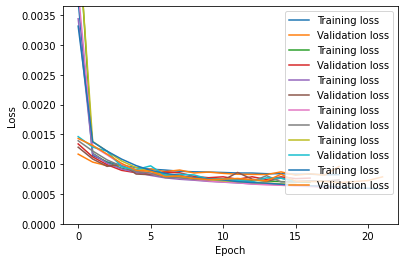

In [13]:
import shutil
# Вызовы построения и тренировки нейросети
for nbins in nbins_vars:
  nndatafilename = datadir + os.sep + f'{mode}_noise{noisefreqpersqmm}_phibins{nbins}_tcor_nndata.h5'
  if mode in ('beta','class'):
    n_max, nhyp = get_sim_pars(hdfilename.replace('edf','idf'))
    datadir_Model = datadir + os.sep + 'Model'
    datadir_Graph = datadir + os.sep + 'Graph'
    checkpoint_path = datadir_Model + os.sep + f'{mode}_noise{noisefreqpersqmm:.0f}_phibins{nbins}_tcor_weights.ckpt'
    model_path = datadir_Model + os.sep + f'{mode}_noise{noisefreqpersqmm:.0f}_phibins{nbins}_tcor_model'

    nndata_dtypes, nndata_shapes = get_nndata_format(nndatafilename)

    model = None
    if restoreModel:
      try:
        print(f'Restoring model from path {model_path}...')
        with strategy.scope():
          model = tf.keras.models.load_model(model_path)
        assert(model.inputs[0].shape[1] == nndata_shapes[0][0])
        model.summary()
      except:
        print('No existing model is found') 

    if model is None or updateModelFit:
      if model is None:
        model = build_model(nndata_shapes[0], mode, hlayers, nhyp=nhyp)
        model.summary()

      shutil.rmtree(datadir_Graph, ignore_errors=True)

      stopCallback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-6, patience=3, restore_best_weights=True)
      tbCallback = tf.keras.callbacks.TensorBoard(log_dir=datadir_Graph, histogram_freq=1, write_graph=True, write_images=False)
      cpCallback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                      monitor="val_loss",
                                                      save_weights_only=True,
                                                      verbose=0)

      print(f'Reading data&labels from {nndatafilename}...')
      test_data = pd.read_hdf(nndatafilename, 'test_data')
      test_labels = pd.read_hdf(nndatafilename, 'test_labels')
      train_data = pd.read_hdf(nndatafilename, 'train_data').to_numpy()
      train_labels = pd.read_hdf(nndatafilename, 'train_labels').to_numpy()

      bufferSize = train_data.shape[0]
      trainStepsPerEpoch = train_data.shape[0]//batchSize
      testStepsPerEpoch = test_data.shape[0]//batchSize

      if mode=='beta':
        train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels, train_labels)).shuffle(bufferSize).repeat().batch(batchSize, True)
        test_dataset = tf.data.Dataset.from_tensor_slices((test_data, test_labels, test_labels)).repeat().batch(batchSize, True)
      else:
        train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels)).shuffle(bufferSize).repeat().batch(batchSize, True)
        test_dataset = tf.data.Dataset.from_tensor_slices((test_data, test_labels)).repeat().batch(batchSize, True)

      del train_data, train_labels

      #print(f'Train data size: {train_rows} events, validate/test data size: {test_rows} events')

      print(f'Fitting model for at maximum {maxepochs} epochs...')
      history = model.fit(train_dataset, epochs=maxepochs,
                          validation_data=test_dataset,
                          callbacks=[stopCallback, tbCallback, cpCallback],
                          steps_per_epoch=trainStepsPerEpoch,
                          validation_steps=testStepsPerEpoch)

      last_epoch = len(history.history['loss'])
      print("Last epoch number:", last_epoch)
      model.save(model_path)

      plt.plot(history.history['loss'], '-', label='Training loss')
      plt.plot(history.history['val_loss'], '-', label='Validation loss')
      ymax = 1.1*max(*history.history['loss'],*history.history['val_loss'])
      plt.ylim(0, ymax)
      plt.xlabel('Epoch')
      plt.ylabel('Loss')
      plt.legend()
  

In [14]:
def evalSigmaBeta(nndatafilename, model_path, nbetapnts=10, theta_min=0, theta_max=10):
  print(f'Reading test data from {nndatafilename}...')
  test_data = pd.read_hdf(nndatafilename, 'test_data')
  test_labels = pd.read_hdf(nndatafilename, 'test_labels')

  with strategy.scope():
    print(f'Restoring model from path {model_path}...')
    model = tf.keras.models.load_model(model_path)
    print(f'Predicting beta values...')
    prediction = model.predict(test_data).flatten()

  # Break up data into bins on beta and theta
  betas = 1/n_max + (1-1/n_max) * test_labels
  beta_residual = (1-1/n_max) * (prediction-test_labels)
  thetas = test_data['theta_p_norm']*90 # градусы
  beta_min, beta_max = betas.min(), betas.max()+1e-5
  theta_mask = (thetas>=theta_min) & (thetas<theta_max)
  betas, beta_residual = betas[theta_mask], beta_residual[theta_mask]
  beta_pnt = beta_min + (beta_max-beta_min) * (np.floor(nbetapnts * (betas-beta_min) / (beta_max-beta_min)) + 0.5) / nbetapnts
  resdfgrp = pd.DataFrame({'beta_pnt': beta_pnt, 'residual': beta_residual}, dtype=np.float64).groupby('beta_pnt')

  accdf = resdfgrp.apply(gausSigmaWithError, iname='residual', onames=('sigma', 'sigma_error'))

  beta_set = accdf.index.to_numpy()
  sigbeta = accdf['sigma'].to_numpy()
  sigbeta_error = accdf['sigma_error'].to_numpy()  
  return beta_set, sigbeta, sigbeta_error

Reading test data from /mntDrive/My Drive/FARICH/Reconstruction/NN/data/beta_noise50000_phibins3_tcor_nndata.h5...
Restoring model from path /mntDrive/My Drive/FARICH/Reconstruction/NN/data/Model/beta_noise50000_phibins3_tcor_model...
Predicting beta values...


/mntDrive/My Drive/FARICH/Reconstruction/NN/farichnnlib.py:651: LogWarning: x is really small return 0
  r = m.migrad() # fit
/mntDrive/My Drive/FARICH/Reconstruction/NN/farichnnlib.py:651: LogWarning: x is really small return 0
  r = m.migrad() # fit
/mntDrive/My Drive/FARICH/Reconstruction/NN/farichnnlib.py:651: LogWarning: x is really small return 0
  r = m.migrad() # fit
/mntDrive/My Drive/FARICH/Reconstruction/NN/farichnnlib.py:651: LogWarning: x is really small return 0
  r = m.migrad() # fit


Reading test data from /mntDrive/My Drive/FARICH/Reconstruction/NN/data/beta_noise50000_phibins5_tcor_nndata.h5...
Restoring model from path /mntDrive/My Drive/FARICH/Reconstruction/NN/data/Model/beta_noise50000_phibins5_tcor_model...
Predicting beta values...


/mntDrive/My Drive/FARICH/Reconstruction/NN/farichnnlib.py:651: LogWarning: x is really small return 0
  r = m.migrad() # fit
/mntDrive/My Drive/FARICH/Reconstruction/NN/farichnnlib.py:651: LogWarning: x is really small return 0
  r = m.migrad() # fit
/mntDrive/My Drive/FARICH/Reconstruction/NN/farichnnlib.py:651: LogWarning: x is really small return 0
  r = m.migrad() # fit
/mntDrive/My Drive/FARICH/Reconstruction/NN/farichnnlib.py:651: LogWarning: x is really small return 0
  r = m.migrad() # fit
/mntDrive/My Drive/FARICH/Reconstruction/NN/farichnnlib.py:651: LogWarning: x is really small return 0
  r = m.migrad() # fit
/mntDrive/My Drive/FARICH/Reconstruction/NN/farichnnlib.py:651: LogWarning: x is really small return 0
  r = m.migrad() # fit
/mntDrive/My Drive/FARICH/Reconstruction/NN/farichnnlib.py:651: LogWarning: x is really small return 0
  r = m.migrad() # fit


Reading test data from /mntDrive/My Drive/FARICH/Reconstruction/NN/data/beta_noise50000_phibins7_tcor_nndata.h5...
Restoring model from path /mntDrive/My Drive/FARICH/Reconstruction/NN/data/Model/beta_noise50000_phibins7_tcor_model...
Predicting beta values...


/mntDrive/My Drive/FARICH/Reconstruction/NN/farichnnlib.py:651: LogWarning: x is really small return 0
  r = m.migrad() # fit
/mntDrive/My Drive/FARICH/Reconstruction/NN/farichnnlib.py:651: LogWarning: x is really small return 0
  r = m.migrad() # fit
/mntDrive/My Drive/FARICH/Reconstruction/NN/farichnnlib.py:651: LogWarning: x is really small return 0
  r = m.migrad() # fit
/mntDrive/My Drive/FARICH/Reconstruction/NN/farichnnlib.py:651: LogWarning: x is really small return 0
  r = m.migrad() # fit
/mntDrive/My Drive/FARICH/Reconstruction/NN/farichnnlib.py:651: LogWarning: x is really small return 0
  r = m.migrad() # fit
/mntDrive/My Drive/FARICH/Reconstruction/NN/farichnnlib.py:651: LogWarning: x is really small return 0
  r = m.migrad() # fit


Reading test data from /mntDrive/My Drive/FARICH/Reconstruction/NN/data/beta_noise50000_phibins9_tcor_nndata.h5...
Restoring model from path /mntDrive/My Drive/FARICH/Reconstruction/NN/data/Model/beta_noise50000_phibins9_tcor_model...
Predicting beta values...


/mntDrive/My Drive/FARICH/Reconstruction/NN/farichnnlib.py:651: LogWarning: x is really small return 0
  r = m.migrad() # fit
/mntDrive/My Drive/FARICH/Reconstruction/NN/farichnnlib.py:651: LogWarning: x is really small return 0
  r = m.migrad() # fit
/mntDrive/My Drive/FARICH/Reconstruction/NN/farichnnlib.py:651: LogWarning: x is really small return 0
  r = m.migrad() # fit
/mntDrive/My Drive/FARICH/Reconstruction/NN/farichnnlib.py:651: LogWarning: x is really small return 0
  r = m.migrad() # fit
/mntDrive/My Drive/FARICH/Reconstruction/NN/farichnnlib.py:651: LogWarning: x is really small return 0
  r = m.migrad() # fit
/mntDrive/My Drive/FARICH/Reconstruction/NN/farichnnlib.py:651: LogWarning: x is really small return 0
  r = m.migrad() # fit
/mntDrive/My Drive/FARICH/Reconstruction/NN/farichnnlib.py:651: LogWarning: x is really small return 0
  r = m.migrad() # fit
/mntDrive/My Drive/FARICH/Reconstruction/NN/farichnnlib.py:651: LogWarning: x is really small return 0
  r = m.migrad(

Reading test data from /mntDrive/My Drive/FARICH/Reconstruction/NN/data/beta_noise50000_phibins10_tcor_nndata.h5...
Restoring model from path /mntDrive/My Drive/FARICH/Reconstruction/NN/data/Model/beta_noise50000_phibins10_tcor_model...
Predicting beta values...


/mntDrive/My Drive/FARICH/Reconstruction/NN/farichnnlib.py:651: LogWarning: x is really small return 0
  r = m.migrad() # fit
/mntDrive/My Drive/FARICH/Reconstruction/NN/farichnnlib.py:651: LogWarning: x is really small return 0
  r = m.migrad() # fit
/mntDrive/My Drive/FARICH/Reconstruction/NN/farichnnlib.py:651: LogWarning: x is really small return 0
  r = m.migrad() # fit
/mntDrive/My Drive/FARICH/Reconstruction/NN/farichnnlib.py:651: LogWarning: x is really small return 0
  r = m.migrad() # fit
/mntDrive/My Drive/FARICH/Reconstruction/NN/farichnnlib.py:651: LogWarning: x is really small return 0
  r = m.migrad() # fit
/mntDrive/My Drive/FARICH/Reconstruction/NN/farichnnlib.py:651: LogWarning: x is really small return 0
  r = m.migrad() # fit
/mntDrive/My Drive/FARICH/Reconstruction/NN/farichnnlib.py:651: LogWarning: x is really small return 0
  r = m.migrad() # fit
/mntDrive/My Drive/FARICH/Reconstruction/NN/farichnnlib.py:651: LogWarning: x is really small return 0
  r = m.migrad(

Reading test data from /mntDrive/My Drive/FARICH/Reconstruction/NN/data/beta_noise50000_phibins11_tcor_nndata.h5...
Restoring model from path /mntDrive/My Drive/FARICH/Reconstruction/NN/data/Model/beta_noise50000_phibins11_tcor_model...
Predicting beta values...


/mntDrive/My Drive/FARICH/Reconstruction/NN/farichnnlib.py:651: LogWarning: x is really small return 0
  r = m.migrad() # fit
/mntDrive/My Drive/FARICH/Reconstruction/NN/farichnnlib.py:651: LogWarning: x is really small return 0
  r = m.migrad() # fit
/mntDrive/My Drive/FARICH/Reconstruction/NN/farichnnlib.py:651: LogWarning: x is really small return 0
  r = m.migrad() # fit
/mntDrive/My Drive/FARICH/Reconstruction/NN/farichnnlib.py:651: LogWarning: x is really small return 0
  r = m.migrad() # fit
/mntDrive/My Drive/FARICH/Reconstruction/NN/farichnnlib.py:651: LogWarning: x is really small return 0
  r = m.migrad() # fit
/mntDrive/My Drive/FARICH/Reconstruction/NN/farichnnlib.py:651: LogWarning: x is really small return 0
  r = m.migrad() # fit
/mntDrive/My Drive/FARICH/Reconstruction/NN/farichnnlib.py:651: LogWarning: x is really small return 0
  r = m.migrad() # fit
/mntDrive/My Drive/FARICH/Reconstruction/NN/farichnnlib.py:651: LogWarning: x is really small return 0
  r = m.migrad(

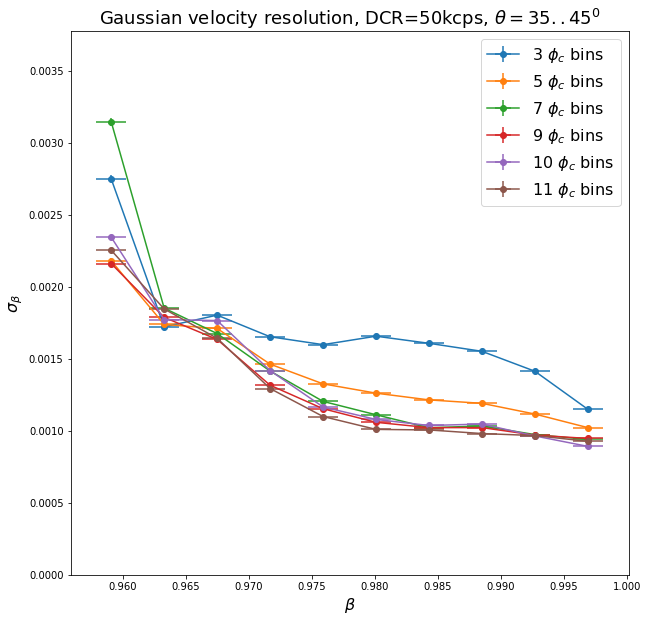

In [15]:
nbetapnts = 10
suffixes = [f'_phibins{nbins}' for nbins in nbins_vars]
labels = [fr'{nbins} $\phi_c$ bins' for nbins in nbins_vars]
nplots = len(suffixes)
betas = np.zeros((nbetapnts, nplots))
sigbetas = np.zeros((nbetapnts, nplots))
sigbeta_errors = np.zeros((nbetapnts, nplots))

fig = plt.figure(figsize=(10,10))
for i in range(nplots):
  nndatafilename = datadir + os.sep + f'{mode}_noise{noisefreqpersqmm}' + suffixes[i] + '_tcor_nndata.h5'
  model_path = datadir_Model + os.sep + f'{mode}_noise{noisefreqpersqmm}' + suffixes[i] + '_tcor_model'
  betas[:,i], sigbetas[:,i], sigbeta_errors[:,i] = evalSigmaBeta(nndatafilename, model_path, nbetapnts, theta_min=35, theta_max=45)
  dbeta = (betas[1,i] - betas[0,i]) / np.sqrt(12)

  plt.errorbar(betas[:,i], sigbetas[:,i], xerr=dbeta, yerr=sigbeta_errors[:,i], fmt='-o', label=labels[i])

plt.xlabel(r'$\beta$', fontsize=16)
plt.ylabel(r'$\sigma_\beta$', fontsize=16)
plt.title(rf'Gaussian velocity resolution, DCR={noisefreqpersqmm/1e3:.0f}kcps, $\theta=35..45^0$', fontsize=18)
plt.ylim(0, 1.2*sigbetas.max())
plt.legend(fontsize=16)
plt.savefig(datadir + os.sep + f'beta_gaus_res_theta35-45deg_dcr{noisefreqpersqmm/1e3:.0f}kcps_tcor_varphibins.png')